In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:3


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [3]:
# Domain bounds
label = "Regr_smooth_Swish"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.0008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3618.7754 Test MSE 3507.2925804016127 Test RE 0.9999719275397032
1 Train Loss 3618.53 Test MSE 3507.1614519257096 Test RE 0.9999532342004072
2 Train Loss 3618.2793 Test MSE 3507.0271760794385 Test RE 0.9999340918179157
3 Train Loss 3618.0227 Test MSE 3506.889034487562 Test RE 0.9999143979517771
4 Train Loss 3617.7583 Test MSE 3506.746260304567 Test RE 0.9998940432423883
5 Train Loss 3617.484 Test MSE 3506.598120977104 Test RE 0.9998729232091046
6 Train Loss 3617.1992 Test MSE 3506.443855757541 Test RE 0.9998509293410912
7 Train Loss 3616.9019 Test MSE 3506.282656337205 Test RE 

106 Train Loss 3487.3389 Test MSE 3506.9598993349173 Test RE 0.9999245006984735
107 Train Loss 3486.6763 Test MSE 3506.9978310178863 Test RE 0.9999299083332457
108 Train Loss 3485.9915 Test MSE 3506.8356891740586 Test RE 0.9999067927852946
109 Train Loss 3485.2844 Test MSE 3506.4950667837347 Test RE 0.9998582306422509
110 Train Loss 3484.558 Test MSE 3506.0065667605686 Test RE 0.9997885816377762
111 Train Loss 3483.8164 Test MSE 3505.4070093277146 Test RE 0.9997030917373528
112 Train Loss 3483.064 Test MSE 3504.7362916322377 Test RE 0.9996074465484971
113 Train Loss 3482.3047 Test MSE 3504.034478692782 Test RE 0.9995073573398241
114 Train Loss 3481.5413 Test MSE 3503.33932228065 Test RE 0.9994082075716554
115 Train Loss 3480.7754 Test MSE 3502.6843544225553 Test RE 0.9993147808735784
116 Train Loss 3480.0068 Test MSE 3502.0976201642534 Test RE 0.999231079815532
117 Train Loss 3479.233 Test MSE 3501.6009723674924 Test RE 0.9991602246361897
118 Train Loss 3478.453 Test MSE 3501.209762708

218 Train Loss 3336.6885 Test MSE 3453.391159859554 Test RE 0.9922581994232034
219 Train Loss 3334.328 Test MSE 3451.717360876698 Test RE 0.9920177050827105
220 Train Loss 3331.9456 Test MSE 3449.996855780817 Test RE 0.9917704391457868
221 Train Loss 3329.541 Test MSE 3448.2297535333473 Test RE 0.9915164122118807
222 Train Loss 3327.1135 Test MSE 3446.4150201560656 Test RE 0.9912554703870794
223 Train Loss 3324.6626 Test MSE 3444.550526283742 Test RE 0.990987301902915
224 Train Loss 3322.1885 Test MSE 3442.6330716215575 Test RE 0.990711440405098
225 Train Loss 3319.6904 Test MSE 3440.659491523669 Test RE 0.990427423978483
226 Train Loss 3317.1675 Test MSE 3438.626776868478 Test RE 0.9901348123750289
227 Train Loss 3314.6199 Test MSE 3436.533194507623 Test RE 0.9898333483705734
228 Train Loss 3312.0461 Test MSE 3434.378045795965 Test RE 0.989522923226486
229 Train Loss 3309.4456 Test MSE 3432.1616645517915 Test RE 0.9892035766122653
230 Train Loss 3306.8171 Test MSE 3429.884591975729 Te

331 Train Loss 2735.1816 Test MSE 2777.763994674567 Test RE 0.8899169567205907
332 Train Loss 2727.6267 Test MSE 2764.3871198848 Test RE 0.8877715847182213
333 Train Loss 2717.8647 Test MSE 2759.4432537097787 Test RE 0.8869773782952254
334 Train Loss 2708.842 Test MSE 2760.8367302699094 Test RE 0.8872013050213372
335 Train Loss 2701.3914 Test MSE 2749.8827192526355 Test RE 0.8854395072791209
336 Train Loss 2691.8157 Test MSE 2744.5923065971774 Test RE 0.8845873626538818
337 Train Loss 2684.0706 Test MSE 2745.979096634092 Test RE 0.8848108169745501
338 Train Loss 2676.6082 Test MSE 2736.8977517712833 Test RE 0.8833465074622625
339 Train Loss 2667.7854 Test MSE 2732.1089791867503 Test RE 0.8825733697855692
340 Train Loss 2660.456 Test MSE 2733.296908810503 Test RE 0.8827652217794206
341 Train Loss 2653.409 Test MSE 2724.73639156468 Test RE 0.8813817545970214
342 Train Loss 2645.2915 Test MSE 2721.1744423321998 Test RE 0.8808054669672676
343 Train Loss 2637.9153 Test MSE 2721.462413008985

445 Train Loss 1789.999 Test MSE 1859.7068169330014 Test RE 0.7281553610863657
446 Train Loss 1784.8246 Test MSE 1847.6083975069328 Test RE 0.7257829700748246
447 Train Loss 1779.2932 Test MSE 1845.5939486556515 Test RE 0.7253872013045031
448 Train Loss 1773.7108 Test MSE 1838.2228957773239 Test RE 0.7239372028429952
449 Train Loss 1768.4655 Test MSE 1831.6034915302014 Test RE 0.7226325855425052
450 Train Loss 1763.6497 Test MSE 1829.35568619488 Test RE 0.7221890299216623
451 Train Loss 1759.0713 Test MSE 1819.3409258834538 Test RE 0.7202095144346817
452 Train Loss 1754.4731 Test MSE 1819.0299993538536 Test RE 0.7201479696713883
453 Train Loss 1749.7069 Test MSE 1809.0224504404844 Test RE 0.7181642597378173
454 Train Loss 1744.8196 Test MSE 1806.4587471301295 Test RE 0.7176551967175515
455 Train Loss 1739.9686 Test MSE 1799.5752632566962 Test RE 0.7162865845400304
456 Train Loss 1735.2977 Test MSE 1793.8998720907846 Test RE 0.7151562020404213
457 Train Loss 1730.837 Test MSE 1791.05085

558 Train Loss 1475.2861 Test MSE 1498.8573627326448 Test RE 0.653705234667342
559 Train Loss 1474.9913 Test MSE 1490.4538438165032 Test RE 0.6518701214723656
560 Train Loss 1474.2677 Test MSE 1496.1811652651306 Test RE 0.653121381280237
561 Train Loss 1472.739 Test MSE 1488.114871321958 Test RE 0.6513584300363902
562 Train Loss 1470.7122 Test MSE 1489.062302633814 Test RE 0.6515657457452371
563 Train Loss 1468.9181 Test MSE 1487.968452221066 Test RE 0.6513263849088299
564 Train Loss 1467.7521 Test MSE 1483.5883659174544 Test RE 0.6503670338075938
565 Train Loss 1466.9999 Test MSE 1487.5134793654606 Test RE 0.651226799974491
566 Train Loss 1466.1635 Test MSE 1480.294815402062 Test RE 0.6496447287317239
567 Train Loss 1464.9188 Test MSE 1483.2554857398786 Test RE 0.6502940666544338
568 Train Loss 1463.3783 Test MSE 1478.567498371106 Test RE 0.6492655914365509
569 Train Loss 1461.906 Test MSE 1477.5992785287842 Test RE 0.6490529752469886
570 Train Loss 1460.78 Test MSE 1478.204126589812 

671 Train Loss 1368.5297 Test MSE 1367.643085173692 Test RE 0.6244363793087034
672 Train Loss 1367.7328 Test MSE 1367.3937716848548 Test RE 0.6243794611297105
673 Train Loss 1367.0676 Test MSE 1365.239551600478 Test RE 0.6238874371874769
674 Train Loss 1366.3921 Test MSE 1365.512247866695 Test RE 0.6239497424729031
675 Train Loss 1365.6301 Test MSE 1363.7612747448804 Test RE 0.6235495740802094
676 Train Loss 1364.8234 Test MSE 1362.8889047742136 Test RE 0.6233501062728647
677 Train Loss 1364.0393 Test MSE 1362.6258497326398 Test RE 0.6232899460864224
678 Train Loss 1363.2792 Test MSE 1360.8060629160275 Test RE 0.6228736051739646
679 Train Loss 1362.4944 Test MSE 1360.8505149452612 Test RE 0.6228837784713765
680 Train Loss 1361.666 Test MSE 1359.4554852631034 Test RE 0.6225644325345517
681 Train Loss 1360.8257 Test MSE 1358.6519224967008 Test RE 0.6223804090224746
682 Train Loss 1360.008 Test MSE 1358.3378894014252 Test RE 0.6223084776697442
683 Train Loss 1359.2086 Test MSE 1356.850257

783 Train Loss 1269.9868 Test MSE 1272.3472258482677 Test RE 0.6022885867927313
784 Train Loss 1268.6804 Test MSE 1272.7204095264292 Test RE 0.6023769069410987
785 Train Loss 1267.2781 Test MSE 1271.898884804635 Test RE 0.602182462269421
786 Train Loss 1266.3619 Test MSE 1269.875888304666 Test RE 0.6017033763076636
787 Train Loss 1265.841 Test MSE 1271.5937860747345 Test RE 0.6021102332086993
788 Train Loss 1265.1852 Test MSE 1268.374304089139 Test RE 0.6013475243891984
789 Train Loss 1264.1246 Test MSE 1268.8266582309095 Test RE 0.6014547473884354
790 Train Loss 1262.9315 Test MSE 1267.7147782986033 Test RE 0.6011911605422527
791 Train Loss 1261.9835 Test MSE 1266.2267442970528 Test RE 0.6008382201275755
792 Train Loss 1261.3081 Test MSE 1267.2682801875128 Test RE 0.6010852793290079
793 Train Loss 1260.6201 Test MSE 1264.6397713308609 Test RE 0.6004615842028066
794 Train Loss 1259.708 Test MSE 1265.1248776957304 Test RE 0.6005767394487375
795 Train Loss 1258.6617 Test MSE 1263.6740522

896 Train Loss 1187.4135 Test MSE 1196.0125040647263 Test RE 0.5839419421179634
897 Train Loss 1186.8915 Test MSE 1194.8486817838548 Test RE 0.5836577602847945
898 Train Loss 1186.2966 Test MSE 1194.4111845255416 Test RE 0.5835508965236119
899 Train Loss 1185.7048 Test MSE 1193.9306901879124 Test RE 0.5834335076753214
900 Train Loss 1185.1765 Test MSE 1193.340433967282 Test RE 0.5832892707302039
901 Train Loss 1184.7305 Test MSE 1193.0592516947183 Test RE 0.5832205475643436
902 Train Loss 1184.3392 Test MSE 1192.423570452215 Test RE 0.5830651521976243
903 Train Loss 1183.9545 Test MSE 1192.391185851384 Test RE 0.5830572345159856
904 Train Loss 1183.5386 Test MSE 1191.262729924714 Test RE 0.5827812721714906
905 Train Loss 1183.0787 Test MSE 1191.653795794542 Test RE 0.5828769215854781
906 Train Loss 1182.5897 Test MSE 1190.1666408373796 Test RE 0.5825130999283582
907 Train Loss 1182.095 Test MSE 1190.601656084896 Test RE 0.5826195467572188
908 Train Loss 1181.6172 Test MSE 1189.51759104

1003 Train Loss 1152.0261 Test MSE 1158.6189641222322 Test RE 0.5747409297773857
1004 Train Loss 1151.8164 Test MSE 1158.398889039052 Test RE 0.5746863423035045
1005 Train Loss 1151.6044 Test MSE 1158.41349448576 Test RE 0.5746899652024767
1006 Train Loss 1151.3911 Test MSE 1157.6802431928556 Test RE 0.574508053101915
1007 Train Loss 1151.1774 Test MSE 1158.0164579277032 Test RE 0.5745914716674555
1008 Train Loss 1150.9628 Test MSE 1157.2242831807764 Test RE 0.5743949050636704
1009 Train Loss 1150.7489 Test MSE 1157.3702307420476 Test RE 0.5744311248759427
1010 Train Loss 1150.5371 Test MSE 1156.9713679558006 Test RE 0.5743321336730659
1011 Train Loss 1150.3286 Test MSE 1156.6711745773862 Test RE 0.5742576193447971
1012 Train Loss 1150.1239 Test MSE 1156.6944649929628 Test RE 0.5742634008631621
1013 Train Loss 1149.9219 Test MSE 1156.1208299287637 Test RE 0.5741209870777467
1014 Train Loss 1149.7219 Test MSE 1156.2417867008596 Test RE 0.5741510194079896
1015 Train Loss 1149.5233 Test M

1112 Train Loss 1135.561 Test MSE 1136.699467721525 Test RE 0.5692783113817108
1113 Train Loss 1135.4557 Test MSE 1136.545736732751 Test RE 0.5692398145409185
1114 Train Loss 1135.3522 Test MSE 1136.3878261484583 Test RE 0.569200268347879
1115 Train Loss 1135.2512 Test MSE 1136.2808402328733 Test RE 0.5691734738663609
1116 Train Loss 1135.1542 Test MSE 1136.0849715990353 Test RE 0.5691244155563485
1117 Train Loss 1135.062 Test MSE 1136.0204217894761 Test RE 0.5691082471378766
1118 Train Loss 1134.9779 Test MSE 1135.824214544811 Test RE 0.56905909838103
1119 Train Loss 1134.9044 Test MSE 1135.7803813169337 Test RE 0.5690481178360327
1120 Train Loss 1134.8489 Test MSE 1135.6266127755334 Test RE 0.56900959601336
1121 Train Loss 1134.8169 Test MSE 1135.6231875418107 Test RE 0.5690087379001807
1122 Train Loss 1134.8263 Test MSE 1135.5340869624097 Test RE 0.5689864153537222
1123 Train Loss 1134.8862 Test MSE 1135.6564613459534 Test RE 0.5690170738283411
1124 Train Loss 1135.0394 Test MSE 113

1233 Train Loss 1129.7441 Test MSE 1122.8063269373497 Test RE 0.5657886557531865
1234 Train Loss 1128.0453 Test MSE 1122.3211482717697 Test RE 0.5656664003652938
1235 Train Loss 1125.7139 Test MSE 1120.2573069056768 Test RE 0.5651460578066563
1236 Train Loss 1124.317 Test MSE 1120.7349556864704 Test RE 0.5652665268078171
1237 Train Loss 1124.3885 Test MSE 1121.88640471431 Test RE 0.5655568311732823
1238 Train Loss 1125.4268 Test MSE 1121.6347946011497 Test RE 0.5654934077299063
1239 Train Loss 1126.4275 Test MSE 1123.0064155536763 Test RE 0.5658390664177294
1240 Train Loss 1126.4042 Test MSE 1120.9003098097185 Test RE 0.5653082252054149
1241 Train Loss 1125.5013 Test MSE 1120.8623517614683 Test RE 0.56529865335573
1242 Train Loss 1124.2911 Test MSE 1120.0367894209467 Test RE 0.5650904318714574
1243 Train Loss 1123.7052 Test MSE 1119.717850868028 Test RE 0.56500996935517
1244 Train Loss 1123.9517 Test MSE 1120.9075446090724 Test RE 0.5653100495804049
1245 Train Loss 1124.5319 Test MSE 1

1364 Train Loss 1121.1028 Test MSE 1108.0698314371673 Test RE 0.5620634894513422
1365 Train Loss 1119.6646 Test MSE 1105.2894358873248 Test RE 0.5613578749041662
1366 Train Loss 1117.6346 Test MSE 1104.9696592486575 Test RE 0.5612766644474116
1367 Train Loss 1115.7573 Test MSE 1103.9841586644902 Test RE 0.5610263128362116
1368 Train Loss 1115.1156 Test MSE 1104.3244610809975 Test RE 0.5611127741763116
1369 Train Loss 1115.7173 Test MSE 1105.9041803852654 Test RE 0.5615139623883482
1370 Train Loss 1116.7709 Test MSE 1105.1994591264593 Test RE 0.5613350255989958
1371 Train Loss 1117.4246 Test MSE 1106.10456131333 Test RE 0.5615648309873562
1372 Train Loss 1117.0173 Test MSE 1104.2947629006155 Test RE 0.5611052292286962
1373 Train Loss 1115.9891 Test MSE 1103.961080817503 Test RE 0.5610204489173475
1374 Train Loss 1114.9865 Test MSE 1103.6496349879387 Test RE 0.5609413067232638
1375 Train Loss 1114.6788 Test MSE 1103.4010315033934 Test RE 0.560878125522894
1376 Train Loss 1115.0483 Test M

1483 Train Loss 1109.2048 Test MSE 1096.0902625606318 Test RE 0.5590169413687208
1484 Train Loss 1109.1874 Test MSE 1095.9653254253367 Test RE 0.5589850808696549
1485 Train Loss 1109.1852 Test MSE 1096.0786207990939 Test RE 0.5590139726537208
1486 Train Loss 1109.2058 Test MSE 1095.9471624904895 Test RE 0.5589804489477167
1487 Train Loss 1109.2668 Test MSE 1096.19968717642 Test RE 0.5590448444938153
1488 Train Loss 1109.3865 Test MSE 1096.099581192766 Test RE 0.5590193176612304
1489 Train Loss 1109.6128 Test MSE 1096.643512682492 Test RE 0.5591580051043706
1490 Train Loss 1109.9783 Test MSE 1096.6840687496817 Test RE 0.5591683443986369
1491 Train Loss 1110.6025 Test MSE 1097.778894097843 Test RE 0.5594473850916084
1492 Train Loss 1111.4722 Test MSE 1098.0762665377008 Test RE 0.5595231530672362
1493 Train Loss 1112.7853 Test MSE 1099.7712400323212 Test RE 0.559954822182659
1494 Train Loss 1114.0745 Test MSE 1099.6890096631591 Test RE 0.5599338877597514
1495 Train Loss 1115.376 Test MSE 

1597 Train Loss 1105.0663 Test MSE 1090.8832342794328 Test RE 0.5576875425263366
1598 Train Loss 1105.0343 Test MSE 1090.8455195678796 Test RE 0.5576779020781487
1599 Train Loss 1105.0024 Test MSE 1090.8083708915697 Test RE 0.5576684061541706
1600 Train Loss 1104.9706 Test MSE 1090.7671990322578 Test RE 0.557657881637476
1601 Train Loss 1104.9387 Test MSE 1090.731853791262 Test RE 0.5576488463859965
1602 Train Loss 1104.9071 Test MSE 1090.690540254189 Test RE 0.5576382852822894
1603 Train Loss 1104.8755 Test MSE 1090.6553117110109 Test RE 0.5576292795458698
1604 Train Loss 1104.8438 Test MSE 1090.6142006357004 Test RE 0.5576187698297866
1605 Train Loss 1104.8124 Test MSE 1090.579762759399 Test RE 0.5576099659109477
1606 Train Loss 1104.7809 Test MSE 1090.5379225974082 Test RE 0.5575992694374426
1607 Train Loss 1104.7491 Test MSE 1090.504964035208 Test RE 0.5575908434081045
1608 Train Loss 1104.7179 Test MSE 1090.4624845953526 Test RE 0.5575799831286243
1609 Train Loss 1104.6865 Test MS

1712 Train Loss 1101.7882 Test MSE 1087.0459406285602 Test RE 0.556705816873694
1713 Train Loss 1101.7666 Test MSE 1087.047669325105 Test RE 0.556706259529797
1714 Train Loss 1101.7456 Test MSE 1086.9749459530851 Test RE 0.5566876374239306
1715 Train Loss 1101.7214 Test MSE 1086.999105027989 Test RE 0.5566938238515257
1716 Train Loss 1101.6931 Test MSE 1086.9184780488647 Test RE 0.5566731773885005
1717 Train Loss 1101.6627 Test MSE 1086.917275340418 Test RE 0.5566728694004905
1718 Train Loss 1101.6332 Test MSE 1086.8816464513395 Test RE 0.5566637455237685
1719 Train Loss 1101.6067 Test MSE 1086.8343123854854 Test RE 0.5566516239439441
1720 Train Loss 1101.5825 Test MSE 1086.8394675159968 Test RE 0.5566529441122233
1721 Train Loss 1101.5592 Test MSE 1086.7731854930823 Test RE 0.5566359698272193
1722 Train Loss 1101.5347 Test MSE 1086.7746985981107 Test RE 0.5566363573268388
1723 Train Loss 1101.5084 Test MSE 1086.7229953921212 Test RE 0.5566231162076861
1724 Train Loss 1101.4807 Test MS

1826 Train Loss 1104.9385 Test MSE 1089.7934540078434 Test RE 0.5574089110816888
1827 Train Loss 1106.7042 Test MSE 1090.0651557995923 Test RE 0.5574783919364658
1828 Train Loss 1108.0365 Test MSE 1090.0691070777402 Test RE 0.5574794023119374
1829 Train Loss 1106.7084 Test MSE 1086.6468186905124 Test RE 0.5566036068864044
1830 Train Loss 1103.7443 Test MSE 1085.4471534789968 Test RE 0.5562962750234303
1831 Train Loss 1100.2373 Test MSE 1083.2876568294223 Test RE 0.5557426239130472
1832 Train Loss 1098.784 Test MSE 1084.545304521198 Test RE 0.5560651262906107
1833 Train Loss 1099.8119 Test MSE 1086.298574359007 Test RE 0.556514410663702
1834 Train Loss 1101.778 Test MSE 1085.9651255506915 Test RE 0.5564289906354873
1835 Train Loss 1102.82 Test MSE 1086.7570093218455 Test RE 0.5566318271632343
1836 Train Loss 1101.7485 Test MSE 1083.7721096478472 Test RE 0.5558668757611419
1837 Train Loss 1099.8146 Test MSE 1083.8776957628174 Test RE 0.5558939526686818
1838 Train Loss 1098.6567 Test MSE 

1933 Train Loss 1096.171 Test MSE 1080.9687845278365 Test RE 0.5551474973323098
1934 Train Loss 1096.1416 Test MSE 1080.9341539155926 Test RE 0.5551386047296867
1935 Train Loss 1096.112 Test MSE 1080.9047641988238 Test RE 0.5551310577957671
1936 Train Loss 1096.0823 Test MSE 1080.8650283440734 Test RE 0.5551208539320491
1937 Train Loss 1096.0525 Test MSE 1080.8357454258903 Test RE 0.5551133341824867
1938 Train Loss 1096.0226 Test MSE 1080.7976010440418 Test RE 0.5551035386877035
1939 Train Loss 1095.9927 Test MSE 1080.7630975636011 Test RE 0.5550946780291797
1940 Train Loss 1095.9623 Test MSE 1080.7281352731263 Test RE 0.5550856994017747
1941 Train Loss 1095.9319 Test MSE 1080.6900864049933 Test RE 0.55507592794872
1942 Train Loss 1095.9012 Test MSE 1080.6543188383864 Test RE 0.5550667422072425
1943 Train Loss 1095.8705 Test MSE 1080.616921416585 Test RE 0.5550571377276614
1944 Train Loss 1095.8394 Test MSE 1080.576814971923 Test RE 0.5550468373267998
1945 Train Loss 1095.8081 Test MSE

2043 Train Loss 1092.2352 Test MSE 1074.769765874079 Test RE 0.5535534098184087
2044 Train Loss 1092.2231 Test MSE 1074.3915233161404 Test RE 0.5534559955213788
2045 Train Loss 1091.8282 Test MSE 1074.9645795362067 Test RE 0.5536035763210566
2046 Train Loss 1091.4712 Test MSE 1073.8723943660689 Test RE 0.5533222687846472
2047 Train Loss 1091.4365 Test MSE 1074.6046792993598 Test RE 0.5535108947846225
2048 Train Loss 1091.628 Test MSE 1074.776236160124 Test RE 0.5535550760559721
2049 Train Loss 1091.7355 Test MSE 1073.970271610897 Test RE 0.5533474842690345
2050 Train Loss 1091.5797 Test MSE 1074.476864659116 Test RE 0.5534779762141702
2051 Train Loss 1091.3071 Test MSE 1073.9999566206154 Test RE 0.5533551315998674
2052 Train Loss 1091.1613 Test MSE 1073.7909389918545 Test RE 0.553301283084942
2053 Train Loss 1091.2128 Test MSE 1074.4205586901207 Test RE 0.5534634740303269
2054 Train Loss 1091.3064 Test MSE 1073.813878163162 Test RE 0.5533071930831881
2055 Train Loss 1091.2711 Test MSE 

2155 Train Loss 1085.0734 Test MSE 1065.8898999158912 Test RE 0.5512619072770393
2156 Train Loss 1084.9717 Test MSE 1065.7839478465528 Test RE 0.551234508203571
2157 Train Loss 1084.8684 Test MSE 1065.6674495626264 Test RE 0.5512043803200783
2158 Train Loss 1084.7635 Test MSE 1065.5553808276536 Test RE 0.5511753964181226
2159 Train Loss 1084.6573 Test MSE 1065.442190891221 Test RE 0.5511461209970173
2160 Train Loss 1084.5494 Test MSE 1065.3212586046848 Test RE 0.5511148413778089
2161 Train Loss 1084.4401 Test MSE 1065.2084161964044 Test RE 0.551085652636692
2162 Train Loss 1084.3293 Test MSE 1065.0856745772962 Test RE 0.5510539015291664
2163 Train Loss 1084.2172 Test MSE 1064.966747789231 Test RE 0.5510231355064759
2164 Train Loss 1084.1035 Test MSE 1064.8460875718906 Test RE 0.5509919192949094
2165 Train Loss 1083.9886 Test MSE 1064.721509350521 Test RE 0.5509596875940849
2166 Train Loss 1083.8726 Test MSE 1064.5991481742246 Test RE 0.550928027666159
2167 Train Loss 1083.7551 Test MSE

2270 Train Loss 1071.2942 Test MSE 1049.1763343872835 Test RE 0.546922830603355
2271 Train Loss 1071.1938 Test MSE 1048.9767226312817 Test RE 0.5468708005412058
2272 Train Loss 1071.0879 Test MSE 1048.8815297253561 Test RE 0.5468459861670405
2273 Train Loss 1070.9779 Test MSE 1048.6890899841594 Test RE 0.5467958185721257
2274 Train Loss 1070.8677 Test MSE 1048.5701890365403 Test RE 0.5467648196876356
2275 Train Loss 1070.7603 Test MSE 1048.4184519829819 Test RE 0.5467252574889242
2276 Train Loss 1070.6559 Test MSE 1048.2598936941476 Test RE 0.5466839137397052
2277 Train Loss 1070.5531 Test MSE 1048.1505412855745 Test RE 0.546655398501165
2278 Train Loss 1070.4496 Test MSE 1047.9568758653825 Test RE 0.5466048937625719
2279 Train Loss 1070.3434 Test MSE 1047.8637540849368 Test RE 0.5465806074809054
2280 Train Loss 1070.2343 Test MSE 1047.6658703877645 Test RE 0.5465289955715287
2281 Train Loss 1070.1235 Test MSE 1047.5557310203544 Test RE 0.5465002669751025
2282 Train Loss 1070.0125 Test

2385 Train Loss 1055.4718 Test MSE 1025.751769338896 Test RE 0.5407828960739683
2386 Train Loss 1053.4337 Test MSE 1025.502929400684 Test RE 0.5407172970914532
2387 Train Loss 1051.8734 Test MSE 1024.765365003455 Test RE 0.5405228141940397
2388 Train Loss 1051.8127 Test MSE 1025.359867691131 Test RE 0.5406795796765429
2389 Train Loss 1052.7168 Test MSE 1026.1805023785264 Test RE 0.5408958996680576
2390 Train Loss 1053.2413 Test MSE 1024.8967204835249 Test RE 0.5405574554695375
2391 Train Loss 1052.7194 Test MSE 1024.6280497313633 Test RE 0.5404865988190948
2392 Train Loss 1051.4905 Test MSE 1023.5846956990832 Test RE 0.5402113464961653
2393 Train Loss 1050.6227 Test MSE 1023.2998386104749 Test RE 0.540136172580563
2394 Train Loss 1050.6014 Test MSE 1024.05618632963 Test RE 0.5403357501069589
2395 Train Loss 1051.0337 Test MSE 1023.4378777947104 Test RE 0.5401726024907093
2396 Train Loss 1051.2021 Test MSE 1023.43591748507 Test RE 0.5401720851627452
2397 Train Loss 1050.738 Test MSE 102

2499 Train Loss 1029.0731 Test MSE 996.6466043818837 Test RE 0.5330554716232904
2500 Train Loss 1028.8848 Test MSE 996.40548629923 Test RE 0.5329909868363083
2501 Train Loss 1028.6967 Test MSE 996.1642577388288 Test RE 0.5329264646949753
2502 Train Loss 1028.509 Test MSE 995.9255796288273 Test RE 0.532862617041162
2503 Train Loss 1028.3214 Test MSE 995.6850413963512 Test RE 0.5327982640539399
2504 Train Loss 1028.1339 Test MSE 995.4453573074713 Test RE 0.5327341318497972
2505 Train Loss 1027.9467 Test MSE 995.2071945808274 Test RE 0.5326703990681197
2506 Train Loss 1027.7595 Test MSE 994.9660108465879 Test RE 0.532605850087154
2507 Train Loss 1027.5724 Test MSE 994.7295449429981 Test RE 0.5325425561624886
2508 Train Loss 1027.3855 Test MSE 994.4883219137861 Test RE 0.5324779811640906
2509 Train Loss 1027.1985 Test MSE 994.2517526973555 Test RE 0.5324146443766153
2510 Train Loss 1027.0116 Test MSE 994.0121189985113 Test RE 0.5323504794512295
2511 Train Loss 1026.8246 Test MSE 993.774095

2609 Train Loss 1008.2887 Test MSE 970.5440184853023 Test RE 0.5260286863650265
2610 Train Loss 1008.0998 Test MSE 970.5148870538096 Test RE 0.5260207917804742
2611 Train Loss 1007.93024 Test MSE 970.1943952839185 Test RE 0.5259339310547764
2612 Train Loss 1007.7187 Test MSE 969.8055410711363 Test RE 0.5258285232509804
2613 Train Loss 1007.48047 Test MSE 969.7340279899859 Test RE 0.5258091356987823
2614 Train Loss 1007.2666 Test MSE 969.4114689612184 Test RE 0.5257216794554692
2615 Train Loss 1007.08093 Test MSE 969.0849202454873 Test RE 0.5256331266559746
2616 Train Loss 1006.88275 Test MSE 968.9783007046289 Test RE 0.525604210560488
2617 Train Loss 1006.65625 Test MSE 968.6078240309282 Test RE 0.5255037218727605
2618 Train Loss 1006.43066 Test MSE 968.3200128814734 Test RE 0.5254256422499193
2619 Train Loss 1006.2277 Test MSE 968.2070629925335 Test RE 0.5253949971646795
2620 Train Loss 1006.0292 Test MSE 967.8399485020722 Test RE 0.5252953808681895
2621 Train Loss 1005.81244 Test MSE

2720 Train Loss 983.31854 Test MSE 940.6656715069968 Test RE 0.5178684548959621
2721 Train Loss 983.1091 Test MSE 940.4210961604433 Test RE 0.5178011269947908
2722 Train Loss 982.8999 Test MSE 940.1756101604589 Test RE 0.5177335395999559
2723 Train Loss 982.69086 Test MSE 939.9306846291686 Test RE 0.5176660977196625
2724 Train Loss 982.482 Test MSE 939.687214176382 Test RE 0.5175990477955928
2725 Train Loss 982.2734 Test MSE 939.441426447807 Test RE 0.5175313509000578
2726 Train Loss 982.0647 Test MSE 939.1988952945867 Test RE 0.5174645422763711
2727 Train Loss 981.85626 Test MSE 938.9545944905955 Test RE 0.5173972374561704
2728 Train Loss 981.64795 Test MSE 938.7100454039521 Test RE 0.5173298554644145
2729 Train Loss 981.43964 Test MSE 938.4681142635012 Test RE 0.5172631861730059
2730 Train Loss 981.23126 Test MSE 938.2231485814021 Test RE 0.5171956718924565
2731 Train Loss 981.02313 Test MSE 937.9804056302803 Test RE 0.5171287615175479
2732 Train Loss 980.8148 Test MSE 937.7373101071

2833 Train Loss 960.35254 Test MSE 913.4454877027499 Test RE 0.5103206323155712
2834 Train Loss 960.405 Test MSE 912.8799111554334 Test RE 0.5101626206575695
2835 Train Loss 959.76086 Test MSE 912.3071997597509 Test RE 0.5100025657682291
2836 Train Loss 959.19305 Test MSE 912.3562662241214 Test RE 0.5100162802748514
2837 Train Loss 959.20605 Test MSE 912.3330019025582 Test RE 0.5100097777391507
2838 Train Loss 959.34045 Test MSE 912.0611405504065 Test RE 0.5099337845008926
2839 Train Loss 959.0542 Test MSE 911.6227918390671 Test RE 0.5098112292951331
2840 Train Loss 958.5352 Test MSE 911.3899927338961 Test RE 0.5097461304532609
2841 Train Loss 958.29846 Test MSE 911.2874714322733 Test RE 0.5097174592439246
2842 Train Loss 958.339 Test MSE 911.1179269738511 Test RE 0.5096700407326178
2843 Train Loss 958.24255 Test MSE 910.8498218858305 Test RE 0.5095950475946017
2844 Train Loss 957.8867 Test MSE 910.415138066256 Test RE 0.5094734363526741
2845 Train Loss 957.55585 Test MSE 910.343536588

2945 Train Loss 942.279 Test MSE 891.4374632870058 Test RE 0.5041354654316946
2946 Train Loss 942.1356 Test MSE 891.2562388873638 Test RE 0.5040842188245979
2947 Train Loss 941.9923 Test MSE 891.0777377914601 Test RE 0.5040337372193656
2948 Train Loss 941.849 Test MSE 890.8973880211615 Test RE 0.5039827276581967
2949 Train Loss 941.7056 Test MSE 890.7178780036165 Test RE 0.5039319504827127
2950 Train Loss 941.5623 Test MSE 890.5394815602057 Test RE 0.5038814832294318
2951 Train Loss 941.4189 Test MSE 890.3583337355794 Test RE 0.5038302324546678
2952 Train Loss 941.2756 Test MSE 890.181082437258 Test RE 0.5037800790475778
2953 Train Loss 941.1321 Test MSE 889.9996721153718 Test RE 0.5037287436705833
2954 Train Loss 940.98865 Test MSE 889.8221380247709 Test RE 0.5036785001213927
2955 Train Loss 940.8452 Test MSE 889.6417198715941 Test RE 0.5036274352244576
2956 Train Loss 940.7019 Test MSE 889.4636217083871 Test RE 0.5035770218902826
2957 Train Loss 940.55835 Test MSE 889.2840774811908 T

3050 Train Loss 928.9417 Test MSE 875.6149356575411 Test RE 0.4996413697609394
3051 Train Loss 929.94745 Test MSE 874.9454246774118 Test RE 0.49945031582950256
3052 Train Loss 929.5745 Test MSE 874.1774049965898 Test RE 0.4992310610761224
3053 Train Loss 928.34314 Test MSE 873.8557800205962 Test RE 0.49913921475951123
3054 Train Loss 927.8663 Test MSE 874.0959393154756 Test RE 0.4992077985519698
3055 Train Loss 928.41907 Test MSE 874.4897056356743 Test RE 0.4993202284786763
3056 Train Loss 928.7694 Test MSE 873.8413265723984 Test RE 0.4991350868972369
3057 Train Loss 928.18854 Test MSE 873.4317239951527 Test RE 0.49901809141109765
3058 Train Loss 927.4575 Test MSE 873.2482013626018 Test RE 0.4989656626278871
3059 Train Loss 927.409 Test MSE 873.3637829627031 Test RE 0.49899868264522135
3060 Train Loss 927.7588 Test MSE 873.4966246227559 Test RE 0.49903663091729294
3061 Train Loss 927.72833 Test MSE 872.7837828345826 Test RE 0.4988329628316389
3062 Train Loss 927.21625 Test MSE 872.6565

3162 Train Loss 916.534 Test MSE 860.3539844572823 Test RE 0.49526814661092783
3163 Train Loss 916.4279 Test MSE 860.2246763633092 Test RE 0.49523092670626734
3164 Train Loss 916.3217 Test MSE 860.0999651314677 Test RE 0.4951950273074108
3165 Train Loss 916.215 Test MSE 859.9713422958156 Test RE 0.49515799918706715
3166 Train Loss 916.10803 Test MSE 859.8443758571397 Test RE 0.49512144519666235
3167 Train Loss 916.00073 Test MSE 859.7163012571804 Test RE 0.49508456942918755
3168 Train Loss 915.8931 Test MSE 859.5873763098407 Test RE 0.4950474460519155
3169 Train Loss 915.78516 Test MSE 859.4597752195185 Test RE 0.4950107011321718
3170 Train Loss 915.6768 Test MSE 859.3290709442635 Test RE 0.49497305976905204
3171 Train Loss 915.5682 Test MSE 859.2016299671782 Test RE 0.49493635544273196
3172 Train Loss 915.45917 Test MSE 859.0697412304364 Test RE 0.4948983672490336
3173 Train Loss 915.34973 Test MSE 858.9410737867277 Test RE 0.49486130408101925
3174 Train Loss 915.2399 Test MSE 858.809

3267 Train Loss 905.5837 Test MSE 847.8678711655659 Test RE 0.4916611573722938
3268 Train Loss 906.2457 Test MSE 849.685837251056 Test RE 0.4921879757171757
3269 Train Loss 908.04846 Test MSE 849.2559176239499 Test RE 0.4920634426046357
3270 Train Loss 908.4815 Test MSE 848.8007731107779 Test RE 0.49193156834486856
3271 Train Loss 907.09796 Test MSE 847.32367714143 Test RE 0.4915033485797711
3272 Train Loss 905.41077 Test MSE 847.0252513123424 Test RE 0.4914167876731193
3273 Train Loss 905.14874 Test MSE 847.8839346048467 Test RE 0.49166581477942645
3274 Train Loss 906.09503 Test MSE 847.9030146413829 Test RE 0.4916713467564766
3275 Train Loss 906.7074 Test MSE 847.7965098668213 Test RE 0.4916404664614774
3276 Train Loss 906.16614 Test MSE 846.6598231374747 Test RE 0.4913107714048346
3277 Train Loss 905.0625 Test MSE 846.4263030417317 Test RE 0.49124301169342793
3278 Train Loss 904.5914 Test MSE 846.7340877066385 Test RE 0.491332318537278
3279 Train Loss 904.9815 Test MSE 846.778605849

3376 Train Loss 896.34875 Test MSE 836.747089492042 Test RE 0.4884261582601368
3377 Train Loss 896.26984 Test MSE 836.6592322370682 Test RE 0.48840051556084374
3378 Train Loss 896.1913 Test MSE 836.5652568355147 Test RE 0.48837308568156707
3379 Train Loss 896.11273 Test MSE 836.4777574141901 Test RE 0.4883475446496628
3380 Train Loss 896.0343 Test MSE 836.3842582395323 Test RE 0.4883202508166964
3381 Train Loss 895.9563 Test MSE 836.2970243591318 Test RE 0.4882947845428352
3382 Train Loss 895.87836 Test MSE 836.2047655515722 Test RE 0.4882678498917719
3383 Train Loss 895.80054 Test MSE 836.1161437925571 Test RE 0.4882419756657146
3384 Train Loss 895.72296 Test MSE 836.0266203774001 Test RE 0.48821583679765135
3385 Train Loss 895.64545 Test MSE 835.9362868042218 Test RE 0.4881894599626713
3386 Train Loss 895.5682 Test MSE 835.848398848627 Test RE 0.4881637958647798
3387 Train Loss 895.49097 Test MSE 835.7577488919474 Test RE 0.4881373238233869
3388 Train Loss 895.414 Test MSE 835.670512

3487 Train Loss 888.1667 Test MSE 827.6409074252484 Test RE 0.48576115663164665
3488 Train Loss 888.26526 Test MSE 827.6048744758989 Test RE 0.4857505822403188
3489 Train Loss 888.4465 Test MSE 827.6934427755824 Test RE 0.48577657347931275
3490 Train Loss 888.36743 Test MSE 827.2995235156548 Test RE 0.4856609633320853
3491 Train Loss 888.05835 Test MSE 827.2158814914217 Test RE 0.4856364119503312
3492 Train Loss 887.82513 Test MSE 827.2119179111992 Test RE 0.48563524849274625
3493 Train Loss 887.8238 Test MSE 827.1454800392579 Test RE 0.48561574610187597
3494 Train Loss 887.91046 Test MSE 827.2599921034853 Test RE 0.48564935986047436
3495 Train Loss 887.8696 Test MSE 826.9459866803545 Test RE 0.4855571814595942
3496 Train Loss 887.6746 Test MSE 826.8533644097453 Test RE 0.4855299882276501
3497 Train Loss 887.4871 Test MSE 826.7989874355113 Test RE 0.4855140228298672
3498 Train Loss 887.42816 Test MSE 826.6907490557444 Test RE 0.48548224184561267
3499 Train Loss 887.4498 Test MSE 826.74

3601 Train Loss 880.1509 Test MSE 818.8880980934673 Test RE 0.48318571850113323
3602 Train Loss 880.0809 Test MSE 818.8165939471633 Test RE 0.48316462249507897
3603 Train Loss 880.01105 Test MSE 818.743998260176 Test RE 0.4831432035073364
3604 Train Loss 879.94147 Test MSE 818.6731696999723 Test RE 0.48312230498614334
3605 Train Loss 879.8722 Test MSE 818.6009667095966 Test RE 0.4831009999980314
3606 Train Loss 879.80304 Test MSE 818.530933112513 Test RE 0.4830803342366747
3607 Train Loss 879.734 Test MSE 818.4591382750548 Test RE 0.4830591478445505
3608 Train Loss 879.66547 Test MSE 818.3898332228534 Test RE 0.4830386952974169
3609 Train Loss 879.5969 Test MSE 818.3187578345281 Test RE 0.4830177194086035
3610 Train Loss 879.52856 Test MSE 818.2497815385999 Test RE 0.4829973621364935
3611 Train Loss 879.46063 Test MSE 818.1797736967968 Test RE 0.48297669954239947
3612 Train Loss 879.39294 Test MSE 818.1111658544187 Test RE 0.4829564492960494
3613 Train Loss 879.32544 Test MSE 818.04196

3716 Train Loss 873.10095 Test MSE 811.7787723337759 Test RE 0.4810837140340362
3717 Train Loss 872.9686 Test MSE 811.7361660856608 Test RE 0.4810710890173824
3718 Train Loss 872.8694 Test MSE 811.7118178362252 Test RE 0.48106387403350104
3719 Train Loss 872.8348 Test MSE 811.6328792356234 Test RE 0.4810404818446246
3720 Train Loss 872.82184 Test MSE 811.6739261864104 Test RE 0.4810526455924536
3721 Train Loss 872.7739 Test MSE 811.5172641738782 Test RE 0.4810062191212016
3722 Train Loss 872.68225 Test MSE 811.4820173343898 Test RE 0.4809957731739359
3723 Train Loss 872.5866 Test MSE 811.4221433107864 Test RE 0.4809780280588832
3724 Train Loss 872.523 Test MSE 811.3458793796192 Test RE 0.4809554244502268
3725 Train Loss 872.48804 Test MSE 811.3595752703621 Test RE 0.48095948380722525
3726 Train Loss 872.4499 Test MSE 811.2436020413111 Test RE 0.4809251091480598
3727 Train Loss 872.3864 Test MSE 811.2162023400751 Test RE 0.48091698747194356
3728 Train Loss 872.30597 Test MSE 811.1265714

3825 Train Loss 866.93835 Test MSE 806.1542732692745 Test RE 0.4794141962704615
3826 Train Loss 866.8857 Test MSE 806.1060061207263 Test RE 0.4793998439911448
3827 Train Loss 866.83307 Test MSE 806.0564540010467 Test RE 0.4793851091775225
3828 Train Loss 866.78046 Test MSE 806.0082988418771 Test RE 0.479370789330002
3829 Train Loss 866.72784 Test MSE 805.9589655662696 Test RE 0.47935611870366795
3830 Train Loss 866.67535 Test MSE 805.910505821343 Test RE 0.4793417074089105
3831 Train Loss 866.62274 Test MSE 805.8616666205226 Test RE 0.4793271828305421
3832 Train Loss 866.5703 Test MSE 805.8128494428439 Test RE 0.47931266436192627
3833 Train Loss 866.5178 Test MSE 805.7642934371145 Test RE 0.4792982231308745
3834 Train Loss 866.4654 Test MSE 805.7154932917922 Test RE 0.47928370885090027
3835 Train Loss 866.41296 Test MSE 805.6668739465746 Test RE 0.4792692479079012
3836 Train Loss 866.36053 Test MSE 805.6181066635188 Test RE 0.4792547425251383
3837 Train Loss 866.3082 Test MSE 805.56970

3948 Train Loss 860.7742 Test MSE 800.3948279229656 Test RE 0.4776985759978759
3949 Train Loss 860.71204 Test MSE 800.1957307055003 Test RE 0.47763915883948505
3950 Train Loss 860.5618 Test MSE 800.1340177515997 Test RE 0.477620740163525
3951 Train Loss 860.46344 Test MSE 800.15185172413 Test RE 0.4776260629141571
3952 Train Loss 860.4609 Test MSE 800.0660829598056 Test RE 0.4776004637138475
3953 Train Loss 860.462 Test MSE 800.0818198557675 Test RE 0.4776051607707598
3954 Train Loss 860.3888 Test MSE 799.9224398927623 Test RE 0.4775575878336922
3955 Train Loss 860.277 Test MSE 799.8801450051851 Test RE 0.47754496253998996
3956 Train Loss 860.20734 Test MSE 799.8826786490328 Test RE 0.47754571885823693
3957 Train Loss 860.18976 Test MSE 799.7838636309183 Test RE 0.4775162206908213
3958 Train Loss 860.1648 Test MSE 799.7958840458198 Test RE 0.4775198091112613
3959 Train Loss 860.0945 Test MSE 799.6703909816001 Test RE 0.477482344693076
3960 Train Loss 860.0071 Test MSE 799.6206601700858

4069 Train Loss 853.9805 Test MSE 794.0913598141329 Test RE 0.47581381259796807
4070 Train Loss 853.9226 Test MSE 794.0426875588614 Test RE 0.47579923034244836
4071 Train Loss 853.8647 Test MSE 793.9948337232485 Test RE 0.47578489285054293
4072 Train Loss 853.8067 Test MSE 793.946143652239 Test RE 0.47577030437062057
4073 Train Loss 853.74854 Test MSE 793.8980823327415 Test RE 0.4757559038380099
4074 Train Loss 853.6904 Test MSE 793.8495409704598 Test RE 0.4757413590285327
4075 Train Loss 853.6322 Test MSE 793.8013183484499 Test RE 0.47572690928525374
4076 Train Loss 853.5739 Test MSE 793.7527564238538 Test RE 0.47571235742756496
4077 Train Loss 853.5156 Test MSE 793.704458153045 Test RE 0.47569788413370684
4078 Train Loss 853.4572 Test MSE 793.6559703556627 Test RE 0.4756833536024327
4079 Train Loss 853.39874 Test MSE 793.607435383372 Test RE 0.4756688084895454
4080 Train Loss 853.34015 Test MSE 793.5591307949511 Test RE 0.475654331977204
4081 Train Loss 853.2815 Test MSE 793.51032144

4186 Train Loss 849.22845 Test MSE 791.9064458629216 Test RE 0.4751587693690425
4187 Train Loss 851.20276 Test MSE 792.9802494244781 Test RE 0.47548081140768717
4188 Train Loss 854.26984 Test MSE 797.3472884153998 Test RE 0.4767882792057124
4189 Train Loss 858.5202 Test MSE 798.625643993735 Test RE 0.4771703340907442
4190 Train Loss 862.5083 Test MSE 801.1892153751771 Test RE 0.4779355738086926
4191 Train Loss 863.92816 Test MSE 796.7922539399154 Test RE 0.47662230384883053
4192 Train Loss 859.6356 Test MSE 792.2370295663723 Test RE 0.4752579372420877
4193 Train Loss 851.89355 Test MSE 787.921980229968 Test RE 0.4739618847645753
4194 Train Loss 846.3641 Test MSE 788.2670078679372 Test RE 0.4740656463395435
4195 Train Loss 846.99835 Test MSE 791.8984678544351 Test RE 0.47515637588540455
4196 Train Loss 851.4301 Test MSE 792.8880784887839 Test RE 0.4754531771854623
4197 Train Loss 854.0146 Test MSE 792.3181727645199 Test RE 0.4752822752622299
4198 Train Loss 851.86523 Test MSE 788.418024

4305 Train Loss 836.9541 Test MSE 780.4686335168566 Test RE 0.4717148373065768
4306 Train Loss 836.86237 Test MSE 780.3930387722353 Test RE 0.471691992041155
4307 Train Loss 836.77045 Test MSE 780.3207846426654 Test RE 0.4716701552989416
4308 Train Loss 836.67834 Test MSE 780.2483767874944 Test RE 0.4716482710833225
4309 Train Loss 836.58606 Test MSE 780.1722708719194 Test RE 0.4716252680884292
4310 Train Loss 836.4936 Test MSE 780.1018259358573 Test RE 0.47160397512333424
4311 Train Loss 836.4007 Test MSE 780.0246368005672 Test RE 0.47158064252599713
4312 Train Loss 836.3077 Test MSE 779.9527411271539 Test RE 0.4715589089886477
4313 Train Loss 836.2144 Test MSE 779.877409916664 Test RE 0.47153613583885073
4314 Train Loss 836.121 Test MSE 779.8026102967361 Test RE 0.47151352230430243
4315 Train Loss 836.0272 Test MSE 779.7290255989898 Test RE 0.4714912750085679
4316 Train Loss 835.93335 Test MSE 779.6523381915623 Test RE 0.47146808853519373
4317 Train Loss 835.8391 Test MSE 779.5791788

4421 Train Loss 825.0033 Test MSE 770.8866922117901 Test RE 0.46881023452573595
4422 Train Loss 824.89325 Test MSE 770.799274367447 Test RE 0.4687836524466644
4423 Train Loss 824.7831 Test MSE 770.7106995703705 Test RE 0.4687567170231351
4424 Train Loss 824.67285 Test MSE 770.6233624288518 Test RE 0.46873015645270943
4425 Train Loss 824.5627 Test MSE 770.5346891629132 Test RE 0.46870318800640504
4426 Train Loss 824.4524 Test MSE 770.4475404370488 Test RE 0.46867668171068244
4427 Train Loss 824.3422 Test MSE 770.3586680260687 Test RE 0.4686496496119825
4428 Train Loss 824.23193 Test MSE 770.271960731775 Test RE 0.4686232745686017
4429 Train Loss 824.12164 Test MSE 770.1825908747978 Test RE 0.46859608806044484
4430 Train Loss 824.01135 Test MSE 770.0965836726707 Test RE 0.46856992298987393
4431 Train Loss 823.901 Test MSE 770.0064191956352 Test RE 0.4685424916262891
4432 Train Loss 823.79065 Test MSE 769.921384055012 Test RE 0.4685166193246251
4433 Train Loss 823.68036 Test MSE 769.83040

4527 Train Loss 813.68585 Test MSE 762.1615217199115 Test RE 0.46614960390076415
4528 Train Loss 813.5831 Test MSE 762.0419197354701 Test RE 0.46611302726740683
4529 Train Loss 813.4738 Test MSE 761.987174507394 Test RE 0.46609628414498977
4530 Train Loss 813.3635 Test MSE 761.8972275103654 Test RE 0.4660687737092733
4531 Train Loss 813.2575 Test MSE 761.8124477255843 Test RE 0.4660428421871687
4532 Train Loss 813.1569 Test MSE 761.7614269395629 Test RE 0.46602723580640487
4533 Train Loss 813.05774 Test MSE 761.6526884470519 Test RE 0.46599397282809824
4534 Train Loss 812.95593 Test MSE 761.6024069393064 Test RE 0.4659785909705749
4535 Train Loss 812.85077 Test MSE 761.501672607873 Test RE 0.46594777331976056
4536 Train Loss 812.74426 Test MSE 761.4290237627541 Test RE 0.4659255465957577
4537 Train Loss 812.6394 Test MSE 761.3569805248351 Test RE 0.4659035041085505
4538 Train Loss 812.53754 Test MSE 761.2654401215527 Test RE 0.4658754947267617
4539 Train Loss 812.4372 Test MSE 761.2069

4633 Train Loss 803.2134 Test MSE 753.8254090791455 Test RE 0.4635933481685973
4634 Train Loss 803.1189 Test MSE 753.7531769299032 Test RE 0.46357113669514494
4635 Train Loss 803.0245 Test MSE 753.681076923453 Test RE 0.46354896479439206
4636 Train Loss 802.9302 Test MSE 753.6091350303569 Test RE 0.4635268404589513
4637 Train Loss 802.8358 Test MSE 753.5373487497012 Test RE 0.46350476292647147
4638 Train Loss 802.7416 Test MSE 753.4656384452729 Test RE 0.4634827077101504
4639 Train Loss 802.6474 Test MSE 753.3941860347851 Test RE 0.46346073076776134
4640 Train Loss 802.5532 Test MSE 753.3226786630247 Test RE 0.46343873587730233
4641 Train Loss 802.45917 Test MSE 753.2514563604863 Test RE 0.46341682763334147
4642 Train Loss 802.3652 Test MSE 753.1802811964124 Test RE 0.4633949328546035
4643 Train Loss 802.27124 Test MSE 753.1092255956975 Test RE 0.46337307382379384
4644 Train Loss 802.1773 Test MSE 753.038302056208 Test RE 0.4633512543909966
4645 Train Loss 802.08344 Test MSE 752.967464

4743 Train Loss 793.36914 Test MSE 746.6069463442387 Test RE 0.4613683760306492
4744 Train Loss 793.3454 Test MSE 746.495728998714 Test RE 0.4613340111768277
4745 Train Loss 793.3069 Test MSE 746.5393668567987 Test RE 0.46134749506771117
4746 Train Loss 793.20306 Test MSE 746.3163119472657 Test RE 0.4612785680183303
4747 Train Loss 793.0622 Test MSE 746.3137989466411 Test RE 0.4612777914077385
4748 Train Loss 792.9455 Test MSE 746.2459590003712 Test RE 0.4612568258488837
4749 Train Loss 792.8781 Test MSE 746.1542893686255 Test RE 0.4612284943440595
4750 Train Loss 792.8302 Test MSE 746.20846844564 Test RE 0.46124523919218974
4751 Train Loss 792.7585 Test MSE 746.0102831119744 Test RE 0.46118398411681294
4752 Train Loss 792.6522 Test MSE 746.0228754545413 Test RE 0.46118787639708
4753 Train Loss 792.5381 Test MSE 745.9178495634701 Test RE 0.46115541199543436
4754 Train Loss 792.44635 Test MSE 745.841259301918 Test RE 0.46113173584909606
4755 Train Loss 792.3794 Test MSE 745.876573945348

4852 Train Loss 784.5688 Test MSE 740.1865941311978 Test RE 0.4593803533025755
4853 Train Loss 784.4914 Test MSE 740.0931298477234 Test RE 0.4593513491221606
4854 Train Loss 784.41425 Test MSE 740.0862521604661 Test RE 0.4593492147405988
4855 Train Loss 784.33734 Test MSE 739.9693535324573 Test RE 0.45931293558165026
4856 Train Loss 784.26105 Test MSE 739.9963522334574 Test RE 0.45932131480670935
4857 Train Loss 784.18555 Test MSE 739.8376153374419 Test RE 0.45927204757043183
4858 Train Loss 784.1116 Test MSE 739.9292096157071 Test RE 0.45930047636949206
4859 Train Loss 784.0404 Test MSE 739.6954971206426 Test RE 0.4592279337960647
4860 Train Loss 783.9743 Test MSE 739.9149539570658 Test RE 0.4592960518500534
4861 Train Loss 783.91785 Test MSE 739.5523237938532 Test RE 0.4591834882281547
4862 Train Loss 783.8775 Test MSE 740.0248429322562 Test RE 0.45933015691737294
4863 Train Loss 783.8678 Test MSE 739.4612004012972 Test RE 0.4591551983797694
4864 Train Loss 783.8945 Test MSE 740.3364

4965 Train Loss 776.60876 Test MSE 734.555356994261 Test RE 0.45762956594225607
4966 Train Loss 776.5002 Test MSE 734.255935283656 Test RE 0.45753628625097154
4967 Train Loss 776.3682 Test MSE 734.33882104652 Test RE 0.4575621097902375
4968 Train Loss 776.2374 Test MSE 734.1325091545382 Test RE 0.45749782942453154
4969 Train Loss 776.1268 Test MSE 734.1387649500151 Test RE 0.4574997786685165
4970 Train Loss 776.0448 Test MSE 734.1010983117562 Test RE 0.457488041991111
4971 Train Loss 775.9886 Test MSE 734.0042158721989 Test RE 0.4574578526751341
4972 Train Loss 775.94794 Test MSE 734.1021090755039 Test RE 0.45748835694239615
4973 Train Loss 775.9094 Test MSE 733.9043252252253 Test RE 0.45742672389230904
4974 Train Loss 775.862 Test MSE 734.0467788629364 Test RE 0.4574711158769444
4975 Train Loss 775.8001 Test MSE 733.8044367923343 Test RE 0.4573955936810074
4976 Train Loss 775.72363 Test MSE 733.9124248994439 Test RE 0.4574292480613954
4977 Train Loss 775.6373 Test MSE 733.708258218472

78 Train Loss 3626.984 Test MSE 3476.3657024958598 Test RE 0.9955533501477863
79 Train Loss 3626.9202 Test MSE 3476.3093840088336 Test RE 0.9955452859378736
80 Train Loss 3626.866 Test MSE 3476.264737801755 Test RE 0.9955388930282112
81 Train Loss 3626.8147 Test MSE 3476.22696906941 Test RE 0.9955334848750702
82 Train Loss 3626.761 Test MSE 3476.1924784357557 Test RE 0.9955285460914128
83 Train Loss 3626.7017 Test MSE 3476.158895709061 Test RE 0.9955237372892486
84 Train Loss 3626.6343 Test MSE 3476.1249862173536 Test RE 0.9955188816731431
85 Train Loss 3626.5576 Test MSE 3476.0904369123373 Test RE 0.9955139344156232
86 Train Loss 3626.4717 Test MSE 3476.0556823128286 Test RE 0.9955089577363329
87 Train Loss 3626.378 Test MSE 3476.021671398388 Test RE 0.9955040875248201
88 Train Loss 3626.2776 Test MSE 3475.9896357646808 Test RE 0.9954995001429227
89 Train Loss 3626.1733 Test MSE 3475.960887063062 Test RE 0.9954953834193035
90 Train Loss 3626.0667 Test MSE 3475.9366266875854 Test RE 0.

191 Train Loss 3614.1284 Test MSE 3472.9588601738647 Test RE 0.9950654088679189
192 Train Loss 3613.7798 Test MSE 3472.7975679462957 Test RE 0.9950423020321728
193 Train Loss 3613.4172 Test MSE 3472.6232794441303 Test RE 0.9950173327379687
194 Train Loss 3613.04 Test MSE 3472.4348463122483 Test RE 0.9949903363204565
195 Train Loss 3612.6484 Test MSE 3472.230996248076 Test RE 0.9949611303267155
196 Train Loss 3612.241 Test MSE 3472.0103796854987 Test RE 0.9949295211982457
197 Train Loss 3611.8167 Test MSE 3471.7715046928824 Test RE 0.9948952949367993
198 Train Loss 3611.3755 Test MSE 3471.512781383964 Test RE 0.9948582234592983
199 Train Loss 3610.9163 Test MSE 3471.2324937009093 Test RE 0.9948180605457961
200 Train Loss 3610.4375 Test MSE 3470.928807421594 Test RE 0.9947745429761808
201 Train Loss 3609.9392 Test MSE 3470.5997606068663 Test RE 0.9947273891492092
202 Train Loss 3609.4202 Test MSE 3470.243307398146 Test RE 0.9946763053454218
203 Train Loss 3608.8784 Test MSE 3469.85731307

302 Train Loss 3114.7297 Test MSE 2895.9719331935007 Test RE 0.9086549234775778
303 Train Loss 3097.843 Test MSE 2878.934516281777 Test RE 0.9059781072355071
304 Train Loss 3080.8394 Test MSE 2861.8623420135427 Test RE 0.9032878733557729
305 Train Loss 3063.703 Test MSE 2844.7621819200795 Test RE 0.90058517344933
306 Train Loss 3046.4045 Test MSE 2827.751076237937 Test RE 0.8978884768772173
307 Train Loss 3028.907 Test MSE 2810.6449944085393 Test RE 0.895168532222983
308 Train Loss 3011.1687 Test MSE 2793.4435310707067 Test RE 0.8924250621686206
309 Train Loss 2993.1501 Test MSE 2776.222658308166 Test RE 0.8896700221894187
310 Train Loss 2974.8162 Test MSE 2758.7142751908864 Test RE 0.8868602115146609
311 Train Loss 2956.1404 Test MSE 2741.1772589471334 Test RE 0.8840368531506108
312 Train Loss 2937.1062 Test MSE 2723.203270976878 Test RE 0.8811337572770757
313 Train Loss 2917.703 Test MSE 2705.3504737578305 Test RE 0.8782407361825878
314 Train Loss 2897.9297 Test MSE 2686.481829504150

414 Train Loss 1637.2859 Test MSE 1616.082408334197 Test RE 0.6787870704652771
415 Train Loss 1630.8387 Test MSE 1608.550503059156 Test RE 0.6772034474072218
416 Train Loss 1624.6199 Test MSE 1604.5441508412866 Test RE 0.6763595799012255
417 Train Loss 1618.7087 Test MSE 1600.2783792275595 Test RE 0.6754599113996307
418 Train Loss 1612.9829 Test MSE 1593.977344924333 Test RE 0.6741288011536225
419 Train Loss 1607.3483 Test MSE 1591.765970023474 Test RE 0.6736610188115005
420 Train Loss 1601.7958 Test MSE 1584.467399557352 Test RE 0.6721148080129419
421 Train Loss 1596.3859 Test MSE 1583.2471319236067 Test RE 0.6718559456602976
422 Train Loss 1591.0453 Test MSE 1575.6153844797852 Test RE 0.6702347114604916
423 Train Loss 1585.622 Test MSE 1574.2840092828135 Test RE 0.6699514816627283
424 Train Loss 1580.1031 Test MSE 1566.853219533488 Test RE 0.6683684899760381
425 Train Loss 1574.578 Test MSE 1564.9007585057936 Test RE 0.6679519320637042
426 Train Loss 1569.1803 Test MSE 1558.687811788

524 Train Loss 1166.6973 Test MSE 1238.6493929064457 Test RE 0.5942593272104821
525 Train Loss 1164.0575 Test MSE 1236.8790562599004 Test RE 0.5938345035091659
526 Train Loss 1161.6471 Test MSE 1233.8527740377544 Test RE 0.5931075887028772
527 Train Loss 1159.3928 Test MSE 1233.3867841700162 Test RE 0.5929955784886494
528 Train Loss 1156.9817 Test MSE 1230.5721234599228 Test RE 0.5923185667430878
529 Train Loss 1154.5233 Test MSE 1228.4641831415556 Test RE 0.5918110356052171
530 Train Loss 1152.2501 Test MSE 1227.818086942973 Test RE 0.5916553871320309
531 Train Loss 1150.0514 Test MSE 1224.6858376308492 Test RE 0.5909002281930371
532 Train Loss 1147.7473 Test MSE 1223.5241790659502 Test RE 0.5906199166462853
533 Train Loss 1145.4309 Test MSE 1221.9227855510678 Test RE 0.5902332775415963
534 Train Loss 1143.2463 Test MSE 1219.3764028460741 Test RE 0.5896179589410611
535 Train Loss 1141.1167 Test MSE 1218.5788106559194 Test RE 0.5894250933071304
536 Train Loss 1138.9269 Test MSE 1216.20

636 Train Loss 1014.9929 Test MSE 1109.6775913751433 Test RE 0.5624711061823277
637 Train Loss 1014.1671 Test MSE 1108.795105257314 Test RE 0.5622474053196493
638 Train Loss 1013.34375 Test MSE 1107.8856252195585 Test RE 0.5620167686175902
639 Train Loss 1012.52313 Test MSE 1107.0225719031587 Test RE 0.5617978177951819
640 Train Loss 1011.70526 Test MSE 1106.0826922084796 Test RE 0.5615592795316886
641 Train Loss 1010.89014 Test MSE 1105.2605361762276 Test RE 0.5613505360181122
642 Train Loss 1010.07886 Test MSE 1104.2640860946071 Test RE 0.5610974355506001
643 Train Loss 1009.2724 Test MSE 1103.535244117774 Test RE 0.5609122358003368
644 Train Loss 1008.4737 Test MSE 1102.4305631864854 Test RE 0.56063141821881
645 Train Loss 1007.6863 Test MSE 1101.9038416995359 Test RE 0.5604974724156104
646 Train Loss 1006.91974 Test MSE 1100.5910685620236 Test RE 0.5601634934955873
647 Train Loss 1006.18585 Test MSE 1100.5095254040086 Test RE 0.560142741761512
648 Train Loss 1005.5131 Test MSE 1098

746 Train Loss 935.685 Test MSE 1013.1092811145257 Test RE 0.5374399633045936
747 Train Loss 935.0081 Test MSE 1012.246960902079 Test RE 0.5372111903524829
748 Train Loss 934.3296 Test MSE 1011.2969320289981 Test RE 0.5369590355094445
749 Train Loss 933.6493 Test MSE 1010.4135802776715 Test RE 0.5367244716967833
750 Train Loss 932.9675 Test MSE 1009.4896172632659 Test RE 0.5364790142953925
751 Train Loss 932.2846 Test MSE 1008.5690188897672 Test RE 0.5362343389916248
752 Train Loss 931.60065 Test MSE 1007.6709547773054 Test RE 0.5359955451874084
753 Train Loss 930.91583 Test MSE 1006.734299119649 Test RE 0.5357463765588842
754 Train Loss 930.2302 Test MSE 1005.8315942312458 Test RE 0.535506129785841
755 Train Loss 929.54407 Test MSE 1004.9135800847341 Test RE 0.5352616980007204
756 Train Loss 928.85785 Test MSE 1003.9830549094538 Test RE 0.5350138210440298
757 Train Loss 928.1719 Test MSE 1003.0992784408194 Test RE 0.5347782908106888
758 Train Loss 927.48627 Test MSE 1002.1406235741096

858 Train Loss 868.4137 Test MSE 923.3804068628872 Test RE 0.5130883305787709
859 Train Loss 867.9057 Test MSE 922.6624816419361 Test RE 0.5128888295509741
860 Train Loss 867.3987 Test MSE 922.0116203928794 Test RE 0.5127078975405821
861 Train Loss 866.89294 Test MSE 921.2994653182026 Test RE 0.5125098533643007
862 Train Loss 866.3885 Test MSE 920.647177848188 Test RE 0.5123283906794774
863 Train Loss 865.8849 Test MSE 919.9453887254118 Test RE 0.5121330851133242
864 Train Loss 865.38245 Test MSE 919.2876305040296 Test RE 0.5119499655573864
865 Train Loss 864.88135 Test MSE 918.6002917504139 Test RE 0.5117585407852612
866 Train Loss 864.38135 Test MSE 917.9339154649584 Test RE 0.5115728857033849
867 Train Loss 863.88245 Test MSE 917.2626535074564 Test RE 0.5113858013100112
868 Train Loss 863.3849 Test MSE 916.5877352126525 Test RE 0.5111976288471451
869 Train Loss 862.88916 Test MSE 915.9344471279813 Test RE 0.5110154210591161
870 Train Loss 862.3953 Test MSE 915.2508143195795 Test RE 

970 Train Loss 816.58765 Test MSE 857.0595094183589 Test RE 0.4943189945441166
971 Train Loss 816.1373 Test MSE 856.4783900226269 Test RE 0.4941513824577758
972 Train Loss 815.6878 Test MSE 855.9896572857634 Test RE 0.4940103734007023
973 Train Loss 815.2389 Test MSE 855.4116999579991 Test RE 0.4938435693255444
974 Train Loss 814.7908 Test MSE 854.9160302890971 Test RE 0.4937004693721528
975 Train Loss 814.3436 Test MSE 854.3570650899723 Test RE 0.4935390462067573
976 Train Loss 813.8971 Test MSE 853.8438669803259 Test RE 0.4933907935831772
977 Train Loss 813.45166 Test MSE 853.3107607377092 Test RE 0.4932367427130861
978 Train Loss 813.00696 Test MSE 852.7775971471339 Test RE 0.4930826271342855
979 Train Loss 812.5631 Test MSE 852.2686904522751 Test RE 0.4929354782768261
980 Train Loss 812.1201 Test MSE 851.7209226209964 Test RE 0.49277704373583653
981 Train Loss 811.6779 Test MSE 851.2297180832431 Test RE 0.49263492604034714
982 Train Loss 811.2366 Test MSE 850.6741059719523 Test RE 

1083 Train Loss 773.72876 Test MSE 811.6953199496213 Test RE 0.4810589852432948
1084 Train Loss 773.40784 Test MSE 811.2210480231573 Test RE 0.480918423813959
1085 Train Loss 773.08295 Test MSE 811.0335654454818 Test RE 0.48086284769445
1086 Train Loss 772.75665 Test MSE 810.7664843879799 Test RE 0.4807836648231478
1087 Train Loss 772.43335 Test MSE 810.3778051163656 Test RE 0.480668407810224
1088 Train Loss 772.1126 Test MSE 810.2336406560739 Test RE 0.48062565097304333
1089 Train Loss 771.79047 Test MSE 809.844722986284 Test RE 0.48051028533318474
1090 Train Loss 771.4665 Test MSE 809.601745833944 Test RE 0.48043819634122603
1091 Train Loss 771.1436 Test MSE 809.3639392903984 Test RE 0.4803676309437822
1092 Train Loss 770.8231 Test MSE 808.9925642775966 Test RE 0.48025741043892084
1093 Train Loss 770.5028 Test MSE 808.823307100202 Test RE 0.4802071681564456
1094 Train Loss 770.18097 Test MSE 808.4657377324428 Test RE 0.4801010100168673
1095 Train Loss 769.85895 Test MSE 808.211538541

1193 Train Loss 743.344 Test MSE 788.7417518569132 Test RE 0.47420838093178097
1194 Train Loss 743.24176 Test MSE 787.9619392458956 Test RE 0.4739739029661631
1195 Train Loss 743.02057 Test MSE 787.8706455700091 Test RE 0.4739464447406204
1196 Train Loss 742.6851 Test MSE 787.5515854696508 Test RE 0.47385046914258533
1197 Train Loss 742.32104 Test MSE 787.483959282856 Test RE 0.47383012419701565
1198 Train Loss 742.02856 Test MSE 787.0642085767283 Test RE 0.47370382509119
1199 Train Loss 741.8411 Test MSE 787.1518686674311 Test RE 0.4737302039835762
1200 Train Loss 741.7118 Test MSE 787.3471536237806 Test RE 0.47378896433766904
1201 Train Loss 741.571 Test MSE 786.5512085775422 Test RE 0.4735494223944438
1202 Train Loss 741.37085 Test MSE 787.0727050313553 Test RE 0.4737063819297242
1203 Train Loss 741.1064 Test MSE 786.4447618544008 Test RE 0.4735173777613096
1204 Train Loss 740.8224 Test MSE 786.2088841778062 Test RE 0.4734463616133859
1205 Train Loss 740.56805 Test MSE 786.407905792

1301 Train Loss 722.95844 Test MSE 773.9646431005276 Test RE 0.46974522108385625
1302 Train Loss 722.7787 Test MSE 773.8419833588805 Test RE 0.46970799644378736
1303 Train Loss 722.6093 Test MSE 773.8867625510057 Test RE 0.4697215863244092
1304 Train Loss 722.45544 Test MSE 773.5480437150115 Test RE 0.469618779964492
1305 Train Loss 722.3057 Test MSE 773.6821947235263 Test RE 0.4696594995437694
1306 Train Loss 722.14813 Test MSE 773.3817882540123 Test RE 0.46956831064780474
1307 Train Loss 721.98486 Test MSE 773.3649332354953 Test RE 0.4695631937535268
1308 Train Loss 721.8259 Test MSE 773.2537731556497 Test RE 0.469529446064931
1309 Train Loss 721.6803 Test MSE 773.1141278957019 Test RE 0.4694870469688159
1310 Train Loss 721.545 Test MSE 773.1070574664434 Test RE 0.4694849001431254
1311 Train Loss 721.4154 Test MSE 772.9479775979711 Test RE 0.46943659542400845
1312 Train Loss 721.2878 Test MSE 772.9291322974223 Test RE 0.4694308727053331
1313 Train Loss 721.17035 Test MSE 772.86337580

1411 Train Loss 704.6687 Test MSE 760.464381819349 Test RE 0.4656303163434362
1412 Train Loss 704.5341 Test MSE 760.4974569349785 Test RE 0.46564044213595707
1413 Train Loss 704.40314 Test MSE 760.2387254905957 Test RE 0.46556122683308215
1414 Train Loss 704.26904 Test MSE 760.3309345802904 Test RE 0.4655894598563766
1415 Train Loss 704.1277 Test MSE 760.0227792741351 Test RE 0.4654951006792519
1416 Train Loss 703.9774 Test MSE 760.0993339592579 Test RE 0.4655185440118103
1417 Train Loss 703.81946 Test MSE 759.801168385908 Test RE 0.46542723014529347
1418 Train Loss 703.65625 Test MSE 759.8363243526046 Test RE 0.46543799766949223
1419 Train Loss 703.4914 Test MSE 759.5771313531636 Test RE 0.46535860651872996
1420 Train Loss 703.32806 Test MSE 759.5681774114719 Test RE 0.46535586367278575
1421 Train Loss 703.16895 Test MSE 759.3748432022699 Test RE 0.4652966359850614
1422 Train Loss 703.0159 Test MSE 759.3084843388538 Test RE 0.4652763052941205
1423 Train Loss 702.8703 Test MSE 759.2050

1520 Train Loss 688.2438 Test MSE 747.2072663146358 Test RE 0.461553823673763
1521 Train Loss 688.12006 Test MSE 747.2378640510901 Test RE 0.46156327376767836
1522 Train Loss 688.01514 Test MSE 747.0308067831082 Test RE 0.4614993204694574
1523 Train Loss 687.94336 Test MSE 747.2182267772395 Test RE 0.46155720882879325
1524 Train Loss 687.9177 Test MSE 747.0519812994564 Test RE 0.46150586100002944
1525 Train Loss 687.97186 Test MSE 747.4774067762112 Test RE 0.4616372497198097
1526 Train Loss 688.10767 Test MSE 747.4135914346768 Test RE 0.4616175433264878
1527 Train Loss 688.35657 Test MSE 748.0011959228949 Test RE 0.4617989658023087
1528 Train Loss 688.5676 Test MSE 747.6887921908246 Test RE 0.46170252024331837
1529 Train Loss 688.6518 Test MSE 747.752999751989 Test RE 0.4617223441036668
1530 Train Loss 688.23645 Test MSE 746.5936632992302 Test RE 0.461364271860314
1531 Train Loss 687.4682 Test MSE 746.167879410306 Test RE 0.46123269460532645
1532 Train Loss 686.6141 Test MSE 745.534235

1629 Train Loss 671.1679 Test MSE 732.1711394759959 Test RE 0.45688627599124054
1630 Train Loss 671.0007 Test MSE 732.1193216974658 Test RE 0.45687010815186213
1631 Train Loss 670.8323 Test MSE 731.8849238273662 Test RE 0.45679696573505346
1632 Train Loss 670.6635 Test MSE 731.7742963548108 Test RE 0.45676244104277824
1633 Train Loss 670.495 Test MSE 731.6147088463034 Test RE 0.4567126322732203
1634 Train Loss 670.3268 Test MSE 731.4297862250895 Test RE 0.45665490938058856
1635 Train Loss 670.15845 Test MSE 731.3292676096164 Test RE 0.45662352981601934
1636 Train Loss 669.99 Test MSE 731.1042985341388 Test RE 0.4565532919087043
1637 Train Loss 669.82104 Test MSE 731.0219048788883 Test RE 0.4565275649676163
1638 Train Loss 669.65125 Test MSE 730.789919269859 Test RE 0.45645512101748664
1639 Train Loss 669.4809 Test MSE 730.7015651312195 Test RE 0.45642752695998595
1640 Train Loss 669.3098 Test MSE 730.4836236130224 Test RE 0.4563594540753591
1641 Train Loss 669.1383 Test MSE 730.3672377

1745 Train Loss 650.7194 Test MSE 712.9976279734827 Test RE 0.450864303835718
1746 Train Loss 650.5407 Test MSE 713.0299313937901 Test RE 0.45087451725970057
1747 Train Loss 650.3611 Test MSE 712.5982492586428 Test RE 0.4507380125117828
1748 Train Loss 650.1798 Test MSE 712.7064458220524 Test RE 0.45077222986565135
1749 Train Loss 649.996 Test MSE 712.2618544193149 Test RE 0.4506316104541579
1750 Train Loss 649.8103 Test MSE 712.309028317123 Test RE 0.4506465331244051
1751 Train Loss 649.62354 Test MSE 711.9635774527956 Test RE 0.45053724410273943
1752 Train Loss 649.43634 Test MSE 711.898211547561 Test RE 0.45051656154837993
1753 Train Loss 649.24976 Test MSE 711.6562074575403 Test RE 0.4504399802927846
1754 Train Loss 649.06384 Test MSE 711.505567331142 Test RE 0.45039230423374865
1755 Train Loss 648.8786 Test MSE 711.3436895798952 Test RE 0.4503410659552724
1756 Train Loss 648.694 Test MSE 711.112749993592 Test RE 0.45026795781960094
1757 Train Loss 648.5099 Test MSE 711.03992649580

1858 Train Loss 629.69916 Test MSE 692.5684768783455 Test RE 0.444358170434688
1859 Train Loss 629.51184 Test MSE 692.8222976164992 Test RE 0.4444395898109467
1860 Train Loss 629.32574 Test MSE 692.114540091939 Test RE 0.4442125216001422
1861 Train Loss 629.14105 Test MSE 692.5770444492637 Test RE 0.4443609189415083
1862 Train Loss 628.9595 Test MSE 691.6360057728363 Test RE 0.44405892874785735
1863 Train Loss 628.78253 Test MSE 692.3958571976647 Test RE 0.44430278981295895
1864 Train Loss 628.6123 Test MSE 691.121859799707 Test RE 0.4438938465700933
1865 Train Loss 628.4527 Test MSE 692.3463331737237 Test RE 0.44428690001867344
1866 Train Loss 628.30835 Test MSE 690.5579409825666 Test RE 0.4437127126845353
1867 Train Loss 628.18915 Test MSE 692.529745872626 Test RE 0.4443457451799732
1868 Train Loss 628.1034 Test MSE 690.0122470608492 Test RE 0.4435373623126116
1869 Train Loss 628.0715 Test MSE 692.9855043239817 Test RE 0.4444919345832788
1870 Train Loss 628.092 Test MSE 689.729064200

1972 Train Loss 607.86115 Test MSE 670.299589536614 Test RE 0.43715584206838765
1973 Train Loss 607.6719 Test MSE 670.3446338413748 Test RE 0.4371705303141215
1974 Train Loss 607.4672 Test MSE 670.4191420141 Test RE 0.43719482518476016
1975 Train Loss 607.2654 Test MSE 669.2590154018596 Test RE 0.4368163895679241
1976 Train Loss 607.0835 Test MSE 670.6427593783233 Test RE 0.4372677319660571
1977 Train Loss 606.9155 Test MSE 668.491599409814 Test RE 0.43656587666738805
1978 Train Loss 606.743 Test MSE 670.3791143537716 Test RE 0.43718177353834925
1979 Train Loss 606.55994 Test MSE 668.1833246795816 Test RE 0.4364652039385193
1980 Train Loss 606.38666 Test MSE 669.8579321967246 Test RE 0.4370117983425931
1981 Train Loss 606.24243 Test MSE 667.9506035349467 Test RE 0.4363891892252006
1982 Train Loss 606.13196 Test MSE 669.8016952708313 Test RE 0.436993453619949
1983 Train Loss 606.04285 Test MSE 667.2502868777257 Test RE 0.4361603618512514
1984 Train Loss 605.9808 Test MSE 670.40834501352

2083 Train Loss 588.45483 Test MSE 648.2538254405094 Test RE 0.4299068390385259
2084 Train Loss 588.29865 Test MSE 649.100132799729 Test RE 0.430187373172727
2085 Train Loss 588.1445 Test MSE 647.9742815276499 Test RE 0.4298141355372275
2086 Train Loss 587.9935 Test MSE 648.7268435546255 Test RE 0.43006365773514577
2087 Train Loss 587.8461 Test MSE 647.6856456864613 Test RE 0.42971839594803385
2088 Train Loss 587.703 Test MSE 648.3943222315282 Test RE 0.42995342361437977
2089 Train Loss 587.5651 Test MSE 647.3985197371526 Test RE 0.4296231360171486
2090 Train Loss 587.43353 Test MSE 648.104172115617 Test RE 0.4298572128744327
2091 Train Loss 587.3094 Test MSE 647.132936509381 Test RE 0.4295350045185166
2092 Train Loss 587.1945 Test MSE 647.8618384447709 Test RE 0.4297768410606668
2093 Train Loss 587.09106 Test MSE 646.910987938066 Test RE 0.4294613389307441
2094 Train Loss 587.00073 Test MSE 647.6792932057376 Test RE 0.4297162886105173
2095 Train Loss 586.92676 Test MSE 646.76063864761

2191 Train Loss 575.30743 Test MSE 634.9925022267457 Test RE 0.4254868167950028
2192 Train Loss 575.24194 Test MSE 634.2369435918454 Test RE 0.42523360441516345
2193 Train Loss 575.2112 Test MSE 635.3128489945675 Test RE 0.42559412998333485
2194 Train Loss 575.164 Test MSE 633.8259726892345 Test RE 0.4250958113087701
2195 Train Loss 575.07104 Test MSE 635.137972071112 Test RE 0.4255355511944738
2196 Train Loss 574.93787 Test MSE 633.6890333378905 Test RE 0.4250498874339757
2197 Train Loss 574.792 Test MSE 634.5292780063573 Test RE 0.42533159310610136
2198 Train Loss 574.66235 Test MSE 633.8888763520245 Test RE 0.4251169049695715
2199 Train Loss 574.5623 Test MSE 633.8787380441609 Test RE 0.4251135053332514
2200 Train Loss 574.48334 Test MSE 634.1230734312203 Test RE 0.4251954297291067
2201 Train Loss 574.40857 Test MSE 633.4226391992064 Test RE 0.42496053548422424
2202 Train Loss 574.3225 Test MSE 634.0536625051775 Test RE 0.42517215820861315
2203 Train Loss 574.2204 Test MSE 633.19457

2305 Train Loss 566.1592 Test MSE 624.0490557645851 Test RE 0.42180446735962696
2306 Train Loss 566.0275 Test MSE 624.983880839797 Test RE 0.4221202805392832
2307 Train Loss 566.0047 Test MSE 624.1210900717962 Test RE 0.42182881121171134
2308 Train Loss 566.0398 Test MSE 624.8698736441725 Test RE 0.42208177799084967
2309 Train Loss 566.0779 Test MSE 624.4200508405603 Test RE 0.4219298294029425
2310 Train Loss 566.07874 Test MSE 624.4640505449646 Test RE 0.4219446947653841
2311 Train Loss 566.0239 Test MSE 624.621818950496 Test RE 0.4219979927395067
2312 Train Loss 565.91565 Test MSE 623.8200398939622 Test RE 0.4217270625621119
2313 Train Loss 565.77625 Test MSE 624.6151340690571 Test RE 0.4219957345618293
2314 Train Loss 565.62634 Test MSE 623.2959200718104 Test RE 0.4215498624517505
2315 Train Loss 565.4904 Test MSE 624.4094124105374 Test RE 0.42192623511566946
2316 Train Loss 565.378 Test MSE 623.1399837322144 Test RE 0.42149712742469375
2317 Train Loss 565.2918 Test MSE 624.04273958

2418 Train Loss 559.59375 Test MSE 616.5523369542676 Test RE 0.419263237886311
2419 Train Loss 559.5294 Test MSE 617.0711468395828 Test RE 0.4194395993725213
2420 Train Loss 559.4586 Test MSE 616.5841322470523 Test RE 0.41927404834370835
2421 Train Loss 559.39355 Test MSE 616.6999202755992 Test RE 0.41931341412852463
2422 Train Loss 559.34076 Test MSE 616.7290174434021 Test RE 0.4193233060455333
2423 Train Loss 559.29926 Test MSE 616.3658082201738 Test RE 0.41919981216222013
2424 Train Loss 559.2619 Test MSE 616.8123986780893 Test RE 0.4193516511633378
2425 Train Loss 559.2222 Test MSE 616.1690222463315 Test RE 0.41913288824501027
2426 Train Loss 559.17554 Test MSE 616.686801390921 Test RE 0.4193089541363969
2427 Train Loss 559.1223 Test MSE 616.1394221105047 Test RE 0.41912282076435575
2428 Train Loss 559.0665 Test MSE 616.3975024930603 Test RE 0.41921058990351373
2429 Train Loss 559.01227 Test MSE 616.205926013998 Test RE 0.4191454394692527
2430 Train Loss 558.9623 Test MSE 616.10352

2530 Train Loss 554.742 Test MSE 610.8387038945783 Test RE 0.417316045513618
2531 Train Loss 554.6958 Test MSE 611.2143098687499 Test RE 0.4174443300429856
2532 Train Loss 554.65405 Test MSE 610.8259920775514 Test RE 0.4173117032275297
2533 Train Loss 554.61774 Test MSE 611.063936173392 Test RE 0.4173929761177923
2534 Train Loss 554.58356 Test MSE 610.7803367126472 Test RE 0.41729610723590227
2535 Train Loss 554.54877 Test MSE 610.9673727152021 Test RE 0.4173599955250631
2536 Train Loss 554.5111 Test MSE 610.6621808700396 Test RE 0.41725574218565237
2537 Train Loss 554.4701 Test MSE 610.9114211285516 Test RE 0.41734088444838635
2538 Train Loss 554.42804 Test MSE 610.5033282403772 Test RE 0.4172014679199047
2539 Train Loss 554.38696 Test MSE 610.8778356095569 Test RE 0.41732941240647725
2540 Train Loss 554.3483 Test MSE 610.3502712754337 Test RE 0.4171491671458995
2541 Train Loss 554.31195 Test MSE 610.8458146593 Test RE 0.41731847449164405
2542 Train Loss 554.277 Test MSE 610.212301197

2638 Train Loss 550.8309 Test MSE 606.0579941355511 Test RE 0.41567978228131575
2639 Train Loss 550.7973 Test MSE 606.4162972437288 Test RE 0.41580263962550307
2640 Train Loss 550.7647 Test MSE 605.9431875635519 Test RE 0.41564040896095694
2641 Train Loss 550.7325 Test MSE 606.3704403334775 Test RE 0.4157869179299491
2642 Train Loss 550.7016 Test MSE 605.8277743216094 Test RE 0.4156008238212125
2643 Train Loss 550.6727 Test MSE 606.3424128272314 Test RE 0.4157773086182739
2644 Train Loss 550.6465 Test MSE 605.7085402335613 Test RE 0.41555992422420324
2645 Train Loss 550.6246 Test MSE 606.3543601473458 Test RE 0.4157814048187278
2646 Train Loss 550.6086 Test MSE 605.5879653026759 Test RE 0.41551856059826275
2647 Train Loss 550.60223 Test MSE 606.4405542586348 Test RE 0.41581095571958926
2648 Train Loss 550.61084 Test MSE 605.494635139664 Test RE 0.41548654055204925
2649 Train Loss 550.6431 Test MSE 606.6657409570084 Test RE 0.4158881491105596
2650 Train Loss 550.7112 Test MSE 605.519641

2749 Train Loss 547.0726 Test MSE 601.1980564076898 Test RE 0.4140097737069128
2750 Train Loss 547.0358 Test MSE 601.6971183481554 Test RE 0.4141815753768383
2751 Train Loss 546.9976 Test MSE 601.1901346900065 Test RE 0.41400704608719235
2752 Train Loss 546.9593 Test MSE 601.5238083986193 Test RE 0.41412192164458395
2753 Train Loss 546.9211 Test MSE 601.1641651326917 Test RE 0.41399810407766563
2754 Train Loss 546.883 Test MSE 601.3767451780236 Test RE 0.41407129536385706
2755 Train Loss 546.84595 Test MSE 601.1222629603694 Test RE 0.41398367563764804
2756 Train Loss 546.8096 Test MSE 601.2374578900472 Test RE 0.41402334022742504
2757 Train Loss 546.7742 Test MSE 601.0917194266817 Test RE 0.4139731580726317
2758 Train Loss 546.7393 Test MSE 601.0832038889026 Test RE 0.41397022572766795
2759 Train Loss 546.705 Test MSE 601.0815731660123 Test RE 0.4139696641821311
2760 Train Loss 546.6709 Test MSE 600.9209529668282 Test RE 0.41391435028178264
2761 Train Loss 546.6373 Test MSE 601.0696320

2858 Train Loss 543.33905 Test MSE 597.0470322886196 Test RE 0.41257801480652784
2859 Train Loss 543.3546 Test MSE 596.8356679092734 Test RE 0.4125049786715025
2860 Train Loss 543.3928 Test MSE 597.2336423722494 Test RE 0.4126424864466369
2861 Train Loss 543.4618 Test MSE 596.8609077310907 Test RE 0.4125137008731468
2862 Train Loss 543.5741 Test MSE 597.6454976980244 Test RE 0.41278474209359345
2863 Train Loss 543.738 Test MSE 597.0096908654317 Test RE 0.4125651125640632
2864 Train Loss 543.9677 Test MSE 598.3765715313946 Test RE 0.4130371357733841
2865 Train Loss 544.2513 Test MSE 597.2570836339016 Test RE 0.41265058442111036
2866 Train Loss 544.5738 Test MSE 599.2809812722597 Test RE 0.4133491581535483
2867 Train Loss 544.84814 Test MSE 597.2463386587175 Test RE 0.4126468725017768
2868 Train Loss 544.9954 Test MSE 599.665559182947 Test RE 0.41348176661730784
2869 Train Loss 544.8797 Test MSE 596.4069166387397 Test RE 0.412356785611078
2870 Train Loss 544.5024 Test MSE 599.00246779823

2970 Train Loss 538.86066 Test MSE 592.0387625140447 Test RE 0.41084393574585365
2971 Train Loss 538.8412 Test MSE 591.1209412673629 Test RE 0.4105253522550098
2972 Train Loss 538.8255 Test MSE 592.0016032774088 Test RE 0.4108310422601943
2973 Train Loss 538.7973 Test MSE 591.1375305258385 Test RE 0.41053111272035897
2974 Train Loss 538.7502 Test MSE 591.7118131760037 Test RE 0.41073047720944145
2975 Train Loss 538.68823 Test MSE 591.2016030546786 Test RE 0.41055336054974156
2976 Train Loss 538.6254 Test MSE 591.3772829103829 Test RE 0.41061435547717035
2977 Train Loss 538.57324 Test MSE 591.3068497655524 Test RE 0.41058990262585554
2978 Train Loss 538.5348 Test MSE 591.0942554349685 Test RE 0.41051608567889675
2979 Train Loss 538.505 Test MSE 591.4277624199536 Test RE 0.41063187996583583
2980 Train Loss 538.4754 Test MSE 590.8534545301236 Test RE 0.4104324588176023
2981 Train Loss 538.4393 Test MSE 591.451657599356 Test RE 0.4106401751659914
2982 Train Loss 538.3953 Test MSE 590.71060

3077 Train Loss 534.71277 Test MSE 584.3966700793973 Test RE 0.40818371705178813
3078 Train Loss 534.8956 Test MSE 590.5469265671484 Test RE 0.4103259811911472
3079 Train Loss 535.1669 Test MSE 584.0357930481075 Test RE 0.4080576666450746
3080 Train Loss 535.5439 Test MSE 592.1727678748756 Test RE 0.4108904294708533
3081 Train Loss 535.92926 Test MSE 584.2632147421057 Test RE 0.40813710709593404
3082 Train Loss 536.2903 Test MSE 592.4831499896234 Test RE 0.41099809765520423
3083 Train Loss 536.372 Test MSE 585.0715615360269 Test RE 0.4084193448614752
3084 Train Loss 536.23785 Test MSE 590.1468263078308 Test RE 0.4101869580751194
3085 Train Loss 535.686 Test MSE 585.9616378115311 Test RE 0.40872989338220017
3086 Train Loss 535.04333 Test MSE 586.6912529822459 Test RE 0.408984280988863
3087 Train Loss 534.3422 Test MSE 586.5459542282487 Test RE 0.4089336337482162
3088 Train Loss 533.88336 Test MSE 584.9465278782895 Test RE 0.4083757015736094
3089 Train Loss 533.75885 Test MSE 587.1609943

3185 Train Loss 529.4572 Test MSE 579.6767687819992 Test RE 0.4065320198563962
3186 Train Loss 529.4913 Test MSE 581.9169678194784 Test RE 0.40731679725944464
3187 Train Loss 529.7299 Test MSE 581.5582960533255 Test RE 0.4071912505219867
3188 Train Loss 529.98114 Test MSE 581.0757516482756 Test RE 0.40702228325196066
3189 Train Loss 529.9334 Test MSE 581.5649719368257 Test RE 0.407193587651014
3190 Train Loss 529.6256 Test MSE 580.6243535735862 Test RE 0.4068641586270701
3191 Train Loss 529.1857 Test MSE 580.104301222622 Test RE 0.4066819082086971
3192 Train Loss 528.9208 Test MSE 581.0950847571027 Test RE 0.4070290542629891
3193 Train Loss 528.9154 Test MSE 579.8106494923891 Test RE 0.40657896296015583
3194 Train Loss 529.04596 Test MSE 581.1404980730201 Test RE 0.4070449588699805
3195 Train Loss 529.132 Test MSE 580.5481574770141 Test RE 0.40683746109217594
3196 Train Loss 529.06946 Test MSE 579.8136358208727 Test RE 0.4065800100060971
3197 Train Loss 528.9281 Test MSE 581.3949168532

3296 Train Loss 523.9351 Test MSE 577.9646981538403 Test RE 0.4059312314131284
3297 Train Loss 524.06177 Test MSE 571.4026409754147 Test RE 0.403620235561351
3298 Train Loss 524.2456 Test MSE 579.1919469740563 Test RE 0.4063619795617753
3299 Train Loss 524.47406 Test MSE 571.2126700180607 Test RE 0.4035531353319023
3300 Train Loss 524.7348 Test MSE 579.8884954617603 Test RE 0.4066062558972884
3301 Train Loss 524.92114 Test MSE 571.6995330101503 Test RE 0.40372507938143326
3302 Train Loss 524.99915 Test MSE 578.8556734107613 Test RE 0.40624399740440126
3303 Train Loss 524.83856 Test MSE 572.8005263894802 Test RE 0.40411364436440483
3304 Train Loss 524.55994 Test MSE 576.1688299321984 Test RE 0.4053000802597155
3305 Train Loss 524.10535 Test MSE 573.9592505709116 Test RE 0.40452218072157564
3306 Train Loss 523.67096 Test MSE 573.546250060356 Test RE 0.404376614697652
3307 Train Loss 523.24084 Test MSE 574.4866724985304 Test RE 0.4047079995553142
3308 Train Loss 522.9465 Test MSE 572.4000

3410 Train Loss 518.15265 Test MSE 567.4242069530892 Test RE 0.40221266301973535
3411 Train Loss 518.583 Test MSE 570.044215422604 Test RE 0.40314017626628884
3412 Train Loss 519.0656 Test MSE 567.7262935035561 Test RE 0.40231971420580276
3413 Train Loss 519.5038 Test MSE 571.2544478003744 Test RE 0.4035678927485917
3414 Train Loss 519.6767 Test MSE 567.0228617963671 Test RE 0.40207039321788784
3415 Train Loss 519.41895 Test MSE 570.7035325276661 Test RE 0.4033732462593247
3416 Train Loss 518.659 Test MSE 564.9922166755632 Test RE 0.40134979213102706
3417 Train Loss 517.6593 Test MSE 568.8121426505633 Test RE 0.40270427436803824
3418 Train Loss 516.82196 Test MSE 564.1390636513554 Test RE 0.40104665330931766
3419 Train Loss 516.4641 Test MSE 567.9180941031459 Test RE 0.4023876682947953
3420 Train Loss 516.59576 Test MSE 565.4510796962524 Test RE 0.40151273880093047
3421 Train Loss 516.9628 Test MSE 567.6303953725795 Test RE 0.4022857336252882
3422 Train Loss 517.23553 Test MSE 566.5861

3519 Train Loss 509.85074 Test MSE 558.5085525776976 Test RE 0.3990402683419246
3520 Train Loss 509.7827 Test MSE 558.3070141465753 Test RE 0.3989682647838217
3521 Train Loss 509.71484 Test MSE 558.3467434382113 Test RE 0.3989824598809348
3522 Train Loss 509.64746 Test MSE 558.1429994350542 Test RE 0.39890965771839
3523 Train Loss 509.58054 Test MSE 558.2175069414266 Test RE 0.3989362824113969
3524 Train Loss 509.51434 Test MSE 557.9366682941711 Test RE 0.39883591757203224
3525 Train Loss 509.4495 Test MSE 558.15675600077 Test RE 0.3989145736567012
3526 Train Loss 509.38583 Test MSE 557.6481883335027 Test RE 0.39873279561161434
3527 Train Loss 509.32553 Test MSE 558.2331898738026 Test RE 0.3989418863621139
3528 Train Loss 509.27042 Test MSE 557.2072026870432 Test RE 0.39857510639147997
3529 Train Loss 509.22528 Test MSE 558.6042216832872 Test RE 0.3990744434594844
3530 Train Loss 509.19897 Test MSE 556.4939799883994 Test RE 0.3983199375450748
3531 Train Loss 509.21024 Test MSE 559.6578

3626 Train Loss 504.28647 Test MSE 551.1373388264896 Test RE 0.39639824890710773
3627 Train Loss 503.30637 Test MSE 550.5633074206985 Test RE 0.39619176287521307
3628 Train Loss 503.00336 Test MSE 550.3552225876948 Test RE 0.3961168856659565
3629 Train Loss 503.2946 Test MSE 552.031793295877 Test RE 0.3967197807839271
3630 Train Loss 503.78366 Test MSE 550.8194055877656 Test RE 0.39628389777277573
3631 Train Loss 504.10117 Test MSE 552.2166493931167 Test RE 0.3967861989983052
3632 Train Loss 503.9637 Test MSE 550.5192688271943 Test RE 0.39617591721616074
3633 Train Loss 503.50833 Test MSE 550.5397323580277 Test RE 0.39618328033968747
3634 Train Loss 502.97507 Test MSE 550.3022399048933 Test RE 0.3960978181259561
3635 Train Loss 502.6386 Test MSE 549.4691171473495 Test RE 0.39579787104574193
3636 Train Loss 502.57864 Test MSE 550.755615060697 Test RE 0.39626095024188807
3637 Train Loss 502.68085 Test MSE 549.5570912286219 Test RE 0.39582955486505633
3638 Train Loss 502.7773 Test MSE 550

3736 Train Loss 496.10263 Test MSE 544.2902643359809 Test RE 0.3939282193763691
3737 Train Loss 496.2667 Test MSE 540.6985592265222 Test RE 0.39262632591097135
3738 Train Loss 496.06418 Test MSE 542.6516171246625 Test RE 0.39333478973240477
3739 Train Loss 495.6222 Test MSE 541.2982107261378 Test RE 0.39284398297699746
3740 Train Loss 495.23886 Test MSE 540.5547910672699 Test RE 0.3925741240732584
3741 Train Loss 495.11346 Test MSE 542.5771056594425 Test RE 0.39330778441562564
3742 Train Loss 495.21262 Test MSE 539.9046821485113 Test RE 0.3923379845321276
3743 Train Loss 495.34094 Test MSE 542.8819593891445 Test RE 0.3934182613473482
3744 Train Loss 495.32083 Test MSE 540.0415935215813 Test RE 0.39238772676350936
3745 Train Loss 495.12128 Test MSE 541.5356080519443 Test RE 0.3929301183882484
3746 Train Loss 494.85382 Test MSE 540.6976618177852 Test RE 0.392626000085763
3747 Train Loss 494.66293 Test MSE 540.1228142115625 Test RE 0.39241723264240036
3748 Train Loss 494.6095 Test MSE 541

3848 Train Loss 487.21115 Test MSE 532.1001234283806 Test RE 0.38949195320694874
3849 Train Loss 487.13397 Test MSE 531.5664225922127 Test RE 0.38929657237307025
3850 Train Loss 487.06085 Test MSE 532.1608961414864 Test RE 0.389514195080101
3851 Train Loss 486.98987 Test MSE 531.2440576531425 Test RE 0.38917851130604353
3852 Train Loss 486.91794 Test MSE 532.0689255596458 Test RE 0.38948053477608174
3853 Train Loss 486.84357 Test MSE 531.0630218161958 Test RE 0.3891121940833761
3854 Train Loss 486.7658 Test MSE 531.833094995457 Test RE 0.3893942098753056
3855 Train Loss 486.68668 Test MSE 530.9789570662326 Test RE 0.3890813955598997
3856 Train Loss 486.60776 Test MSE 531.5263589215991 Test RE 0.38928190163497334
3857 Train Loss 486.53043 Test MSE 530.9340461359011 Test RE 0.38906494069221975
3858 Train Loss 486.4547 Test MSE 531.2209469163678 Test RE 0.38917004598786775
3859 Train Loss 486.3795 Test MSE 530.8693481094878 Test RE 0.3890412348281136
3860 Train Loss 486.30408 Test MSE 530

3959 Train Loss 478.5978 Test MSE 522.1618474477116 Test RE 0.385837449400879
3960 Train Loss 478.51657 Test MSE 521.6166586100746 Test RE 0.3856359704839915
3961 Train Loss 478.43512 Test MSE 522.1013834039543 Test RE 0.38581510961491583
3962 Train Loss 478.35516 Test MSE 521.260539994675 Test RE 0.3855043071317214
3963 Train Loss 478.27695 Test MSE 522.165311458448 Test RE 0.38583872921752693
3964 Train Loss 478.2024 Test MSE 520.7546983165936 Test RE 0.3853172111762314
3965 Train Loss 478.13412 Test MSE 522.4909353085237 Test RE 0.3859590155605306
3966 Train Loss 478.07782 Test MSE 519.9768557338235 Test RE 0.38502933269946926
3967 Train Loss 478.04532 Test MSE 523.3809131026621 Test RE 0.38628758471137886
3968 Train Loss 478.05746 Test MSE 518.7609680859812 Test RE 0.384578902645748
3969 Train Loss 478.15784 Test MSE 525.5579291852295 Test RE 0.3870901374839156
3970 Train Loss 478.42554 Test MSE 517.0994218294134 Test RE 0.3839625223103947
3971 Train Loss 479.00354 Test MSE 530.549

4073 Train Loss 470.5927 Test MSE 512.1475559504037 Test RE 0.38211964195013565
4074 Train Loss 470.78662 Test MSE 513.6052443936442 Test RE 0.38266305526657607
4075 Train Loss 470.73553 Test MSE 511.92475893970675 Test RE 0.3820365171026607
4076 Train Loss 470.44278 Test MSE 512.552413161925 Test RE 0.382270646606203
4077 Train Loss 470.05157 Test MSE 511.76370269886826 Test RE 0.3819764162729776
4078 Train Loss 469.74023 Test MSE 511.3668101768188 Test RE 0.38182826881016346
4079 Train Loss 469.6148 Test MSE 512.2945701319227 Test RE 0.38217448256673736
4080 Train Loss 469.64105 Test MSE 510.8275093199795 Test RE 0.38162687264079465
4081 Train Loss 469.7082 Test MSE 512.6784732421097 Test RE 0.3823176526337978
4082 Train Loss 469.6964 Test MSE 510.563012521467 Test RE 0.3815280602690371
4083 Train Loss 469.5552 Test MSE 512.090881809205 Test RE 0.38209849872544904
4084 Train Loss 469.31668 Test MSE 510.52153768225116 Test RE 0.38151256351747354
4085 Train Loss 469.06927 Test MSE 511.

4186 Train Loss 460.81564 Test MSE 500.95570885827175 Test RE 0.3779213914541733
4187 Train Loss 460.71896 Test MSE 501.47083160542496 Test RE 0.3781156460382714
4188 Train Loss 460.63095 Test MSE 501.75078251308304 Test RE 0.378221174657567
4189 Train Loss 460.55215 Test MSE 500.39942365167695 Test RE 0.3777115021655876
4190 Train Loss 460.4826 Test MSE 502.28776935506994 Test RE 0.3784235116439817
4191 Train Loss 460.41867 Test MSE 499.8681209503729 Test RE 0.3775109299543138
4192 Train Loss 460.35324 Test MSE 502.19532508751286 Test RE 0.37838868629457967
4193 Train Loss 460.28 Test MSE 499.9355988212074 Test RE 0.37753640944888495
4194 Train Loss 460.19928 Test MSE 501.55076112474507 Test RE 0.3781457787954829
4195 Train Loss 460.1218 Test MSE 500.3604409699217 Test RE 0.37769678942475987
4196 Train Loss 460.0599 Test MSE 500.82756234121746 Test RE 0.37787305144458894
4197 Train Loss 460.0249 Test MSE 500.7981155752784 Test RE 0.3778619425283666
4198 Train Loss 460.02148 Test MSE 5

4300 Train Loss 451.65158 Test MSE 492.6442253595466 Test RE 0.3747731837257063
4301 Train Loss 451.53433 Test MSE 489.8781181727167 Test RE 0.37371956124205397
4302 Train Loss 451.30814 Test MSE 491.20342654914003 Test RE 0.3742247472353471
4303 Train Loss 451.10126 Test MSE 490.8457255907777 Test RE 0.3740884646667266
4304 Train Loss 451.0002 Test MSE 489.8402114653622 Test RE 0.373705101775938
4305 Train Loss 450.99182 Test MSE 491.64889115683 Test RE 0.3743943980287436
4306 Train Loss 450.99075 Test MSE 489.49787827797047 Test RE 0.3735744938600708
4307 Train Loss 450.9224 Test MSE 491.0750540363149 Test RE 0.3741758435554088
4308 Train Loss 450.78375 Test MSE 489.99916549511613 Test RE 0.37376573084665327
4309 Train Loss 450.6255 Test MSE 489.7538345663256 Test RE 0.37367215132573867
4310 Train Loss 450.5046 Test MSE 490.7815680363915 Test RE 0.3740640156554734
4311 Train Loss 450.435 Test MSE 488.9298574791688 Test RE 0.3733576801750183
4312 Train Loss 450.38782 Test MSE 490.9268

4412 Train Loss 442.026 Test MSE 481.379633732328 Test RE 0.37046370513420224
4413 Train Loss 441.90637 Test MSE 480.18504040110827 Test RE 0.3700037476055339
4414 Train Loss 441.80496 Test MSE 481.0282298477426 Test RE 0.37032846244558476
4415 Train Loss 441.73877 Test MSE 480.102931555785 Test RE 0.3699721120101262
4416 Train Loss 441.67435 Test MSE 480.97341334343264 Test RE 0.3703073610955333
4417 Train Loss 441.5847 Test MSE 479.6358157246073 Test RE 0.3697920861490561
4418 Train Loss 441.4847 Test MSE 481.1393772918553 Test RE 0.3703712444302089
4419 Train Loss 441.40115 Test MSE 479.1404969359398 Test RE 0.36960109511470696
4420 Train Loss 441.33533 Test MSE 481.27664054268575 Test RE 0.37042407188317633
4421 Train Loss 441.26788 Test MSE 478.76787832437026 Test RE 0.3694573512297617
4422 Train Loss 441.19315 Test MSE 481.31930892256463 Test RE 0.3704404917998999
4423 Train Loss 441.12604 Test MSE 478.3638007604518 Test RE 0.3693014082912429
4424 Train Loss 441.08112 Test MSE 48

4521 Train Loss 433.62054 Test MSE 476.165276971029 Test RE 0.36845179032419906
4522 Train Loss 434.0023 Test MSE 468.77546350726857 Test RE 0.3655815297783933
4523 Train Loss 433.90408 Test MSE 474.5427889442019 Test RE 0.36782352240894217
4524 Train Loss 433.37665 Test MSE 469.83902080955517 Test RE 0.36599601032270407
4525 Train Loss 432.80722 Test MSE 470.93897574084804 Test RE 0.3664241822617238
4526 Train Loss 432.55905 Test MSE 472.4265584278266 Test RE 0.36700244879640703
4527 Train Loss 432.6724 Test MSE 469.13452061652856 Test RE 0.36572151099720923
4528 Train Loss 432.89337 Test MSE 473.85830403184565 Test RE 0.367558150653621
4529 Train Loss 432.9368 Test MSE 468.7949165765501 Test RE 0.36558911508266206
4530 Train Loss 432.71112 Test MSE 472.4409907340646 Test RE 0.36700805458971464
4531 Train Loss 432.35773 Test MSE 469.7030634100535 Test RE 0.3659430523265995
4532 Train Loss 432.09094 Test MSE 470.20828398645534 Test RE 0.36613980670761404
4533 Train Loss 432.01718 Test 

4634 Train Loss 424.051 Test MSE 463.68028886215166 Test RE 0.36358932768812685
4635 Train Loss 424.00845 Test MSE 460.3687578000734 Test RE 0.3622886525748478
4636 Train Loss 423.9345 Test MSE 463.67664886187833 Test RE 0.36358790055408496
4637 Train Loss 423.82407 Test MSE 460.60634007387597 Test RE 0.36238212357857985
4638 Train Loss 423.69153 Test MSE 462.40483687849763 Test RE 0.36308891815562694
4639 Train Loss 423.5658 Test MSE 461.71585255708186 Test RE 0.3628183156368737
4640 Train Loss 423.47308 Test MSE 460.90642879094287 Test RE 0.3625001517845663
4641 Train Loss 423.417 Test MSE 462.7407753706752 Test RE 0.36322078679984315
4642 Train Loss 423.37592 Test MSE 460.11771715455967 Test RE 0.36218986048940655
4643 Train Loss 423.32248 Test MSE 462.8011031361203 Test RE 0.3632444626735332
4644 Train Loss 423.24118 Test MSE 460.2201142365341 Test RE 0.36223016009131953
4645 Train Loss 423.13736 Test MSE 461.93154508428427 Test RE 0.3629030518026019
4646 Train Loss 423.02908 Test 

4744 Train Loss 416.71255 Test MSE 450.0083662672099 Test RE 0.35818888398947146
4745 Train Loss 416.3919 Test MSE 457.16613866962047 Test RE 0.36102629767062394
4746 Train Loss 415.7843 Test MSE 452.36748992234305 Test RE 0.35912654132370664
4747 Train Loss 415.32135 Test MSE 452.4766626027175 Test RE 0.3591698738384901
4748 Train Loss 415.25024 Test MSE 456.361139935644 Test RE 0.36070830193839665
4749 Train Loss 415.46262 Test MSE 450.21956143974535 Test RE 0.35827292563766083
4750 Train Loss 415.64914 Test MSE 457.5069724718621 Test RE 0.36116085164273537
4751 Train Loss 415.58734 Test MSE 450.5737723959257 Test RE 0.35841383382527103
4752 Train Loss 415.29465 Test MSE 454.76407665049084 Test RE 0.36007658856444297
4753 Train Loss 414.96588 Test MSE 452.9162920764243 Test RE 0.35934431745037926
4754 Train Loss 414.77725 Test MSE 451.6851256222837 Test RE 0.3588555806354351
4755 Train Loss 414.76297 Test MSE 455.2475521166361 Test RE 0.3602679426755296
4756 Train Loss 414.82922 Test

4855 Train Loss 407.43558 Test MSE 444.59180463366044 Test RE 0.35602667333504834
4856 Train Loss 407.34625 Test MSE 447.59826279247585 Test RE 0.3572284226979721
4857 Train Loss 407.36673 Test MSE 443.3353115897197 Test RE 0.35552322101114237
4858 Train Loss 407.39536 Test MSE 447.8769536285228 Test RE 0.357339617047955
4859 Train Loss 407.35016 Test MSE 443.8325059426065 Test RE 0.3557225223089758
4860 Train Loss 407.2143 Test MSE 446.1773486882181 Test RE 0.35666095581102963
4861 Train Loss 407.0374 Test MSE 445.2304538985126 Test RE 0.3562822949792502
4862 Train Loss 406.8828 Test MSE 444.263583020724 Test RE 0.35589523003919765
4863 Train Loss 406.78726 Test MSE 446.380862771992 Test RE 0.356742288102621
4864 Train Loss 406.7448 Test MSE 443.4949715896656 Test RE 0.35558723320048363
4865 Train Loss 406.72018 Test MSE 446.40859922840065 Test RE 0.35675337125385687
4866 Train Loss 406.67584 Test MSE 443.8084115575175 Test RE 0.35571286660367213
4867 Train Loss 406.5937 Test MSE 445.

4965 Train Loss 399.42746 Test MSE 436.62713331872607 Test RE 0.35282322891005824
4966 Train Loss 399.46588 Test MSE 440.25619775054304 Test RE 0.35428645526047703
4967 Train Loss 399.5019 Test MSE 435.7046013480276 Test RE 0.3524502987887224
4968 Train Loss 399.4475 Test MSE 439.9496839184402 Test RE 0.354163103667251
4969 Train Loss 399.29684 Test MSE 436.4186665081533 Test RE 0.3527389914577583
4970 Train Loss 399.11646 Test MSE 437.9678578686019 Test RE 0.3533645101913478
4971 Train Loss 398.98328 Test MSE 438.1279584136617 Test RE 0.35342909105090986
4972 Train Loss 398.92834 Test MSE 436.23142186263516 Test RE 0.35266331232381914
4973 Train Loss 398.92078 Test MSE 439.273076478384 Test RE 0.35389066160930316
4974 Train Loss 398.90256 Test MSE 435.72155971862526 Test RE 0.3524571577071367
4975 Train Loss 398.8338 Test MSE 438.8015211194562 Test RE 0.35370066151971913
4976 Train Loss 398.71774 Test MSE 436.36310830714416 Test RE 0.3527165380557267
4977 Train Loss 398.58945 Test MSE

78 Train Loss 3094.9893 Test MSE 3475.512884935077 Test RE 0.9954312287242645
79 Train Loss 3094.7783 Test MSE 3475.4051955931254 Test RE 0.995415806804116
80 Train Loss 3094.541 Test MSE 3475.293095250851 Test RE 0.9953997529418758
81 Train Loss 3094.28 Test MSE 3475.1806626791777 Test RE 0.9953836512410716
82 Train Loss 3094.0012 Test MSE 3475.072618139824 Test RE 0.9953681777140182
83 Train Loss 3093.711 Test MSE 3474.973451317016 Test RE 0.9953539753915405
84 Train Loss 3093.4148 Test MSE 3474.88667889134 Test RE 0.9953415479846489
85 Train Loss 3093.1191 Test MSE 3474.814044976751 Test RE 0.9953311453532172
86 Train Loss 3092.8289 Test MSE 3474.754980960181 Test RE 0.9953226861228353
87 Train Loss 3092.5452 Test MSE 3474.7063091608993 Test RE 0.9953157152261952
88 Train Loss 3092.2686 Test MSE 3474.662418900121 Test RE 0.995309429111577
89 Train Loss 3091.997 Test MSE 3474.615843960357 Test RE 0.9953027584445506
90 Train Loss 3091.726 Test MSE 3474.5583552476733 Test RE 0.99529452

188 Train Loss 2983.4336 Test MSE 3410.046218621162 Test RE 0.9860114144350343
189 Train Loss 2980.5667 Test MSE 3407.895533884664 Test RE 0.9857004312358022
190 Train Loss 2977.6504 Test MSE 3405.6808281115123 Test RE 0.9853800881964708
191 Train Loss 2974.6865 Test MSE 3403.399764357145 Test RE 0.9850500379931846
192 Train Loss 2971.6768 Test MSE 3401.0506751481853 Test RE 0.9847100294724579
193 Train Loss 2968.6226 Test MSE 3398.63296533698 Test RE 0.9843599661276403
194 Train Loss 2965.5254 Test MSE 3396.147131774907 Test RE 0.9839999092064352
195 Train Loss 2962.3872 Test MSE 3393.593904992378 Test RE 0.983629953606197
196 Train Loss 2959.2087 Test MSE 3390.9734273743393 Test RE 0.9832501087966
197 Train Loss 2955.9927 Test MSE 3388.2842197346754 Test RE 0.9828601487738141
198 Train Loss 2952.7393 Test MSE 3385.523442118033 Test RE 0.9824596494236267
199 Train Loss 2949.451 Test MSE 3382.6875570131633 Test RE 0.982048084353784
200 Train Loss 2946.1284 Test MSE 3379.773795805972 Te

298 Train Loss 2310.352 Test MSE 2644.2625315396212 Test RE 0.8682685999221269
299 Train Loss 2307.4033 Test MSE 2642.6127214339813 Test RE 0.8679976922869322
300 Train Loss 2304.425 Test MSE 2638.3423568341036 Test RE 0.8672960826151692
301 Train Loss 2301.483 Test MSE 2635.1719348490406 Test RE 0.8667748232882364
302 Train Loss 2298.616 Test MSE 2632.634132086033 Test RE 0.8663573489341466
303 Train Loss 2295.8008 Test MSE 2628.01244066166 Test RE 0.8655965529056171
304 Train Loss 2292.998 Test MSE 2626.7443105500033 Test RE 0.8653876837448559
305 Train Loss 2290.1985 Test MSE 2620.9356596275948 Test RE 0.8644303166742101
306 Train Loss 2287.3604 Test MSE 2620.475024968585 Test RE 0.8643543506618901
307 Train Loss 2284.499 Test MSE 2613.7857763313623 Test RE 0.8632504333081272
308 Train Loss 2281.5295 Test MSE 2613.426697403263 Test RE 0.8631911350883158
309 Train Loss 2278.4653 Test MSE 2606.5403898317218 Test RE 0.8620531424820461
310 Train Loss 2275.235 Test MSE 2605.183814765201 

407 Train Loss 2012.6854 Test MSE 2257.0450644051284 Test RE 0.8021801756779997
408 Train Loss 2011.495 Test MSE 2256.562761901549 Test RE 0.8020944631275623
409 Train Loss 2010.3401 Test MSE 2253.6381045972157 Test RE 0.8015745103794503
410 Train Loss 2009.1235 Test MSE 2253.0633376153587 Test RE 0.801472287236293
411 Train Loss 2007.7755 Test MSE 2249.9339726523735 Test RE 0.8009154962316986
412 Train Loss 2006.188 Test MSE 2248.7170730709136 Test RE 0.8006988753075337
413 Train Loss 2004.4396 Test MSE 2245.9207035766635 Test RE 0.8002008699212728
414 Train Loss 2002.6833 Test MSE 2244.284532575779 Test RE 0.7999093404840092
415 Train Loss 2001.1205 Test MSE 2242.546592729038 Test RE 0.7995995616798911
416 Train Loss 1999.8209 Test MSE 2240.798226094229 Test RE 0.7992878032115108
417 Train Loss 1998.7255 Test MSE 2239.7953537951707 Test RE 0.7991089220219835
418 Train Loss 1997.7152 Test MSE 2237.836458997878 Test RE 0.798759400642752
419 Train Loss 1996.663 Test MSE 2236.87039790403

519 Train Loss 1892.0922 Test MSE 2108.1282675288758 Test RE 0.7752652639981946
520 Train Loss 1892.9446 Test MSE 2105.9620896388433 Test RE 0.7748668551056169
521 Train Loss 1892.9817 Test MSE 2104.0332122233112 Test RE 0.7745119186190778
522 Train Loss 1890.0483 Test MSE 2099.733294930826 Test RE 0.7737200964110411
523 Train Loss 1886.935 Test MSE 2098.1907449304167 Test RE 0.7734358409731455
524 Train Loss 1886.3629 Test MSE 2098.558077286496 Test RE 0.7735035411040198
525 Train Loss 1886.3844 Test MSE 2094.7178957368938 Test RE 0.7727954944229003
526 Train Loss 1884.3676 Test MSE 2092.1465748696032 Test RE 0.772321035459851
527 Train Loss 1881.6111 Test MSE 2090.506100366926 Test RE 0.7720181834893061
528 Train Loss 1880.5 Test MSE 2088.4917723985327 Test RE 0.7716461509449088
529 Train Loss 1880.0504 Test MSE 2087.111391251355 Test RE 0.7713911004161724
530 Train Loss 1878.2488 Test MSE 2083.5335206694385 Test RE 0.7707296308437439
531 Train Loss 1875.8455 Test MSE 2081.4755552455

631 Train Loss 1651.9218 Test MSE 1779.0418475135139 Test RE 0.7121883936581916
632 Train Loss 1648.703 Test MSE 1775.4806986679791 Test RE 0.7114752346765275
633 Train Loss 1644.8516 Test MSE 1772.8200654352338 Test RE 0.7109419468850386
634 Train Loss 1642.9359 Test MSE 1769.2538013418077 Test RE 0.710226509614081
635 Train Loss 1641.7948 Test MSE 1767.4529475894517 Test RE 0.7098649617954056
636 Train Loss 1639.1786 Test MSE 1762.1378807801805 Test RE 0.7087968087528163
637 Train Loss 1635.7972 Test MSE 1758.9386887503395 Test RE 0.7081530999750154
638 Train Loss 1633.6011 Test MSE 1757.5377554588458 Test RE 0.7078710341825545
639 Train Loss 1632.1262 Test MSE 1752.7944833036775 Test RE 0.7069151817631364
640 Train Loss 1629.7506 Test MSE 1749.8818915417003 Test RE 0.7063276025005737
641 Train Loss 1626.7378 Test MSE 1746.5790446923759 Test RE 0.7056607021335106
642 Train Loss 1624.4235 Test MSE 1743.0351943208436 Test RE 0.7049444374557382
643 Train Loss 1622.6907 Test MSE 1741.046

743 Train Loss 1411.139 Test MSE 1450.3749079984939 Test RE 0.6430458632278179
744 Train Loss 1409.7733 Test MSE 1449.1298545981128 Test RE 0.6427697972501396
745 Train Loss 1407.2832 Test MSE 1445.510402877755 Test RE 0.6419665811854306
746 Train Loss 1404.8645 Test MSE 1443.0994173836764 Test RE 0.6414309855792327
747 Train Loss 1403.3881 Test MSE 1442.5687170811227 Test RE 0.6413130315020489
748 Train Loss 1402.0787 Test MSE 1438.620873778305 Test RE 0.6404348972814328
749 Train Loss 1400.0654 Test MSE 1436.8324894832685 Test RE 0.6400367034606396
750 Train Loss 1397.7532 Test MSE 1434.5574492611797 Test RE 0.6395297946518381
751 Train Loss 1395.9525 Test MSE 1431.8333707593526 Test RE 0.6389223051492374
752 Train Loss 1394.5397 Test MSE 1430.8567261877154 Test RE 0.6387043655283655
753 Train Loss 1392.8358 Test MSE 1427.324940896254 Test RE 0.6379156211555398
754 Train Loss 1390.7449 Test MSE 1425.3293747980035 Test RE 0.6374695251008141
755 Train Loss 1388.7719 Test MSE 1423.60658

853 Train Loss 1237.5284 Test MSE 1253.3647784522586 Test RE 0.5977788606539356
854 Train Loss 1236.426 Test MSE 1252.8557385732056 Test RE 0.5976574577763574
855 Train Loss 1235.2953 Test MSE 1250.9500423469954 Test RE 0.5972027418154913
856 Train Loss 1234.0034 Test MSE 1250.1439811427267 Test RE 0.597010304261759
857 Train Loss 1232.6075 Test MSE 1248.6129230058116 Test RE 0.5966446113766778
858 Train Loss 1231.2604 Test MSE 1247.4033864015505 Test RE 0.5963555552816244
859 Train Loss 1230.0399 Test MSE 1246.6194794195658 Test RE 0.5961681416680362
860 Train Loss 1228.8949 Test MSE 1245.0269372441185 Test RE 0.5957872209708972
861 Train Loss 1227.7213 Test MSE 1244.339822883265 Test RE 0.5956227946276025
862 Train Loss 1226.4653 Test MSE 1242.710075934604 Test RE 0.5952326148448898
863 Train Loss 1225.1594 Test MSE 1241.734368637031 Test RE 0.5949988970776643
864 Train Loss 1223.8729 Test MSE 1240.5760823719475 Test RE 0.5947213256989947
865 Train Loss 1222.6483 Test MSE 1239.306660

965 Train Loss 1118.8613 Test MSE 1159.1556109031208 Test RE 0.5748740180371158
966 Train Loss 1117.9198 Test MSE 1158.5826050258745 Test RE 0.5747319116163504
967 Train Loss 1117.1013 Test MSE 1158.3632761145825 Test RE 0.5746775083781624
968 Train Loss 1116.3152 Test MSE 1157.5752587387872 Test RE 0.5744820028250203
969 Train Loss 1115.4413 Test MSE 1157.1788937199483 Test RE 0.5743836402937053
970 Train Loss 1114.532 Test MSE 1156.6604417306771 Test RE 0.574254955046839
971 Train Loss 1113.6937 Test MSE 1156.0379493904868 Test RE 0.5741004077801334
972 Train Loss 1112.902 Test MSE 1155.7884176310708 Test RE 0.5740384444093627
973 Train Loss 1112.068 Test MSE 1155.0823386577279 Test RE 0.5738630756347389
974 Train Loss 1111.1927 Test MSE 1154.6072707929197 Test RE 0.5737450529041527
975 Train Loss 1110.3468 Test MSE 1154.2351500223615 Test RE 0.5736525887122575
976 Train Loss 1109.5468 Test MSE 1153.6050366062018 Test RE 0.5734959847749178
977 Train Loss 1108.7391 Test MSE 1153.27548

1078 Train Loss 1038.0565 Test MSE 1113.6801273846654 Test RE 0.5634845917405333
1079 Train Loss 1037.496 Test MSE 1113.3458961308818 Test RE 0.5634000305233962
1080 Train Loss 1036.9382 Test MSE 1112.9955920364666 Test RE 0.5633113892192428
1081 Train Loss 1036.3832 Test MSE 1112.6638108507684 Test RE 0.5632274221072607
1082 Train Loss 1035.8304 Test MSE 1112.3098297971885 Test RE 0.5631378228528322
1083 Train Loss 1035.2803 Test MSE 1111.982069696782 Test RE 0.5630548479013587
1084 Train Loss 1034.7328 Test MSE 1111.6221488862532 Test RE 0.5629637171340519
1085 Train Loss 1034.1873 Test MSE 1111.3013419974084 Test RE 0.5628824774471342
1086 Train Loss 1033.6445 Test MSE 1110.9318917682867 Test RE 0.5627889050113701
1087 Train Loss 1033.104 Test MSE 1110.6230458597322 Test RE 0.5627106701825414
1088 Train Loss 1032.5657 Test MSE 1110.2374658235815 Test RE 0.562612982296339
1089 Train Loss 1032.0303 Test MSE 1109.9504317305898 Test RE 0.5625402503128649
1090 Train Loss 1031.4973 Test M

1193 Train Loss 986.5762 Test MSE 1073.3532138138855 Test RE 0.5531884964236329
1194 Train Loss 986.1898 Test MSE 1072.9721275993438 Test RE 0.5530902849390538
1195 Train Loss 985.8046 Test MSE 1072.6501333163026 Test RE 0.5530072887137407
1196 Train Loss 985.42004 Test MSE 1072.258958776165 Test RE 0.5529064440436716
1197 Train Loss 985.03546 Test MSE 1071.934005966459 Test RE 0.5528226573261897
1198 Train Loss 984.6517 Test MSE 1071.5658785213911 Test RE 0.5527277229987264
1199 Train Loss 984.2687 Test MSE 1071.217571745466 Test RE 0.5526378850980114
1200 Train Loss 983.8869 Test MSE 1070.8815073053543 Test RE 0.5525511909870829
1201 Train Loss 983.5063 Test MSE 1070.513292130604 Test RE 0.5524561873735414
1202 Train Loss 983.12646 Test MSE 1070.1961053938116 Test RE 0.5523743365648971
1203 Train Loss 982.7475 Test MSE 1069.8283491681084 Test RE 0.55227942099075
1204 Train Loss 982.36896 Test MSE 1069.5071953979657 Test RE 0.552196519873312
1205 Train Loss 981.99146 Test MSE 1069.159

1304 Train Loss 952.0504 Test MSE 1047.1240000146881 Test RE 0.5463876403063781
1305 Train Loss 953.00085 Test MSE 1045.0774372769094 Test RE 0.5458534325634512
1306 Train Loss 952.33026 Test MSE 1044.9901832837024 Test RE 0.5458306453114458
1307 Train Loss 950.74396 Test MSE 1044.3142255455784 Test RE 0.5456540799525935
1308 Train Loss 950.1704 Test MSE 1044.0616724453946 Test RE 0.545588096478071
1309 Train Loss 950.75354 Test MSE 1045.4212912246694 Test RE 0.5459432241973803
1310 Train Loss 950.99994 Test MSE 1043.6546727423693 Test RE 0.5454817446006855
1311 Train Loss 950.1992 Test MSE 1043.5636015458913 Test RE 0.5454579442190923
1312 Train Loss 949.2329 Test MSE 1043.527853610155 Test RE 0.5454486016344627
1313 Train Loss 949.0844 Test MSE 1043.0608850553695 Test RE 0.5453265465089213
1314 Train Loss 949.40137 Test MSE 1043.8979110055427 Test RE 0.5455453069578838
1315 Train Loss 949.24835 Test MSE 1042.554899688731 Test RE 0.5451942624172188
1316 Train Loss 948.5444 Test MSE 10

1416 Train Loss 926.9211 Test MSE 1026.2100590375117 Test RE 0.5409036892140977
1417 Train Loss 926.72375 Test MSE 1026.0615690470709 Test RE 0.5408645541030039
1418 Train Loss 926.5269 Test MSE 1025.9107266410363 Test RE 0.5408247961041432
1419 Train Loss 926.33 Test MSE 1025.7605932577144 Test RE 0.5407852220821965
1420 Train Loss 926.13336 Test MSE 1025.6120538601435 Test RE 0.5407460653725834
1421 Train Loss 925.9369 Test MSE 1025.4605677154389 Test RE 0.5407061289456376
1422 Train Loss 925.7404 Test MSE 1025.3129357469609 Test RE 0.540667205760313
1423 Train Loss 925.5442 Test MSE 1025.1620635934617 Test RE 0.5406274254045796
1424 Train Loss 925.3483 Test MSE 1025.0136111655327 Test RE 0.5405882801989277
1425 Train Loss 925.15234 Test MSE 1024.8644039963826 Test RE 0.5405489331202035
1426 Train Loss 924.9565 Test MSE 1024.7149380445094 Test RE 0.5405095149267066
1427 Train Loss 924.761 Test MSE 1024.5665608939562 Test RE 0.5404703810358621
1428 Train Loss 924.5654 Test MSE 1024.41

1526 Train Loss 905.2697 Test MSE 1009.7974051774938 Test RE 0.5365607928346413
1527 Train Loss 905.09314 Test MSE 1008.7152076146042 Test RE 0.5362732002754462
1528 Train Loss 904.847 Test MSE 1008.9630681526731 Test RE 0.5363390824980343
1529 Train Loss 904.569 Test MSE 1008.7681515333597 Test RE 0.5362872736392595
1530 Train Loss 904.30817 Test MSE 1008.3451048773373 Test RE 0.5361748105680905
1531 Train Loss 904.0815 Test MSE 1008.358151597235 Test RE 0.536178279271369
1532 Train Loss 903.89343 Test MSE 1008.1589335335741 Test RE 0.5361253111494927
1533 Train Loss 903.71796 Test MSE 1008.1283723790054 Test RE 0.5361171850831904
1534 Train Loss 903.51843 Test MSE 1007.5908027510974 Test RE 0.5359742277210681
1535 Train Loss 903.29297 Test MSE 1007.9259488209498 Test RE 0.5360633585074934
1536 Train Loss 903.0516 Test MSE 1007.306618508896 Test RE 0.5358986384189772
1537 Train Loss 902.8089 Test MSE 1007.2266884830012 Test RE 0.5358773761533363
1538 Train Loss 902.58417 Test MSE 1007

1633 Train Loss 881.0071 Test MSE 988.7845710082211 Test RE 0.5309488083313418
1634 Train Loss 880.7155 Test MSE 988.6453230864345 Test RE 0.5309114209552379
1635 Train Loss 880.42096 Test MSE 988.1927025430142 Test RE 0.5307898763931079
1636 Train Loss 880.1235 Test MSE 988.1012704741945 Test RE 0.5307653202822318
1637 Train Loss 879.82355 Test MSE 987.5699532627873 Test RE 0.5306226007664911
1638 Train Loss 879.5219 Test MSE 987.5596360011674 Test RE 0.5306198290203106
1639 Train Loss 879.21906 Test MSE 986.912685973598 Test RE 0.5304459960990793
1640 Train Loss 878.9171 Test MSE 987.036693241109 Test RE 0.5304793207757641
1641 Train Loss 878.61786 Test MSE 986.2220032929331 Test RE 0.5302603494910202
1642 Train Loss 878.32526 Test MSE 986.5630499424956 Test RE 0.5303520265592963
1643 Train Loss 878.0436 Test MSE 985.5075715494687 Test RE 0.5300682510295365
1644 Train Loss 877.78296 Test MSE 986.2004824454493 Test RE 0.5302545639202636
1645 Train Loss 877.5516 Test MSE 984.8027147779

1749 Train Loss 846.12164 Test MSE 955.5814635131962 Test RE 0.5219581320073102
1750 Train Loss 845.9156 Test MSE 953.4292587483108 Test RE 0.5213700115506722
1751 Train Loss 845.8025 Test MSE 955.4575476481967 Test RE 0.5219242882206472
1752 Train Loss 845.4929 Test MSE 953.9073459099436 Test RE 0.5215007129463352
1753 Train Loss 845.1384 Test MSE 953.1578685533108 Test RE 0.521295803224136
1754 Train Loss 844.95416 Test MSE 954.7756987989617 Test RE 0.521738023017197
1755 Train Loss 844.78253 Test MSE 952.6741391767771 Test RE 0.5211635071460076
1756 Train Loss 844.4723 Test MSE 953.060987911396 Test RE 0.5212693098398337
1757 Train Loss 844.1754 Test MSE 953.6183598802656 Test RE 0.5214217126969903
1758 Train Loss 843.99176 Test MSE 951.8516373005964 Test RE 0.5209384823938829
1759 Train Loss 843.7818 Test MSE 952.8976835606792 Test RE 0.521224648903078
1760 Train Loss 843.48474 Test MSE 952.3479965105593 Test RE 0.5210742908029585
1761 Train Loss 843.2224 Test MSE 951.32119785169 T

1862 Train Loss 821.1401 Test MSE 930.6990847395896 Test RE 0.5151176766519019
1863 Train Loss 820.9392 Test MSE 930.7542019616634 Test RE 0.5151329293987379
1864 Train Loss 820.73895 Test MSE 930.2033865889921 Test RE 0.5149804803806572
1865 Train Loss 820.5393 Test MSE 930.4732712709368 Test RE 0.5150551819273773
1866 Train Loss 820.34064 Test MSE 929.7347939717216 Test RE 0.5148507525957479
1867 Train Loss 820.1424 Test MSE 930.1719163927216 Test RE 0.5149717690202699
1868 Train Loss 819.9447 Test MSE 929.2870051865503 Test RE 0.5147267537088913
1869 Train Loss 819.7478 Test MSE 929.8660241419809 Test RE 0.5148870863806074
1870 Train Loss 819.5518 Test MSE 928.8326365318583 Test RE 0.5146009022247472
1871 Train Loss 819.35767 Test MSE 929.592757770737 Test RE 0.514811424048192
1872 Train Loss 819.1664 Test MSE 928.3344736283851 Test RE 0.5144628851850819
1873 Train Loss 818.97974 Test MSE 929.4139096768982 Test RE 0.5147618983445387
1874 Train Loss 818.7998 Test MSE 927.755290742068

1972 Train Loss 801.50244 Test MSE 911.2406392787645 Test RE 0.5097043615805934
1973 Train Loss 801.27484 Test MSE 911.5537771206908 Test RE 0.5097919312122701
1974 Train Loss 801.0449 Test MSE 911.4348589181383 Test RE 0.5097586772677571
1975 Train Loss 800.87036 Test MSE 910.7541910100645 Test RE 0.5095682954897467
1976 Train Loss 800.7434 Test MSE 911.2719353777368 Test RE 0.5097131142747215
1977 Train Loss 800.61554 Test MSE 910.814464024672 Test RE 0.5095851566304876
1978 Train Loss 800.47064 Test MSE 910.3208911372915 Test RE 0.5094470651141622
1979 Train Loss 800.32007 Test MSE 910.9998143708916 Test RE 0.5096370041714551
1980 Train Loss 800.1566 Test MSE 909.8429188024537 Test RE 0.5093133026260432
1981 Train Loss 799.9702 Test MSE 910.3543252612535 Test RE 0.5094564204745083
1982 Train Loss 799.776 Test MSE 910.0664053844798 Test RE 0.5093758506208358
1983 Train Loss 799.6002 Test MSE 909.5270988641872 Test RE 0.5092248998625779
1984 Train Loss 799.44556 Test MSE 910.038379476

2085 Train Loss 784.40607 Test MSE 894.8134422611311 Test RE 0.5050891736127757
2086 Train Loss 784.3247 Test MSE 893.8461210674783 Test RE 0.5048160912281453
2087 Train Loss 784.206 Test MSE 894.2404541953916 Test RE 0.5049274324049133
2088 Train Loss 784.04236 Test MSE 893.8858991394407 Test RE 0.5048273238032658
2089 Train Loss 783.8579 Test MSE 893.4143524073972 Test RE 0.5046941518416326
2090 Train Loss 783.67914 Test MSE 893.9271310170049 Test RE 0.5048389666417986
2091 Train Loss 783.521 Test MSE 892.9829457962802 Test RE 0.504572285272495
2092 Train Loss 783.3826 Test MSE 893.605803819455 Test RE 0.5047482248660171
2093 Train Loss 783.2553 Test MSE 892.9953475485232 Test RE 0.5045757890117175
2094 Train Loss 783.1296 Test MSE 892.9324697743701 Test RE 0.5045580245512998
2095 Train Loss 783.0006 Test MSE 893.1183254565746 Test RE 0.5046105313756942
2096 Train Loss 782.86566 Test MSE 892.2912086409326 Test RE 0.5043768173644964
2097 Train Loss 782.72284 Test MSE 893.0178669138342

2198 Train Loss 769.82916 Test MSE 879.7603002771275 Test RE 0.5008226824462444
2199 Train Loss 769.6856 Test MSE 877.4521484773339 Test RE 0.5001652681597747
2200 Train Loss 769.4868 Test MSE 879.6527682172102 Test RE 0.5007920740291429
2201 Train Loss 769.2478 Test MSE 877.0047444488182 Test RE 0.5000377372802624
2202 Train Loss 768.9829 Test MSE 878.8307017622343 Test RE 0.5005580154277237
2203 Train Loss 768.71765 Test MSE 877.0842461880136 Test RE 0.5000604013360348
2204 Train Loss 768.4802 Test MSE 877.7041099806171 Test RE 0.5002370745525793
2205 Train Loss 768.2892 Test MSE 877.4985634185847 Test RE 0.5001784967070981
2206 Train Loss 768.147 Test MSE 876.7838980750236 Test RE 0.4999747738386166
2207 Train Loss 768.043 Test MSE 877.8317188367663 Test RE 0.5002734378099166
2208 Train Loss 767.9599 Test MSE 876.2439817654069 Test RE 0.49982080995675754
2209 Train Loss 767.882 Test MSE 877.807168699279 Test RE 0.5002664422393036
2210 Train Loss 767.79865 Test MSE 876.0130949192245 

2307 Train Loss 758.4347 Test MSE 868.3607101682389 Test RE 0.49756737051376915
2308 Train Loss 758.5188 Test MSE 862.227326067151 Test RE 0.49580705381637674
2309 Train Loss 758.7974 Test MSE 870.3768804789339 Test RE 0.49814466455995976
2310 Train Loss 758.089 Test MSE 861.5123597968835 Test RE 0.49560144746097146
2311 Train Loss 756.48157 Test MSE 864.1366056662598 Test RE 0.49635569731041435
2312 Train Loss 754.98596 Test MSE 864.7866586726191 Test RE 0.4965423557933419
2313 Train Loss 754.54266 Test MSE 860.1048979015771 Test RE 0.49519644730498436
2314 Train Loss 754.79474 Test MSE 866.4663658674228 Test RE 0.49702434817408164
2315 Train Loss 754.91455 Test MSE 861.0115772179817 Test RE 0.4954573841485962
2316 Train Loss 754.74744 Test MSE 862.7166255226803 Test RE 0.495947714931099
2317 Train Loss 754.7316 Test MSE 864.7762837469339 Test RE 0.4965393772520795
2318 Train Loss 754.9675 Test MSE 860.4910934793279 Test RE 0.4953076088713756
2319 Train Loss 754.92804 Test MSE 864.538

2416 Train Loss 741.6033 Test MSE 848.8609434815754 Test RE 0.491949004226915
2417 Train Loss 741.5476 Test MSE 850.4125510338276 Test RE 0.4923984083995667
2418 Train Loss 741.5417 Test MSE 849.2341499614937 Test RE 0.4920571364139224
2419 Train Loss 741.5072 Test MSE 849.5019317070575 Test RE 0.49213470838482803
2420 Train Loss 741.3995 Test MSE 849.8597619040075 Test RE 0.49223834683020695
2421 Train Loss 741.23553 Test MSE 848.3565615811732 Test RE 0.49180282772684947
2422 Train Loss 741.0495 Test MSE 850.2881307698441 Test RE 0.4923623867175729
2423 Train Loss 740.8791 Test MSE 847.5789390835932 Test RE 0.4915773773453249
2424 Train Loss 740.7357 Test MSE 850.1742091521488 Test RE 0.4923294022524005
2425 Train Loss 740.61066 Test MSE 847.4571300240657 Test RE 0.49154205277155233
2426 Train Loss 740.4862 Test MSE 849.4177131587294 Test RE 0.49211031297354446
2427 Train Loss 740.35254 Test MSE 847.8984262447732 Test RE 0.49167001642378894
2428 Train Loss 740.2116 Test MSE 848.296316

2530 Train Loss 729.40326 Test MSE 836.0571573794647 Test RE 0.4882247530878243
2531 Train Loss 729.5741 Test MSE 839.3623104557322 Test RE 0.4891888414112805
2532 Train Loss 729.87897 Test MSE 836.1317277961509 Test RE 0.4882465257089748
2533 Train Loss 730.3421 Test MSE 840.7792637543923 Test RE 0.4896015746525245
2534 Train Loss 731.03815 Test MSE 836.6480294792426 Test RE 0.4883972457403466
2535 Train Loss 731.9097 Test MSE 842.8630589930485 Test RE 0.49020791576941114
2536 Train Loss 732.97723 Test MSE 837.5708269385327 Test RE 0.48866651520329235
2537 Train Loss 733.8368 Test MSE 843.9537944952477 Test RE 0.4905249983018624
2538 Train Loss 734.31866 Test MSE 837.7818150816738 Test RE 0.4887280600572519
2539 Train Loss 733.71014 Test MSE 841.1589081360123 Test RE 0.48971209920838327
2540 Train Loss 732.23926 Test MSE 836.6068691774991 Test RE 0.488385231832139
2541 Train Loss 730.10333 Test MSE 836.2188780136751 Test RE 0.48827197007425505
2542 Train Loss 728.32043 Test MSE 836.43

2642 Train Loss 717.5026 Test MSE 827.1890544717114 Test RE 0.48562853717210447
2643 Train Loss 717.47156 Test MSE 823.2306371484505 Test RE 0.48446518419776935
2644 Train Loss 717.4781 Test MSE 828.1293409043383 Test RE 0.48590447181508406
2645 Train Loss 717.54553 Test MSE 822.3442531697143 Test RE 0.4842042987231296
2646 Train Loss 717.7105 Test MSE 829.8580787106941 Test RE 0.4864113754265977
2647 Train Loss 718.01636 Test MSE 821.5481798991295 Test RE 0.4839698741312397
2648 Train Loss 718.5074 Test MSE 832.4461928207451 Test RE 0.4871692810051209
2649 Train Loss 719.1655 Test MSE 821.4117593536827 Test RE 0.48392969013661874
2650 Train Loss 719.88513 Test MSE 833.9658627076284 Test RE 0.4876137535252554
2651 Train Loss 720.3771 Test MSE 822.4044456554759 Test RE 0.4842220193595477
2652 Train Loss 720.4263 Test MSE 830.8776530034042 Test RE 0.4867100893350475
2653 Train Loss 720.08856 Test MSE 825.2786118124027 Test RE 0.4850674189060059
2654 Train Loss 719.6935 Test MSE 825.66672

2751 Train Loss 707.563 Test MSE 812.780742424591 Test RE 0.4813805207867958
2752 Train Loss 707.4397 Test MSE 816.6913871611678 Test RE 0.4825371975753308
2753 Train Loss 707.33795 Test MSE 813.2701082207662 Test RE 0.48152541577601793
2754 Train Loss 707.2194 Test MSE 814.9648254823003 Test RE 0.48202686341369844
2755 Train Loss 707.1037 Test MSE 814.8900161180328 Test RE 0.48200473917615255
2756 Train Loss 707.0273 Test MSE 813.0842492309688 Test RE 0.48147039042822565
2757 Train Loss 706.99164 Test MSE 816.2686769775897 Test RE 0.48241230352661985
2758 Train Loss 706.9571 Test MSE 812.170643315816 Test RE 0.4811998170955603
2759 Train Loss 706.87177 Test MSE 816.0736346763402 Test RE 0.48235466538016203
2760 Train Loss 706.7148 Test MSE 812.4234457762684 Test RE 0.4812747022406305
2761 Train Loss 706.51636 Test MSE 814.4854155530364 Test RE 0.4818850643739119
2762 Train Loss 706.3342 Test MSE 813.5655611946482 Test RE 0.48161287454024027
2763 Train Loss 706.21326 Test MSE 812.83136

2865 Train Loss 697.5526 Test MSE 803.3061308173753 Test RE 0.47856656193453123
2866 Train Loss 697.4668 Test MSE 804.6403947852408 Test RE 0.47896383837091927
2867 Train Loss 697.37885 Test MSE 803.3102775540032 Test RE 0.4785677971341979
2868 Train Loss 697.2911 Test MSE 804.2213115531729 Test RE 0.47883909205089914
2869 Train Loss 697.20575 Test MSE 803.3409325087159 Test RE 0.4785769283096612
2870 Train Loss 697.1223 Test MSE 803.8550604307384 Test RE 0.4787300453718832
2871 Train Loss 697.041 Test MSE 803.2664414446219 Test RE 0.4785547393923192
2872 Train Loss 696.9595 Test MSE 803.6320750772607 Test RE 0.47866364211236945
2873 Train Loss 696.8775 Test MSE 803.0344665202969 Test RE 0.4784856336076684
2874 Train Loss 696.7948 Test MSE 803.5695533233003 Test RE 0.47864502197917475
2875 Train Loss 696.7131 Test MSE 802.6660770320251 Test RE 0.4783758691421213
2876 Train Loss 696.63324 Test MSE 803.6433500400086 Test RE 0.47866699992745143
2877 Train Loss 696.5571 Test MSE 802.205504

2975 Train Loss 689.04095 Test MSE 793.6412576987236 Test RE 0.4756789445141819
2976 Train Loss 688.68396 Test MSE 794.356925441238 Test RE 0.4758933684508301
2977 Train Loss 688.40155 Test MSE 793.3392729752328 Test RE 0.4755884367183598
2978 Train Loss 688.24176 Test MSE 794.0369562354014 Test RE 0.4757975132028949
2979 Train Loss 688.1947 Test MSE 793.4762906223982 Test RE 0.47562950439108287
2980 Train Loss 688.21027 Test MSE 793.6072038328953 Test RE 0.4756687390967055
2981 Train Loss 688.2298 Test MSE 793.9782130130704 Test RE 0.4757799130170103
2982 Train Loss 688.216 Test MSE 792.7987045862451 Test RE 0.4754263800216571
2983 Train Loss 688.159 Test MSE 794.6017306367434 Test RE 0.47596669329443153
2984 Train Loss 688.0745 Test MSE 791.8657019860926 Test RE 0.4751465456654105
2985 Train Loss 687.9818 Test MSE 795.1059274462624 Test RE 0.47611767637336766
2986 Train Loss 687.8939 Test MSE 791.2045480230572 Test RE 0.474948146731906
2987 Train Loss 687.8107 Test MSE 795.2031034116

3087 Train Loss 680.3415 Test MSE 785.9352908196498 Test RE 0.473363976986659
3088 Train Loss 680.34076 Test MSE 782.57627458652 Test RE 0.4723513364674364
3089 Train Loss 680.38855 Test MSE 787.0658438708422 Test RE 0.4737043172014055
3090 Train Loss 680.5202 Test MSE 781.5415896377325 Test RE 0.4720389730042214
3091 Train Loss 680.7962 Test MSE 789.554854971235 Test RE 0.4744527454460738
3092 Train Loss 681.31287 Test MSE 780.4740445848684 Test RE 0.47171647252709237
3093 Train Loss 682.2197 Test MSE 794.5277417604115 Test RE 0.475944533098151
3094 Train Loss 683.6708 Test MSE 780.4112735043751 Test RE 0.4716975028071772
3095 Train Loss 685.7479 Test MSE 801.4063643497179 Test RE 0.47800033765382
3096 Train Loss 688.05835 Test MSE 781.9459317532232 Test RE 0.4721610653913148
3097 Train Loss 689.6622 Test MSE 801.0309605781729 Test RE 0.4778883693961086
3098 Train Loss 689.27997 Test MSE 783.4005439711666 Test RE 0.472600029336172
3099 Train Loss 687.0243 Test MSE 788.8003530814303 Te

3199 Train Loss 672.8646 Test MSE 773.4204732035405 Test RE 0.4695800545235466
3200 Train Loss 672.91437 Test MSE 778.2068126402733 Test RE 0.47103081968889743
3201 Train Loss 673.0484 Test MSE 772.3403233953896 Test RE 0.4692520350048041
3202 Train Loss 673.3297 Test MSE 780.7743929440963 Test RE 0.47180722867818276
3203 Train Loss 673.8582 Test MSE 771.2447932480231 Test RE 0.46891911040883033
3204 Train Loss 674.7942 Test MSE 785.9487111171143 Test RE 0.47336801845059084
3205 Train Loss 676.3134 Test MSE 771.210140337964 Test RE 0.46890857575470324
3206 Train Loss 678.54254 Test MSE 793.5240969052863 Test RE 0.4756438323151987
3207 Train Loss 681.1356 Test MSE 772.9528430061507 Test RE 0.46943807288246836
3208 Train Loss 683.1418 Test MSE 794.231775253246 Test RE 0.4758558786973985
3209 Train Loss 683.0232 Test MSE 774.1198487227883 Test RE 0.469792318483773
3210 Train Loss 680.5875 Test MSE 781.1715093212661 Test RE 0.4719271983910264
3211 Train Loss 677.3529 Test MSE 778.136177753

3313 Train Loss 667.23584 Test MSE 762.5651317133916 Test RE 0.46627301457660875
3314 Train Loss 668.12146 Test MSE 777.4484715173925 Test RE 0.47080126046490567
3315 Train Loss 669.4236 Test MSE 762.4415560470857 Test RE 0.4662352326674856
3316 Train Loss 671.1487 Test MSE 783.0949477576534 Test RE 0.4725078422245002
3317 Train Loss 672.9326 Test MSE 763.4294118858173 Test RE 0.46653717325857047
3318 Train Loss 674.1072 Test MSE 782.8786323995292 Test RE 0.47244257698251096
3319 Train Loss 673.73505 Test MSE 764.1828226248198 Test RE 0.46676732383531494
3320 Train Loss 671.767 Test MSE 772.6080894695202 Test RE 0.4693333714848208
3321 Train Loss 669.1091 Test MSE 767.012301568524 Test RE 0.467630656543781
3322 Train Loss 667.00665 Test MSE 763.699338682831 Test RE 0.46661964306748993
3323 Train Loss 666.01996 Test MSE 771.0788824160584 Test RE 0.46886867055828146
3324 Train Loss 666.0025 Test MSE 762.3849363242164 Test RE 0.4662179207833404
3325 Train Loss 666.5726 Test MSE 771.264723

3426 Train Loss 662.1826 Test MSE 757.2299706747015 Test RE 0.4646390505397482
3427 Train Loss 660.5928 Test MSE 760.1108023844511 Test RE 0.46552205588468126
3428 Train Loss 659.28345 Test MSE 756.8671885575943 Test RE 0.46452773499556904
3429 Train Loss 659.2702 Test MSE 759.1166798377626 Test RE 0.46521753621153383
3430 Train Loss 660.2858 Test MSE 759.604704137331 Test RE 0.46536705274192863
3431 Train Loss 661.0743 Test MSE 758.8153504974184 Test RE 0.465125193617059
3432 Train Loss 660.7427 Test MSE 758.0580628023869 Test RE 0.4648930412821463
3433 Train Loss 659.6139 Test MSE 758.409558098127 Test RE 0.4650008092667346
3434 Train Loss 658.77136 Test MSE 756.3819410031587 Test RE 0.4643788006173865
3435 Train Loss 658.7947 Test MSE 759.0709326451479 Test RE 0.4652035181314081
3436 Train Loss 659.297 Test MSE 757.6324657071264 Test RE 0.4647625203390595
3437 Train Loss 659.5636 Test MSE 757.3070525172658 Test RE 0.4646626987867324
3438 Train Loss 659.3322 Test MSE 759.193889779155

3537 Train Loss 656.3238 Test MSE 749.2739791381335 Test RE 0.46219169254787595
3538 Train Loss 654.60394 Test MSE 752.7355355019233 Test RE 0.4632580975315508
3539 Train Loss 653.38654 Test MSE 748.8948257115338 Test RE 0.4620747368389232
3540 Train Loss 653.61066 Test MSE 752.0526029970846 Test RE 0.46304790033110865
3541 Train Loss 654.78577 Test MSE 751.823380220813 Test RE 0.46297732733267527
3542 Train Loss 655.47736 Test MSE 751.217804259642 Test RE 0.4627908311238824
3543 Train Loss 654.8655 Test MSE 750.2390826796831 Test RE 0.4624892601307715
3544 Train Loss 653.54706 Test MSE 750.4336806587953 Test RE 0.4625492367716664
3545 Train Loss 652.7981 Test MSE 749.1071208935455 Test RE 0.46214022620134565
3546 Train Loss 653.0744 Test MSE 751.1418352425601 Test RE 0.46276743001886494
3547 Train Loss 653.71826 Test MSE 750.5367255063858 Test RE 0.46258099286200455
3548 Train Loss 653.89844 Test MSE 749.2276427492627 Test RE 0.46217740096314835
3549 Train Loss 653.47235 Test MSE 751.

3653 Train Loss 649.68085 Test MSE 741.730032428367 Test RE 0.45985905421771645
3654 Train Loss 648.21075 Test MSE 744.715646112422 Test RE 0.4607836376824905
3655 Train Loss 647.60834 Test MSE 741.4658673184092 Test RE 0.45977715815694276
3656 Train Loss 648.16626 Test MSE 745.1200901077215 Test RE 0.46090874307052565
3657 Train Loss 649.1595 Test MSE 743.2565052483135 Test RE 0.4603320036264738
3658 Train Loss 649.519 Test MSE 744.302086458517 Test RE 0.46065567744290736
3659 Train Loss 648.8714 Test MSE 742.1178448544313 Test RE 0.4599792568134612
3660 Train Loss 647.78827 Test MSE 743.0676160642021 Test RE 0.4602735061487573
3661 Train Loss 647.1854 Test MSE 741.8407165041251 Test RE 0.4598933639891077
3662 Train Loss 647.3564 Test MSE 742.9340436221102 Test RE 0.4602321353380521
3663 Train Loss 647.853 Test MSE 743.4450435151716 Test RE 0.4603903850158839
3664 Train Loss 648.08057 Test MSE 741.3973490710473 Test RE 0.45975591385274045
3665 Train Loss 647.8462 Test MSE 744.36727484

3762 Train Loss 644.2429 Test MSE 735.6684949630081 Test RE 0.45797617835201904
3763 Train Loss 643.0743 Test MSE 737.6603968291856 Test RE 0.45859576920416106
3764 Train Loss 642.6718 Test MSE 734.9075416730691 Test RE 0.45773925870156956
3765 Train Loss 643.13116 Test MSE 738.6790510939667 Test RE 0.4589123033263132
3766 Train Loss 643.9087 Test MSE 735.9018862716166 Test RE 0.45804881921139295
3767 Train Loss 644.2716 Test MSE 738.4193411730103 Test RE 0.4588316224436077
3768 Train Loss 643.92004 Test MSE 735.2334154497426 Test RE 0.45784073315951657
3769 Train Loss 643.12335 Test MSE 737.046309639247 Test RE 0.4584048436623337
3770 Train Loss 642.4792 Test MSE 735.0488116461743 Test RE 0.457783251790358
3771 Train Loss 642.334 Test MSE 736.2306010494096 Test RE 0.45815110907395223
3772 Train Loss 642.5821 Test MSE 736.5945641956108 Test RE 0.45826434093044605
3773 Train Loss 642.8717 Test MSE 735.0054281810965 Test RE 0.45776974213191435
3774 Train Loss 642.93036 Test MSE 737.90926

3874 Train Loss 638.64856 Test MSE 731.37733295122 Test RE 0.4566385349623393
3875 Train Loss 638.83466 Test MSE 729.3340274700532 Test RE 0.4560002156050282
3876 Train Loss 638.7046 Test MSE 732.162638274367 Test RE 0.4568836235419572
3877 Train Loss 638.4037 Test MSE 728.2103552797597 Test RE 0.45564880441801997
3878 Train Loss 638.1381 Test MSE 731.8725225740994 Test RE 0.45679309567387577
3879 Train Loss 638.0091 Test MSE 728.7544036150302 Test RE 0.4558189809942086
3880 Train Loss 637.9792 Test MSE 730.3406138484464 Test RE 0.45631478021099353
3881 Train Loss 637.9742 Test MSE 730.4946232462045 Test RE 0.45636288999612085
3882 Train Loss 637.9616 Test MSE 728.4284486085231 Test RE 0.4557170309438199
3883 Train Loss 637.9463 Test MSE 731.9562905580927 Test RE 0.45681923652538664
3884 Train Loss 637.92865 Test MSE 727.5388547383957 Test RE 0.4554386735235634
3885 Train Loss 637.88104 Test MSE 731.790197191906 Test RE 0.45676740354675566
3886 Train Loss 637.7797 Test MSE 728.11013352

3985 Train Loss 633.9466 Test MSE 726.0864319313021 Test RE 0.4549838387174309
3986 Train Loss 633.9285 Test MSE 722.7520283865034 Test RE 0.45393792640501734
3987 Train Loss 633.9099 Test MSE 726.8464949308399 Test RE 0.45522191363089254
3988 Train Loss 633.86993 Test MSE 722.5359019267224 Test RE 0.4538700501980948
3989 Train Loss 633.7859 Test MSE 725.9789340596325 Test RE 0.45495015704912245
3990 Train Loss 633.66425 Test MSE 723.5080381893192 Test RE 0.4541752773998034
3991 Train Loss 633.546 Test MSE 724.2089395543444 Test RE 0.45439521622289814
3992 Train Loss 633.47534 Test MSE 725.0083634229917 Test RE 0.4546459409597696
3993 Train Loss 633.465 Test MSE 722.8294952297842 Test RE 0.4539622530029346
3994 Train Loss 633.4889 Test MSE 725.9337430823233 Test RE 0.4549359968846741
3995 Train Loss 633.501 Test MSE 722.4105654265935 Test RE 0.4538306826381877
3996 Train Loss 633.4697 Test MSE 725.6083062181228 Test RE 0.45483401130923945
3997 Train Loss 633.3958 Test MSE 722.857831561

4098 Train Loss 629.5999 Test MSE 719.3273472252603 Test RE 0.4528611818602234
4099 Train Loss 629.50446 Test MSE 718.171147572896 Test RE 0.4524970857977182
4100 Train Loss 629.50604 Test MSE 720.9670914510316 Test RE 0.4533770483896064
4101 Train Loss 629.5522 Test MSE 717.3486949163757 Test RE 0.4522379107795749
4102 Train Loss 629.5517 Test MSE 720.7994531820433 Test RE 0.45332433602377564
4103 Train Loss 629.4683 Test MSE 717.9989822623272 Test RE 0.4524428445690919
4104 Train Loss 629.347 Test MSE 719.1969140471972 Test RE 0.452820122110933
4105 Train Loss 629.2596 Test MSE 719.3872723589535 Test RE 0.452880044761657
4106 Train Loss 629.2345 Test MSE 717.8708345543953 Test RE 0.4524024670043628
4107 Train Loss 629.2407 Test MSE 720.1863416728823 Test RE 0.4531314963266402
4108 Train Loss 629.2308 Test MSE 717.5983824266209 Test RE 0.45231660914108107
4109 Train Loss 629.18604 Test MSE 719.7233532640541 Test RE 0.4529858198905534
4110 Train Loss 629.1216 Test MSE 718.1797669513572

4208 Train Loss 626.0109 Test MSE 715.5217162207756 Test RE 0.4516616528346685
4209 Train Loss 625.6351 Test MSE 712.7684288966105 Test RE 0.4507918309520746
4210 Train Loss 625.65546 Test MSE 714.6547518025047 Test RE 0.45138794117901865
4211 Train Loss 625.85004 Test MSE 714.5113073548229 Test RE 0.45134263794472185
4212 Train Loss 625.9445 Test MSE 712.7916636400856 Test RE 0.4507991783223927
4213 Train Loss 625.85504 Test MSE 715.9561659124407 Test RE 0.4517987517406792
4214 Train Loss 625.6942 Test MSE 711.603211109596 Test RE 0.4504232080661707
4215 Train Loss 625.5653 Test MSE 715.7149999815545 Test RE 0.4517226523586311
4216 Train Loss 625.47687 Test MSE 712.4014884315709 Test RE 0.45067577989535407
4217 Train Loss 625.3947 Test MSE 713.7131113921328 Test RE 0.45109046520970675
4218 Train Loss 625.32275 Test MSE 714.4012812665497 Test RE 0.4513078859566854
4219 Train Loss 625.2991 Test MSE 711.7563053802334 Test RE 0.4504716574709632
4220 Train Loss 625.3246 Test MSE 715.744694

4323 Train Loss 621.54083 Test MSE 708.5511711793192 Test RE 0.4494562458713157
4324 Train Loss 621.9705 Test MSE 710.2132320997364 Test RE 0.4499830858008005
4325 Train Loss 622.488 Test MSE 708.0923767057785 Test RE 0.44931070844128707
4326 Train Loss 622.57806 Test MSE 710.7802800158337 Test RE 0.4501626875375163
4327 Train Loss 622.21796 Test MSE 706.9584540434133 Test RE 0.448950806439948
4328 Train Loss 621.7236 Test MSE 710.1173359813237 Test RE 0.4499527054262465
4329 Train Loss 621.44025 Test MSE 707.4010480430858 Test RE 0.44909131812206576
4330 Train Loss 621.4394 Test MSE 708.839393555513 Test RE 0.4495476508264633
4331 Train Loss 621.564 Test MSE 709.2464249991782 Test RE 0.4496767024640469
4332 Train Loss 621.64056 Test MSE 707.0500190823162 Test RE 0.44897987948294515
4333 Train Loss 621.6058 Test MSE 710.6070936383123 Test RE 0.45010784161894307
4334 Train Loss 621.506 Test MSE 706.1051875552794 Test RE 0.448679793105309
4335 Train Loss 621.39 Test MSE 710.2506473125126

4432 Train Loss 619.9235 Test MSE 707.3400987128308 Test RE 0.4490719709605443
4433 Train Loss 619.878 Test MSE 703.6693183373224 Test RE 0.44790521339787315
4434 Train Loss 619.05896 Test MSE 704.9214114360711 Test RE 0.44830353243534743
4435 Train Loss 618.1177 Test MSE 703.58847718339 Test RE 0.4478794838304516
4436 Train Loss 617.6704 Test MSE 703.7195276765646 Test RE 0.4479211929376
4437 Train Loss 617.87274 Test MSE 705.0223372623348 Test RE 0.44833562380349723
4438 Train Loss 618.36127 Test MSE 703.2560257537061 Test RE 0.44777365793035584
4439 Train Loss 618.6352 Test MSE 706.0238775674388 Test RE 0.44865395899483895
4440 Train Loss 618.4978 Test MSE 702.1778686769753 Test RE 0.44743028688528413
4441 Train Loss 618.0855 Test MSE 705.6120484841973 Test RE 0.4485230882788395
4442 Train Loss 617.713 Test MSE 702.1644779726528 Test RE 0.44742602056224207
4443 Train Loss 617.5597 Test MSE 704.4335170080939 Test RE 0.4481483643191927
4444 Train Loss 617.59467 Test MSE 703.7500180132

4546 Train Loss 615.631 Test MSE 705.4109397111343 Test RE 0.44845916621552595
4547 Train Loss 616.4376 Test MSE 700.2970909796086 Test RE 0.4468306659080103
4548 Train Loss 617.98773 Test MSE 701.62886449652 Test RE 0.44725533895407926
4549 Train Loss 618.20374 Test MSE 702.9522285425141 Test RE 0.4476769313629606
4550 Train Loss 616.2565 Test MSE 697.1745989991562 Test RE 0.44583338637690173
4551 Train Loss 614.34875 Test MSE 701.0760088299811 Test RE 0.4470790945109587
4552 Train Loss 614.5027 Test MSE 700.2442115327395 Test RE 0.4468137954934254
4553 Train Loss 616.0524 Test MSE 700.8227501763624 Test RE 0.4469983351670817
4554 Train Loss 616.6974 Test MSE 700.7060677137051 Test RE 0.4469611224498404
4555 Train Loss 615.44055 Test MSE 698.9514566696587 Test RE 0.44640116263100305
4556 Train Loss 613.96844 Test MSE 698.6155547029624 Test RE 0.4462938840448141
4557 Train Loss 613.9413 Test MSE 700.3119001563264 Test RE 0.4468353904452078
4558 Train Loss 614.92914 Test MSE 699.7604109

4658 Train Loss 610.5225 Test MSE 694.9436562084711 Test RE 0.44511948647749716
4659 Train Loss 610.49 Test MSE 694.8086819161366 Test RE 0.4450762580771384
4660 Train Loss 610.4574 Test MSE 694.8716598865069 Test RE 0.4450964286399042
4661 Train Loss 610.425 Test MSE 694.7311360753849 Test RE 0.4450514204660211
4662 Train Loss 610.3922 Test MSE 694.7908474764943 Test RE 0.4450705459028345
4663 Train Loss 610.35986 Test MSE 694.6595609535091 Test RE 0.44502849402116396
4664 Train Loss 610.32745 Test MSE 694.7086378814024 Test RE 0.44504421412839246
4665 Train Loss 610.2947 Test MSE 694.5859775346644 Test RE 0.44500492306126277
4666 Train Loss 610.26215 Test MSE 694.6327132076502 Test RE 0.4450198940334683
4667 Train Loss 610.2297 Test MSE 694.502649332415 Test RE 0.44497822904954537
4668 Train Loss 610.1972 Test MSE 694.5683138802073 Test RE 0.444999264681004
4669 Train Loss 610.1647 Test MSE 694.4068464934264 Test RE 0.4449475368355391
4670 Train Loss 610.1319 Test MSE 694.51634129632

4770 Train Loss 607.05 Test MSE 691.1345338457069 Test RE 0.44389791669546874
4771 Train Loss 607.0198 Test MSE 690.435996662973 Test RE 0.4436735337608265
4772 Train Loss 606.9902 Test MSE 691.161415381891 Test RE 0.44390654927081985
4773 Train Loss 606.9594 Test MSE 690.4332565967312 Test RE 0.44367265337793493
4774 Train Loss 606.9253 Test MSE 690.88338792344 Test RE 0.44381725708738445
4775 Train Loss 606.89056 Test MSE 690.6594680926204 Test RE 0.4437453292189845
4776 Train Loss 606.85736 Test MSE 690.499655195853 Test RE 0.4436939867466101
4777 Train Loss 606.8271 Test MSE 690.8461712918245 Test RE 0.4438053031121575
4778 Train Loss 606.7978 Test MSE 690.2783398237813 Test RE 0.4436228757991771
4779 Train Loss 606.7678 Test MSE 690.8143537574791 Test RE 0.44379508307066967
4780 Train Loss 606.73596 Test MSE 690.2839809356987 Test RE 0.4436246884890981
4781 Train Loss 606.7033 Test MSE 690.5860076424277 Test RE 0.4437217296015148
4782 Train Loss 606.6707 Test MSE 690.3895220203234

4888 Train Loss 603.9565 Test MSE 684.4100523521937 Test RE 0.4417331575846397
4889 Train Loss 603.7634 Test MSE 688.9924811470551 Test RE 0.4432094902177944
4890 Train Loss 603.5969 Test MSE 686.3616081499327 Test RE 0.442362497585459
4891 Train Loss 603.4887 Test MSE 685.7376804071644 Test RE 0.4421613900468988
4892 Train Loss 603.4952 Test MSE 689.3480196912885 Test RE 0.4433238294434568
4893 Train Loss 603.59106 Test MSE 684.2496649883336 Test RE 0.4416813958026187
4894 Train Loss 603.6136 Test MSE 689.2242235865665 Test RE 0.44328402064888184
4895 Train Loss 603.4573 Test MSE 685.4928179752955 Test RE 0.44208243975498507
4896 Train Loss 603.2302 Test MSE 686.2269503716775 Test RE 0.4423191017483829
4897 Train Loss 603.135 Test MSE 688.2167587038177 Test RE 0.44295991973335347
4898 Train Loss 603.2187 Test MSE 684.4651726763058 Test RE 0.4417509451554936
4899 Train Loss 603.3186 Test MSE 688.8820025695142 Test RE 0.4431739549119706
4900 Train Loss 603.27234 Test MSE 685.00002536430

3 Train Loss 3462.6348 Test MSE 3507.0255095903453 Test RE 0.9999338542407066
4 Train Loss 3462.59 Test MSE 3506.8852846199843 Test RE 0.9999138633543678
5 Train Loss 3462.5447 Test MSE 3506.7415916287946 Test RE 0.9998933776420994
6 Train Loss 3462.4985 Test MSE 3506.593732947627 Test RE 0.999872297606586
7 Train Loss 3462.451 Test MSE 3506.4410340819763 Test RE 0.9998505270452583
8 Train Loss 3462.4019 Test MSE 3506.2828004693843 Test RE 0.9998279668846399
9 Train Loss 3462.3513 Test MSE 3506.1183172393507 Test RE 0.9998045151450685
10 Train Loss 3462.2993 Test MSE 3505.9468589477533 Test RE 0.9997800683274745
11 Train Loss 3462.245 Test MSE 3505.7676904956697 Test RE 0.9997545215432404
12 Train Loss 3462.1885 Test MSE 3505.5800600287903 Test RE 0.9997277675004494
13 Train Loss 3462.1296 Test MSE 3505.383189870466 Test RE 0.9996996952094399
14 Train Loss 3462.0686 Test MSE 3505.176271262848 Test RE 0.999670189230995
15 Train Loss 3462.0044 Test MSE 3504.9584640554203 Test RE 0.999639

110 Train Loss 3430.4229 Test MSE 3457.809637859907 Test RE 0.9928927741561004
111 Train Loss 3429.0808 Test MSE 3456.5345204412956 Test RE 0.992709685475072
112 Train Loss 3427.6755 Test MSE 3455.216680309802 Test RE 0.9925204269311686
113 Train Loss 3426.203 Test MSE 3453.8586893349634 Test RE 0.9923253644551515
114 Train Loss 3424.6594 Test MSE 3452.4602588443354 Test RE 0.9921244531461514
115 Train Loss 3423.0422 Test MSE 3451.017603368068 Test RE 0.9919171454263541
116 Train Loss 3421.347 Test MSE 3449.523708521444 Test RE 0.9917024290033454
117 Train Loss 3419.5713 Test MSE 3447.969599048401 Test RE 0.9914790086272272
118 Train Loss 3417.7112 Test MSE 3446.34625045594 Test RE 0.9912455805912902
119 Train Loss 3415.7634 Test MSE 3444.646950221257 Test RE 0.991001172250909
120 Train Loss 3413.7246 Test MSE 3442.8691368782743 Test RE 0.9907454069267339
121 Train Loss 3411.5923 Test MSE 3441.0149612720306 Test RE 0.9904785853757546
122 Train Loss 3409.3628 Test MSE 3439.0900260217477

219 Train Loss 2472.1038 Test MSE 2687.8480573706934 Test RE 0.8753952125843983
220 Train Loss 2461.9014 Test MSE 2681.0698434173933 Test RE 0.8742907302085957
221 Train Loss 2452.163 Test MSE 2672.2458142256055 Test RE 0.8728507965961851
222 Train Loss 2442.7976 Test MSE 2670.429855484006 Test RE 0.872554167744827
223 Train Loss 2433.378 Test MSE 2658.6718628194203 Test RE 0.8706311058773416
224 Train Loss 2423.8237 Test MSE 2656.9340753528877 Test RE 0.8703465240986208
225 Train Loss 2413.7996 Test MSE 2647.0494320199114 Test RE 0.8687260319865172
226 Train Loss 2403.8452 Test MSE 2641.463245314897 Test RE 0.8678088921776651
227 Train Loss 2394.152 Test MSE 2637.1242076983376 Test RE 0.8670958398476579
228 Train Loss 2384.7642 Test MSE 2627.1846155897642 Test RE 0.8654602105208132
229 Train Loss 2375.5955 Test MSE 2626.9134634919055 Test RE 0.865415547232643
230 Train Loss 2366.4114 Test MSE 2614.410531765838 Test RE 0.8633535955834627
231 Train Loss 2357.3413 Test MSE 2615.057560627

330 Train Loss 1955.39 Test MSE 2359.3381495144686 Test RE 0.8201568281460484
331 Train Loss 1954.1417 Test MSE 2354.523871312702 Test RE 0.8193196273767589
332 Train Loss 1952.9141 Test MSE 2357.4792681755143 Test RE 0.8198336708576621
333 Train Loss 1951.7034 Test MSE 2352.0556963991253 Test RE 0.8188900810018156
334 Train Loss 1950.5159 Test MSE 2355.699780867103 Test RE 0.8195241964463974
335 Train Loss 1949.3455 Test MSE 2349.5779568300695 Test RE 0.8184586433034057
336 Train Loss 1948.2009 Test MSE 2354.0263193683136 Test RE 0.8192330545420081
337 Train Loss 1947.0728 Test MSE 2347.100632633337 Test RE 0.8180270504435282
338 Train Loss 1945.9705 Test MSE 2352.4130024709857 Test RE 0.8189522783569317
339 Train Loss 1944.8788 Test MSE 2344.6998270771733 Test RE 0.817608571079499
340 Train Loss 1943.8069 Test MSE 2350.6958956098706 Test RE 0.8186533331287937
341 Train Loss 1942.7292 Test MSE 2342.5267525315276 Test RE 0.8172296022637927
342 Train Loss 1941.655 Test MSE 2348.59523374

441 Train Loss 1868.2288 Test MSE 2260.998352821861 Test RE 0.8028823907610118
442 Train Loss 1867.6334 Test MSE 2259.74550099107 Test RE 0.8026599155753373
443 Train Loss 1867.0426 Test MSE 2259.490325187102 Test RE 0.8026145951683095
444 Train Loss 1866.4524 Test MSE 2257.810679194595 Test RE 0.8023162183610351
445 Train Loss 1865.8605 Test MSE 2257.6899154557204 Test RE 0.8022947612914019
446 Train Loss 1865.2655 Test MSE 2256.091732518654 Test RE 0.8020107451419132
447 Train Loss 1864.669 Test MSE 2255.6659430230566 Test RE 0.8019350603061904
448 Train Loss 1864.0728 Test MSE 2254.484684475965 Test RE 0.8017250521043188
449 Train Loss 1863.4779 Test MSE 2253.5722748531384 Test RE 0.8015628031248304
450 Train Loss 1862.8859 Test MSE 2252.8451943306636 Test RE 0.801433486722666
451 Train Loss 1862.2953 Test MSE 2251.5262631246037 Test RE 0.8011988522271595
452 Train Loss 1861.7054 Test MSE 2251.0709048301615 Test RE 0.8011178291902481
453 Train Loss 1861.1158 Test MSE 2249.5720163668

553 Train Loss 1811.4872 Test MSE 2173.587816313668 Test RE 0.7872096430100718
554 Train Loss 1811.023 Test MSE 2172.514509818753 Test RE 0.7870152589722919
555 Train Loss 1810.5442 Test MSE 2172.1563121180398 Test RE 0.7869503759356371
556 Train Loss 1810.0778 Test MSE 2171.9776698220176 Test RE 0.7869180151170825
557 Train Loss 1809.6267 Test MSE 2170.9217225837615 Test RE 0.7867267044660569
558 Train Loss 1809.1713 Test MSE 2171.062776279285 Test RE 0.7867522624825851
559 Train Loss 1808.6989 Test MSE 2170.1351028106146 Test RE 0.7865841588263301
560 Train Loss 1808.2166 Test MSE 2169.781843097438 Test RE 0.7865201352079574
561 Train Loss 1807.739 Test MSE 2169.492837474891 Test RE 0.7864677529116252
562 Train Loss 1807.2697 Test MSE 2168.5824203015677 Test RE 0.7863027169018634
563 Train Loss 1806.7977 Test MSE 2168.5608647280455 Test RE 0.7862988089922575
564 Train Loss 1806.3151 Test MSE 2167.6953756087087 Test RE 0.7861418844184921
565 Train Loss 1805.8239 Test MSE 2167.37293078

664 Train Loss 1754.015 Test MSE 2124.7929773017777 Test RE 0.7783234599833352
665 Train Loss 1754.1896 Test MSE 2120.878561677238 Test RE 0.777606193399677
666 Train Loss 1751.5778 Test MSE 2119.964097226887 Test RE 0.7774385341332364
667 Train Loss 1749.699 Test MSE 2120.853976211881 Test RE 0.7776016863369251
668 Train Loss 1750.1465 Test MSE 2120.083257229055 Test RE 0.7774603831531767
669 Train Loss 1750.7107 Test MSE 2120.5754202010826 Test RE 0.7775506189982595
670 Train Loss 1749.5684 Test MSE 2118.375740578414 Test RE 0.7771472364995404
671 Train Loss 1747.7584 Test MSE 2118.1187913069343 Test RE 0.7771001028706743
672 Train Loss 1747.4575 Test MSE 2119.371153873405 Test RE 0.777329803695323
673 Train Loss 1747.903 Test MSE 2117.8317925153733 Test RE 0.7770474537117272
674 Train Loss 1747.168 Test MSE 2117.251096587611 Test RE 0.7769409156880602
675 Train Loss 1745.7747 Test MSE 2116.692408574186 Test RE 0.7768384015800207
676 Train Loss 1745.1931 Test MSE 2116.3221066967462 T

776 Train Loss 1700.4865 Test MSE 2085.3298054629427 Test RE 0.7710617953218596
777 Train Loss 1700.3696 Test MSE 2088.3400354181235 Test RE 0.7716181189015885
778 Train Loss 1700.4086 Test MSE 2085.440111143583 Test RE 0.7710821881084635
779 Train Loss 1700.8053 Test MSE 2090.0149495692744 Test RE 0.7719274878389838
780 Train Loss 1701.433 Test MSE 2085.718815319325 Test RE 0.7711337112006175
781 Train Loss 1702.7045 Test MSE 2092.171812066159 Test RE 0.7723256936322825
782 Train Loss 1703.1555 Test MSE 2086.390016093607 Test RE 0.7712577796767112
783 Train Loss 1703.1757 Test MSE 2088.5848387497545 Test RE 0.7716633436129938
784 Train Loss 1700.5575 Test MSE 2084.295526569916 Test RE 0.770870556543367
785 Train Loss 1697.9586 Test MSE 2084.3313385422307 Test RE 0.7708771789911187
786 Train Loss 1696.839 Test MSE 2085.887054788752 Test RE 0.7711648113924048
787 Train Loss 1697.61 Test MSE 2084.2967895351553 Test RE 0.7708707900953169
788 Train Loss 1698.7871 Test MSE 2088.013212978916

887 Train Loss 1675.0908 Test MSE 2065.209367642512 Test RE 0.7673329595527034
888 Train Loss 1676.1198 Test MSE 2069.523382539691 Test RE 0.7681339821899271
889 Train Loss 1675.6881 Test MSE 2064.704933392394 Test RE 0.7672392420171549
890 Train Loss 1674.424 Test MSE 2065.598933266299 Test RE 0.7674053281106415
891 Train Loss 1673.2777 Test MSE 2065.8284114101866 Test RE 0.7674479544541918
892 Train Loss 1673.2351 Test MSE 2064.0776326204555 Test RE 0.7671226814561187
893 Train Loss 1673.8721 Test MSE 2067.22906591551 Test RE 0.7677080794692469
894 Train Loss 1674.0461 Test MSE 2063.461108721126 Test RE 0.7670081061171837
895 Train Loss 1673.4857 Test MSE 2064.9332648722825 Test RE 0.767281664550675
896 Train Loss 1672.5914 Test MSE 2063.9623333088907 Test RE 0.7671012554324848
897 Train Loss 1672.2421 Test MSE 2062.7773127153605 Test RE 0.7668810088496273
898 Train Loss 1672.4774 Test MSE 2065.2625891231373 Test RE 0.7673428467665073
899 Train Loss 1672.6611 Test MSE 2062.3833654211

998 Train Loss 1658.822 Test MSE 2036.7504109173499 Test RE 0.7620276259035578
999 Train Loss 1659.4207 Test MSE 2029.783316720062 Test RE 0.7607231788251106
1000 Train Loss 1659.9935 Test MSE 2035.0391171979495 Test RE 0.7617074278279178
1001 Train Loss 1658.6969 Test MSE 2028.2448608932762 Test RE 0.7604348325658256
1002 Train Loss 1656.9309 Test MSE 2030.0067277991682 Test RE 0.7607650427296418
1003 Train Loss 1655.0312 Test MSE 2028.3067721534396 Test RE 0.7604464384425123
1004 Train Loss 1654.3738 Test MSE 2026.988398101359 Test RE 0.7601992579294661
1005 Train Loss 1654.9291 Test MSE 2030.6987593570268 Test RE 0.7608947045059496
1006 Train Loss 1655.7466 Test MSE 2026.1410518940015 Test RE 0.7600403474759654
1007 Train Loss 1656.0483 Test MSE 2029.3826292802491 Test RE 0.7606480902024246
1008 Train Loss 1655.1344 Test MSE 2025.366912818452 Test RE 0.7598951371651425
1009 Train Loss 1653.9698 Test MSE 2025.60337953278 Test RE 0.759939495710914
1010 Train Loss 1653.2875 Test MSE 20

1107 Train Loss 1635.3971 Test MSE 1974.7913227758038 Test RE 0.7503474569799171
1108 Train Loss 1635.2318 Test MSE 1974.8032374092631 Test RE 0.7503497205359013
1109 Train Loss 1635.0704 Test MSE 1973.575458987434 Test RE 0.7501164298426436
1110 Train Loss 1634.9146 Test MSE 1973.9328440169281 Test RE 0.750184344207393
1111 Train Loss 1634.768 Test MSE 1972.2860593241453 Test RE 0.7498713523375239
1112 Train Loss 1634.6367 Test MSE 1973.2447892326563 Test RE 0.750053586740959
1113 Train Loss 1634.5298 Test MSE 1970.8964089577528 Test RE 0.7496071303665209
1114 Train Loss 1634.4679 Test MSE 1972.907212379876 Test RE 0.7499894255277267
1115 Train Loss 1634.4738 Test MSE 1969.451336903763 Test RE 0.7493322719462185
1116 Train Loss 1634.6104 Test MSE 1973.2013157774834 Test RE 0.7500453243092633
1117 Train Loss 1634.9125 Test MSE 1968.2877527848975 Test RE 0.7491108803489872
1118 Train Loss 1635.5374 Test MSE 1974.2695815166767 Test RE 0.7502483292686272
1119 Train Loss 1636.3677 Test MSE

1215 Train Loss 1620.6045 Test MSE 1928.202958942506 Test RE 0.7414437051158196
1216 Train Loss 1620.4354 Test MSE 1927.8286695369814 Test RE 0.7413717396645332
1217 Train Loss 1620.2648 Test MSE 1927.4257626288347 Test RE 0.74129426405462
1218 Train Loss 1620.0935 Test MSE 1927.0781353842485 Test RE 0.7412274117514593
1219 Train Loss 1619.9215 Test MSE 1926.6478582672564 Test RE 0.741144656674561
1220 Train Loss 1619.7499 Test MSE 1926.3236343569365 Test RE 0.7410822926758563
1221 Train Loss 1619.5791 Test MSE 1925.8719161041818 Test RE 0.7409953965749487
1222 Train Loss 1619.4099 Test MSE 1925.5597351055578 Test RE 0.7409353370102262
1223 Train Loss 1619.2424 Test MSE 1925.1014357194663 Test RE 0.7408471573470768
1224 Train Loss 1619.0775 Test MSE 1924.7876355152418 Test RE 0.7407867741746703
1225 Train Loss 1618.9154 Test MSE 1924.331259854699 Test RE 0.7406989470582095
1226 Train Loss 1618.7565 Test MSE 1924.0142994191883 Test RE 0.7406379435464996
1227 Train Loss 1618.6005 Test MS

1329 Train Loss 1603.0482 Test MSE 1886.5809895655545 Test RE 0.733397688467071
1330 Train Loss 1602.8641 Test MSE 1885.981587805154 Test RE 0.7332811721895358
1331 Train Loss 1602.6775 Test MSE 1885.76038464082 Test RE 0.7332381683571774
1332 Train Loss 1602.4882 Test MSE 1885.225632265714 Test RE 0.7331341973923154
1333 Train Loss 1602.298 Test MSE 1884.8778174055763 Test RE 0.7330665644452617
1334 Train Loss 1602.1073 Test MSE 1884.484450124167 Test RE 0.7329900662644221
1335 Train Loss 1601.9161 Test MSE 1883.997020582241 Test RE 0.7328952647078885
1336 Train Loss 1601.7246 Test MSE 1883.7004715391045 Test RE 0.7328375820416476
1337 Train Loss 1601.5317 Test MSE 1883.1491610776523 Test RE 0.7327303328803331
1338 Train Loss 1601.337 Test MSE 1882.8699034908768 Test RE 0.7326760015253746
1339 Train Loss 1601.1404 Test MSE 1882.310209651576 Test RE 0.7325670973673511
1340 Train Loss 1600.9415 Test MSE 1881.9948011811716 Test RE 0.7325057186566175
1341 Train Loss 1600.7413 Test MSE 188

1447 Train Loss 1567.2721 Test MSE 1810.418145145045 Test RE 0.718441244912317
1448 Train Loss 1566.8274 Test MSE 1808.7466011348392 Test RE 0.7181095029090825
1449 Train Loss 1566.3152 Test MSE 1808.234741036144 Test RE 0.718007886240003
1450 Train Loss 1565.7684 Test MSE 1807.0231437987266 Test RE 0.7177672974147616
1451 Train Loss 1565.2524 Test MSE 1805.7522878800698 Test RE 0.7175148548108662
1452 Train Loss 1564.7764 Test MSE 1805.2902505037582 Test RE 0.7174230537669688
1453 Train Loss 1564.2936 Test MSE 1803.6885319316773 Test RE 0.7171047213478512
1454 Train Loss 1563.7698 Test MSE 1802.997003671322 Test RE 0.7169672403714481
1455 Train Loss 1563.2197 Test MSE 1801.8276428851177 Test RE 0.7167347027253982
1456 Train Loss 1562.681 Test MSE 1800.6375401642272 Test RE 0.7164979628743703
1457 Train Loss 1562.1642 Test MSE 1799.8767748208834 Test RE 0.7163465874883671
1458 Train Loss 1561.648 Test MSE 1798.3862003046886 Test RE 0.7160499035310026
1459 Train Loss 1561.1085 Test MSE 

1558 Train Loss 1473.7897 Test MSE 1636.9086138745222 Test RE 0.683146782004559
1559 Train Loss 1473.6948 Test MSE 1633.2620543809346 Test RE 0.6823854309149829
1560 Train Loss 1473.4813 Test MSE 1633.248478780283 Test RE 0.6823825949306025
1561 Train Loss 1471.414 Test MSE 1628.6254717361776 Test RE 0.6814161482716649
1562 Train Loss 1468.9397 Test MSE 1626.1944735092843 Test RE 0.6809073940804197
1563 Train Loss 1467.7297 Test MSE 1626.2707036439804 Test RE 0.6809233531354216
1564 Train Loss 1467.3313 Test MSE 1622.43673366525 Test RE 0.680120233407319
1565 Train Loss 1466.2437 Test MSE 1620.9762145962636 Test RE 0.6798140420474394
1566 Train Loss 1464.1613 Test MSE 1617.8568374075649 Test RE 0.6791596161563186
1567 Train Loss 1462.3673 Test MSE 1615.6404114186312 Test RE 0.6786942403265896
1568 Train Loss 1461.4342 Test MSE 1614.88588346618 Test RE 0.6785357416982191
1569 Train Loss 1460.5681 Test MSE 1610.9619649687943 Test RE 0.6777108727961125
1570 Train Loss 1459.0642 Test MSE 1

1671 Train Loss 1296.4858 Test MSE 1354.2903544674875 Test RE 0.6213806177844048
1672 Train Loss 1295.2627 Test MSE 1352.5010447696866 Test RE 0.6209699931903265
1673 Train Loss 1293.048 Test MSE 1348.7976583886275 Test RE 0.6201192477420568
1674 Train Loss 1290.7385 Test MSE 1346.5883268464574 Test RE 0.6196111617068027
1675 Train Loss 1289.1201 Test MSE 1345.211805198962 Test RE 0.61929438848129
1676 Train Loss 1287.9858 Test MSE 1341.8151478606146 Test RE 0.6185120357123686
1677 Train Loss 1286.5792 Test MSE 1340.3313441546134 Test RE 0.6181699601630861
1678 Train Loss 1284.6007 Test MSE 1337.1835595106982 Test RE 0.6174436435950028
1679 Train Loss 1282.5674 Test MSE 1334.7274625990526 Test RE 0.6168763323903392
1680 Train Loss 1280.931 Test MSE 1333.148374924399 Test RE 0.6165113177634189
1681 Train Loss 1279.6045 Test MSE 1330.2341153294374 Test RE 0.6158371028699017
1682 Train Loss 1278.1633 Test MSE 1328.5258594801194 Test RE 0.6154415539665259
1683 Train Loss 1276.3877 Test MSE

1783 Train Loss 1152.6958 Test MSE 1157.3365909036468 Test RE 0.5744227766784011
1784 Train Loss 1151.8911 Test MSE 1156.0271955974767 Test RE 0.5740977375514819
1785 Train Loss 1151.073 Test MSE 1155.1966441173709 Test RE 0.5738914693075107
1786 Train Loss 1150.2375 Test MSE 1153.91623583634 Test RE 0.5735733333772061
1787 Train Loss 1149.396 Test MSE 1152.9891188367314 Test RE 0.573342867582886
1788 Train Loss 1148.562 Test MSE 1151.887978860086 Test RE 0.5730690221716053
1789 Train Loss 1147.7463 Test MSE 1150.8545944102545 Test RE 0.572811907979177
1790 Train Loss 1146.9521 Test MSE 1149.9122702931566 Test RE 0.5725773496710818
1791 Train Loss 1146.1738 Test MSE 1148.7960407477728 Test RE 0.5722993793648955
1792 Train Loss 1145.4044 Test MSE 1147.9610708224066 Test RE 0.5720913617476963
1793 Train Loss 1144.6367 Test MSE 1146.790501928778 Test RE 0.5717996083199465
1794 Train Loss 1143.8676 Test MSE 1145.976722974818 Test RE 0.5715966937227217
1795 Train Loss 1143.0973 Test MSE 114

1893 Train Loss 1093.3529 Test MSE 1084.0435540079218 Test RE 0.5559364833291607
1894 Train Loss 1093.014 Test MSE 1083.7337595004408 Test RE 0.5558570407759903
1895 Train Loss 1092.6753 Test MSE 1083.2919020493105 Test RE 0.5557437128423419
1896 Train Loss 1092.3414 Test MSE 1082.9228511980725 Test RE 0.5556490406857355
1897 Train Loss 1092.0144 Test MSE 1082.5727263402482 Test RE 0.5555592086775568
1898 Train Loss 1091.6937 Test MSE 1082.150681299692 Test RE 0.5554509046995152
1899 Train Loss 1091.377 Test MSE 1081.8542274885108 Test RE 0.5553748169515278
1900 Train Loss 1091.0615 Test MSE 1081.4150654275154 Test RE 0.5552620825831254
1901 Train Loss 1090.7454 Test MSE 1081.1267461132547 Test RE 0.5551880576041277
1902 Train Loss 1090.4281 Test MSE 1080.693607486113 Test RE 0.5550768322161888
1903 Train Loss 1090.1108 Test MSE 1080.3892903678623 Test RE 0.5549986734882318
1904 Train Loss 1089.7954 Test MSE 1079.9901235453062 Test RE 0.5548961375202418
1905 Train Loss 1089.4827 Test M

2005 Train Loss 1066.0828 Test MSE 1054.8615779914123 Test RE 0.5484026526940528
2006 Train Loss 1065.8889 Test MSE 1054.6552237763576 Test RE 0.5483490102369589
2007 Train Loss 1065.7034 Test MSE 1054.4720246124803 Test RE 0.5483013826138345
2008 Train Loss 1065.5282 Test MSE 1054.3545059560493 Test RE 0.5482708282531196
2009 Train Loss 1065.3593 Test MSE 1054.1185787850304 Test RE 0.5482094830311669
2010 Train Loss 1065.1896 Test MSE 1054.0204494268614 Test RE 0.5481839656473423
2011 Train Loss 1065.0148 Test MSE 1053.7748393644897 Test RE 0.5481200924357381
2012 Train Loss 1064.8354 Test MSE 1053.6578381446432 Test RE 0.5480896625482242
2013 Train Loss 1064.6532 Test MSE 1053.442427605833 Test RE 0.5480336337691678
2014 Train Loss 1064.4729 Test MSE 1053.2905610540624 Test RE 0.5479941294850076
2015 Train Loss 1064.2963 Test MSE 1053.1348012292292 Test RE 0.5479536095047746
2016 Train Loss 1064.1249 Test MSE 1052.9383665705668 Test RE 0.5479025039388933
2017 Train Loss 1063.9554 Tes

2113 Train Loss 1049.3788 Test MSE 1039.3953296263528 Test RE 0.5443675018479323
2114 Train Loss 1049.4296 Test MSE 1039.0413265791992 Test RE 0.5442747920963598
2115 Train Loss 1049.349 Test MSE 1039.034777983571 Test RE 0.5442730769378532
2116 Train Loss 1049.0884 Test MSE 1038.659797169317 Test RE 0.5441748557892079
2117 Train Loss 1048.7963 Test MSE 1038.5313644594116 Test RE 0.5441412105031257
2118 Train Loss 1048.6161 Test MSE 1038.5384647118476 Test RE 0.5441430705978152
2119 Train Loss 1048.5619 Test MSE 1038.3563799522808 Test RE 0.5440953667780695
2120 Train Loss 1048.5238 Test MSE 1038.4271676179224 Test RE 0.5441139127153042
2121 Train Loss 1048.3978 Test MSE 1038.0741906047324 Test RE 0.5440214286039939
2122 Train Loss 1048.1885 Test MSE 1038.0077083420038 Test RE 0.5440040077129953
2123 Train Loss 1047.974 Test MSE 1037.8485081945125 Test RE 0.5439622889287737
2124 Train Loss 1047.8251 Test MSE 1037.6886827375588 Test RE 0.5439204030619783
2125 Train Loss 1047.7384 Test M

2224 Train Loss 1035.5146 Test MSE 1027.8513057649727 Test RE 0.5413360576809944
2225 Train Loss 1036.3729 Test MSE 1029.9266004109397 Test RE 0.5418822774105606
2226 Train Loss 1037.5592 Test MSE 1029.7391113009885 Test RE 0.541832952706265
2227 Train Loss 1039.2081 Test MSE 1032.163481254018 Test RE 0.542470410899669
2228 Train Loss 1040.5348 Test MSE 1031.1438666383242 Test RE 0.5422024071223479
2229 Train Loss 1041.3867 Test MSE 1031.479601321979 Test RE 0.5422906689762192
2230 Train Loss 1040.1592 Test MSE 1028.506276745867 Test RE 0.5415085062352255
2231 Train Loss 1037.7065 Test MSE 1027.004082643675 Test RE 0.5411129091722259
2232 Train Loss 1034.6388 Test MSE 1025.4067622540458 Test RE 0.5406919434541155
2233 Train Loss 1032.9646 Test MSE 1025.5847856038731 Test RE 0.5407388768356299
2234 Train Loss 1033.2406 Test MSE 1027.0671167923153 Test RE 0.5411295147869318
2235 Train Loss 1034.6373 Test MSE 1027.200833416872 Test RE 0.5411647391924328
2236 Train Loss 1035.7966 Test MSE 

2337 Train Loss 1022.3517 Test MSE 1016.7237059640189 Test RE 0.5383978100558235
2338 Train Loss 1022.2566 Test MSE 1016.6380188522631 Test RE 0.5383751221195135
2339 Train Loss 1022.1614 Test MSE 1016.5697436730146 Test RE 0.5383570437698719
2340 Train Loss 1022.06616 Test MSE 1016.483627168208 Test RE 0.5383342404112585
2341 Train Loss 1021.9712 Test MSE 1016.4155767389076 Test RE 0.5383162202049614
2342 Train Loss 1021.8763 Test MSE 1016.3306008107917 Test RE 0.5382937171670273
2343 Train Loss 1021.7815 Test MSE 1016.2617872569284 Test RE 0.5382754935050128
2344 Train Loss 1021.68677 Test MSE 1016.1770751518698 Test RE 0.5382530586358676
2345 Train Loss 1021.59235 Test MSE 1016.1085454228047 Test RE 0.5382349087685403
2346 Train Loss 1021.49774 Test MSE 1016.024081735667 Test RE 0.538212538004155
2347 Train Loss 1021.403 Test MSE 1015.9552394694714 Test RE 0.5381943039882872
2348 Train Loss 1021.3092 Test MSE 1015.8718279800534 Test RE 0.53817221024429
2349 Train Loss 1021.215 Test 

2448 Train Loss 1012.7767 Test MSE 1008.9617147753203 Test RE 0.5363387227874394
2449 Train Loss 1012.6968 Test MSE 1008.9312287288159 Test RE 0.5363306199176682
2450 Train Loss 1012.6145 Test MSE 1008.8386633718065 Test RE 0.5363060162714319
2451 Train Loss 1012.5323 Test MSE 1008.7881183105269 Test RE 0.53629258104091
2452 Train Loss 1012.45233 Test MSE 1008.7296863320388 Test RE 0.5362770489932082
2453 Train Loss 1012.37463 Test MSE 1008.64608633001 Test RE 0.5362548261460344
2454 Train Loss 1012.29846 Test MSE 1008.6134380031677 Test RE 0.5362461472026717
2455 Train Loss 1012.2215 Test MSE 1008.518927888926 Test RE 0.5362210226752695
2456 Train Loss 1012.1434 Test MSE 1008.4801976846423 Test RE 0.5362107263146525
2457 Train Loss 1012.0639 Test MSE 1008.4002565513127 Test RE 0.5361894734716276
2458 Train Loss 1011.9839 Test MSE 1008.3463728319973 Test RE 0.5361751476774455
2459 Train Loss 1011.9046 Test MSE 1008.2819929665147 Test RE 0.5361580308236482
2460 Train Loss 1011.8265 Test

2559 Train Loss 1010.5213 Test MSE 1010.1648397809593 Test RE 0.5366584030434248
2560 Train Loss 1013.18835 Test MSE 1010.1913864737019 Test RE 0.5366654545718367
2561 Train Loss 1015.40875 Test MSE 1011.1278631517862 Test RE 0.5369141491595664
2562 Train Loss 1015.3763 Test MSE 1007.8910256338578 Test RE 0.5360540715141624
2563 Train Loss 1012.3571 Test MSE 1004.5819902693173 Test RE 0.5351733809678532
2564 Train Loss 1007.5579 Test MSE 1002.1513277470852 Test RE 0.5345255425097751
2565 Train Loss 1004.35724 Test MSE 1002.5336847939393 Test RE 0.5346275032174074
2566 Train Loss 1004.80145 Test MSE 1004.5217349400455 Test RE 0.5351573307438979
2567 Train Loss 1007.37866 Test MSE 1005.4723317731793 Test RE 0.5354104853301163
2568 Train Loss 1008.97064 Test MSE 1005.3727589454369 Test RE 0.5353839735831989
2569 Train Loss 1007.89734 Test MSE 1002.6283958925411 Test RE 0.5346527562154357
2570 Train Loss 1005.29364 Test MSE 1001.7687594849328 Test RE 0.5344235060098784
2571 Train Loss 1003

2668 Train Loss 997.87646 Test MSE 996.9968763493699 Test RE 0.5331491347059061
2669 Train Loss 997.81805 Test MSE 996.9535697632846 Test RE 0.5331375553719185
2670 Train Loss 997.76013 Test MSE 996.9089030108211 Test RE 0.5331256120925754
2671 Train Loss 997.7021 Test MSE 996.8588759207437 Test RE 0.5331122352145349
2672 Train Loss 997.6446 Test MSE 996.8185548252897 Test RE 0.5331014534041841
2673 Train Loss 997.5868 Test MSE 996.7680583376114 Test RE 0.5330879503991618
2674 Train Loss 997.5292 Test MSE 996.726182521794 Test RE 0.5330767523440552
2675 Train Loss 997.47125 Test MSE 996.6779471580994 Test RE 0.5330638533841531
2676 Train Loss 997.4136 Test MSE 996.6346298314224 Test RE 0.5330522693253101
2677 Train Loss 997.3561 Test MSE 996.5875172703278 Test RE 0.533039670046874
2678 Train Loss 997.29834 Test MSE 996.5432219196113 Test RE 0.5330278239013578
2679 Train Loss 997.24084 Test MSE 996.497876791484 Test RE 0.533015696735473
2680 Train Loss 997.1835 Test MSE 996.450545021984

2782 Train Loss 992.2793 Test MSE 992.0206860262665 Test RE 0.5318169488287761
2783 Train Loss 991.60406 Test MSE 992.1768003824853 Test RE 0.5318587932155091
2784 Train Loss 991.63367 Test MSE 992.5205087079971 Test RE 0.5319509080816306
2785 Train Loss 992.069 Test MSE 992.4469980930108 Test RE 0.5319312083564686
2786 Train Loss 992.2472 Test MSE 992.5305950016512 Test RE 0.531953610997787
2787 Train Loss 991.9019 Test MSE 991.837257892129 Test RE 0.5317677791381832
2788 Train Loss 991.41156 Test MSE 991.7654367651112 Test RE 0.531748525549792
2789 Train Loss 991.25995 Test MSE 992.1258911936117 Test RE 0.5318451480430537
2790 Train Loss 991.4628 Test MSE 991.985064236907 Test RE 0.5318074004183129
2791 Train Loss 991.6303 Test MSE 992.1074680533775 Test RE 0.5318402100088186
2792 Train Loss 991.4982 Test MSE 991.7998233116 Test RE 0.5317577438771426
2793 Train Loss 991.1926 Test MSE 991.5947809671903 Test RE 0.5317027738681847
2794 Train Loss 990.9969 Test MSE 991.6912601838019 Test

2890 Train Loss 986.24084 Test MSE 987.8445899196334 Test RE 0.5306963769514196
2891 Train Loss 986.1916 Test MSE 987.8075166038675 Test RE 0.5306864184725466
2892 Train Loss 986.1416 Test MSE 987.7662054403893 Test RE 0.5306753214206213
2893 Train Loss 986.09265 Test MSE 987.7290510737661 Test RE 0.5306653407740092
2894 Train Loss 986.0423 Test MSE 987.6878023359712 Test RE 0.5306542600510062
2895 Train Loss 985.99274 Test MSE 987.6496257442445 Test RE 0.5306440043979797
2896 Train Loss 985.94324 Test MSE 987.6100542496997 Test RE 0.5306333738129452
2897 Train Loss 985.8934 Test MSE 987.5695475668745 Test RE 0.5306224917760132
2898 Train Loss 985.84326 Test MSE 987.5317098684947 Test RE 0.5306123265546558
2899 Train Loss 985.79376 Test MSE 987.490697455873 Test RE 0.530601308216
2900 Train Loss 985.7442 Test MSE 987.4531062550182 Test RE 0.5305912088144419
2901 Train Loss 985.6942 Test MSE 987.4115589143806 Test RE 0.5305800463169821
2902 Train Loss 985.6441 Test MSE 987.3742763207348

3002 Train Loss 980.80585 Test MSE 983.4169674976999 Test RE 0.5295057230545456
3003 Train Loss 980.7812 Test MSE 983.337668718474 Test RE 0.5294843740208638
3004 Train Loss 980.7395 Test MSE 983.3460433403512 Test RE 0.5294866287000664
3005 Train Loss 980.67584 Test MSE 983.2185010946966 Test RE 0.5294522897692144
3006 Train Loss 980.60834 Test MSE 983.2100666702744 Test RE 0.5294500188422051
3007 Train Loss 980.5544 Test MSE 983.1900497255207 Test RE 0.5294446293399626
3008 Train Loss 980.51575 Test MSE 983.1007731396126 Test RE 0.5294205912193608
3009 Train Loss 980.4789 Test MSE 983.1424122138235 Test RE 0.5294318028623938
3010 Train Loss 980.4304 Test MSE 983.0257453625363 Test RE 0.5294003888102751
3011 Train Loss 980.3719 Test MSE 982.9974404544947 Test RE 0.529392767068291
3012 Train Loss 980.31354 Test MSE 982.9687766000183 Test RE 0.5293850485599646
3013 Train Loss 980.264 Test MSE 982.8944755985575 Test RE 0.5293650405070508
3014 Train Loss 980.2215 Test MSE 982.900475264469

3116 Train Loss 974.9761 Test MSE 978.2915580942278 Test RE 0.5281240715820733
3117 Train Loss 974.9217 Test MSE 978.2326131808453 Test RE 0.5281081608362772
3118 Train Loss 974.8673 Test MSE 978.1960505475025 Test RE 0.528098291401739
3119 Train Loss 974.8129 Test MSE 978.1323373377708 Test RE 0.5280810927097789
3120 Train Loss 974.75806 Test MSE 978.1020915583938 Test RE 0.5280729279926499
3121 Train Loss 974.70337 Test MSE 978.03047009317 Test RE 0.5280535935849401
3122 Train Loss 974.6494 Test MSE 978.0112718056455 Test RE 0.528048410835129
3123 Train Loss 974.59503 Test MSE 977.9260277747832 Test RE 0.5280253978304685
3124 Train Loss 974.54095 Test MSE 977.9250013977339 Test RE 0.5280251207372751
3125 Train Loss 974.48834 Test MSE 977.819329046323 Test RE 0.5279965913697592
3126 Train Loss 974.43585 Test MSE 977.8504632822534 Test RE 0.5280049971350704
3127 Train Loss 974.387 Test MSE 977.7115180050008 Test RE 0.5279674830110964
3128 Train Loss 974.34106 Test MSE 977.8031829496839

3228 Train Loss 968.93024 Test MSE 972.7323621713538 Test RE 0.5266213866350709
3229 Train Loss 968.87286 Test MSE 972.6854308348956 Test RE 0.5266086825529632
3230 Train Loss 968.81616 Test MSE 972.6255824379373 Test RE 0.5265924814414379
3231 Train Loss 968.7596 Test MSE 972.5861544046336 Test RE 0.5265818079013361
3232 Train Loss 968.70276 Test MSE 972.5162024549935 Test RE 0.5265628707170574
3233 Train Loss 968.64594 Test MSE 972.4813962636841 Test RE 0.5265534478344581
3234 Train Loss 968.58765 Test MSE 972.4141212948276 Test RE 0.5265352343860539
3235 Train Loss 968.53 Test MSE 972.3661541154303 Test RE 0.5265222477783099
3236 Train Loss 968.4723 Test MSE 972.3213215226205 Test RE 0.5265101095372072
3237 Train Loss 968.41534 Test MSE 972.252248231013 Test RE 0.5264914076783482
3238 Train Loss 968.3579 Test MSE 972.2182959298716 Test RE 0.5264822147189507
3239 Train Loss 968.3001 Test MSE 972.1487782141953 Test RE 0.5264633915311189
3240 Train Loss 968.24243 Test MSE 972.103225888

3342 Train Loss 964.5545 Test MSE 971.4015500279246 Test RE 0.5262610233771193
3343 Train Loss 966.6375 Test MSE 972.2519844799424 Test RE 0.5264913362654602
3344 Train Loss 970.2271 Test MSE 978.7084400818509 Test RE 0.5282365850556533
3345 Train Loss 975.0327 Test MSE 979.9145907292974 Test RE 0.5285619816164532
3346 Train Loss 980.3544 Test MSE 982.9750933430414 Test RE 0.5293867495213885
3347 Train Loss 981.5564 Test MSE 977.262178186307 Test RE 0.5278461465675219
3348 Train Loss 977.1854 Test MSE 970.6627426529348 Test RE 0.5260608592530969
3349 Train Loss 967.63837 Test MSE 966.247879448531 Test RE 0.5248631551012182
3350 Train Loss 961.65753 Test MSE 967.5730657452555 Test RE 0.5252229505322251
3351 Train Loss 963.79584 Test MSE 972.290905152611 Test RE 0.5265018742701224
3352 Train Loss 969.3207 Test MSE 972.6285280866409 Test RE 0.5265932788476104
3353 Train Loss 970.63055 Test MSE 969.8940296021092 Test RE 0.5258525119426601
3354 Train Loss 965.71814 Test MSE 965.560646905041

3453 Train Loss 954.8094 Test MSE 960.2408245863819 Test RE 0.5232291037336123
3454 Train Loss 954.74036 Test MSE 960.1895451128737 Test RE 0.5232151326179832
3455 Train Loss 954.6716 Test MSE 960.1199315777102 Test RE 0.5231961657820058
3456 Train Loss 954.60254 Test MSE 960.0766072872447 Test RE 0.5231843613409024
3457 Train Loss 954.53326 Test MSE 960.0081061722026 Test RE 0.5231656965014797
3458 Train Loss 954.464 Test MSE 959.955190430153 Test RE 0.5231512778302413
3459 Train Loss 954.3944 Test MSE 959.8981298931224 Test RE 0.5231357293250777
3460 Train Loss 954.3247 Test MSE 959.8374398489972 Test RE 0.5231191913033012
3461 Train Loss 954.255 Test MSE 959.7854690699263 Test RE 0.5231050288634901
3462 Train Loss 954.18524 Test MSE 959.7222480160151 Test RE 0.5230878001197158
3463 Train Loss 954.1154 Test MSE 959.6706795551311 Test RE 0.5230737464728497
3464 Train Loss 954.0461 Test MSE 959.6064573093977 Test RE 0.5230562438370824
3465 Train Loss 953.97546 Test MSE 959.554077964802

3569 Train Loss 962.22296 Test MSE 966.7733923225563 Test RE 0.5250058642643215
3570 Train Loss 964.8219 Test MSE 966.4172346474068 Test RE 0.5249091497219369
3571 Train Loss 961.3887 Test MSE 958.7242271458083 Test RE 0.5228157483179839
3572 Train Loss 954.0445 Test MSE 953.9767536973156 Test RE 0.5215196852041517
3573 Train Loss 947.09106 Test MSE 954.0901621910682 Test RE 0.5215506833411914
3574 Train Loss 946.5396 Test MSE 956.8194698721104 Test RE 0.522296134759624
3575 Train Loss 951.1879 Test MSE 960.1679949817734 Test RE 0.5232092611637352
3576 Train Loss 954.1652 Test MSE 957.3375302412719 Test RE 0.5224375116446996
3577 Train Loss 952.03564 Test MSE 954.9488510573772 Test RE 0.5217853304746393
3578 Train Loss 947.23816 Test MSE 952.6762759236518 Test RE 0.5211640916028668
3579 Train Loss 945.6317 Test MSE 954.4000046414353 Test RE 0.5216353637154358
3580 Train Loss 947.894 Test MSE 957.4982778163369 Test RE 0.5224813713260797
3581 Train Loss 949.9317 Test MSE 954.955496353671

3679 Train Loss 937.79333 Test MSE 947.2271907002629 Test RE 0.5196714859182475
3680 Train Loss 937.7142 Test MSE 947.1656286982794 Test RE 0.5196545984507093
3681 Train Loss 937.6344 Test MSE 947.1227240499123 Test RE 0.5196428286769574
3682 Train Loss 937.555 Test MSE 947.0528795906755 Test RE 0.5196236680969258
3683 Train Loss 937.4752 Test MSE 947.0100124332736 Test RE 0.5196119079079671
3684 Train Loss 937.39545 Test MSE 946.9449859277622 Test RE 0.5195940680086034
3685 Train Loss 937.3157 Test MSE 946.8935053737508 Test RE 0.5195799439811039
3686 Train Loss 937.23584 Test MSE 946.8356096188278 Test RE 0.5195640594424733
3687 Train Loss 937.1559 Test MSE 946.7794326586893 Test RE 0.5195486460158414
3688 Train Loss 937.07544 Test MSE 946.726556767065 Test RE 0.5195341378946661
3689 Train Loss 936.9961 Test MSE 946.6657487656205 Test RE 0.5195174528552099
3690 Train Loss 936.91547 Test MSE 946.6181902425527 Test RE 0.5195044029518417
3691 Train Loss 936.8352 Test MSE 946.55284277119

3790 Train Loss 930.044 Test MSE 941.4904211729418 Test RE 0.5180954315302589
3791 Train Loss 928.9789 Test MSE 943.690773521465 Test RE 0.5187004972767985
3792 Train Loss 930.7792 Test MSE 942.926354130517 Test RE 0.5184903728074172
3793 Train Loss 932.0221 Test MSE 943.6325885976593 Test RE 0.5186845063319986
3794 Train Loss 930.4267 Test MSE 940.9465495944908 Test RE 0.5179457655967562
3795 Train Loss 928.57556 Test MSE 940.9373060846334 Test RE 0.517943221536974
3796 Train Loss 928.9748 Test MSE 943.4958933242265 Test RE 0.5186469364720874
3797 Train Loss 930.20026 Test MSE 941.593530689331 Test RE 0.5181238009675088
3798 Train Loss 929.9886 Test MSE 941.2204805447736 Test RE 0.5180211530090936
3799 Train Loss 928.72406 Test MSE 941.1299287595563 Test RE 0.5179962338379643
3800 Train Loss 928.2167 Test MSE 940.7321249753304 Test RE 0.5178867470204831
3801 Train Loss 928.76605 Test MSE 941.9326089833678 Test RE 0.5182170836394712
3802 Train Loss 929.1794 Test MSE 941.0906690736821 T

3902 Train Loss 920.5115 Test MSE 935.6964789850337 Test RE 0.5164987888686097
3903 Train Loss 920.4369 Test MSE 935.6443863365553 Test RE 0.5164844112552801
3904 Train Loss 920.3623 Test MSE 935.6028596734197 Test RE 0.5164729495757898
3905 Train Loss 920.28796 Test MSE 935.5487878557241 Test RE 0.516458024955588
3906 Train Loss 920.21344 Test MSE 935.5063574835688 Test RE 0.5164463132442615
3907 Train Loss 920.13855 Test MSE 935.4539378653358 Test RE 0.5164318439156432
3908 Train Loss 920.0643 Test MSE 935.4111032941132 Test RE 0.516420020035844
3909 Train Loss 919.9896 Test MSE 935.3598421307535 Test RE 0.5164058697581742
3910 Train Loss 919.91534 Test MSE 935.3158294988433 Test RE 0.5163937200764095
3911 Train Loss 919.84064 Test MSE 935.2665552572829 Test RE 0.5163801175887623
3912 Train Loss 919.76587 Test MSE 935.2179914595623 Test RE 0.5163667108733285
3913 Train Loss 919.6917 Test MSE 935.1743356835043 Test RE 0.5163546587888015
3914 Train Loss 919.6167 Test MSE 935.1212333258

4016 Train Loss 912.4998 Test MSE 932.0896877883933 Test RE 0.5155023642750725
4017 Train Loss 913.25806 Test MSE 931.737554312078 Test RE 0.5154049794472988
4018 Train Loss 914.81775 Test MSE 933.3708024188007 Test RE 0.5158565098347211
4019 Train Loss 913.92865 Test MSE 930.172230003591 Test RE 0.5149718558325719
4020 Train Loss 912.16565 Test MSE 930.0637686808473 Test RE 0.5149418312010247
4021 Train Loss 912.4095 Test MSE 932.8271007457029 Test RE 0.515706241097269
4022 Train Loss 913.4941 Test MSE 930.5958662577567 Test RE 0.5150891114906763
4023 Train Loss 913.14325 Test MSE 930.5527861011212 Test RE 0.5150771888198226
4024 Train Loss 912.08 Test MSE 931.065094262242 Test RE 0.5152189550594042
4025 Train Loss 911.9445 Test MSE 930.2674849219784 Test RE 0.5149982231787145
4026 Train Loss 912.4294 Test MSE 931.3438187806548 Test RE 0.5152960675031263
4027 Train Loss 912.4867 Test MSE 930.4603381703157 Test RE 0.5150516024136792
4028 Train Loss 911.978 Test MSE 929.8130138558964 Te

4127 Train Loss 905.2921 Test MSE 925.9774255090203 Test RE 0.5138093575514413
4128 Train Loss 905.2298 Test MSE 925.9430050947284 Test RE 0.5137998078071272
4129 Train Loss 905.168 Test MSE 925.8999170390064 Test RE 0.5137878530257939
4130 Train Loss 905.10614 Test MSE 925.8627367411153 Test RE 0.5137775371283341
4131 Train Loss 905.0442 Test MSE 925.8217368218208 Test RE 0.5137661612137789
4132 Train Loss 904.9823 Test MSE 925.7809517558538 Test RE 0.5137548446629145
4133 Train Loss 904.9201 Test MSE 925.743778119178 Test RE 0.5137445299509844
4134 Train Loss 904.85803 Test MSE 925.6994285182413 Test RE 0.5137322238257289
4135 Train Loss 904.7966 Test MSE 925.6661857254619 Test RE 0.513722999423802
4136 Train Loss 904.7349 Test MSE 925.6203935423748 Test RE 0.5137102924734177
4137 Train Loss 904.6727 Test MSE 925.5847982198563 Test RE 0.5137004148500045
4138 Train Loss 904.61084 Test MSE 925.5444357166905 Test RE 0.5136892141146921
4139 Train Loss 904.54877 Test MSE 925.5016935178442

4236 Train Loss 909.0044 Test MSE 932.938811309416 Test RE 0.5157371193330087
4237 Train Loss 914.55786 Test MSE 942.2867870960856 Test RE 0.518314502444558
4238 Train Loss 918.348 Test MSE 935.1330425027211 Test RE 0.5163432586889294
4239 Train Loss 918.03546 Test MSE 932.9816636758096 Test RE 0.5157489637873041
4240 Train Loss 910.8821 Test MSE 924.3293184122016 Test RE 0.513351900402742
4241 Train Loss 902.8524 Test MSE 921.3183759410622 Test RE 0.5125151132342888
4242 Train Loss 898.962 Test MSE 925.6063333724702 Test RE 0.5137063908300047
4243 Train Loss 901.4982 Test MSE 926.690458076764 Test RE 0.5140071443952636
4244 Train Loss 906.4872 Test MSE 929.1443005290699 Test RE 0.5146872305449754
4245 Train Loss 907.1814 Test MSE 924.3256290485792 Test RE 0.5133508759065593
4246 Train Loss 902.91864 Test MSE 921.7725934941803 Test RE 0.5126414347543826
4247 Train Loss 898.4298 Test MSE 922.2460880567419 Test RE 0.5127730842360213
4248 Train Loss 899.0918 Test MSE 924.1045839985192 Tes

4350 Train Loss 892.66846 Test MSE 917.705353355231 Test RE 0.5115091918712271
4351 Train Loss 892.6161 Test MSE 917.6690683099241 Test RE 0.5114990795200245
4352 Train Loss 892.5646 Test MSE 917.6406276169296 Test RE 0.5114911531871523
4353 Train Loss 892.51306 Test MSE 917.5923222503054 Test RE 0.5114776903499021
4354 Train Loss 892.46075 Test MSE 917.5735584885804 Test RE 0.5114724607428421
4355 Train Loss 892.40906 Test MSE 917.5211010650396 Test RE 0.5114578401651573
4356 Train Loss 892.3571 Test MSE 917.4984220056276 Test RE 0.5114515190819643
4357 Train Loss 892.305 Test MSE 917.4568395419312 Test RE 0.5114399290591979
4358 Train Loss 892.2529 Test MSE 917.4183168149269 Test RE 0.5114291916235296
4359 Train Loss 892.2016 Test MSE 917.3930911524299 Test RE 0.5114221603551171
4360 Train Loss 892.1494 Test MSE 917.3433449212246 Test RE 0.5114082940691269
4361 Train Loss 892.0983 Test MSE 917.3222412375866 Test RE 0.5114024115056464
4362 Train Loss 892.04626 Test MSE 917.27535312128

4458 Train Loss 894.5781 Test MSE 921.9872714968437 Test RE 0.5127011275859314
4459 Train Loss 896.2025 Test MSE 917.4968919781077 Test RE 0.5114510926315166
4460 Train Loss 892.9771 Test MSE 914.6915282523731 Test RE 0.5106685805537542
4461 Train Loss 888.0197 Test MSE 914.2955428039993 Test RE 0.5105580300505741
4462 Train Loss 887.3686 Test MSE 915.9077703196913 Test RE 0.5110079792821822
4463 Train Loss 890.5149 Test MSE 918.6740423051644 Test RE 0.5117790838435992
4464 Train Loss 892.0442 Test MSE 915.4898687549631 Test RE 0.5108913870848771
4465 Train Loss 890.12103 Test MSE 915.202001186736 Test RE 0.5108110581652449
4466 Train Loss 887.4546 Test MSE 913.8786385952844 Test RE 0.5104416136121394
4467 Train Loss 887.2713 Test MSE 914.763460165406 Test RE 0.5106886598070516
4468 Train Loss 888.772 Test MSE 916.9770741792114 Test RE 0.5113061880270041
4469 Train Loss 889.40533 Test MSE 914.2060372957962 Test RE 0.5105330387472895
4470 Train Loss 888.4823 Test MSE 914.989182811874 Te

4569 Train Loss 882.0321 Test MSE 910.1795838378885 Test RE 0.5094075233528234
4570 Train Loss 881.98566 Test MSE 910.1548942808854 Test RE 0.5094006142045622
4571 Train Loss 881.9395 Test MSE 910.1104650982378 Test RE 0.509388180865316
4572 Train Loss 881.89307 Test MSE 910.089224334245 Test RE 0.5093822366103733
4573 Train Loss 881.84625 Test MSE 910.0426191238067 Test RE 0.509369193839604
4574 Train Loss 881.80023 Test MSE 910.0214717122519 Test RE 0.509363275489008
4575 Train Loss 881.75354 Test MSE 909.9777226854914 Test RE 0.5093510315936189
4576 Train Loss 881.7071 Test MSE 909.9486768720749 Test RE 0.5093429024753352
4577 Train Loss 881.6602 Test MSE 909.9162016127117 Test RE 0.5093338133965392
4578 Train Loss 881.6138 Test MSE 909.8757218436041 Test RE 0.50932248381232
4579 Train Loss 881.5673 Test MSE 909.8541190527764 Test RE 0.509316437463282
4580 Train Loss 881.5209 Test MSE 909.8062147464968 Test RE 0.5093030293952968
4581 Train Loss 881.4744 Test MSE 909.7853896580143 Te

4684 Train Loss 876.7644 Test MSE 906.2701507903668 Test RE 0.5083123341560899
4685 Train Loss 877.00323 Test MSE 908.0078028080261 Test RE 0.508799411309428
4686 Train Loss 877.42334 Test MSE 906.2853657754695 Test RE 0.5083166010582518
4687 Train Loss 877.3691 Test MSE 907.1058265284403 Test RE 0.5085466386876357
4688 Train Loss 876.9002 Test MSE 906.366899473196 Test RE 0.508339465821141
4689 Train Loss 876.5771 Test MSE 906.0464181258982 Test RE 0.5082495862587803
4690 Train Loss 876.6396 Test MSE 907.223823253393 Test RE 0.5085797135973067
4691 Train Loss 876.83167 Test MSE 906.0680607020862 Test RE 0.5082556564581022
4692 Train Loss 876.8427 Test MSE 906.6697707453774 Test RE 0.5084243920033673
4693 Train Loss 876.6394 Test MSE 906.1859885756922 Test RE 0.5082887309926061
4694 Train Loss 876.4121 Test MSE 905.9274009561285 Test RE 0.5082162036347219
4695 Train Loss 876.32587 Test MSE 906.5437533193422 Test RE 0.5083890579921819
4696 Train Loss 876.38605 Test MSE 905.971111398959 

4797 Train Loss 871.7829 Test MSE 902.8791873312229 Test RE 0.5073604745353625
4798 Train Loss 871.73785 Test MSE 902.8569040514201 Test RE 0.5073542136062531
4799 Train Loss 871.6923 Test MSE 902.8145616053397 Test RE 0.5073423164439137
4800 Train Loss 871.6469 Test MSE 902.7921649712307 Test RE 0.5073360234402425
4801 Train Loss 871.60114 Test MSE 902.751279036005 Test RE 0.5073245351135518
4802 Train Loss 871.55566 Test MSE 902.7275485650276 Test RE 0.5073178670923845
4803 Train Loss 871.51013 Test MSE 902.6878085496621 Test RE 0.5073067003556703
4804 Train Loss 871.4644 Test MSE 902.6632124939576 Test RE 0.5072997888693618
4805 Train Loss 871.4184 Test MSE 902.623596984087 Test RE 0.5072886567217233
4806 Train Loss 871.3732 Test MSE 902.598778905876 Test RE 0.5072816825986541
4807 Train Loss 871.32733 Test MSE 902.5591382691158 Test RE 0.5072705429925646
4808 Train Loss 871.28174 Test MSE 902.5353061371925 Test RE 0.5072638456927452
4809 Train Loss 871.23615 Test MSE 902.4938436941

4907 Train Loss 866.9743 Test MSE 899.5329030662957 Test RE 0.5064194026815545
4908 Train Loss 866.9214 Test MSE 899.540541722141 Test RE 0.5064215528837901
4909 Train Loss 866.881 Test MSE 899.3354639097487 Test RE 0.506363822442887
4910 Train Loss 866.8452 Test MSE 899.5590400123482 Test RE 0.5064267599224156
4911 Train Loss 866.80585 Test MSE 899.2804228129435 Test RE 0.5063483269755457
4912 Train Loss 866.75885 Test MSE 899.4182921655284 Test RE 0.506387139807897
4913 Train Loss 866.70953 Test MSE 899.3226795138507 Test RE 0.5063602233528697
4914 Train Loss 866.6613 Test MSE 899.2561969918578 Test RE 0.5063415066410428
4915 Train Loss 866.6171 Test MSE 899.3386587179565 Test RE 0.5063647218480171
4916 Train Loss 866.57574 Test MSE 899.1658127825345 Test RE 0.5063160598179335
4917 Train Loss 866.5344 Test MSE 899.271001195909 Test RE 0.5063456745034152
4918 Train Loss 866.4917 Test MSE 899.1370518826593 Test RE 0.5063079621891408
4919 Train Loss 866.446 Test MSE 899.1668227565405 Te

18 Train Loss 3129.045 Test MSE 3502.58814210774 Test RE 0.9993010561072536
19 Train Loss 3128.7427 Test MSE 3502.1669931239016 Test RE 0.9992409766376104
20 Train Loss 3128.422 Test MSE 3501.7183758127835 Test RE 0.9991769746700241
21 Train Loss 3128.0823 Test MSE 3501.240545462816 Test RE 0.9991088005165597
22 Train Loss 3127.7217 Test MSE 3500.7317207386204 Test RE 0.9990361991450432
23 Train Loss 3127.3394 Test MSE 3500.190109806076 Test RE 0.9989589138943145
24 Train Loss 3126.9343 Test MSE 3499.6139323168472 Test RE 0.9988766895993959
25 Train Loss 3126.5059 Test MSE 3499.00145678242 Test RE 0.9987892779139853
26 Train Loss 3126.0532 Test MSE 3498.3510275072385 Test RE 0.9986964411450676
27 Train Loss 3125.5752 Test MSE 3497.6611145259485 Test RE 0.9985979593736133
28 Train Loss 3125.072 Test MSE 3496.9303573884995 Test RE 0.9984936367017452
29 Train Loss 3124.543 Test MSE 3496.1576308666467 Test RE 0.9983833106351072
30 Train Loss 3123.9883 Test MSE 3495.3421197062844 Test RE 0.

127 Train Loss 3106.4304 Test MSE 3476.6976795709515 Test RE 0.995600884415986
128 Train Loss 3106.2942 Test MSE 3476.708950343154 Test RE 0.9956024981861079
129 Train Loss 3106.1555 Test MSE 3476.722742078689 Test RE 0.9956044729088893
130 Train Loss 3106.014 Test MSE 3476.7390364651837 Test RE 0.9956068059601957
131 Train Loss 3105.8696 Test MSE 3476.75786025156 Test RE 0.995609501167438
132 Train Loss 3105.722 Test MSE 3476.7792962504545 Test RE 0.9956125703848137
133 Train Loss 3105.5713 Test MSE 3476.8034600051838 Test RE 0.995616030152332
134 Train Loss 3105.4175 Test MSE 3476.8305425647713 Test RE 0.9956199078201763
135 Train Loss 3105.2603 Test MSE 3476.8607768984593 Test RE 0.9956242367396779
136 Train Loss 3105.0994 Test MSE 3476.8944472959993 Test RE 0.9956290576089679
137 Train Loss 3104.935 Test MSE 3476.931891076754 Test RE 0.9956344187173279
138 Train Loss 3104.7668 Test MSE 3476.9734642959484 Test RE 0.9956403710347008
139 Train Loss 3104.5942 Test MSE 3477.019571192661

237 Train Loss 3064.3694 Test MSE 3417.694700769328 Test RE 0.987116570524113
238 Train Loss 3064.0598 Test MSE 3417.1052698817625 Test RE 0.9870314455881615
239 Train Loss 3063.7434 Test MSE 3416.4779989086264 Test RE 0.9869408477659576
240 Train Loss 3063.4204 Test MSE 3415.812748244969 Test RE 0.9868447553839059
241 Train Loss 3063.092 Test MSE 3415.110740679827 Test RE 0.9867433434897611
242 Train Loss 3062.7598 Test MSE 3414.374700668086 Test RE 0.9866370040802339
243 Train Loss 3062.4246 Test MSE 3413.608713444893 Test RE 0.986526325874598
244 Train Loss 3062.0889 Test MSE 3412.8182016478368 Test RE 0.9864120910693267
245 Train Loss 3061.754 Test MSE 3412.0097758040865 Test RE 0.9862952538676664
246 Train Loss 3061.4226 Test MSE 3411.191005737668 Test RE 0.9861769075650918
247 Train Loss 3061.0962 Test MSE 3410.3702013025527 Test RE 0.9860582529548365
248 Train Loss 3060.7773 Test MSE 3409.556109303356 Test RE 0.9859405545821387
249 Train Loss 3060.467 Test MSE 3408.7576297210767

346 Train Loss 2984.0063 Test MSE 3281.4577202813903 Test RE 0.9672421558536556
347 Train Loss 2981.5796 Test MSE 3277.7520756475556 Test RE 0.9666958638581474
348 Train Loss 2979.0225 Test MSE 3274.276922353202 Test RE 0.9661832706014508
349 Train Loss 2976.3901 Test MSE 3270.737465138224 Test RE 0.9656609126715974
350 Train Loss 2973.7158 Test MSE 3266.863442172401 Test RE 0.9650888549929584
351 Train Loss 2970.955 Test MSE 3262.382683576625 Test RE 0.9644267804884301
352 Train Loss 2968.011 Test MSE 3257.059316986686 Test RE 0.9636396114390018
353 Train Loss 2964.8335 Test MSE 3251.0199441688137 Test RE 0.9627457868826924
354 Train Loss 2961.442 Test MSE 3244.803133584641 Test RE 0.9618248340178651
355 Train Loss 2957.8398 Test MSE 3238.8161117940376 Test RE 0.960937087564771
356 Train Loss 2953.9927 Test MSE 3233.0358242051143 Test RE 0.9600792165083257
357 Train Loss 2949.9 Test MSE 3227.332977115658 Test RE 0.9592320867740498
358 Train Loss 2945.579 Test MSE 3221.5680677062273 Te

458 Train Loss 1761.7883 Test MSE 1940.323143698992 Test RE 0.7437703163418382
459 Train Loss 1752.0837 Test MSE 1934.4727191382942 Test RE 0.7426481689464904
460 Train Loss 1742.9053 Test MSE 1921.5153195516752 Test RE 0.7401568034932301
461 Train Loss 1733.6035 Test MSE 1915.713941877399 Test RE 0.739038629977565
462 Train Loss 1724.0728 Test MSE 1908.3897462126804 Test RE 0.7376245234747947
463 Train Loss 1714.7151 Test MSE 1891.8750918115607 Test RE 0.7344259937191481
464 Train Loss 1706.0881 Test MSE 1898.0536017011912 Test RE 0.7356242650893503
465 Train Loss 1698.142 Test MSE 1873.6555619028302 Test RE 0.7308810270464439
466 Train Loss 1690.2977 Test MSE 1884.0126513667578 Test RE 0.732898304973895
467 Train Loss 1682.3235 Test MSE 1860.7127716829182 Test RE 0.7283522717792932
468 Train Loss 1674.384 Test MSE 1864.632041886848 Test RE 0.7291189424325359
469 Train Loss 1666.998 Test MSE 1850.6200055495456 Test RE 0.7263742435972034
470 Train Loss 1660.2804 Test MSE 1849.984862166

574 Train Loss 1226.9457 Test MSE 1420.2859504631917 Test RE 0.636340705877619
575 Train Loss 1223.1812 Test MSE 1413.7249715748765 Test RE 0.6348692237775357
576 Train Loss 1221.0946 Test MSE 1422.2914056154261 Test RE 0.6367898064900864
577 Train Loss 1218.789 Test MSE 1410.7911782919484 Test RE 0.6342101343436243
578 Train Loss 1215.2281 Test MSE 1407.2729229625897 Test RE 0.633418838622981
579 Train Loss 1212.6919 Test MSE 1413.5567079217071 Test RE 0.6348314411126452
580 Train Loss 1210.5792 Test MSE 1401.9399686527029 Test RE 0.6322175080099119
581 Train Loss 1207.39 Test MSE 1400.9188166336962 Test RE 0.6319872171980455
582 Train Loss 1204.5321 Test MSE 1404.3956931439568 Test RE 0.6327709813259144
583 Train Loss 1202.3721 Test MSE 1393.9372621617158 Test RE 0.6304104791151607
584 Train Loss 1199.5854 Test MSE 1394.5222590284222 Test RE 0.6305427481492856
585 Train Loss 1196.6035 Test MSE 1394.9975282977148 Test RE 0.6306501871163535
586 Train Loss 1194.2369 Test MSE 1386.181000

686 Train Loss 999.0469 Test MSE 1191.9253172325364 Test RE 0.5829433228197608
687 Train Loss 997.6186 Test MSE 1191.1583258065382 Test RE 0.5827557336834336
688 Train Loss 996.22266 Test MSE 1188.912998523169 Test RE 0.5822062288358737
689 Train Loss 994.7994 Test MSE 1186.6966916394213 Test RE 0.5816633171238903
690 Train Loss 993.386 Test MSE 1187.1105251859162 Test RE 0.5817647292256732
691 Train Loss 991.99146 Test MSE 1183.942911415155 Test RE 0.5809880378901583
692 Train Loss 990.5838 Test MSE 1182.463667226913 Test RE 0.5806249748642459
693 Train Loss 989.1938 Test MSE 1182.5197685151452 Test RE 0.5806387484048715
694 Train Loss 987.8221 Test MSE 1179.1853673459684 Test RE 0.5798195446527422
695 Train Loss 986.44 Test MSE 1178.563796899107 Test RE 0.5796667076988677
696 Train Loss 985.0675 Test MSE 1177.3378021004273 Test RE 0.5793651316263944
697 Train Loss 983.7069 Test MSE 1175.4005645868806 Test RE 0.5788882804022927
698 Train Loss 982.3397 Test MSE 1173.6539290743895 Test 

798 Train Loss 882.34564 Test MSE 1062.1123635221722 Test RE 0.5502841983119602
799 Train Loss 881.60077 Test MSE 1062.441682002995 Test RE 0.5503695022390404
800 Train Loss 880.8597 Test MSE 1060.1103031025193 Test RE 0.5497653163591794
801 Train Loss 880.1229 Test MSE 1060.9702691960497 Test RE 0.5499882571648437
802 Train Loss 879.39233 Test MSE 1058.1682295500984 Test RE 0.5492615130692787
803 Train Loss 878.66876 Test MSE 1059.5020098333555 Test RE 0.5496075655445488
804 Train Loss 877.95514 Test MSE 1056.197277033977 Test RE 0.5487497452326232
805 Train Loss 877.2568 Test MSE 1058.319439953892 Test RE 0.5493007559259446
806 Train Loss 876.5827 Test MSE 1053.9538541328861 Test RE 0.5481666476488999
807 Train Loss 875.94867 Test MSE 1057.8448476478036 Test RE 0.5491775780197431
808 Train Loss 875.38354 Test MSE 1051.3642341932396 Test RE 0.5474927963595819
809 Train Loss 874.9418 Test MSE 1058.745552256643 Test RE 0.5494113275764198
810 Train Loss 874.72064 Test MSE 1048.7054544050

908 Train Loss 819.76337 Test MSE 980.9513597455918 Test RE 0.528841522210965
909 Train Loss 820.6786 Test MSE 1000.3818168679303 Test RE 0.5340534248616384
910 Train Loss 822.96375 Test MSE 978.0867181794218 Test RE 0.528068777967199
911 Train Loss 822.77985 Test MSE 993.0477011352536 Test RE 0.532092166250997
912 Train Loss 820.0038 Test MSE 982.6448237111217 Test RE 0.5292978077685885
913 Train Loss 817.6303 Test MSE 978.6817521234635 Test RE 0.5282293828841332
914 Train Loss 817.6718 Test MSE 992.2920790603116 Test RE 0.5318896900262531
915 Train Loss 818.875 Test MSE 976.7394659925567 Test RE 0.52770496207898
916 Train Loss 818.8896 Test MSE 987.2834691384502 Test RE 0.5305456310405828
917 Train Loss 817.24414 Test MSE 979.7192294448618 Test RE 0.5285092904453178
918 Train Loss 815.49097 Test MSE 977.472252359696 Test RE 0.527902876934725
919 Train Loss 815.05743 Test MSE 984.9731217305111 Test RE 0.529924501094097
920 Train Loss 815.5873 Test MSE 975.080797309303 Test RE 0.527256

1016 Train Loss 774.10614 Test MSE 920.2546968894874 Test RE 0.5122191737189221
1017 Train Loss 773.8807 Test MSE 924.9995357779458 Test RE 0.5135379785712179
1018 Train Loss 773.50336 Test MSE 919.8990528335988 Test RE 0.5121201873683413
1019 Train Loss 772.9916 Test MSE 922.0657642731987 Test RE 0.5127229513570957
1020 Train Loss 772.4472 Test MSE 920.2509901243329 Test RE 0.5122181421142463
1021 Train Loss 771.97095 Test MSE 919.3746497711576 Test RE 0.5119741954366552
1022 Train Loss 771.6025 Test MSE 920.5878849778235 Test RE 0.5123118925514747
1023 Train Loss 771.31 Test MSE 917.545697935744 Test RE 0.5114646956903539
1024 Train Loss 771.0246 Test MSE 920.2230465338291 Test RE 0.5122103652561809
1025 Train Loss 770.69104 Test MSE 916.2694044861761 Test RE 0.5111088517242459
1026 Train Loss 770.29333 Test MSE 918.9309564567274 Test RE 0.5118506402889595
1027 Train Loss 769.8524 Test MSE 915.6309161648647 Test RE 0.5109307414972177
1028 Train Loss 769.4027 Test MSE 916.824446542338

1127 Train Loss 737.9341 Test MSE 871.0883108786326 Test RE 0.4983482102171733
1128 Train Loss 737.64484 Test MSE 870.1835977125387 Test RE 0.49808935051904657
1129 Train Loss 737.3809 Test MSE 870.9865642462144 Test RE 0.49831910482552755
1130 Train Loss 737.12286 Test MSE 869.1418941986627 Test RE 0.4977911279345853
1131 Train Loss 736.85144 Test MSE 869.9614066145992 Test RE 0.498025755844606
1132 Train Loss 736.5637 Test MSE 868.853033653403 Test RE 0.4977084002655054
1133 Train Loss 736.2704 Test MSE 868.5716448965222 Test RE 0.4976277992411411
1134 Train Loss 735.9829 Test MSE 868.4077257774935 Test RE 0.4975808402137207
1135 Train Loss 735.70667 Test MSE 867.5666167529545 Test RE 0.4973398122307365
1136 Train Loss 735.4391 Test MSE 867.757478682788 Test RE 0.4973945158202841
1137 Train Loss 735.1716 Test MSE 866.7120184908413 Test RE 0.4970947990809082
1138 Train Loss 734.8972 Test MSE 866.957022645019 Test RE 0.49716505406896816
1139 Train Loss 734.6149 Test MSE 865.90832987919

1239 Train Loss 709.3272 Test MSE 831.3534391585387 Test RE 0.4868494219911265
1240 Train Loss 708.96674 Test MSE 830.0608851288881 Test RE 0.486470808072406
1241 Train Loss 708.6614 Test MSE 829.4500228046991 Test RE 0.4862917721805822
1242 Train Loss 708.47064 Test MSE 830.5931091152127 Test RE 0.4866267423827681
1243 Train Loss 708.31055 Test MSE 828.354365238444 Test RE 0.485970483788192
1244 Train Loss 708.0789 Test MSE 829.7374739740886 Test RE 0.4863760286312281
1245 Train Loss 707.77594 Test MSE 828.3609542005303 Test RE 0.4859724165568595
1246 Train Loss 707.4821 Test MSE 827.9274421686986 Test RE 0.4858452362139428
1247 Train Loss 707.25244 Test MSE 828.7145247174172 Test RE 0.4860761196505538
1248 Train Loss 707.0611 Test MSE 826.9025664936411 Test RE 0.48554443379494905
1249 Train Loss 706.84674 Test MSE 827.9705950740688 Test RE 0.4858578975651988
1250 Train Loss 706.58545 Test MSE 826.7223766399627 Test RE 0.4854915285611415
1251 Train Loss 706.3067 Test MSE 826.568519243

1349 Train Loss 682.1724 Test MSE 793.4988163597459 Test RE 0.4756362555879239
1350 Train Loss 682.5867 Test MSE 800.6615310286735 Test RE 0.4777781573981718
1351 Train Loss 684.017 Test MSE 793.0491172801761 Test RE 0.47550145797045107
1352 Train Loss 683.55 Test MSE 796.3620999450019 Test RE 0.47649363250128995
1353 Train Loss 681.66113 Test MSE 794.0514910368116 Test RE 0.475801867906202
1354 Train Loss 680.88446 Test MSE 792.1586755717871 Test RE 0.47523443463034665
1355 Train Loss 681.6267 Test MSE 797.7777967333753 Test RE 0.47691697696646435
1356 Train Loss 682.0002 Test MSE 791.0850984040088 Test RE 0.47491229347705155
1357 Train Loss 681.04126 Test MSE 793.4819150199922 Test RE 0.4756311900902848
1358 Train Loss 679.90826 Test MSE 793.3645967409728 Test RE 0.4755960271619833
1359 Train Loss 679.7986 Test MSE 790.3446362070135 Test RE 0.4746899805252875
1360 Train Loss 680.22314 Test MSE 795.1059631234758 Test RE 0.4761176870553102
1361 Train Loss 680.03625 Test MSE 789.8467980

1464 Train Loss 663.03723 Test MSE 770.1636683386462 Test RE 0.46859033158075697
1465 Train Loss 673.5577 Test MSE 804.129734196883 Test RE 0.47881182836992486
1466 Train Loss 687.4866 Test MSE 791.1772725605713 Test RE 0.4749399601371507
1467 Train Loss 698.03644 Test MSE 809.4319679727596 Test RE 0.48038781845692996
1468 Train Loss 691.4346 Test MSE 762.8173891609263 Test RE 0.4663501300320304
1469 Train Loss 667.61725 Test MSE 756.2281046750425 Test RE 0.46433157450158435
1470 Train Loss 648.685 Test MSE 760.3110893416349 Test RE 0.465583383690185
1471 Train Loss 652.79114 Test MSE 763.5371835013085 Test RE 0.4665701020989658
1472 Train Loss 668.0144 Test MSE 785.6423890967127 Test RE 0.47327576231658763
1473 Train Loss 670.24316 Test MSE 752.2072050727093 Test RE 0.46309549307092535
1474 Train Loss 656.139 Test MSE 751.3799308723424 Test RE 0.4628407678144125
1475 Train Loss 646.186 Test MSE 761.45446554632 Test RE 0.4659333305634857
1476 Train Loss 652.4168 Test MSE 755.3896205102

1577 Train Loss 618.755 Test MSE 713.723122603666 Test RE 0.45109362890822896
1578 Train Loss 618.4903 Test MSE 713.4794273054914 Test RE 0.45101661109967006
1579 Train Loss 618.2252 Test MSE 713.0481147075095 Test RE 0.4508802662052689
1580 Train Loss 617.96045 Test MSE 712.7799021678857 Test RE 0.45079545908425767
1581 Train Loss 617.69556 Test MSE 712.3895039081413 Test RE 0.45067198908550404
1582 Train Loss 617.4307 Test MSE 712.0814216265921 Test RE 0.45057452901039724
1583 Train Loss 617.16614 Test MSE 711.7211830421452 Test RE 0.45046054284301995
1584 Train Loss 616.90186 Test MSE 711.3937836250414 Test RE 0.4503569225720285
1585 Train Loss 616.6375 Test MSE 711.0528908238794 Test RE 0.45024900637109677
1586 Train Loss 616.37366 Test MSE 710.7037041124124 Test RE 0.45013843774897133
1587 Train Loss 616.10974 Test MSE 710.3907432073195 Test RE 0.45003931680428105
1588 Train Loss 615.84595 Test MSE 710.0126871071958 Test RE 0.44991954979367604
1589 Train Loss 615.5828 Test MSE 709

1687 Train Loss 593.01385 Test MSE 681.5078658221191 Test RE 0.4407955954090799
1688 Train Loss 592.8238 Test MSE 680.6610017689553 Test RE 0.440521636734347
1689 Train Loss 592.6078 Test MSE 680.8273247391173 Test RE 0.44057545529563796
1690 Train Loss 592.37024 Test MSE 680.3190440037779 Test RE 0.44041096584327133
1691 Train Loss 592.1368 Test MSE 679.9944073357833 Test RE 0.4403058749965822
1692 Train Loss 591.92365 Test MSE 680.0137405404475 Test RE 0.4403121342120988
1693 Train Loss 591.7251 Test MSE 679.3960713791176 Test RE 0.4401121169207307
1694 Train Loss 591.5231 Test MSE 679.4795475471572 Test RE 0.4401391539806545
1695 Train Loss 591.3067 Test MSE 678.9363490290144 Test RE 0.43996318787622857
1696 Train Loss 591.08124 Test MSE 678.8033931354158 Test RE 0.4399201068400184
1697 Train Loss 590.85785 Test MSE 678.5324039395191 Test RE 0.4398322864949913
1698 Train Loss 590.6447 Test MSE 678.1548660634127 Test RE 0.43970990733452625
1699 Train Loss 590.4399 Test MSE 678.106265

1799 Train Loss 576.92554 Test MSE 657.2557573145489 Test RE 0.4328814836241196
1800 Train Loss 577.2053 Test MSE 655.9118699849287 Test RE 0.432438701943488
1801 Train Loss 571.8606 Test MSE 655.9825515906905 Test RE 0.4324620012919599
1802 Train Loss 571.2284 Test MSE 655.016729203205 Test RE 0.4321435207652793
1803 Train Loss 574.65356 Test MSE 659.4041084973795 Test RE 0.4335883794757317
1804 Train Loss 574.0106 Test MSE 653.4879402319146 Test RE 0.4316389212966981
1805 Train Loss 570.5569 Test MSE 651.9781821425263 Test RE 0.43114002365978527
1806 Train Loss 570.5921 Test MSE 657.8301364495044 Test RE 0.4330705909780963
1807 Train Loss 572.6755 Test MSE 653.9008921624436 Test RE 0.43177528033597895
1808 Train Loss 571.8837 Test MSE 652.4428418021329 Test RE 0.43129363132706294
1809 Train Loss 569.6169 Test MSE 653.9067552587559 Test RE 0.43177721605315683
1810 Train Loss 569.8027 Test MSE 652.8570445690602 Test RE 0.4314305127978722
1811 Train Loss 571.1062 Test MSE 654.0501327943

1910 Train Loss 553.60645 Test MSE 632.9435435628152 Test RE 0.4247997934785968
1911 Train Loss 553.4591 Test MSE 632.7786145294397 Test RE 0.42474444384693766
1912 Train Loss 553.3117 Test MSE 632.5877016987218 Test RE 0.42468036513170426
1913 Train Loss 553.1643 Test MSE 632.4232472769279 Test RE 0.42462515926584027
1914 Train Loss 553.0173 Test MSE 632.2413534121399 Test RE 0.42456409077568824
1915 Train Loss 552.8711 Test MSE 632.0641527306067 Test RE 0.4245045895124164
1916 Train Loss 552.7245 Test MSE 631.8975217924511 Test RE 0.42444862979668696
1917 Train Loss 552.57855 Test MSE 631.7112424837435 Test RE 0.424386062827749
1918 Train Loss 552.43304 Test MSE 631.5491954913257 Test RE 0.4243316274375672
1919 Train Loss 552.28687 Test MSE 631.3654810812988 Test RE 0.4242699050054831
1920 Train Loss 552.14185 Test MSE 631.1984975640642 Test RE 0.4242137958515307
1921 Train Loss 551.99646 Test MSE 631.0213648063557 Test RE 0.4241542682763552
1922 Train Loss 551.85126 Test MSE 630.850

2021 Train Loss 540.34875 Test MSE 617.4982252920328 Test RE 0.4195847225335914
2022 Train Loss 540.09436 Test MSE 615.4536424194034 Test RE 0.41888950835894256
2023 Train Loss 539.1628 Test MSE 615.6054813047556 Test RE 0.4189411773955757
2024 Train Loss 538.9624 Test MSE 616.6621055293291 Test RE 0.41930055822169143
2025 Train Loss 539.4218 Test MSE 615.4279446249404 Test RE 0.4188807630626967
2026 Train Loss 539.40027 Test MSE 615.7730332286478 Test RE 0.4189981860048034
2027 Train Loss 538.7758 Test MSE 615.0692730175401 Test RE 0.4187586833502274
2028 Train Loss 538.4445 Test MSE 614.9364647872429 Test RE 0.41871347088022326
2029 Train Loss 538.6619 Test MSE 615.9102937063242 Test RE 0.4190448823388836
2030 Train Loss 538.7471 Test MSE 614.511248077074 Test RE 0.41856867969940514
2031 Train Loss 538.36646 Test MSE 614.6330616100545 Test RE 0.41861016372699283
2032 Train Loss 538.00415 Test MSE 614.9080646067606 Test RE 0.4187038018525049
2033 Train Loss 538.0287 Test MSE 614.22412

2132 Train Loss 527.7063 Test MSE 602.6935902863506 Test RE 0.4145243970134968
2133 Train Loss 527.6077 Test MSE 602.587113206443 Test RE 0.4144877786574616
2134 Train Loss 527.50916 Test MSE 602.4710413457005 Test RE 0.41444785689040287
2135 Train Loss 527.41064 Test MSE 602.3649142344942 Test RE 0.41441135215578895
2136 Train Loss 527.3121 Test MSE 602.2504474656159 Test RE 0.41437197520908303
2137 Train Loss 527.2135 Test MSE 602.1415671917151 Test RE 0.4143345165623575
2138 Train Loss 527.11505 Test MSE 602.0302071316135 Test RE 0.41429620127848116
2139 Train Loss 527.0165 Test MSE 601.919822122451 Test RE 0.4142582179797017
2140 Train Loss 526.918 Test MSE 601.8093891612033 Test RE 0.41422021469541437
2141 Train Loss 526.81995 Test MSE 601.6984156606366 Test RE 0.4141820218827472
2142 Train Loss 526.72186 Test MSE 601.5889334320293 Test RE 0.41414433885705776
2143 Train Loss 526.62384 Test MSE 601.4777546829968 Test RE 0.41410606839155906
2144 Train Loss 526.5257 Test MSE 601.3688

2243 Train Loss 518.8987 Test MSE 592.7905600720027 Test RE 0.4111047070792691
2244 Train Loss 518.4038 Test MSE 591.762915698791 Test RE 0.4107482129635218
2245 Train Loss 517.8884 Test MSE 591.7977546562903 Test RE 0.41076030380982326
2246 Train Loss 518.0882 Test MSE 592.686841764785 Test RE 0.4110687407933307
2247 Train Loss 518.3057 Test MSE 591.6384488007727 Test RE 0.4107050138687933
2248 Train Loss 517.94867 Test MSE 591.5828889787006 Test RE 0.41068572908998724
2249 Train Loss 517.5787 Test MSE 591.8170453240215 Test RE 0.410766998475276
2250 Train Loss 517.68335 Test MSE 591.4155629160714 Test RE 0.41062764484925407
2251 Train Loss 517.8093 Test MSE 591.7726643209593 Test RE 0.4107515962548173
2252 Train Loss 517.5542 Test MSE 591.191676381995 Test RE 0.4105499138016985
2253 Train Loss 517.2744 Test MSE 591.0332575370833 Test RE 0.4104949035543089
2254 Train Loss 517.3065 Test MSE 591.580561885465 Test RE 0.41068492133765033
2255 Train Loss 517.3726 Test MSE 590.9542940292167

2357 Train Loss 509.38406 Test MSE 582.8768672715108 Test RE 0.40765260295739
2358 Train Loss 509.3084 Test MSE 582.8002463506207 Test RE 0.4076258084951822
2359 Train Loss 509.2321 Test MSE 582.7218299952095 Test RE 0.40759838434277224
2360 Train Loss 509.15668 Test MSE 582.6438033356474 Test RE 0.40757109464515523
2361 Train Loss 509.08017 Test MSE 582.5673112866937 Test RE 0.4075443399013122
2362 Train Loss 509.0047 Test MSE 582.4878492672123 Test RE 0.40751654448606417
2363 Train Loss 508.92856 Test MSE 582.4116290679572 Test RE 0.40748988126173175
2364 Train Loss 508.85245 Test MSE 582.3323253596136 Test RE 0.40746213751726307
2365 Train Loss 508.77643 Test MSE 582.2558625778654 Test RE 0.40743538585852673
2366 Train Loss 508.70044 Test MSE 582.1772073325001 Test RE 0.40740786530041845
2367 Train Loss 508.6244 Test MSE 582.1000505865213 Test RE 0.4073808672435103
2368 Train Loss 508.54855 Test MSE 582.0228459779098 Test RE 0.4073538506478949
2369 Train Loss 508.4724 Test MSE 581.9

2467 Train Loss 507.0722 Test MSE 583.6684519464199 Test RE 0.40792931840674607
2468 Train Loss 511.68542 Test MSE 581.6680051901793 Test RE 0.40722965638283914
2469 Train Loss 507.077 Test MSE 574.6539217043628 Test RE 0.4047669062010845
2470 Train Loss 501.4723 Test MSE 575.9199591907955 Test RE 0.405212538014498
2471 Train Loss 503.23715 Test MSE 582.0421686888991 Test RE 0.40736061250909394
2472 Train Loss 507.36975 Test MSE 578.4975696801986 Test RE 0.40611831841029933
2473 Train Loss 506.05835 Test MSE 575.631320038783 Test RE 0.40511098322405215
2474 Train Loss 501.77628 Test MSE 575.213759883518 Test RE 0.40496402380147506
2475 Train Loss 501.42828 Test MSE 576.886704755446 Test RE 0.4055524925183875
2476 Train Loss 504.3018 Test MSE 579.0855570328279 Test RE 0.40632465617282226
2477 Train Loss 504.64954 Test MSE 574.8801964393339 Test RE 0.40484658851665456
2478 Train Loss 501.92844 Test MSE 574.0310308818838 Test RE 0.40454747504352423
2479 Train Loss 500.67273 Test MSE 576.2

2581 Train Loss 494.02188 Test MSE 567.0972703747533 Test RE 0.4020967735518715
2582 Train Loss 493.95688 Test MSE 567.0387714283473 Test RE 0.4020760338609264
2583 Train Loss 493.89157 Test MSE 566.9612483862065 Test RE 0.40204854788966493
2584 Train Loss 493.8259 Test MSE 566.8984665785871 Test RE 0.4020262870795431
2585 Train Loss 493.76074 Test MSE 566.8274167264589 Test RE 0.40200109314714305
2586 Train Loss 493.6958 Test MSE 566.7573695318573 Test RE 0.4019762532064647
2587 Train Loss 493.63022 Test MSE 566.6927181580786 Test RE 0.40195332535446576
2588 Train Loss 493.565 Test MSE 566.6173392259088 Test RE 0.4019265914481559
2589 Train Loss 493.4997 Test MSE 566.555893214918 Test RE 0.4019047976786802
2590 Train Loss 493.4343 Test MSE 566.479989092638 Test RE 0.40187787425143595
2591 Train Loss 493.36908 Test MSE 566.4172004582662 Test RE 0.4018556015651543
2592 Train Loss 493.3037 Test MSE 566.3435143497481 Test RE 0.40182946169992323
2593 Train Loss 493.23834 Test MSE 566.27734

2690 Train Loss 506.69147 Test MSE 568.4361850512563 Test RE 0.4025711682455307
2691 Train Loss 497.09955 Test MSE 560.0235382401904 Test RE 0.3995811113382059
2692 Train Loss 487.17044 Test MSE 565.8144937080639 Test RE 0.4016417436990649
2693 Train Loss 491.9643 Test MSE 570.4503919817927 Test RE 0.4032837764703713
2694 Train Loss 499.31955 Test MSE 569.390756127099 Test RE 0.4029090439892958
2695 Train Loss 495.0518 Test MSE 559.5635388655419 Test RE 0.3994169710755669
2696 Train Loss 487.37167 Test MSE 560.7544469337089 Test RE 0.39984178080687904
2697 Train Loss 488.87854 Test MSE 568.5527198167644 Test RE 0.4026124315691391
2698 Train Loss 494.30954 Test MSE 564.2724574599837 Test RE 0.40109406535886294
2699 Train Loss 492.79614 Test MSE 560.5157634263084 Test RE 0.3997566760013729
2700 Train Loss 487.4009 Test MSE 560.4829153669323 Test RE 0.3997449623045645
2701 Train Loss 487.34506 Test MSE 562.6384596664519 Test RE 0.40051290819079804
2702 Train Loss 491.0316 Test MSE 564.692

2805 Train Loss 479.73074 Test MSE 551.6826598830789 Test RE 0.39659430790399186
2806 Train Loss 479.65854 Test MSE 551.5918454088443 Test RE 0.39656166415016414
2807 Train Loss 479.58615 Test MSE 551.5163211349327 Test RE 0.3965345144947989
2808 Train Loss 479.51318 Test MSE 551.4350912430677 Test RE 0.3965053116946165
2809 Train Loss 479.44043 Test MSE 551.3487119310898 Test RE 0.3964742552766153
2810 Train Loss 479.36752 Test MSE 551.2753099137719 Test RE 0.3964478627430091
2811 Train Loss 479.29422 Test MSE 551.1836504612081 Test RE 0.3964149030729394
2812 Train Loss 479.22073 Test MSE 551.110565090493 Test RE 0.3963886204622407
2813 Train Loss 479.1472 Test MSE 551.0210980905584 Test RE 0.3963564443960084
2814 Train Loss 479.07346 Test MSE 550.9414711413025 Test RE 0.3963278050255119
2815 Train Loss 478.99902 Test MSE 550.859365149781 Test RE 0.39629827185223104
2816 Train Loss 478.92502 Test MSE 550.7716681852128 Test RE 0.3962667251989183
2817 Train Loss 478.8503 Test MSE 550.69

2912 Train Loss 472.83194 Test MSE 544.5513911423267 Test RE 0.39402270286246865
2913 Train Loss 474.99423 Test MSE 551.9855656518351 Test RE 0.39670316959867535
2914 Train Loss 479.25934 Test MSE 556.3260592294627 Test RE 0.3982598369554307
2915 Train Loss 487.47168 Test MSE 577.5848602426546 Test RE 0.4057978206590521
2916 Train Loss 502.44803 Test MSE 595.9120706367264 Test RE 0.4121856814161338
2917 Train Loss 527.5095 Test MSE 640.6111371233789 Test RE 0.4273650988213329
2918 Train Loss 561.2357 Test MSE 658.4930714514174 Test RE 0.43328875167200803
2919 Train Loss 589.74097 Test MSE 660.9969339208521 Test RE 0.4341117414206721
2920 Train Loss 581.193 Test MSE 596.5517857413968 Test RE 0.41240686394573356
2921 Train Loss 528.2661 Test MSE 548.0162910630988 Test RE 0.3952742692124995
2922 Train Loss 476.3471 Test MSE 549.5534788166023 Test RE 0.39582825390668974
2923 Train Loss 477.30804 Test MSE 582.665351768643 Test RE 0.40757863135727007
2924 Train Loss 514.445 Test MSE 604.8352

3027 Train Loss 457.62292 Test MSE 525.6205506754744 Test RE 0.38711319815705636
3028 Train Loss 457.49182 Test MSE 525.4214796341431 Test RE 0.38703988450391347
3029 Train Loss 457.36008 Test MSE 525.3068153613411 Test RE 0.3869976497741187
3030 Train Loss 457.2273 Test MSE 525.1112412717855 Test RE 0.3869256025849916
3031 Train Loss 457.09396 Test MSE 524.9661925236917 Test RE 0.386872159670395
3032 Train Loss 456.96033 Test MSE 524.8112419456352 Test RE 0.3868150602897623
3033 Train Loss 456.82724 Test MSE 524.6277862730376 Test RE 0.38674744586570736
3034 Train Loss 456.69366 Test MSE 524.4982654037519 Test RE 0.3866997025334221
3035 Train Loss 456.56042 Test MSE 524.3048473608061 Test RE 0.386628394770036
3036 Train Loss 456.42563 Test MSE 524.1647591306444 Test RE 0.38657673998734465
3037 Train Loss 456.29083 Test MSE 523.9921802135658 Test RE 0.38651309541156903
3038 Train Loss 456.15573 Test MSE 523.824194280457 Test RE 0.386451134594086
3039 Train Loss 456.02084 Test MSE 523.6

3136 Train Loss 441.83798 Test MSE 506.48287037564586 Test RE 0.3800005198654226
3137 Train Loss 441.68536 Test MSE 506.4300076839779 Test RE 0.3799806886177432
3138 Train Loss 441.5346 Test MSE 506.07883585602934 Test RE 0.37984892149154065
3139 Train Loss 441.38824 Test MSE 506.1436065647213 Test RE 0.37987322827433734
3140 Train Loss 441.25 Test MSE 505.6706835848957 Test RE 0.3796957166341454
3141 Train Loss 441.1261 Test MSE 505.9825267434862 Test RE 0.37981277627998794
3142 Train Loss 441.03226 Test MSE 505.31915368801236 Test RE 0.3795637160994597
3143 Train Loss 440.9944 Test MSE 506.1981637824228 Test RE 0.37989370098968234
3144 Train Loss 441.06918 Test MSE 505.32943631692075 Test RE 0.3795675779093244
3145 Train Loss 441.36646 Test MSE 507.6793676394425 Test RE 0.38044910500196083
3146 Train Loss 442.1072 Test MSE 507.0870153748087 Test RE 0.3802270892196949
3147 Train Loss 443.7401 Test MSE 513.7643388946993 Test RE 0.3827223175840124
3148 Train Loss 447.1395 Test MSE 516.4

3248 Train Loss 428.0532 Test MSE 490.25931099672175 Test RE 0.3738649356803008
3249 Train Loss 427.92856 Test MSE 490.2036757548645 Test RE 0.37384372174739844
3250 Train Loss 427.79987 Test MSE 490.017880933073 Test RE 0.3737728687389651
3251 Train Loss 427.67346 Test MSE 489.84316768124756 Test RE 0.3737062294409047
3252 Train Loss 427.55078 Test MSE 489.77919495011054 Test RE 0.37368182592736937
3253 Train Loss 427.42892 Test MSE 489.53662689568097 Test RE 0.3735892796328319
3254 Train Loss 427.30334 Test MSE 489.46257646814934 Test RE 0.3735610228174965
3255 Train Loss 427.17657 Test MSE 489.28917255998965 Test RE 0.37349484546030753
3256 Train Loss 427.0508 Test MSE 489.11844829689335 Test RE 0.3734296792977951
3257 Train Loss 426.92682 Test MSE 489.0377271567211 Test RE 0.37339886374240466
3258 Train Loss 426.80353 Test MSE 488.81763891309964 Test RE 0.37331483142359717
3259 Train Loss 426.67856 Test MSE 488.7276158113611 Test RE 0.3732804540772995
3260 Train Loss 426.5518 Test 

3362 Train Loss 413.43503 Test MSE 473.19375472003685 Test RE 0.36730032440770355
3363 Train Loss 413.30276 Test MSE 473.0413660490421 Test RE 0.3672411764214521
3364 Train Loss 413.17087 Test MSE 472.88368033570924 Test RE 0.3671799624159601
3365 Train Loss 413.03903 Test MSE 472.73280026628765 Test RE 0.367121380823622
3366 Train Loss 412.90665 Test MSE 472.5734533780494 Test RE 0.3670595017027474
3367 Train Loss 412.77472 Test MSE 472.4235561236582 Test RE 0.3670012826313039
3368 Train Loss 412.64255 Test MSE 472.263083965263 Test RE 0.36693894610166045
3369 Train Loss 412.51022 Test MSE 472.1144451131145 Test RE 0.3668811968535847
3370 Train Loss 412.3778 Test MSE 471.95219750836714 Test RE 0.3668181499471864
3371 Train Loss 412.2454 Test MSE 471.8056369006534 Test RE 0.36676118944814934
3372 Train Loss 412.11298 Test MSE 471.64002809481195 Test RE 0.3666968152559004
3373 Train Loss 411.98053 Test MSE 471.4967516441916 Test RE 0.36664111280727285
3374 Train Loss 411.84818 Test MSE 

3473 Train Loss 400.82208 Test MSE 458.7743427430557 Test RE 0.36166074344666765
3474 Train Loss 400.7394 Test MSE 458.17045052472866 Test RE 0.36142263506978195
3475 Train Loss 400.5997 Test MSE 458.2666413202869 Test RE 0.3614605725952549
3476 Train Loss 400.45016 Test MSE 458.15126641373723 Test RE 0.36141506840488824
3477 Train Loss 400.34174 Test MSE 457.8076599506209 Test RE 0.36127951508948486
3478 Train Loss 400.26108 Test MSE 458.0573555455875 Test RE 0.36137802546210795
3479 Train Loss 400.16135 Test MSE 457.57779145308905 Test RE 0.3611888031881757
3480 Train Loss 400.0294 Test MSE 457.60042825527285 Test RE 0.3611977372519824
3481 Train Loss 399.89832 Test MSE 457.51324535730805 Test RE 0.36116332757536657
3482 Train Loss 399.79257 Test MSE 457.1993307750389 Test RE 0.3610394034153608
3483 Train Loss 399.70032 Test MSE 457.36336577085257 Test RE 0.3611041648683483
3484 Train Loss 399.5941 Test MSE 456.9676313107447 Test RE 0.36094790805241356
3485 Train Loss 399.47034 Test 

3587 Train Loss 387.91956 Test MSE 443.58612827033386 Test RE 0.35562377531313394
3588 Train Loss 387.80365 Test MSE 443.4510368606175 Test RE 0.3555696196798389
3589 Train Loss 387.6873 Test MSE 443.3181490343779 Test RE 0.3555163393734177
3590 Train Loss 387.57126 Test MSE 443.1835210335623 Test RE 0.35546235321423203
3591 Train Loss 387.4549 Test MSE 443.0499720202093 Test RE 0.35540879162956046
3592 Train Loss 387.33893 Test MSE 442.91609792861794 Test RE 0.35535509156532025
3593 Train Loss 387.2231 Test MSE 442.78204094102 Test RE 0.3553013100043254
3594 Train Loss 387.1068 Test MSE 442.64817902905565 Test RE 0.3552475985802936
3595 Train Loss 386.99054 Test MSE 442.5152321609487 Test RE 0.3551942462740504
3596 Train Loss 386.87445 Test MSE 442.3806307524387 Test RE 0.35514022182638394
3597 Train Loss 386.75848 Test MSE 442.2477109047944 Test RE 0.35508686423418423
3598 Train Loss 386.64252 Test MSE 442.11384433219126 Test RE 0.3550331184962523
3599 Train Loss 386.52652 Test MSE 4

3699 Train Loss 376.81323 Test MSE 430.88666108308297 Test RE 0.3504962169508543
3700 Train Loss 376.68976 Test MSE 431.2155172526251 Test RE 0.35062994220828225
3701 Train Loss 376.67334 Test MSE 430.53983923676947 Test RE 0.35035513087548714
3702 Train Loss 376.61276 Test MSE 430.9159491264012 Test RE 0.35050812863770836
3703 Train Loss 376.45502 Test MSE 430.4904179437936 Test RE 0.35033502181830745
3704 Train Loss 376.30423 Test MSE 430.28115468150924 Test RE 0.3502498617798736
3705 Train Loss 376.2354 Test MSE 430.6336257385685 Test RE 0.35039328854392815
3706 Train Loss 376.18655 Test MSE 430.0321559891814 Test RE 0.3501485043564991
3707 Train Loss 376.07928 Test MSE 430.22144584211696 Test RE 0.35022555936960514
3708 Train Loss 375.93674 Test MSE 430.04136132178337 Test RE 0.3501522520020516
3709 Train Loss 375.83008 Test MSE 429.7511444197422 Test RE 0.35003408051724183
3710 Train Loss 375.76437 Test MSE 430.0312161560832 Test RE 0.35014812173239895
3711 Train Loss 375.6847 Tes

3810 Train Loss 365.99417 Test MSE 418.97251933958603 Test RE 0.34561658844809695
3811 Train Loss 365.89365 Test MSE 418.86165322297114 Test RE 0.34557085787821096
3812 Train Loss 365.7927 Test MSE 418.7481048432358 Test RE 0.3455240146420721
3813 Train Loss 365.69168 Test MSE 418.63843833424585 Test RE 0.34547876680301515
3814 Train Loss 365.5907 Test MSE 418.523287010525 Test RE 0.34543124957848964
3815 Train Loss 365.48938 Test MSE 418.4140838376864 Test RE 0.3453861808205391
3816 Train Loss 365.38763 Test MSE 418.2983719917651 Test RE 0.3453384194789043
3817 Train Loss 365.28632 Test MSE 418.1880088535954 Test RE 0.34529285972003226
3818 Train Loss 365.1848 Test MSE 418.07341549272553 Test RE 0.34524554729180285
3819 Train Loss 365.08304 Test MSE 417.9615583914119 Test RE 0.3451993583352888
3820 Train Loss 364.98148 Test MSE 417.8473979788638 Test RE 0.34515221190318346
3821 Train Loss 364.87936 Test MSE 417.7340376568552 Test RE 0.34510538952238995
3822 Train Loss 364.7775 Test MS

3925 Train Loss 356.48114 Test MSE 408.9981793747923 Test RE 0.34147781767526536
3926 Train Loss 356.16586 Test MSE 407.34305745770877 Test RE 0.3407861759948649
3927 Train Loss 355.5387 Test MSE 407.2652888216014 Test RE 0.3407536435376535
3928 Train Loss 355.43463 Test MSE 408.4353699212501 Test RE 0.3412427883832298
3929 Train Loss 355.73135 Test MSE 407.1514240642562 Test RE 0.3407060056167077
3930 Train Loss 355.7232 Test MSE 407.79024058206494 Test RE 0.3409731830180685
3931 Train Loss 355.30954 Test MSE 407.073369661749 Test RE 0.34067334592696524
3932 Train Loss 355.0243 Test MSE 406.77574789168995 Test RE 0.34054878564975355
3933 Train Loss 355.10944 Test MSE 407.7971665365501 Test RE 0.34097607856887385
3934 Train Loss 355.2108 Test MSE 406.607348352073 Test RE 0.3404782871065225
3935 Train Loss 355.02158 Test MSE 406.94517250360747 Test RE 0.34061969860310964
3936 Train Loss 354.72583 Test MSE 406.8281313418089 Test RE 0.34057071240686415
3937 Train Loss 354.63107 Test MSE 4

4035 Train Loss 346.2191 Test MSE 397.6266000614194 Test RE 0.33669721547278625
4036 Train Loss 346.13266 Test MSE 397.53515143929553 Test RE 0.33665849539347825
4037 Train Loss 346.0455 Test MSE 397.44510581939875 Test RE 0.33662036500471154
4038 Train Loss 345.9591 Test MSE 397.35002030341855 Test RE 0.3365800957508533
4039 Train Loss 345.87183 Test MSE 397.2626146646302 Test RE 0.33654307471803374
4040 Train Loss 345.7853 Test MSE 397.16583254130944 Test RE 0.33650207748323463
4041 Train Loss 345.6983 Test MSE 397.07939294350126 Test RE 0.3364654571540605
4042 Train Loss 345.6111 Test MSE 396.9829695050316 Test RE 0.33642460244505656
4043 Train Loss 345.52444 Test MSE 396.8946268161285 Test RE 0.33638716720232154
4044 Train Loss 345.43768 Test MSE 396.8008324017751 Test RE 0.3363474172290482
4045 Train Loss 345.35052 Test MSE 396.7095155040795 Test RE 0.33630871271097373
4046 Train Loss 345.2637 Test MSE 396.6181645464442 Test RE 0.336269989299285
4047 Train Loss 345.17636 Test MSE 

4149 Train Loss 339.94656 Test MSE 389.56335807813684 Test RE 0.3332658859346186
4150 Train Loss 339.97318 Test MSE 389.6170130103314 Test RE 0.33328883565830286
4151 Train Loss 337.78043 Test MSE 388.16083019046874 Test RE 0.3326654237100237
4152 Train Loss 336.91745 Test MSE 388.21697767186583 Test RE 0.3326894828742029
4153 Train Loss 338.1626 Test MSE 391.1700332493198 Test RE 0.33395242261730407
4154 Train Loss 338.8352 Test MSE 387.8067312790056 Test RE 0.33251365241780567
4155 Train Loss 337.6903 Test MSE 387.68201946603506 Test RE 0.33246018285230194
4156 Train Loss 336.58704 Test MSE 388.5571739960035 Test RE 0.33283521961620227
4157 Train Loss 336.97867 Test MSE 387.73758326158736 Test RE 0.33248400661360145
4158 Train Loss 337.7295 Test MSE 389.27562987455457 Test RE 0.33314278951767756
4159 Train Loss 337.37946 Test MSE 387.0744576212027 Test RE 0.3321995706599186
4160 Train Loss 336.45547 Test MSE 387.00077238766823 Test RE 0.33216794965326446
4161 Train Loss 336.27118 Tes

4263 Train Loss 328.30283 Test MSE 378.76200876461655 Test RE 0.32861320825598916
4264 Train Loss 328.22598 Test MSE 378.6946347917919 Test RE 0.328583980189948
4265 Train Loss 328.1489 Test MSE 378.6044672422551 Test RE 0.3285448597834395
4266 Train Loss 328.07242 Test MSE 378.5328940246181 Test RE 0.3285138034618157
4267 Train Loss 327.99573 Test MSE 378.4481521365766 Test RE 0.32847702932853096
4268 Train Loss 327.91858 Test MSE 378.371025496074 Test RE 0.328443556288025
4269 Train Loss 327.8419 Test MSE 378.29095959661163 Test RE 0.328408803996894
4270 Train Loss 327.765 Test MSE 378.20951224514937 Test RE 0.3283734483182893
4271 Train Loss 327.68835 Test MSE 378.13379697491666 Test RE 0.32834057747812506
4272 Train Loss 327.61124 Test MSE 378.0483935056892 Test RE 0.32830349667744935
4273 Train Loss 327.53476 Test MSE 377.9761171242832 Test RE 0.3282721121729999
4274 Train Loss 327.45807 Test MSE 377.88863472129543 Test RE 0.32823412075794495
4275 Train Loss 327.38135 Test MSE 377

4371 Train Loss 320.75848 Test MSE 370.5323106919338 Test RE 0.3250235670382187
4372 Train Loss 320.78403 Test MSE 371.493126848193 Test RE 0.3254446986120981
4373 Train Loss 320.7039 Test MSE 370.3719526394726 Test RE 0.32495322798135706
4374 Train Loss 320.53348 Test MSE 370.9340058135124 Test RE 0.3251996987971224
4375 Train Loss 320.3305 Test MSE 370.2588447792312 Test RE 0.32490360547269287
4376 Train Loss 320.1548 Test MSE 370.31697425886426 Test RE 0.3249291088962599
4377 Train Loss 320.04333 Test MSE 370.3777815046289 Test RE 0.3249557850069124
4378 Train Loss 319.9948 Test MSE 369.99679498014575 Test RE 0.3247886102529418
4379 Train Loss 319.98245 Test MSE 370.55097569183084 Test RE 0.3250317532183084
4380 Train Loss 319.96933 Test MSE 369.8502284683904 Test RE 0.32472427476478416
4381 Train Loss 319.9286 Test MSE 370.46280141134594 Test RE 0.3249930795297085
4382 Train Loss 319.8492 Test MSE 369.7008971262912 Test RE 0.3246587125401704
4383 Train Loss 319.73917 Test MSE 370.0

4483 Train Loss 315.65 Test MSE 365.49729736091905 Test RE 0.3228077069516007
4484 Train Loss 314.41733 Test MSE 362.68729597297295 Test RE 0.32156441417105813
4485 Train Loss 313.08328 Test MSE 362.6470102974409 Test RE 0.3215465547098281
4486 Train Loss 312.8534 Test MSE 364.44663086506466 Test RE 0.322343397998808
4487 Train Loss 313.5792 Test MSE 363.2174788857445 Test RE 0.32179936270597626
4488 Train Loss 314.18387 Test MSE 364.9708964096344 Test RE 0.322575164176769
4489 Train Loss 313.93237 Test MSE 362.4642451567068 Test RE 0.32146551873563817
4490 Train Loss 313.0983 Test MSE 362.63873490887124 Test RE 0.3215428859385599
4491 Train Loss 312.4834 Test MSE 362.8536951906837 Test RE 0.32163817182903404
4492 Train Loss 312.52466 Test MSE 362.3128503493788 Test RE 0.32139837653617587
4493 Train Loss 312.93927 Test MSE 363.99238179255497 Test RE 0.3221424497231478
4494 Train Loss 313.1445 Test MSE 362.22007568769726 Test RE 0.32135722489794905
4495 Train Loss 312.8799 Test MSE 362.

4587 Train Loss 306.24774 Test MSE 356.0128153218185 Test RE 0.31859182345848946
4588 Train Loss 306.183 Test MSE 355.9027586110659 Test RE 0.3185425754020961
4589 Train Loss 306.1187 Test MSE 355.88154640012584 Test RE 0.3185330825099739
4590 Train Loss 306.05402 Test MSE 355.7664495459619 Test RE 0.31848156941404016
4591 Train Loss 305.98953 Test MSE 355.7521835842557 Test RE 0.3184751839167185
4592 Train Loss 305.9247 Test MSE 355.62901902799143 Test RE 0.31842004967987575
4593 Train Loss 305.86047 Test MSE 355.625668645005 Test RE 0.31841854975780454
4594 Train Loss 305.79593 Test MSE 355.48847709418703 Test RE 0.31835712484897744
4595 Train Loss 305.73187 Test MSE 355.5026367486454 Test RE 0.3183634651135501
4596 Train Loss 305.66766 Test MSE 355.34450138331346 Test RE 0.31829264971375887
4597 Train Loss 305.6037 Test MSE 355.38653405788364 Test RE 0.31831147411613897
4598 Train Loss 305.54044 Test MSE 355.1965060219419 Test RE 0.31822636088522294
4599 Train Loss 305.47784 Test MS

4695 Train Loss 300.12354 Test MSE 349.7814325057468 Test RE 0.3157913180300603
4696 Train Loss 300.07922 Test MSE 349.4877483414663 Test RE 0.3156587175313998
4697 Train Loss 300.04813 Test MSE 349.78369463037103 Test RE 0.31579233917940563
4698 Train Loss 300.00214 Test MSE 349.3712676627279 Test RE 0.3156061102426409
4699 Train Loss 299.93213 Test MSE 349.55031250680213 Test RE 0.3156869703678998
4700 Train Loss 299.85223 Test MSE 349.36008256024735 Test RE 0.3156010581458206
4701 Train Loss 299.7808 Test MSE 349.27321922348244 Test RE 0.3155618208851671
4702 Train Loss 299.72745 Test MSE 349.38727571301735 Test RE 0.31561334063202956
4703 Train Loss 299.68335 Test MSE 349.09382135947277 Test RE 0.31548076916877454
4704 Train Loss 299.63474 Test MSE 349.2897836232765 Test RE 0.31556930360915014
4705 Train Loss 299.57513 Test MSE 349.00406615360953 Test RE 0.31544021006981293
4706 Train Loss 299.50705 Test MSE 349.06855305893885 Test RE 0.3154693513110844
4707 Train Loss 299.43942 Te

4809 Train Loss 293.9497 Test MSE 342.94217877656234 Test RE 0.31268875349059566
4810 Train Loss 294.1086 Test MSE 344.6239067808177 Test RE 0.31345450113507656
4811 Train Loss 294.42065 Test MSE 343.4406521391745 Test RE 0.3129159206724277
4812 Train Loss 294.99948 Test MSE 346.8282887371294 Test RE 0.3144554067632314
4813 Train Loss 296.04514 Test MSE 345.69612345000337 Test RE 0.31394174262236096
4814 Train Loss 297.91492 Test MSE 353.0763249376791 Test RE 0.3172751869024445
4815 Train Loss 301.2196 Test MSE 353.7447400214171 Test RE 0.31757536455731544
4816 Train Loss 307.03458 Test MSE 370.90645250655 Test RE 0.3251876205117859
4817 Train Loss 317.03815 Test MSE 378.9939913945128 Test RE 0.328713826699005
4818 Train Loss 333.8309 Test MSE 417.4369241154803 Test RE 0.3449826395023126
4819 Train Loss 360.0073 Test MSE 440.1844231173945 Test RE 0.3542575745576284
4820 Train Loss 396.6336 Test MSE 497.3618728014097 Test RE 0.37656335503326505
4821 Train Loss 435.44644 Test MSE 499.392

4917 Train Loss 288.48206 Test MSE 337.61878045657585 Test RE 0.3102523703763824
4918 Train Loss 288.43384 Test MSE 337.6947599117017 Test RE 0.3102872788016985
4919 Train Loss 288.3817 Test MSE 337.5460341175383 Test RE 0.31021894371097103
4920 Train Loss 288.32895 Test MSE 337.5386219850815 Test RE 0.3102155376621775
4921 Train Loss 288.27734 Test MSE 337.5002514864639 Test RE 0.3101979049197566
4922 Train Loss 288.22797 Test MSE 337.3906537941653 Test RE 0.3101475349795505
4923 Train Loss 288.18042 Test MSE 337.43047238119965 Test RE 0.3101658361270838
4924 Train Loss 288.1321 Test MSE 337.2802187309131 Test RE 0.31009677191676527
4925 Train Loss 288.0823 Test MSE 337.31408656174904 Test RE 0.3101123406349973
4926 Train Loss 288.03116 Test MSE 337.2062981931889 Test RE 0.3100627886367602
4927 Train Loss 287.9797 Test MSE 337.1739858784982 Test RE 0.3100479326176468
4928 Train Loss 287.92957 Test MSE 337.1430763802546 Test RE 0.3100337208959932
4929 Train Loss 287.88065 Test MSE 337.

25 Train Loss 3380.7908 Test MSE 3502.013983403519 Test RE 0.9992191479737079
26 Train Loss 3380.237 Test MSE 3501.592663645309 Test RE 0.999159039214191
27 Train Loss 3379.6467 Test MSE 3501.145227184976 Test RE 0.9990952004829186
28 Train Loss 3379.0183 Test MSE 3500.670344309344 Test RE 0.9990274413269243
29 Train Loss 3378.349 Test MSE 3500.166699117423 Test RE 0.9989555731678851
30 Train Loss 3377.6372 Test MSE 3499.6330111863 Test RE 0.9988794123871598
31 Train Loss 3376.8796 Test MSE 3499.068058698199 Test RE 0.9987987836206337
32 Train Loss 3376.0747 Test MSE 3498.470706024022 Test RE 0.998713523691338
33 Train Loss 3375.2197 Test MSE 3497.8399302108214 Test RE 0.9986234853879947
34 Train Loss 3374.3123 Test MSE 3497.1748563248757 Test RE 0.9985285425105633
35 Train Loss 3373.3506 Test MSE 3496.4747953953934 Test RE 0.998428595291075
36 Train Loss 3372.3328 Test MSE 3495.7392884909264 Test RE 0.9983235766950017
37 Train Loss 3371.256 Test MSE 3494.96815735579 Test RE 0.99821345

137 Train Loss 3328.9473 Test MSE 3478.9884678090716 Test RE 0.9959288299897707
138 Train Loss 3328.8838 Test MSE 3478.921521818133 Test RE 0.9959192476407925
139 Train Loss 3328.819 Test MSE 3478.8440058679107 Test RE 0.9959081522400514
140 Train Loss 3328.754 Test MSE 3478.757199105379 Test RE 0.9958957268335602
141 Train Loss 3328.688 Test MSE 3478.6627358005376 Test RE 0.9958822053034709
142 Train Loss 3328.621 Test MSE 3478.5625001135154 Test RE 0.9958678573106186
143 Train Loss 3328.5537 Test MSE 3478.458479289967 Test RE 0.9958529672850545
144 Train Loss 3328.486 Test MSE 3478.3526563904106 Test RE 0.9958378190734722
145 Train Loss 3328.4175 Test MSE 3478.2468818347315 Test RE 0.9958226775518891
146 Train Loss 3328.3489 Test MSE 3478.1428033431152 Test RE 0.995807778595453
147 Train Loss 3328.2798 Test MSE 3478.04176827504 Test RE 0.9957933150953819
148 Train Loss 3328.2097 Test MSE 3477.944806800503 Test RE 0.9957794345459892
149 Train Loss 3328.1392 Test MSE 3477.852590475523 

244 Train Loss 3317.683 Test MSE 3465.094517151769 Test RE 0.9939381322174667
245 Train Loss 3317.5264 Test MSE 3464.8999251946743 Test RE 0.9939102231545394
246 Train Loss 3317.368 Test MSE 3464.7034408417 Test RE 0.9938820418823588
247 Train Loss 3317.2075 Test MSE 3464.5050053317696 Test RE 0.9938535799494508
248 Train Loss 3317.046 Test MSE 3464.3045304738566 Test RE 0.9938248246817694
249 Train Loss 3316.8818 Test MSE 3464.101907726174 Test RE 0.9937957604843962
250 Train Loss 3316.7163 Test MSE 3463.896999192849 Test RE 0.9937663675495743
251 Train Loss 3316.5488 Test MSE 3463.6896613174595 Test RE 0.9937366252548802
252 Train Loss 3316.379 Test MSE 3463.479756788661 Test RE 0.9937065138709548
253 Train Loss 3316.2073 Test MSE 3463.2671278670296 Test RE 0.9936760107350519
254 Train Loss 3316.0327 Test MSE 3463.0516270489284 Test RE 0.9936450946496609
255 Train Loss 3315.8562 Test MSE 3462.833097164863 Test RE 0.9936137430273914
256 Train Loss 3315.6772 Test MSE 3462.6114221472453

353 Train Loss 3166.2654 Test MSE 3285.1288032041625 Test RE 0.9677830486381322
354 Train Loss 3160.9714 Test MSE 3278.6285078139526 Test RE 0.9668250967443621
355 Train Loss 3155.628 Test MSE 3272.0213918049353 Test RE 0.9658504289747881
356 Train Loss 3150.2385 Test MSE 3265.3130925173928 Test RE 0.9648598275546751
357 Train Loss 3144.8118 Test MSE 3258.515031131044 Test RE 0.9638549325262862
358 Train Loss 3139.3638 Test MSE 3251.6433168917783 Test RE 0.9628380841780902
359 Train Loss 3133.9133 Test MSE 3244.7166496819054 Test RE 0.9618120161493777
360 Train Loss 3128.481 Test MSE 3237.7526840625414 Test RE 0.9607793183357012
361 Train Loss 3123.0796 Test MSE 3230.7638545413492 Test RE 0.9597418162563222
362 Train Loss 3117.711 Test MSE 3223.753667520496 Test RE 0.958700015691788
363 Train Loss 3112.358 Test MSE 3216.7146518197646 Test RE 0.9576527904862411
364 Train Loss 3106.9856 Test MSE 3209.629745673318 Test RE 0.9565975802843025
365 Train Loss 3101.5425 Test MSE 3202.475794705

467 Train Loss 1985.2762 Test MSE 1930.250072677897 Test RE 0.7418371846880414
468 Train Loss 1978.4026 Test MSE 1924.179528284554 Test RE 0.7406697448017991
469 Train Loss 1971.652 Test MSE 1914.591451276251 Test RE 0.7388220826497316
470 Train Loss 1965.2502 Test MSE 1910.2969018077158 Test RE 0.7379930051886411
471 Train Loss 1959.017 Test MSE 1900.1039528020458 Test RE 0.7360214827739417
472 Train Loss 1953.0021 Test MSE 1895.468642433704 Test RE 0.7351231710648697
473 Train Loss 1945.4587 Test MSE 1884.0180930226668 Test RE 0.7328993634003097
474 Train Loss 1937.0696 Test MSE 1876.7474186069412 Test RE 0.7314838187122934
475 Train Loss 1928.9604 Test MSE 1870.293104791648 Test RE 0.7302249140104828
476 Train Loss 1922.4955 Test MSE 1861.9959426512876 Test RE 0.7286033689479641
477 Train Loss 1916.6641 Test MSE 1856.6865884896124 Test RE 0.7275638460338358
478 Train Loss 1909.523 Test MSE 1846.5116805232126 Test RE 0.7255675303023558
479 Train Loss 1901.4513 Test MSE 1839.182939585

575 Train Loss 1317.8898 Test MSE 1304.9922380044993 Test RE 0.6099662055834939
576 Train Loss 1314.5314 Test MSE 1301.8397953092356 Test RE 0.6092290187538253
577 Train Loss 1311.1741 Test MSE 1299.0547663029113 Test RE 0.6085770073018975
578 Train Loss 1307.8092 Test MSE 1295.8139368000486 Test RE 0.607817406549056
579 Train Loss 1304.4331 Test MSE 1293.0196668395147 Test RE 0.6071617095913743
580 Train Loss 1301.0463 Test MSE 1289.7351023785027 Test RE 0.6063900547180997
581 Train Loss 1297.6519 Test MSE 1286.8111532743983 Test RE 0.6057022934429461
582 Train Loss 1294.2523 Test MSE 1283.6094971879004 Test RE 0.6049483140526826
583 Train Loss 1290.8499 Test MSE 1280.5255209512286 Test RE 0.604221158259223
584 Train Loss 1287.4443 Test MSE 1277.347416583892 Test RE 0.603470891738265
585 Train Loss 1284.0354 Test MSE 1274.1566977576301 Test RE 0.6027167077718835
586 Train Loss 1280.6223 Test MSE 1271.0130249954648 Test RE 0.6019727199051368
587 Train Loss 1277.204 Test MSE 1267.664576

684 Train Loss 1004.36127 Test MSE 1008.77014652228 Test RE 0.5362878039328848
685 Train Loss 1002.10583 Test MSE 1006.8394813622558 Test RE 0.535774362857559
686 Train Loss 999.9606 Test MSE 1005.310347810918 Test RE 0.5353673556474744
687 Train Loss 997.9064 Test MSE 1003.2002132781207 Test RE 0.5348051956261707
688 Train Loss 995.8682 Test MSE 1001.7691227361481 Test RE 0.5344236029034821
689 Train Loss 993.77545 Test MSE 999.5823877140193 Test RE 0.5338399947499765
690 Train Loss 991.63043 Test MSE 997.9656437993638 Test RE 0.5334080984662602
691 Train Loss 989.49524 Test MSE 996.120400673404 Test RE 0.532914733272219
692 Train Loss 987.43304 Test MSE 994.3061443686091 Test RE 0.5324292073513258
693 Train Loss 985.4453 Test MSE 992.8848879603551 Test RE 0.5320485454027756
694 Train Loss 983.4871 Test MSE 990.8572416213269 Test RE 0.5315049991973069
695 Train Loss 981.5225 Test MSE 989.5220091994851 Test RE 0.5311467629537654
696 Train Loss 979.5423 Test MSE 987.5250461787059 Test R

790 Train Loss 867.2342 Test MSE 888.700451491691 Test RE 0.5033609380350168
791 Train Loss 866.53656 Test MSE 887.7345664011834 Test RE 0.5030873244681893
792 Train Loss 865.8435 Test MSE 887.2971777189618 Test RE 0.5029633731087281
793 Train Loss 865.15564 Test MSE 886.3116304613761 Test RE 0.5026839673428072
794 Train Loss 864.4732 Test MSE 885.9251183623771 Test RE 0.5025743475343369
795 Train Loss 863.7954 Test MSE 884.9160345952644 Test RE 0.5022880456235932
796 Train Loss 863.1226 Test MSE 884.5738791183174 Test RE 0.5021909306347613
797 Train Loss 862.4549 Test MSE 883.5408214759277 Test RE 0.5018976008470333
798 Train Loss 861.7939 Test MSE 883.2779783636478 Test RE 0.5018229409462704
799 Train Loss 861.14026 Test MSE 882.1489367868406 Test RE 0.5015021132169238
800 Train Loss 860.4971 Test MSE 882.095697942907 Test RE 0.501486979833845
801 Train Loss 859.8685 Test MSE 880.7262936773461 Test RE 0.5010975633857507
802 Train Loss 859.2638 Test MSE 881.1084475591257 Test RE 0.501

902 Train Loss 799.5613 Test MSE 818.5708792900365 Test RE 0.48309212180424094
903 Train Loss 798.84625 Test MSE 819.1087848241506 Test RE 0.48325082232513916
904 Train Loss 797.2734 Test MSE 816.612067647859 Test RE 0.4825137642774854
905 Train Loss 795.8076 Test MSE 815.9085485921008 Test RE 0.48230587439666606
906 Train Loss 795.1805 Test MSE 816.9287184653895 Test RE 0.48260730536969076
907 Train Loss 795.1709 Test MSE 815.1389657226566 Test RE 0.48207835998609966
908 Train Loss 794.98865 Test MSE 816.0073636926082 Test RE 0.4823350796676604
909 Train Loss 794.1533 Test MSE 813.3309625916662 Test RE 0.48154343093347474
910 Train Loss 792.9392 Test MSE 813.0727210461446 Test RE 0.4814669771907119
911 Train Loss 791.97186 Test MSE 812.9294435463719 Test RE 0.48142455391034955
912 Train Loss 791.5132 Test MSE 811.5766277081918 Test RE 0.4810238119120632
913 Train Loss 791.25793 Test MSE 812.5466395560134 Test RE 0.4813111904799201
914 Train Loss 790.7525 Test MSE 810.3771176834782 Tes

1014 Train Loss 725.75604 Test MSE 747.0749011485013 Test RE 0.46151294053652886
1015 Train Loss 725.212 Test MSE 745.9624528653668 Test RE 0.46116919953691377
1016 Train Loss 724.82135 Test MSE 746.6299791283858 Test RE 0.4613754925705589
1017 Train Loss 724.3725 Test MSE 744.6921759821481 Test RE 0.460776376698201
1018 Train Loss 723.752 Test MSE 745.0581441839574 Test RE 0.4608895837352232
1019 Train Loss 723.03046 Test MSE 743.7790691143374 Test RE 0.46049379878268704
1020 Train Loss 722.35565 Test MSE 743.2290113755707 Test RE 0.4603234894550656
1021 Train Loss 721.8094 Test MSE 743.435518873795 Test RE 0.46038743586221514
1022 Train Loss 721.3453 Test MSE 741.9443587587662 Test RE 0.4599254886213916
1023 Train Loss 720.8551 Test MSE 742.3951425138334 Test RE 0.4600651860626331
1024 Train Loss 720.2788 Test MSE 740.9264585550728 Test RE 0.4596098861614112
1025 Train Loss 719.6419 Test MSE 740.7905970283263 Test RE 0.4595677455664205
1026 Train Loss 719.01843 Test MSE 740.208561100

1124 Train Loss 671.2487 Test MSE 694.2126999868253 Test RE 0.4448853319125967
1125 Train Loss 670.94824 Test MSE 695.3119315652342 Test RE 0.4452374131787107
1126 Train Loss 670.5287 Test MSE 693.4355561475151 Test RE 0.4446362463588058
1127 Train Loss 670.0073 Test MSE 693.8884218971497 Test RE 0.44478141317356085
1128 Train Loss 669.49 Test MSE 693.2506398211995 Test RE 0.44457695751603044
1129 Train Loss 669.0578 Test MSE 692.430568719873 Test RE 0.4443139266739824
1130 Train Loss 668.7066 Test MSE 693.1100473095825 Test RE 0.4445318747156791
1131 Train Loss 668.3674 Test MSE 691.4899007680053 Test RE 0.4440120235418588
1132 Train Loss 667.97534 Test MSE 692.1996036716828 Test RE 0.44423981848824057
1133 Train Loss 667.52374 Test MSE 690.9819330499472 Test RE 0.4438489082090021
1134 Train Loss 667.0555 Test MSE 690.881094831144 Test RE 0.443816520555869
1135 Train Loss 666.61945 Test MSE 690.6557603755123 Test RE 0.443744138122335
1136 Train Loss 666.2305 Test MSE 689.7205879934759

1236 Train Loss 630.26825 Test MSE 653.9119483615599 Test RE 0.4317789305629104
1237 Train Loss 630.2523 Test MSE 656.4274779124677 Test RE 0.4326086371373285
1238 Train Loss 629.9672 Test MSE 653.3623100950963 Test RE 0.431597428975365
1239 Train Loss 629.41516 Test MSE 654.3200631590134 Test RE 0.43191364891852657
1240 Train Loss 628.8767 Test MSE 653.9636142612786 Test RE 0.4317959877571962
1241 Train Loss 628.56195 Test MSE 652.5931758582295 Test RE 0.43134331720166197
1242 Train Loss 628.42786 Test MSE 654.3601614639083 Test RE 0.4319268830686224
1243 Train Loss 628.27094 Test MSE 651.9770195330714 Test RE 0.43113963925452065
1244 Train Loss 627.9468 Test MSE 653.1392850339978 Test RE 0.4315237598508903
1245 Train Loss 627.50525 Test MSE 651.9559306355163 Test RE 0.43113266636058595
1246 Train Loss 627.09564 Test MSE 651.6349470977856 Test RE 0.4310265215128687
1247 Train Loss 626.8142 Test MSE 652.2472844229794 Test RE 0.4312289904361229
1248 Train Loss 626.61804 Test MSE 650.661

1346 Train Loss 607.5402 Test MSE 626.883869503098 Test RE 0.42276142917270326
1347 Train Loss 607.32355 Test MSE 633.9833225776695 Test RE 0.42514857392069155
1348 Train Loss 604.96045 Test MSE 624.3384317951017 Test RE 0.42190225290591893
1349 Train Loss 601.33044 Test MSE 624.4718779620891 Test RE 0.4219473392144737
1350 Train Loss 599.65314 Test MSE 627.6519474237723 Test RE 0.4230203402196779
1351 Train Loss 600.764 Test MSE 624.0920897008932 Test RE 0.4218190107624979
1352 Train Loss 602.41504 Test MSE 630.8994209941751 Test RE 0.42411328274844945
1353 Train Loss 602.3522 Test MSE 622.3079686571385 Test RE 0.4212156424355517
1354 Train Loss 600.3779 Test MSE 624.4772943631632 Test RE 0.42194916910557545
1355 Train Loss 598.76184 Test MSE 625.1674751504753 Test RE 0.4221822766912258
1356 Train Loss 598.9091 Test MSE 621.7808432494388 Test RE 0.42103720947577145
1357 Train Loss 599.9511 Test MSE 627.9557785772972 Test RE 0.4231227147984946
1358 Train Loss 600.02423 Test MSE 621.577

1472 Train Loss 579.46326 Test MSE 604.0262623111522 Test RE 0.41498244073082347
1473 Train Loss 579.3256 Test MSE 603.8205151983253 Test RE 0.41491175778505807
1474 Train Loss 579.18823 Test MSE 603.7461727613203 Test RE 0.4148862150120614
1475 Train Loss 579.05133 Test MSE 603.5101313803867 Test RE 0.4148051048591921
1476 Train Loss 578.91486 Test MSE 603.4726732285184 Test RE 0.41479223177478947
1477 Train Loss 578.77875 Test MSE 603.1940219153096 Test RE 0.41469645631490487
1478 Train Loss 578.64325 Test MSE 603.2107640946773 Test RE 0.41470221140698676
1479 Train Loss 578.5081 Test MSE 602.8645655241958 Test RE 0.4145831900575853
1480 Train Loss 578.37366 Test MSE 602.9730166107882 Test RE 0.4146204786777092
1481 Train Loss 578.2398 Test MSE 602.5055074984325 Test RE 0.41445971158371153
1482 Train Loss 578.1071 Test MSE 602.7812604467729 Test RE 0.41455454508498435
1483 Train Loss 577.97595 Test MSE 602.0962933891458 Test RE 0.41431893978378975
1484 Train Loss 577.84686 Test MSE 6

1583 Train Loss 567.0134 Test MSE 589.9179259640283 Test RE 0.41010740071941
1584 Train Loss 566.9185 Test MSE 589.9276892877605 Test RE 0.41011079440739207
1585 Train Loss 566.8238 Test MSE 589.6837646335491 Test RE 0.4100259988651062
1586 Train Loss 566.72906 Test MSE 589.7126183736863 Test RE 0.4100360302069976
1587 Train Loss 566.63477 Test MSE 589.4556686595015 Test RE 0.4099466899786322
1588 Train Loss 566.5404 Test MSE 589.4884043828011 Test RE 0.4099580731205792
1589 Train Loss 566.4465 Test MSE 589.2387806645795 Test RE 0.4098712638689148
1590 Train Loss 566.35254 Test MSE 589.2607461544403 Test RE 0.40987890333485344
1591 Train Loss 566.2589 Test MSE 589.0215680498898 Test RE 0.4097957109537704
1592 Train Loss 566.16547 Test MSE 589.040236254954 Test RE 0.4098022048498918
1593 Train Loss 566.07227 Test MSE 588.7945790943324 Test RE 0.40971674265379887
1594 Train Loss 565.9792 Test MSE 588.8263297958761 Test RE 0.4097277894764987
1595 Train Loss 565.88654 Test MSE 588.57070314

1693 Train Loss 558.1204 Test MSE 579.3654764291412 Test RE 0.4064228492719815
1694 Train Loss 558.0514 Test MSE 579.0806478313824 Test RE 0.40632293385926005
1695 Train Loss 557.9822 Test MSE 579.2288002723789 Test RE 0.4063749075221197
1696 Train Loss 557.9124 Test MSE 578.9092874413786 Test RE 0.40626281027504435
1697 Train Loss 557.84174 Test MSE 579.0316177410725 Test RE 0.40630573204814036
1698 Train Loss 557.77075 Test MSE 578.7817089223827 Test RE 0.4062180422391364
1699 Train Loss 557.69965 Test MSE 578.7986731692165 Test RE 0.4062239953752979
1700 Train Loss 557.6291 Test MSE 578.6734752556572 Test RE 0.40618005855446165
1701 Train Loss 557.5592 Test MSE 578.5698359467922 Test RE 0.4061436838912445
1702 Train Loss 557.4896 Test MSE 578.5605469466341 Test RE 0.40614042353817015
1703 Train Loss 557.4206 Test MSE 578.3562374830202 Test RE 0.4060687061877247
1704 Train Loss 557.35156 Test MSE 578.4231960526339 Test RE 0.40609221159066483
1705 Train Loss 557.2826 Test MSE 578.1719

1801 Train Loss 551.4077 Test MSE 571.2104063595868 Test RE 0.4035523357108264
1802 Train Loss 551.18353 Test MSE 570.1584734555317 Test RE 0.40318057637419746
1803 Train Loss 551.2816 Test MSE 572.2295488732794 Test RE 0.4039121803954247
1804 Train Loss 551.37305 Test MSE 570.3277551517182 Test RE 0.4032404246705754
1805 Train Loss 551.208 Test MSE 570.7581646376567 Test RE 0.40339255278446023
1806 Train Loss 550.9776 Test MSE 571.136108933903 Test RE 0.40352608980006244
1807 Train Loss 550.9357 Test MSE 570.0739690358846 Test RE 0.403150697134726
1808 Train Loss 551.0123 Test MSE 571.3113405414564 Test RE 0.40358798844507515
1809 Train Loss 550.9671 Test MSE 570.2135335255864 Test RE 0.40320004343107513
1810 Train Loss 550.78314 Test MSE 570.2846328387097 Test RE 0.4032251799377411
1811 Train Loss 550.6705 Test MSE 570.7862276474932 Test RE 0.4034024696553271
1812 Train Loss 550.6948 Test MSE 569.8542737406478 Test RE 0.4030730064742137
1813 Train Loss 550.69525 Test MSE 570.71712040

1914 Train Loss 545.0847 Test MSE 563.9886113607408 Test RE 0.40099317145083274
1915 Train Loss 545.0302 Test MSE 563.9367215322987 Test RE 0.4009747243181477
1916 Train Loss 544.9761 Test MSE 563.8688909895257 Test RE 0.40095060888989476
1917 Train Loss 544.9216 Test MSE 563.8200831471786 Test RE 0.40093325560270526
1918 Train Loss 544.86725 Test MSE 563.7511863056396 Test RE 0.40090875853376806
1919 Train Loss 544.8128 Test MSE 563.7014741908927 Test RE 0.40089108188662925
1920 Train Loss 544.7583 Test MSE 563.6355782765802 Test RE 0.4008676493982775
1921 Train Loss 544.70386 Test MSE 563.5810798022522 Test RE 0.4008482687875945
1922 Train Loss 544.6493 Test MSE 563.5211403513497 Test RE 0.40082695218838893
1923 Train Loss 544.5947 Test MSE 563.460737237276 Test RE 0.4008054695471801
1924 Train Loss 544.5402 Test MSE 563.4061848266194 Test RE 0.40078606674555556
1925 Train Loss 544.4857 Test MSE 563.3416389018724 Test RE 0.4007631083108077
1926 Train Loss 544.43115 Test MSE 563.28970

2025 Train Loss 539.01196 Test MSE 557.5641765684745 Test RE 0.39870275919404097
2026 Train Loss 538.9364 Test MSE 557.2950872442403 Test RE 0.3986065374421453
2027 Train Loss 538.8848 Test MSE 557.9361209920951 Test RE 0.39883572195504596
2028 Train Loss 538.833 Test MSE 557.1099158010767 Test RE 0.3985403097992629
2029 Train Loss 538.7797 Test MSE 557.5683489599433 Test RE 0.39870425098722706
2030 Train Loss 538.7335 Test MSE 557.3420954194353 Test RE 0.3986233484380217
2031 Train Loss 538.6774 Test MSE 557.2804595443648 Test RE 0.3986013061605563
2032 Train Loss 538.6019 Test MSE 557.179810433767 Test RE 0.3985653093138445
2033 Train Loss 538.5302 Test MSE 557.2325552788275 Test RE 0.398584173751862
2034 Train Loss 538.4794 Test MSE 557.0983396972736 Test RE 0.3985361691729418
2035 Train Loss 538.4348 Test MSE 556.9540465228013 Test RE 0.3984845537138619
2036 Train Loss 538.3804 Test MSE 557.2405433086201 Test RE 0.3985870306298515
2037 Train Loss 538.3196 Test MSE 556.6692023028309

2134 Train Loss 534.72687 Test MSE 552.4298843140972 Test RE 0.3968627998285092
2135 Train Loss 535.72754 Test MSE 556.788891749971 Test RE 0.39842546759545144
2136 Train Loss 535.3845 Test MSE 551.5511995766722 Test RE 0.3965470529154899
2137 Train Loss 533.8499 Test MSE 552.3713349046071 Test RE 0.3968417684732717
2138 Train Loss 532.62573 Test MSE 552.2845625727325 Test RE 0.3968105971977955
2139 Train Loss 532.62305 Test MSE 551.3691204774826 Test RE 0.396481593090399
2140 Train Loss 533.4292 Test MSE 554.8980488910489 Test RE 0.39774837018187653
2141 Train Loss 533.96515 Test MSE 551.0592944064094 Test RE 0.39637018170447036
2142 Train Loss 533.59155 Test MSE 553.382392417398 Test RE 0.39720479094716105
2143 Train Loss 532.76483 Test MSE 550.836250399675 Test RE 0.39628995717865223
2144 Train Loss 532.21124 Test MSE 551.23955020042 Test RE 0.3964350042931686
2145 Train Loss 532.289 Test MSE 553.1312872018652 Test RE 0.39711466202978585
2146 Train Loss 532.68695 Test MSE 550.429743

2243 Train Loss 525.7902 Test MSE 546.4173764330149 Test RE 0.3946972138490215
2244 Train Loss 525.7183 Test MSE 546.3468645028687 Test RE 0.3946717463570619
2245 Train Loss 525.6462 Test MSE 546.3202727246271 Test RE 0.39466214151447404
2246 Train Loss 525.57385 Test MSE 546.2386289234109 Test RE 0.3946326506434991
2247 Train Loss 525.5013 Test MSE 546.2248572885198 Test RE 0.39462767592114506
2248 Train Loss 525.4284 Test MSE 546.1287204609491 Test RE 0.3945929467049806
2249 Train Loss 525.3554 Test MSE 546.1316806404097 Test RE 0.39459401610886785
2250 Train Loss 525.2821 Test MSE 546.0164377181341 Test RE 0.3945523809425273
2251 Train Loss 525.2087 Test MSE 546.039909784914 Test RE 0.39456086132852763
2252 Train Loss 525.135 Test MSE 545.9019402887757 Test RE 0.39451101075771383
2253 Train Loss 525.0611 Test MSE 545.9521885135149 Test RE 0.3945291669688568
2254 Train Loss 524.987 Test MSE 545.7818146965336 Test RE 0.39446760234249323
2255 Train Loss 524.9127 Test MSE 545.8729710144

2357 Train Loss 515.51416 Test MSE 540.764303275721 Test RE 0.3926501950885774
2358 Train Loss 515.3894 Test MSE 540.5928761328439 Test RE 0.39258795333549557
2359 Train Loss 515.2641 Test MSE 540.5850492497666 Test RE 0.3925851113158667
2360 Train Loss 515.13837 Test MSE 540.5812279428003 Test RE 0.39258372375356365
2361 Train Loss 515.0123 Test MSE 540.4283444964942 Test RE 0.39252820592041715
2362 Train Loss 514.88556 Test MSE 540.5287218072041 Test RE 0.3925646576505224
2363 Train Loss 514.75793 Test MSE 540.3179650107373 Test RE 0.392488118021152
2364 Train Loss 514.6295 Test MSE 540.428528380895 Test RE 0.39252827270060037
2365 Train Loss 514.50024 Test MSE 540.2458057250402 Test RE 0.3924619088168265
2366 Train Loss 514.3703 Test MSE 540.3164677126019 Test RE 0.39248757420050145
2367 Train Loss 514.23956 Test MSE 540.1706681748117 Test RE 0.39243461600726914
2368 Train Loss 514.1079 Test MSE 540.2138518703314 Test RE 0.39245030219617255
2369 Train Loss 513.9755 Test MSE 540.0816

2465 Train Loss 500.89096 Test MSE 535.8945772090044 Test RE 0.3908782372222287
2466 Train Loss 500.7575 Test MSE 536.0481278973504 Test RE 0.39093423267933425
2467 Train Loss 500.6184 Test MSE 535.8156603841551 Test RE 0.39084945543713373
2468 Train Loss 500.47632 Test MSE 535.9062453083214 Test RE 0.39088249251931634
2469 Train Loss 500.337 Test MSE 535.7550086123489 Test RE 0.3908273336659578
2470 Train Loss 500.20294 Test MSE 535.7507470243315 Test RE 0.39082577927228207
2471 Train Loss 500.07083 Test MSE 535.7455654804183 Test RE 0.3908238893208025
2472 Train Loss 499.93768 Test MSE 535.5096359034953 Test RE 0.3907378250820404
2473 Train Loss 499.8024 Test MSE 535.7706029918886 Test RE 0.39083302158798205
2474 Train Loss 499.6669 Test MSE 535.2975765191452 Test RE 0.3906604522191574
2475 Train Loss 499.53177 Test MSE 535.7252921924375 Test RE 0.39081649461636936
2476 Train Loss 499.39584 Test MSE 535.2034837675288 Test RE 0.39062611624047583
2477 Train Loss 499.25815 Test MSE 535.

2576 Train Loss 485.4845 Test MSE 529.1657505148919 Test RE 0.38841650269024613
2577 Train Loss 485.34158 Test MSE 529.9184337826177 Test RE 0.38869264557653765
2578 Train Loss 485.1922 Test MSE 528.9321666267357 Test RE 0.3883307659893208
2579 Train Loss 485.04095 Test MSE 529.7145103211922 Test RE 0.38861784993659587
2580 Train Loss 484.88922 Test MSE 529.0932309448285 Test RE 0.38838988649023315
2581 Train Loss 484.73724 Test MSE 529.2028941662256 Test RE 0.3884301344813922
2582 Train Loss 484.58902 Test MSE 529.3715120378868 Test RE 0.3884920115486882
2583 Train Loss 484.44797 Test MSE 528.7438436053022 Test RE 0.38826162845292594
2584 Train Loss 484.31094 Test MSE 529.509463339869 Test RE 0.3885426276911611
2585 Train Loss 484.17126 Test MSE 528.5759419196224 Test RE 0.38819997765666814
2586 Train Loss 484.0245 Test MSE 529.2810544399832 Test RE 0.38845881788909015
2587 Train Loss 483.8723 Test MSE 528.6706368345511 Test RE 0.38823474930882695
2588 Train Loss 483.72012 Test MSE 52

2688 Train Loss 468.982 Test MSE 522.7936894115622 Test RE 0.3860708201349974
2689 Train Loss 468.80362 Test MSE 522.8961616072613 Test RE 0.386108654931996
2690 Train Loss 468.61575 Test MSE 522.5548812619543 Test RE 0.38598263296752433
2691 Train Loss 468.45917 Test MSE 522.7723921620736 Test RE 0.38606295629646675
2692 Train Loss 468.33096 Test MSE 522.676223596583 Test RE 0.38602744483021995
2693 Train Loss 468.19934 Test MSE 522.3755538905368 Test RE 0.3859163976371517
2694 Train Loss 468.04898 Test MSE 522.8517892498238 Test RE 0.3860922722197275
2695 Train Loss 467.89105 Test MSE 521.9555998146498 Test RE 0.3857612413049405
2696 Train Loss 467.73953 Test MSE 522.8063928609683 Test RE 0.38607551070551976
2697 Train Loss 467.59137 Test MSE 521.9882252045728 Test RE 0.38577329732489335
2698 Train Loss 467.4374 Test MSE 522.3589898825638 Test RE 0.3859102790765548
2699 Train Loss 467.27963 Test MSE 522.2696023384659 Test RE 0.38587725863598793
2700 Train Loss 467.12875 Test MSE 521.

2798 Train Loss 453.0349 Test MSE 514.7158110356683 Test RE 0.38307654728959495
2799 Train Loss 452.78616 Test MSE 515.6311381350887 Test RE 0.38341701147248736
2800 Train Loss 452.5826 Test MSE 515.9251898021353 Test RE 0.38352632250299495
2801 Train Loss 452.47125 Test MSE 514.507738586185 Test RE 0.38299911064314307
2802 Train Loss 452.38574 Test MSE 516.3038890897382 Test RE 0.3836670546336299
2803 Train Loss 452.2592 Test MSE 514.4704075872041 Test RE 0.38298521580960077
2804 Train Loss 452.09537 Test MSE 515.5424758922926 Test RE 0.38338404597534276
2805 Train Loss 451.9344 Test MSE 515.1055727909632 Test RE 0.3832215596726331
2806 Train Loss 451.78586 Test MSE 514.735963751247 Test RE 0.3830840465318687
2807 Train Loss 451.63824 Test MSE 515.3429191160446 Test RE 0.38330983842418626
2808 Train Loss 451.49167 Test MSE 514.4201304237479 Test RE 0.3829665015351989
2809 Train Loss 451.35928 Test MSE 515.1806867751319 Test RE 0.3832494998176997
2810 Train Loss 451.2396 Test MSE 514.5

2906 Train Loss 438.94138 Test MSE 509.0183083413432 Test RE 0.3809504680644054
2907 Train Loss 439.85605 Test MSE 510.1839496924217 Test RE 0.3813864029654011
2908 Train Loss 439.59824 Test MSE 507.8706859646241 Test RE 0.38052078413066426
2909 Train Loss 438.33923 Test MSE 507.7022386710724 Test RE 0.38045767455005813
2910 Train Loss 437.951 Test MSE 509.2436581823896 Test RE 0.38103478490200876
2911 Train Loss 438.5771 Test MSE 508.05129850468 Test RE 0.38058843985294977
2912 Train Loss 438.69043 Test MSE 507.96171215251263 Test RE 0.3805548831695198
2913 Train Loss 437.96323 Test MSE 508.61198011415314 Test RE 0.38079838922074627
2914 Train Loss 437.5285 Test MSE 506.66862213145464 Test RE 0.3800701957590065
2915 Train Loss 437.71646 Test MSE 508.9697885218499 Test RE 0.3809323114596904
2916 Train Loss 437.72632 Test MSE 507.63937471572393 Test RE 0.38043411958728157
2917 Train Loss 437.33054 Test MSE 506.2867484343097 Test RE 0.3799269402243194
2918 Train Loss 437.11792 Test MSE 5

3014 Train Loss 425.7316 Test MSE 500.97130502710803 Test RE 0.377927274289571
3015 Train Loss 425.61517 Test MSE 500.8511191943432 Test RE 0.3778819381313173
3016 Train Loss 425.49875 Test MSE 500.8388837970586 Test RE 0.3778773224244734
3017 Train Loss 425.38245 Test MSE 500.7118706743297 Test RE 0.37782940439775414
3018 Train Loss 425.26605 Test MSE 500.7093328299092 Test RE 0.37782844688754014
3019 Train Loss 425.14944 Test MSE 500.5681947557837 Test RE 0.37777519269972254
3020 Train Loss 425.03308 Test MSE 500.5872360280851 Test RE 0.37778237778657214
3021 Train Loss 424.9167 Test MSE 500.41198612761434 Test RE 0.37771624333999
3022 Train Loss 424.80026 Test MSE 500.4799244196777 Test RE 0.3777418827393745
3023 Train Loss 424.68393 Test MSE 500.2405640142038 Test RE 0.3776515421891613
3024 Train Loss 424.568 Test MSE 500.39084087589896 Test RE 0.37770826292621235
3025 Train Loss 424.45224 Test MSE 500.0481041120592 Test RE 0.37757888737433276
3026 Train Loss 424.3367 Test MSE 500.

3127 Train Loss 413.31305 Test MSE 493.2096802405178 Test RE 0.3749882035518995
3128 Train Loss 413.19998 Test MSE 493.1893540510478 Test RE 0.3749804764531505
3129 Train Loss 413.08755 Test MSE 493.13178849305257 Test RE 0.37495859176514207
3130 Train Loss 412.97495 Test MSE 492.9867402692718 Test RE 0.3749034431427099
3131 Train Loss 412.86163 Test MSE 493.0093370558985 Test RE 0.37491203517505406
3132 Train Loss 412.7483 Test MSE 492.8310280871596 Test RE 0.37484423095824576
3133 Train Loss 412.63507 Test MSE 492.84704519296787 Test RE 0.37485032216454706
3134 Train Loss 412.522 Test MSE 492.6881457642074 Test RE 0.3747898893138244
3135 Train Loss 412.40845 Test MSE 492.6813089581852 Test RE 0.37478728891163937
3136 Train Loss 412.29443 Test MSE 492.5507928576028 Test RE 0.3747376432130882
3137 Train Loss 412.1801 Test MSE 492.516719800575 Test RE 0.3747246814250853
3138 Train Loss 412.06564 Test MSE 492.40194820976365 Test RE 0.3746810176753086
3139 Train Loss 411.9511 Test MSE 492

3239 Train Loss 399.81735 Test MSE 483.75737594943166 Test RE 0.37137751833079236
3240 Train Loss 399.71616 Test MSE 482.6448575773171 Test RE 0.37095023582378184
3241 Train Loss 399.6194 Test MSE 483.7555489875502 Test RE 0.37137681705651315
3242 Train Loss 399.4814 Test MSE 482.65065140210487 Test RE 0.37095246232033274
3243 Train Loss 399.3147 Test MSE 482.9932340468917 Test RE 0.3710840889251731
3244 Train Loss 399.16357 Test MSE 482.96803386024953 Test RE 0.3710744081370977
3245 Train Loss 399.0426 Test MSE 482.33653740014495 Test RE 0.37083173283759585
3246 Train Loss 398.92737 Test MSE 483.0328268524789 Test RE 0.3710992982056255
3247 Train Loss 398.79282 Test MSE 482.1473934312295 Test RE 0.37075901653071325
3248 Train Loss 398.6429 Test MSE 482.5339381597915 Test RE 0.37090760826058433
3249 Train Loss 398.49875 Test MSE 482.2776144382597 Test RE 0.37080908146274766
3250 Train Loss 398.36877 Test MSE 481.9915008190214 Test RE 0.37069907296871213
3251 Train Loss 398.24194 Test M

3354 Train Loss 382.33044 Test MSE 470.66665091417025 Test RE 0.366318222852075
3355 Train Loss 382.5349 Test MSE 466.6849945593981 Test RE 0.3647654773026157
3356 Train Loss 381.99442 Test MSE 467.78131795932467 Test RE 0.36519367442630385
3357 Train Loss 381.30502 Test MSE 468.039512091668 Test RE 0.36529444571921627
3358 Train Loss 381.16772 Test MSE 465.9874405164737 Test RE 0.3644927678875657
3359 Train Loss 381.35797 Test MSE 468.9642914175005 Test RE 0.36565515249475633
3360 Train Loss 381.2354 Test MSE 466.0694545285056 Test RE 0.36452484192695983
3361 Train Loss 380.73685 Test MSE 466.3403278905815 Test RE 0.3646307550329333
3362 Train Loss 380.3576 Test MSE 467.5424124627788 Test RE 0.36510040657303733
3363 Train Loss 380.3222 Test MSE 465.06800764155236 Test RE 0.36413300271372107
3364 Train Loss 380.3192 Test MSE 467.4773030819168 Test RE 0.3650749839713176
3365 Train Loss 380.05655 Test MSE 465.55518578810836 Test RE 0.3643236750507848
3366 Train Loss 379.6709 Test MSE 465

3467 Train Loss 357.40887 Test MSE 444.8486726762614 Test RE 0.35612950774203805
3468 Train Loss 357.234 Test MSE 441.66553247098307 Test RE 0.354853067667849
3469 Train Loss 357.14236 Test MSE 446.08922172714097 Test RE 0.35662573103049566
3470 Train Loss 357.2307 Test MSE 440.24181799193525 Test RE 0.3542806693165979
3471 Train Loss 357.6657 Test MSE 450.2656145927323 Test RE 0.3582912491150843
3472 Train Loss 358.8632 Test MSE 439.98521773588004 Test RE 0.35417740588569613
3473 Train Loss 361.29486 Test MSE 462.0241766496761 Test RE 0.3629394366230636
3474 Train Loss 366.19296 Test MSE 445.21021730208236 Test RE 0.3562741980230739
3475 Train Loss 372.33682 Test MSE 478.3990488474196 Test RE 0.3693150139699683
3476 Train Loss 379.0451 Test MSE 447.8749893798925 Test RE 0.3573388334570409
3477 Train Loss 375.09167 Test MSE 458.4647343059812 Test RE 0.361538687672147
3478 Train Loss 365.23526 Test MSE 442.7511655249864 Test RE 0.355288922118195
3479 Train Loss 356.90167 Test MSE 439.55

3578 Train Loss 329.48227 Test MSE 411.3029296548085 Test RE 0.342438598811508
3579 Train Loss 329.21805 Test MSE 411.0307456956019 Test RE 0.3423252739212028
3580 Train Loss 328.95407 Test MSE 410.5931060780421 Test RE 0.34214298220313594
3581 Train Loss 328.68988 Test MSE 410.398814834713 Test RE 0.3420620221842433
3582 Train Loss 328.42532 Test MSE 409.9527226474684 Test RE 0.34187606564844397
3583 Train Loss 328.16064 Test MSE 409.69849445862815 Test RE 0.3417700436523021
3584 Train Loss 327.89557 Test MSE 409.35620271116227 Test RE 0.34162724411591866
3585 Train Loss 327.63065 Test MSE 408.984816620446 Test RE 0.3414722392623357
3586 Train Loss 327.36588 Test MSE 408.74052929266344 Test RE 0.34137024305428315
3587 Train Loss 327.10056 Test MSE 408.3080537861988 Test RE 0.3411895986960143
3588 Train Loss 326.83536 Test MSE 408.0688550799745 Test RE 0.3410896446710857
3589 Train Loss 326.57 Test MSE 407.6825117157035 Test RE 0.34092814138009764
3590 Train Loss 326.3043 Test MSE 407.

3685 Train Loss 302.76334 Test MSE 376.6645148269235 Test RE 0.32770205416332737
3686 Train Loss 301.96976 Test MSE 375.85708050034975 Test RE 0.32735062758867817
3687 Train Loss 301.8891 Test MSE 379.4865436969562 Test RE 0.32892736066604983
3688 Train Loss 302.0836 Test MSE 374.7804684197132 Test RE 0.32688145672934377
3689 Train Loss 301.73132 Test MSE 376.71264236386 Test RE 0.32772298922401766
3690 Train Loss 301.09692 Test MSE 376.37859439181034 Test RE 0.327577653671746
3691 Train Loss 300.85153 Test MSE 374.2122791550445 Test RE 0.32663357697278184
3692 Train Loss 300.91022 Test MSE 377.27638288854666 Test RE 0.32796811195438236
3693 Train Loss 300.71915 Test MSE 373.89549733231064 Test RE 0.3264952951834601
3694 Train Loss 300.23007 Test MSE 374.34872197548447 Test RE 0.32669311903927895
3695 Train Loss 299.89908 Test MSE 375.5148085643209 Test RE 0.3272015437236909
3696 Train Loss 299.8335 Test MSE 372.9318025406101 Test RE 0.32607426200391765
3697 Train Loss 299.70468 Test M

3798 Train Loss 278.7047 Test MSE 347.0231670397896 Test RE 0.314543738557603
3799 Train Loss 278.52072 Test MSE 346.60021934491186 Test RE 0.3143519990398178
3800 Train Loss 278.3375 Test MSE 346.59693879184226 Test RE 0.3143505113736277
3801 Train Loss 278.155 Test MSE 346.04179080997477 Test RE 0.31409866121640323
3802 Train Loss 277.97357 Test MSE 346.2295164722443 Test RE 0.3141838480146031
3803 Train Loss 277.794 Test MSE 345.413760860727 Test RE 0.3138135035332108
3804 Train Loss 277.61703 Test MSE 345.98187603427016 Test RE 0.3140714680189222
3805 Train Loss 277.4456 Test MSE 344.6605284946582 Test RE 0.31347115542961385
3806 Train Loss 277.28375 Test MSE 345.99314478505335 Test RE 0.3140765826860893
3807 Train Loss 277.1413 Test MSE 343.6887806923934 Test RE 0.31302893780556956
3808 Train Loss 277.03653 Test MSE 346.6158855473156 Test RE 0.3143591032568965
3809 Train Loss 277.00812 Test MSE 342.43658056762604 Test RE 0.3124581706166429
3810 Train Loss 277.13187 Test MSE 348.84

3909 Train Loss 262.25897 Test MSE 325.0147489416711 Test RE 0.30440609547832836
3910 Train Loss 262.13037 Test MSE 324.7765657773635 Test RE 0.304294534855837
3911 Train Loss 262.001 Test MSE 324.6568808436826 Test RE 0.3042384611871098
3912 Train Loss 261.87195 Test MSE 324.4528116672967 Test RE 0.30414282875913345
3913 Train Loss 261.74353 Test MSE 324.2844427814092 Test RE 0.3040639038238253
3914 Train Loss 261.61606 Test MSE 324.12213310039823 Test RE 0.3039877998149575
3915 Train Loss 261.4885 Test MSE 323.95679032660934 Test RE 0.3039102540497666
3916 Train Loss 261.36047 Test MSE 323.73552602225095 Test RE 0.3038064501182363
3917 Train Loss 261.2328 Test MSE 323.6486664136333 Test RE 0.30376569110739865
3918 Train Loss 261.10574 Test MSE 323.3776638931408 Test RE 0.303638487574181
3919 Train Loss 260.9792 Test MSE 323.2929857301682 Test RE 0.30359873029406625
3920 Train Loss 260.85242 Test MSE 323.07406915382956 Test RE 0.303495922542867
3921 Train Loss 260.72574 Test MSE 322.8

4017 Train Loss 250.0442 Test MSE 308.07454137418176 Test RE 0.2963669120987763
4018 Train Loss 250.01764 Test MSE 308.636157389693 Test RE 0.29663692567424116
4019 Train Loss 250.12521 Test MSE 308.93102541427214 Test RE 0.2967785938820501
4020 Train Loss 250.01196 Test MSE 307.51070791901367 Test RE 0.2960955847342143
4021 Train Loss 249.68971 Test MSE 308.2709016384615 Test RE 0.29646134608682906
4022 Train Loss 249.48073 Test MSE 307.83440962336596 Test RE 0.2962513865208557
4023 Train Loss 249.50497 Test MSE 307.7898486555256 Test RE 0.2962299436186488
4024 Train Loss 249.53204 Test MSE 307.99547676517153 Test RE 0.2963288796837484
4025 Train Loss 249.3625 Test MSE 307.1158690591019 Test RE 0.2959054326649356
4026 Train Loss 249.10904 Test MSE 307.2973578005845 Test RE 0.2959928517441238
4027 Train Loss 248.98712 Test MSE 307.36512891704047 Test RE 0.2960254889595883
4028 Train Loss 248.99406 Test MSE 307.0006473730927 Test RE 0.29584991954310774
4029 Train Loss 248.95021 Test MSE

4124 Train Loss 239.93546 Test MSE 295.38079027580886 Test RE 0.29019701031682194
4125 Train Loss 239.8449 Test MSE 295.2542753646413 Test RE 0.29013485634081265
4126 Train Loss 239.75471 Test MSE 295.15408386047403 Test RE 0.2900856250229573
4127 Train Loss 239.66464 Test MSE 295.0290489539893 Test RE 0.2900241746261813
4128 Train Loss 239.57454 Test MSE 294.92651813118067 Test RE 0.28997377450224116
4129 Train Loss 239.48436 Test MSE 294.8050702748053 Test RE 0.28991406417208726
4130 Train Loss 239.39433 Test MSE 294.6993743464398 Test RE 0.28986208833056937
4131 Train Loss 239.30428 Test MSE 294.5809881907683 Test RE 0.2898038610177551
4132 Train Loss 239.21422 Test MSE 294.4729911750068 Test RE 0.28975073331691825
4133 Train Loss 239.12436 Test MSE 294.3564885722562 Test RE 0.2896934104807801
4134 Train Loss 239.03433 Test MSE 294.248734722415 Test RE 0.2896403821992115
4135 Train Loss 238.9446 Test MSE 294.13208919919305 Test RE 0.2895829671641136
4136 Train Loss 238.8549 Test MSE

4230 Train Loss 231.40787 Test MSE 286.90335753966906 Test RE 0.28600236553740505
4231 Train Loss 231.55899 Test MSE 283.6366254311121 Test RE 0.2843694674867989
4232 Train Loss 231.27992 Test MSE 284.5384431102391 Test RE 0.2848211825854877
4233 Train Loss 230.99579 Test MSE 285.5608240863234 Test RE 0.28533242220742727
4234 Train Loss 231.06198 Test MSE 283.34679597930193 Test RE 0.2842241412052426
4235 Train Loss 231.12514 Test MSE 285.3579615828864 Test RE 0.2852310540779073
4236 Train Loss 230.91745 Test MSE 284.2318417315122 Test RE 0.28466768820445926
4237 Train Loss 230.72107 Test MSE 283.32946881753554 Test RE 0.28421545066588444
4238 Train Loss 230.7427 Test MSE 285.331767988835 Test RE 0.2852179628050063
4239 Train Loss 230.74712 Test MSE 283.2516644094489 Test RE 0.28417642413376487
4240 Train Loss 230.57443 Test MSE 283.7960568391247 Test RE 0.28444937792732505
4241 Train Loss 230.42714 Test MSE 284.53568925840176 Test RE 0.28481980428801384
4242 Train Loss 230.42566 Test 

4338 Train Loss 223.81891 Test MSE 276.04944513190384 Test RE 0.2805402948711767
4339 Train Loss 223.75417 Test MSE 275.98479718922675 Test RE 0.2805074431209151
4340 Train Loss 223.68974 Test MSE 275.90510593370243 Test RE 0.2804669416069211
4341 Train Loss 223.6251 Test MSE 275.83638882947 Test RE 0.2804320127929487
4342 Train Loss 223.56068 Test MSE 275.75418582475663 Test RE 0.280390223397608
4343 Train Loss 223.4963 Test MSE 275.69639905468506 Test RE 0.2803608427115574
4344 Train Loss 223.43251 Test MSE 275.5988456518586 Test RE 0.28031123637979727
4345 Train Loss 223.36855 Test MSE 275.5612248971545 Test RE 0.28029210371589836
4346 Train Loss 223.30508 Test MSE 275.4430591304239 Test RE 0.28023200004413634
4347 Train Loss 223.24219 Test MSE 275.4292766099635 Test RE 0.2802249888825504
4348 Train Loss 223.18011 Test MSE 275.2901009644421 Test RE 0.28015418046627527
4349 Train Loss 223.11917 Test MSE 275.30491130011967 Test RE 0.2801617163740971
4350 Train Loss 223.0601 Test MSE 2

4445 Train Loss 217.4698 Test MSE 268.70706136252664 Test RE 0.27678423469125857
4446 Train Loss 217.41617 Test MSE 269.00627220033834 Test RE 0.27693829428425526
4447 Train Loss 217.36214 Test MSE 268.57994986959244 Test RE 0.2767187607531137
4448 Train Loss 217.3086 Test MSE 268.8903857905002 Test RE 0.2768786361179856
4449 Train Loss 217.25514 Test MSE 268.45293854148804 Test RE 0.27665332293190725
4450 Train Loss 217.2027 Test MSE 268.7917059930134 Test RE 0.27682782575734677
4451 Train Loss 217.15074 Test MSE 268.3085088573035 Test RE 0.27657889214339076
4452 Train Loss 217.09982 Test MSE 268.7279924395507 Test RE 0.2767950146076675
4453 Train Loss 217.04962 Test MSE 268.1256035720863 Test RE 0.27648460447861595
4454 Train Loss 217.00105 Test MSE 268.71420890066565 Test RE 0.2767879158612065
4455 Train Loss 216.95459 Test MSE 267.8990027830441 Test RE 0.2763677471709296
4456 Train Loss 216.91122 Test MSE 268.7738580061563 Test RE 0.27681863480891533
4457 Train Loss 216.87267 Test 

4554 Train Loss 212.37355 Test MSE 263.0880984195054 Test RE 0.2738750127740722
4555 Train Loss 212.33089 Test MSE 263.2053002600188 Test RE 0.27393600960685943
4556 Train Loss 212.2882 Test MSE 263.049697241231 Test RE 0.27385502420929136
4557 Train Loss 212.24579 Test MSE 263.0520594009435 Test RE 0.2738562538017596
4558 Train Loss 212.20377 Test MSE 263.0118526030862 Test RE 0.2738353239070427
4559 Train Loss 212.16199 Test MSE 262.90643369112234 Test RE 0.273780439849886
4560 Train Loss 212.12086 Test MSE 262.96285007551404 Test RE 0.2738098131782458
4561 Train Loss 212.08005 Test MSE 262.7814272011807 Test RE 0.2737153436852067
4562 Train Loss 212.03902 Test MSE 262.8956646657998 Test RE 0.2737748325723445
4563 Train Loss 211.99803 Test MSE 262.6760901108111 Test RE 0.2736604781869559
4564 Train Loss 211.95699 Test MSE 262.8072293105525 Test RE 0.2737287812023781
4565 Train Loss 211.91599 Test MSE 262.58616052109574 Test RE 0.273613629078506
4566 Train Loss 211.87492 Test MSE 262.

4667 Train Loss 208.28844 Test MSE 258.4434891973371 Test RE 0.2714467259176409
4668 Train Loss 208.23466 Test MSE 258.28205927584924 Test RE 0.2713619366497421
4669 Train Loss 208.21536 Test MSE 258.82755469242755 Test RE 0.271648345657192
4670 Train Loss 208.20796 Test MSE 257.99672196165955 Test RE 0.27121200156841674
4671 Train Loss 208.18178 Test MSE 258.6747637170116 Test RE 0.2715681541510635
4672 Train Loss 208.132 Test MSE 258.19315344143865 Test RE 0.271315228535436
4673 Train Loss 208.07927 Test MSE 258.20569607405673 Test RE 0.2713218184969874
4674 Train Loss 208.04305 Test MSE 258.5016946070651 Test RE 0.27147729116513303
4675 Train Loss 208.02298 Test MSE 257.8834176571738 Test RE 0.2711524410019548
4676 Train Loss 208.00238 Test MSE 258.48914857469873 Test RE 0.2714707031924432
4677 Train Loss 207.96925 Test MSE 257.93829655648176 Test RE 0.2711812907745812
4678 Train Loss 207.92603 Test MSE 258.15431671288013 Test RE 0.2712948225099266
4679 Train Loss 207.88509 Test MSE

4776 Train Loss 205.10725 Test MSE 254.1790395707118 Test RE 0.26919790582268727
4777 Train Loss 205.13173 Test MSE 255.42541392043512 Test RE 0.2698571086055612
4778 Train Loss 205.08904 Test MSE 254.0571959397263 Test RE 0.26913337654036174
4779 Train Loss 205.00044 Test MSE 255.07773341497023 Test RE 0.26967338372842814
4780 Train Loss 204.91878 Test MSE 254.15541066689306 Test RE 0.26918539299064703
4781 Train Loss 204.87886 Test MSE 254.7903898887009 Test RE 0.2695214482086578
4782 Train Loss 204.87384 Test MSE 254.3558637668066 Test RE 0.26929152571297404
4783 Train Loss 204.86984 Test MSE 254.56462184805073 Test RE 0.2694020111788271
4784 Train Loss 204.83943 Test MSE 254.34448513948644 Test RE 0.2692855022580085
4785 Train Loss 204.78165 Test MSE 254.3765818167789 Test RE 0.26930249279192847
4786 Train Loss 204.71815 Test MSE 254.24166402451579 Test RE 0.26923106617608467
4787 Train Loss 204.67197 Test MSE 254.3093863105593 Test RE 0.2692669212931657
4788 Train Loss 204.64995 T

4886 Train Loss 201.99005 Test MSE 250.65882201896807 Test RE 0.2673272969223298
4887 Train Loss 201.96553 Test MSE 250.97985747354653 Test RE 0.2674984340836706
4888 Train Loss 201.94125 Test MSE 250.52974182992878 Test RE 0.2672584561344668
4889 Train Loss 201.91637 Test MSE 250.95486720019375 Test RE 0.2674851162312561
4890 Train Loss 201.8907 Test MSE 250.44464962273477 Test RE 0.26721306522972277
4891 Train Loss 201.86382 Test MSE 250.88221862666646 Test RE 0.2674463964827215
4892 Train Loss 201.83656 Test MSE 250.39203245968028 Test RE 0.26718499369374515
4893 Train Loss 201.80836 Test MSE 250.77815686088806 Test RE 0.2673909245744827
4894 Train Loss 201.7799 Test MSE 250.36032450923395 Test RE 0.2671680759095021
4895 Train Loss 201.7515 Test MSE 250.6575942694668 Test RE 0.2673266422249313
4896 Train Loss 201.72278 Test MSE 250.33765967290606 Test RE 0.26715598242429045
4897 Train Loss 201.69434 Test MSE 250.53305378398247 Test RE 0.26726022268081645
4898 Train Loss 201.6662 Tes

4997 Train Loss 199.02992 Test MSE 246.91096697621265 Test RE 0.26532122880543857
4998 Train Loss 198.98941 Test MSE 246.72435267462086 Test RE 0.26522094550223935
4999 Train Loss 198.95572 Test MSE 246.62302355595455 Test RE 0.2651664770959603
Training time: 37.35
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
6
0 Train Loss 3923.1785 Test MSE 3507.4234875175466 Test RE 0.9999905889739292
1 Train Loss 3922.83 Test MSE 3507.3002056296496 Test RE 0.9999730145619088
2 Train Loss 3922.4817 Test MSE 3507.176048454684 Test RE 0.9999553150614354
3 Train Loss 3922.1301 Test MSE 3507.0501126101612 Test RE 0.9999373616787359
4 Train Loss 3921.7727

111 Train Loss 3690.1433 Test MSE 3564.0214541643095 Test RE 1.0080265354688767
112 Train Loss 3689.9744 Test MSE 3565.714358347867 Test RE 1.0082659124989874
113 Train Loss 3689.8271 Test MSE 3567.2755480751002 Test RE 1.0084866147155107
114 Train Loss 3689.698 Test MSE 3568.663774276264 Test RE 1.0086828248686672
115 Train Loss 3689.5823 Test MSE 3569.844339233815 Test RE 1.0088496544165346
116 Train Loss 3689.4744 Test MSE 3570.790813234063 Test RE 1.0089833838730322
117 Train Loss 3689.3691 Test MSE 3571.4861228816017 Test RE 1.0090816144568204
118 Train Loss 3689.2622 Test MSE 3571.923161300226 Test RE 1.0091433526138944
119 Train Loss 3689.1501 Test MSE 3572.1048130993463 Test RE 1.0091690125128818
120 Train Loss 3689.0305 Test MSE 3572.0433643017786 Test RE 1.0091603324079719
121 Train Loss 3688.903 Test MSE 3571.759346018118 Test RE 1.0091202117187843
122 Train Loss 3688.7683 Test MSE 3571.2800701772208 Test RE 1.0090525051466461
123 Train Loss 3688.6277 Test MSE 3570.637764113

228 Train Loss 3675.6414 Test MSE 3556.04077051018 Test RE 1.0068972985149378
229 Train Loss 3675.4797 Test MSE 3555.933443260139 Test RE 1.0068821034791486
230 Train Loss 3675.3167 Test MSE 3555.8246271460557 Test RE 1.006866697420823
231 Train Loss 3675.152 Test MSE 3555.713943736871 Test RE 1.0068510267512032
232 Train Loss 3674.9858 Test MSE 3555.601173875199 Test RE 1.0068350604286764
233 Train Loss 3674.8188 Test MSE 3555.486062449726 Test RE 1.0068187623188194
234 Train Loss 3674.6504 Test MSE 3555.36852588854 Test RE 1.0068021205726563
235 Train Loss 3674.48 Test MSE 3555.248592224028 Test RE 1.006785139142291
236 Train Loss 3674.3083 Test MSE 3555.1263616307833 Test RE 1.0067678321946387
237 Train Loss 3674.135 Test MSE 3555.001913577606 Test RE 1.0067502109653983
238 Train Loss 3673.9604 Test MSE 3554.875539163731 Test RE 1.006732316657375
239 Train Loss 3673.7842 Test MSE 3554.7474829023836 Test RE 1.0067141838794131
240 Train Loss 3673.6067 Test MSE 3554.617970454499 Test R

339 Train Loss 3646.135 Test MSE 3536.2815190852793 Test RE 1.004095973563811
340 Train Loss 3645.731 Test MSE 3536.0326078931707 Test RE 1.0040606348722223
341 Train Loss 3645.3235 Test MSE 3535.7816443375664 Test RE 1.0040250035409999
342 Train Loss 3644.9119 Test MSE 3535.528603375095 Test RE 1.0039890759831849
343 Train Loss 3644.4976 Test MSE 3535.273447175926 Test RE 1.0039528467954868
344 Train Loss 3644.0789 Test MSE 3535.01605303358 Test RE 1.0039162985214198
345 Train Loss 3643.6572 Test MSE 3534.7564101202356 Test RE 1.0038794295885693
346 Train Loss 3643.2314 Test MSE 3534.4944449857844 Test RE 1.003842229531213
347 Train Loss 3642.8018 Test MSE 3534.2300760949925 Test RE 1.0038046867335728
348 Train Loss 3642.369 Test MSE 3533.963216834586 Test RE 1.0037667888566206
349 Train Loss 3641.931 Test MSE 3533.693823770147 Test RE 1.0037285296914686
350 Train Loss 3641.49 Test MSE 3533.4217696323244 Test RE 1.0036898911209864
351 Train Loss 3641.0442 Test MSE 3533.1470161487905 T

455 Train Loss 3491.8647 Test MSE 3453.5281483730328 Test RE 0.992277879589954
456 Train Loss 3486.942 Test MSE 3451.7674678018466 Test RE 0.9920249053791578
457 Train Loss 3481.8533 Test MSE 3450.0237972661544 Test RE 0.9917743115720088
458 Train Loss 3476.6016 Test MSE 3448.307261834791 Test RE 0.9915275556574461
459 Train Loss 3471.1914 Test MSE 3446.6282841367033 Test RE 0.9912861393308899
460 Train Loss 3465.6296 Test MSE 3444.9976679946985 Test RE 0.9910516205092219
461 Train Loss 3459.9255 Test MSE 3443.4257206856482 Test RE 0.9908254870204091
462 Train Loss 3454.09 Test MSE 3441.9216428041514 Test RE 0.9906090686055511
463 Train Loss 3448.1375 Test MSE 3440.4926648416986 Test RE 0.9904034123428945
464 Train Loss 3442.0825 Test MSE 3439.1430856410257 Test RE 0.9902091438065189
465 Train Loss 3435.9436 Test MSE 3437.8731071435036 Test RE 0.9900262987772903
466 Train Loss 3429.7385 Test MSE 3436.6780667240396 Test RE 0.9898542121061571
467 Train Loss 3423.4866 Test MSE 3435.547284

570 Train Loss 2595.9617 Test MSE 2709.973007840361 Test RE 0.8789907249715623
571 Train Loss 2592.527 Test MSE 2699.1225233121104 Test RE 0.8772292607080004
572 Train Loss 2588.3896 Test MSE 2691.6366457276417 Test RE 0.8760119409458613
573 Train Loss 2585.1833 Test MSE 2692.1298818513956 Test RE 0.8760922008394405
574 Train Loss 2581.5908 Test MSE 2689.3286387890826 Test RE 0.8756362819121701
575 Train Loss 2578.619 Test MSE 2680.0116077027333 Test RE 0.8741181690587675
576 Train Loss 2575.5627 Test MSE 2676.43716267235 Test RE 0.8735350503426018
577 Train Loss 2572.7014 Test MSE 2677.4740615345177 Test RE 0.8737042453832734
578 Train Loss 2570.0188 Test MSE 2672.050377965418 Test RE 0.8728188777858752
579 Train Loss 2567.1753 Test MSE 2664.884945582603 Test RE 0.8716478064738369
580 Train Loss 2564.6758 Test MSE 2663.4342868615277 Test RE 0.871410528759055
581 Train Loss 2561.8325 Test MSE 2661.5995184533263 Test RE 0.8711103313859859
582 Train Loss 2559.3147 Test MSE 2653.777267236

686 Train Loss 1973.79 Test MSE 2033.9554486383624 Test RE 0.76150459430473
687 Train Loss 1968.4646 Test MSE 2025.5143038924607 Test RE 0.7599227864078805
688 Train Loss 1963.184 Test MSE 2024.1832342444104 Test RE 0.7596730531950936
689 Train Loss 1957.9021 Test MSE 2014.2870695903077 Test RE 0.7578137697443652
690 Train Loss 1952.6146 Test MSE 2013.8507040371019 Test RE 0.7577316807161337
691 Train Loss 1947.309 Test MSE 2003.5074747948734 Test RE 0.755783303487987
692 Train Loss 1942.0105 Test MSE 2003.5532868261225 Test RE 0.7557919442769103
693 Train Loss 1936.7122 Test MSE 1992.7026767148814 Test RE 0.75374260094936
694 Train Loss 1931.4528 Test MSE 1994.008028605193 Test RE 0.7539894361304039
695 Train Loss 1926.2358 Test MSE 1981.5824032631112 Test RE 0.7516365290392404
696 Train Loss 1921.1455 Test MSE 1986.1033746236428 Test RE 0.7524934682259669
697 Train Loss 1916.2325 Test MSE 1970.1326800630704 Test RE 0.7494618786692853
698 Train Loss 1911.6938 Test MSE 1980.82993300324

797 Train Loss 1568.2529 Test MSE 1643.5710546721411 Test RE 0.6845356204295787
798 Train Loss 1565.6924 Test MSE 1638.8425064167636 Test RE 0.683550207852468
799 Train Loss 1563.1455 Test MSE 1639.139469406172 Test RE 0.6836121356819025
800 Train Loss 1560.5636 Test MSE 1634.1515699561094 Test RE 0.6825712277514739
801 Train Loss 1557.9485 Test MSE 1633.1679336177826 Test RE 0.682365768558082
802 Train Loss 1555.3342 Test MSE 1630.338987156751 Test RE 0.6817745210652301
803 Train Loss 1552.7515 Test MSE 1626.9767531918847 Test RE 0.6810711493954423
804 Train Loss 1550.1992 Test MSE 1626.265976694844 Test RE 0.6809223635423644
805 Train Loss 1547.654 Test MSE 1621.5874358737567 Test RE 0.6799421986610784
806 Train Loss 1545.0967 Test MSE 1621.2134930578777 Test RE 0.6798637958088136
807 Train Loss 1542.5222 Test MSE 1617.0870323614806 Test RE 0.6789980188214536
808 Train Loss 1539.9431 Test MSE 1615.5045800036496 Test RE 0.6786657098639758
809 Train Loss 1537.3735 Test MSE 1612.9639359

909 Train Loss 1297.9944 Test MSE 1356.2840348557118 Test RE 0.621837823565176
910 Train Loss 1294.2382 Test MSE 1351.5432529618367 Test RE 0.6207500801230438
911 Train Loss 1292.4696 Test MSE 1364.3194784485927 Test RE 0.6236771741515608
912 Train Loss 1291.5336 Test MSE 1345.161403529521 Test RE 0.6192827866787664
913 Train Loss 1289.4645 Test MSE 1353.229863581467 Test RE 0.6211372809204643
914 Train Loss 1286.2222 Test MSE 1347.1354959678927 Test RE 0.6197370344976436
915 Train Loss 1283.3196 Test MSE 1341.162550097675 Test RE 0.6183616093807631
916 Train Loss 1281.6222 Test MSE 1348.2681283767718 Test RE 0.6199975082112614
917 Train Loss 1280.139 Test MSE 1334.422286341441 Test RE 0.6168058060926888
918 Train Loss 1277.7705 Test MSE 1340.885478422338 Test RE 0.6182977322106183
919 Train Loss 1274.8528 Test MSE 1335.571905659875 Test RE 0.6170714413495424
920 Train Loss 1272.4888 Test MSE 1328.331723550315 Test RE 0.6153965854464822
921 Train Loss 1270.7976 Test MSE 1336.4864213985

1016 Train Loss 1079.3047 Test MSE 1126.1884127928465 Test RE 0.566640141422534
1017 Train Loss 1077.8827 Test MSE 1115.9365497747576 Test RE 0.564055139712584
1018 Train Loss 1076.5498 Test MSE 1126.4106716821125 Test RE 0.5666960532903296
1019 Train Loss 1075.3696 Test MSE 1109.3755289698095 Test RE 0.5623945465850809
1020 Train Loss 1074.4526 Test MSE 1129.6562496504812 Test RE 0.5675118895096587
1021 Train Loss 1073.8915 Test MSE 1102.460200484338 Test RE 0.5606389540624321
1022 Train Loss 1073.7067 Test MSE 1133.480865397387 Test RE 0.5684717748131162
1023 Train Loss 1073.4163 Test MSE 1098.3700131677265 Test RE 0.559597987145364
1024 Train Loss 1072.4742 Test MSE 1128.0593674356267 Test RE 0.5671106302157031
1025 Train Loss 1069.9884 Test MSE 1099.4888776318235 Test RE 0.5598829343518684
1026 Train Loss 1066.724 Test MSE 1111.1529726489941 Test RE 0.5628449010981555
1027 Train Loss 1063.8765 Test MSE 1108.8202229994042 Test RE 0.562253773631194
1028 Train Loss 1062.429 Test MSE 1

1125 Train Loss 973.1965 Test MSE 1010.1087318779424 Test RE 0.5366434989433365
1126 Train Loss 972.0622 Test MSE 1000.8839996859897 Test RE 0.5341874530897887
1127 Train Loss 971.06793 Test MSE 1003.4519016073667 Test RE 0.5348722788379148
1128 Train Loss 970.2492 Test MSE 1003.7134604874532 Test RE 0.5349419839621039
1129 Train Loss 969.58795 Test MSE 998.060933747753 Test RE 0.5334335638804351
1130 Train Loss 969.039 Test MSE 1005.984431519299 Test RE 0.5355468136320214
1131 Train Loss 968.5569 Test MSE 993.9657765871868 Test RE 0.5323380697974808
1132 Train Loss 968.1172 Test MSE 1007.584027006898 Test RE 0.5359724255855385
1133 Train Loss 967.6972 Test MSE 990.6433636809445 Test RE 0.531447633047692
1134 Train Loss 967.3021 Test MSE 1008.6725134432008 Test RE 0.5362618511939458
1135 Train Loss 966.8919 Test MSE 987.8655012342565 Test RE 0.5307019939787797
1136 Train Loss 966.4709 Test MSE 1008.8120451441365 Test RE 0.5362989410024487
1137 Train Loss 965.9421 Test MSE 985.964994950

1236 Train Loss 905.5831 Test MSE 920.1938293018095 Test RE 0.512202233810261
1237 Train Loss 904.37775 Test MSE 936.9228750234649 Test RE 0.5168371596236626
1238 Train Loss 903.06775 Test MSE 923.0022243200435 Test RE 0.5129832487943826
1239 Train Loss 901.90234 Test MSE 929.1294004093171 Test RE 0.5146831036660225
1240 Train Loss 900.9911 Test MSE 926.9466931835294 Test RE 0.5140782024121151
1241 Train Loss 900.3589 Test MSE 922.800424529515 Test RE 0.5129271679051448
1242 Train Loss 899.9481 Test MSE 930.6502294222242 Test RE 0.5151041564023077
1243 Train Loss 899.6819 Test MSE 918.2572801892326 Test RE 0.511662984814111
1244 Train Loss 899.50836 Test MSE 933.6490074254189 Test RE 0.5159333834474616
1245 Train Loss 899.38354 Test MSE 914.7711468178616 Test RE 0.510690805431667
1246 Train Loss 899.32355 Test MSE 936.2408561787927 Test RE 0.5166490134788855
1247 Train Loss 899.2578 Test MSE 911.9202687957867 Test RE 0.5098944022501863
1248 Train Loss 899.21814 Test MSE 937.83460397333

1345 Train Loss 850.7175 Test MSE 856.9582276973132 Test RE 0.4942897859785773
1346 Train Loss 848.05286 Test MSE 870.2050108881059 Test RE 0.4980954788861668
1347 Train Loss 845.0613 Test MSE 870.8711034425463 Test RE 0.4982860743325124
1348 Train Loss 844.7777 Test MSE 855.5614545777387 Test RE 0.49388679536479013
1349 Train Loss 846.25696 Test MSE 880.2720050081128 Test RE 0.5009683107963587
1350 Train Loss 846.5246 Test MSE 855.4556529502468 Test RE 0.49385625656360627
1351 Train Loss 844.76166 Test MSE 867.5746387306593 Test RE 0.4973421115582959
1352 Train Loss 842.649 Test MSE 866.1863719272507 Test RE 0.4969440363146635
1353 Train Loss 842.07996 Test MSE 854.9400125350894 Test RE 0.4937073940072338
1354 Train Loss 842.7255 Test MSE 873.7783374003453 Test RE 0.49911709697646667
1355 Train Loss 842.96436 Test MSE 853.2946274557104 Test RE 0.49323207995395923
1356 Train Loss 842.0089 Test MSE 865.8834127238997 Test RE 0.496857122608193
1357 Train Loss 840.45264 Test MSE 860.091203

1454 Train Loss 798.74506 Test MSE 803.9700144177565 Test RE 0.478764274154429
1455 Train Loss 798.8572 Test MSE 832.1045715725197 Test RE 0.4870693079032376
1456 Train Loss 798.70795 Test MSE 802.7618106425003 Test RE 0.4784043961254913
1457 Train Loss 798.4768 Test MSE 831.2223503269535 Test RE 0.486811036970446
1458 Train Loss 797.80084 Test MSE 802.4500065824411 Test RE 0.47831147757936643
1459 Train Loss 796.9456 Test MSE 826.9633635668113 Test RE 0.4855622830187177
1460 Train Loss 795.71356 Test MSE 803.3317882134763 Test RE 0.47857420452141397
1461 Train Loss 794.44086 Test MSE 820.3092458841719 Test RE 0.4836048115679664
1462 Train Loss 793.1526 Test MSE 805.5245173903859 Test RE 0.47922690402116347
1463 Train Loss 792.0601 Test MSE 813.7046420692448 Test RE 0.48165403918665456
1464 Train Loss 791.19 Test MSE 808.4957938705354 Test RE 0.4801099342343508
1465 Train Loss 790.5509 Test MSE 808.5081517456343 Test RE 0.48011360346551685
1466 Train Loss 790.096 Test MSE 811.420928307

1565 Train Loss 750.4322 Test MSE 760.3472310896481 Test RE 0.46559444942209605
1566 Train Loss 749.8975 Test MSE 772.5658831998713 Test RE 0.469320551866673
1567 Train Loss 749.4001 Test MSE 759.7070787024987 Test RE 0.46539841125268133
1568 Train Loss 748.9793 Test MSE 772.1265780312991 Test RE 0.4691870977067393
1569 Train Loss 748.6268 Test MSE 758.4044945892512 Test RE 0.46499925697903605
1570 Train Loss 748.4009 Test MSE 773.403935966291 Test RE 0.4695750342282807
1571 Train Loss 748.3267 Test MSE 755.7995430734004 Test RE 0.4641999853137034
1572 Train Loss 748.5566 Test MSE 777.6671396324292 Test RE 0.47086746548684566
1573 Train Loss 749.19653 Test MSE 752.3534542515224 Test RE 0.46314050995153755
1574 Train Loss 750.70447 Test MSE 788.2285704616402 Test RE 0.47405408802502785
1575 Train Loss 753.25824 Test MSE 750.1086435861937 Test RE 0.46244905341293263
1576 Train Loss 757.8967 Test MSE 807.5985313740459 Test RE 0.4798434490972633
1577 Train Loss 763.3582 Test MSE 751.370420

1680 Train Loss 709.5269 Test MSE 747.1988256041725 Test RE 0.4615512167309729
1681 Train Loss 712.1132 Test MSE 707.4891530916537 Test RE 0.4491192838570481
1682 Train Loss 716.34045 Test MSE 761.9021965363212 Test RE 0.46607029353634055
1683 Train Loss 720.1929 Test MSE 708.4734747280215 Test RE 0.449431602546942
1684 Train Loss 724.37604 Test MSE 766.9440455045967 Test RE 0.46760984896477625
1685 Train Loss 722.87646 Test MSE 706.2912702632998 Test RE 0.44873891039577507
1686 Train Loss 717.58905 Test MSE 741.249088449457 Test RE 0.45970994180701796
1687 Train Loss 707.7044 Test MSE 709.5385798737407 Test RE 0.44976930900363515
1688 Train Loss 700.4645 Test MSE 711.8481167546175 Test RE 0.45050071031393296
1689 Train Loss 699.0719 Test MSE 731.8046387726467 Test RE 0.4567719105836216
1690 Train Loss 702.62714 Test MSE 704.2105653231813 Test RE 0.44807743971274716
1691 Train Loss 707.3622 Test MSE 744.7326030989794 Test RE 0.4607888836159644
1692 Train Loss 708.6064 Test MSE 702.9286

1794 Train Loss 654.87744 Test MSE 669.3703305278511 Test RE 0.43685271500293504
1795 Train Loss 654.31354 Test MSE 670.8494136863992 Test RE 0.43733509741449145
1796 Train Loss 653.8073 Test MSE 670.7527551831763 Test RE 0.43730358983778866
1797 Train Loss 653.363 Test MSE 668.5310035934574 Test RE 0.4365787431480581
1798 Train Loss 652.96844 Test MSE 671.4911967751286 Test RE 0.43754424060494945
1799 Train Loss 652.5905 Test MSE 666.2557789105596 Test RE 0.43583520147969446
1800 Train Loss 652.21924 Test MSE 671.5920786695852 Test RE 0.43757710673512085
1801 Train Loss 651.83563 Test MSE 664.9877373999677 Test RE 0.4354202554826562
1802 Train Loss 651.447 Test MSE 671.4729202272522 Test RE 0.4375382860572841
1803 Train Loss 651.04785 Test MSE 663.5577654510217 Test RE 0.4349518454630891
1804 Train Loss 650.65875 Test MSE 671.2503818486917 Test RE 0.4374657759629736
1805 Train Loss 650.2848 Test MSE 662.2476657876778 Test RE 0.43452225829221025
1806 Train Loss 649.95734 Test MSE 671.9

1902 Train Loss 611.8352 Test MSE 634.6475136629444 Test RE 0.4253712185571718
1903 Train Loss 611.6647 Test MSE 620.7522698285406 Test RE 0.42068881748596487
1904 Train Loss 615.4477 Test MSE 650.9125238223926 Test RE 0.4307875303851247
1905 Train Loss 617.76636 Test MSE 620.1487831631257 Test RE 0.420484273871173
1906 Train Loss 616.1935 Test MSE 639.3941380472362 Test RE 0.4269589630619047
1907 Train Loss 611.9343 Test MSE 625.8875819532244 Test RE 0.42242535462288305
1908 Train Loss 609.0911 Test MSE 623.3521837906295 Test RE 0.4215688882683378
1909 Train Loss 609.31195 Test MSE 639.3741432809597 Test RE 0.4269522872019697
1910 Train Loss 611.24255 Test MSE 618.7040168457082 Test RE 0.41999418522582055
1911 Train Loss 612.44867 Test MSE 640.2739012807994 Test RE 0.42725259546835026
1912 Train Loss 611.3736 Test MSE 619.4890930060869 Test RE 0.42026056695401465
1913 Train Loss 609.03595 Test MSE 628.6395629542881 Test RE 0.42335302240362316
1914 Train Loss 607.0095 Test MSE 626.8745

2012 Train Loss 573.4469 Test MSE 590.0998317984224 Test RE 0.4101706257678248
2013 Train Loss 573.23834 Test MSE 596.5044554115788 Test RE 0.41239050347164113
2014 Train Loss 573.10565 Test MSE 588.1779820155659 Test RE 0.40950215480766117
2015 Train Loss 573.12115 Test MSE 599.416341519428 Test RE 0.41339583732983526
2016 Train Loss 573.3934 Test MSE 585.5727778917585 Test RE 0.4085942487929981
2017 Train Loss 574.20734 Test MSE 606.7811841612074 Test RE 0.4159277171737097
2018 Train Loss 575.9599 Test MSE 583.7146889217892 Test RE 0.40794547573395723
2019 Train Loss 579.80896 Test MSE 626.8821396879636 Test RE 0.42276084589112706
2020 Train Loss 586.95795 Test MSE 590.398266307985 Test RE 0.4102743316072422
2021 Train Loss 601.67444 Test MSE 678.2945364851302 Test RE 0.4397551855662488
2022 Train Loss 623.5773 Test MSE 624.056236216475 Test RE 0.4218068940422288
2023 Train Loss 659.632 Test MSE 742.9060147867801 Test RE 0.46022345361689787
2024 Train Loss 675.1608 Test MSE 627.60381

2119 Train Loss 546.337 Test MSE 566.4089209993999 Test RE 0.40185266454357454
2120 Train Loss 546.1103 Test MSE 568.6234880994025 Test RE 0.4026374875602555
2121 Train Loss 545.8934 Test MSE 565.4228070093068 Test RE 0.40150270080977735
2122 Train Loss 545.693 Test MSE 569.0951150996636 Test RE 0.40280443049805625
2123 Train Loss 545.5218 Test MSE 564.0411531722986 Test RE 0.4010118495026125
2124 Train Loss 545.407 Test MSE 570.5044045324332 Test RE 0.4033028682880987
2125 Train Loss 545.3916 Test MSE 562.093398455991 Test RE 0.4003188608914763
2126 Train Loss 545.57855 Test MSE 574.1824265948467 Test RE 0.4046008194729401
2127 Train Loss 546.1362 Test MSE 559.5768105916995 Test RE 0.39942170773267827
2128 Train Loss 547.4918 Test MSE 584.0851671128969 Test RE 0.40807491476592156
2129 Train Loss 550.2901 Test MSE 559.2216235032604 Test RE 0.3992949226778614
2130 Train Loss 556.3794 Test MSE 612.4903855594241 Test RE 0.4178798669807036
2131 Train Loss 567.686 Test MSE 574.8280702289636

2229 Train Loss 526.4876 Test MSE 548.5833952368695 Test RE 0.39547873733610955
2230 Train Loss 526.30945 Test MSE 549.2396136796677 Test RE 0.3957152035506087
2231 Train Loss 526.1312 Test MSE 548.5920396158339 Test RE 0.39548185322937224
2232 Train Loss 525.9549 Test MSE 548.4847088606881 Test RE 0.39544316378505545
2233 Train Loss 525.7818 Test MSE 548.5466455977307 Test RE 0.39546549054043373
2234 Train Loss 525.61145 Test MSE 547.926976376916 Test RE 0.39524205736365403
2235 Train Loss 525.44226 Test MSE 548.5046779905688 Test RE 0.3954503623303356
2236 Train Loss 525.27356 Test MSE 547.4736202180031 Test RE 0.3950785113906935
2237 Train Loss 525.10394 Test MSE 548.216434218511 Test RE 0.3953464424479974
2238 Train Loss 524.93353 Test MSE 547.1793785538414 Test RE 0.394972328939044
2239 Train Loss 524.76215 Test MSE 547.859732113213 Test RE 0.3952178036056117
2240 Train Loss 524.59094 Test MSE 546.9247967444713 Test RE 0.39488043542782725
2241 Train Loss 524.4193 Test MSE 547.4027

2339 Train Loss 512.3654 Test MSE 537.5301031691602 Test RE 0.3914742541462128
2340 Train Loss 512.1444 Test MSE 535.7142601449199 Test RE 0.3908124706059309
2341 Train Loss 511.93146 Test MSE 534.6570177037469 Test RE 0.3904266421717782
2342 Train Loss 511.85617 Test MSE 537.2814138522931 Test RE 0.39138368551825253
2343 Train Loss 511.80865 Test MSE 534.1544229868858 Test RE 0.3902430922532016
2344 Train Loss 511.65543 Test MSE 536.209831458217 Test RE 0.390993192581949
2345 Train Loss 511.4581 Test MSE 535.9282435379457 Test RE 0.3908905150369322
2346 Train Loss 511.33078 Test MSE 534.0274008883608 Test RE 0.3901966895261616
2347 Train Loss 511.26346 Test MSE 536.4271291753885 Test RE 0.3910724090726623
2348 Train Loss 511.15695 Test MSE 534.1300041062149 Test RE 0.39023417216567363
2349 Train Loss 510.9924 Test MSE 534.9714889053686 Test RE 0.390541444636595
2350 Train Loss 510.83823 Test MSE 535.4115665982042 Test RE 0.3907020450147633
2351 Train Loss 510.73737 Test MSE 533.628817

2456 Train Loss 504.73346 Test MSE 540.036063580711 Test RE 0.3923857177641026
2457 Train Loss 551.3292 Test MSE 607.4054062390954 Test RE 0.4161416036054946
2458 Train Loss 556.3561 Test MSE 517.360642781557 Test RE 0.3840594924361738
2459 Train Loss 512.91675 Test MSE 520.6848543083659 Test RE 0.3852913707940104
2460 Train Loss 505.84283 Test MSE 589.0842479317943 Test RE 0.40981751428395724
2461 Train Loss 536.6873 Test MSE 529.1497999631589 Test RE 0.3884106486603869
2462 Train Loss 533.40576 Test MSE 533.9012608226069 Test RE 0.39015060355491055
2463 Train Loss 503.06485 Test MSE 549.9012355982852 Test RE 0.39595347392200364
2464 Train Loss 510.51297 Test MSE 528.658513699245 Test RE 0.38823029790841707
2465 Train Loss 529.78406 Test MSE 554.4812052244935 Test RE 0.3975989463026844
2466 Train Loss 513.76025 Test MSE 525.5282507842655 Test RE 0.3870792077862916
2467 Train Loss 500.3247 Test MSE 520.2607131836264 Test RE 0.3851344128885315
2468 Train Loss 514.24 Test MSE 560.2546951

2567 Train Loss 491.60596 Test MSE 517.4926521870257 Test RE 0.3841084874962642
2568 Train Loss 491.53064 Test MSE 517.3420189418323 Test RE 0.3840525797275025
2569 Train Loss 491.45563 Test MSE 517.4712056686956 Test RE 0.38410052808366696
2570 Train Loss 491.38068 Test MSE 517.1618089394022 Test RE 0.38398568380374803
2571 Train Loss 491.30554 Test MSE 517.3458602306879 Test RE 0.38405400552910185
2572 Train Loss 491.23074 Test MSE 517.0770439107762 Test RE 0.383954214067644
2573 Train Loss 491.15585 Test MSE 517.105828939794 Test RE 0.3839649010431279
2574 Train Loss 491.0804 Test MSE 517.0244380533566 Test RE 0.38393468239955714
2575 Train Loss 491.0053 Test MSE 516.8880033866246 Test RE 0.38388402187682524
2576 Train Loss 490.9313 Test MSE 516.9636757510901 Test RE 0.38391212114426365
2577 Train Loss 490.85693 Test MSE 516.7106855262534 Test RE 0.38381817073331187
2578 Train Loss 490.78235 Test MSE 516.8274782978597 Test RE 0.3838615457363921
2579 Train Loss 490.70782 Test MSE 516

2675 Train Loss 492.04773 Test MSE 511.6409103834967 Test RE 0.38193058791295703
2676 Train Loss 485.94574 Test MSE 507.0654220699455 Test RE 0.38021899352150784
2677 Train Loss 488.9973 Test MSE 527.4393683956275 Test RE 0.38778238841380325
2678 Train Loss 491.09387 Test MSE 508.66962396140894 Test RE 0.38081996761756787
2679 Train Loss 486.42294 Test MSE 508.21153062951834 Test RE 0.38064845120130375
2680 Train Loss 486.71173 Test MSE 524.1215662681121 Test RE 0.3865608120756617
2681 Train Loss 489.5801 Test MSE 506.80219185682495 Test RE 0.3801202901640319
2682 Train Loss 487.15054 Test MSE 510.7676400426766 Test RE 0.38160450854124217
2683 Train Loss 485.45584 Test MSE 523.2510236096415 Test RE 0.3862396484849313
2684 Train Loss 487.91583 Test MSE 508.4272762562184 Test RE 0.38072923894403643
2685 Train Loss 487.4169 Test MSE 512.7289460972063 Test RE 0.3823364716300859
2686 Train Loss 485.22867 Test MSE 517.3374749269503 Test RE 0.3840508930826855
2687 Train Loss 486.32687 Test MS

2783 Train Loss 479.94595 Test MSE 507.1461941676539 Test RE 0.38024927547472226
2784 Train Loss 479.89554 Test MSE 507.1348858636022 Test RE 0.38024503606758264
2785 Train Loss 479.8452 Test MSE 507.121617586359 Test RE 0.38024006181940956
2786 Train Loss 479.79486 Test MSE 507.011889031532 Test RE 0.3801989223291627
2787 Train Loss 479.74512 Test MSE 507.0361097153517 Test RE 0.3802080035441305
2788 Train Loss 479.69492 Test MSE 506.9287977817628 Test RE 0.3801677667500414
2789 Train Loss 479.64505 Test MSE 506.9093656765764 Test RE 0.38016048019336773
2790 Train Loss 479.59512 Test MSE 506.87893803612224 Test RE 0.38014907030357264
2791 Train Loss 479.54517 Test MSE 506.78409739542354 Test RE 0.38011350434757135
2792 Train Loss 479.49542 Test MSE 506.8004623035863 Test RE 0.38011964154919725
2793 Train Loss 479.4453 Test MSE 506.70532636899316 Test RE 0.38008396208822093
2794 Train Loss 479.39584 Test MSE 506.6867188476554 Test RE 0.38007698319437755
2795 Train Loss 479.34637 Test M

2896 Train Loss 474.6334 Test MSE 501.3045705041594 Test RE 0.3780529593061943
2897 Train Loss 474.62396 Test MSE 503.9896199819265 Test RE 0.3790640565017729
2898 Train Loss 474.6476 Test MSE 500.36006145895226 Test RE 0.37769664618791493
2899 Train Loss 474.7398 Test MSE 505.8015481577339 Test RE 0.3797448449552132
2900 Train Loss 474.96844 Test MSE 498.8998112456657 Test RE 0.3771451087689471
2901 Train Loss 475.4846 Test MSE 510.42296125801937 Test RE 0.38147572867589863
2902 Train Loss 476.5746 Test MSE 497.62150231035554 Test RE 0.3766616277484813
2903 Train Loss 478.92157 Test MSE 523.619787779345 Test RE 0.3863757268210131
2904 Train Loss 483.70648 Test MSE 502.3618949050455 Test RE 0.37845143370161966
2905 Train Loss 494.0119 Test MSE 565.0831016907161 Test RE 0.4013820715271543
2906 Train Loss 513.692 Test MSE 540.3670111443679 Test RE 0.39250593122477184
2907 Train Loss 554.3008 Test MSE 681.3648930211756 Test RE 0.4407493559672887
2908 Train Loss 612.7022 Test MSE 650.77050

3009 Train Loss 471.18198 Test MSE 499.8775854667477 Test RE 0.3775145038384205
3010 Train Loss 471.1448 Test MSE 499.360786653541 Test RE 0.37731930654899126
3011 Train Loss 471.10324 Test MSE 499.44292545079327 Test RE 0.3773503374994366
3012 Train Loss 471.065 Test MSE 499.66145571243544 Test RE 0.37743288291697413
3013 Train Loss 471.03033 Test MSE 499.1374248230602 Test RE 0.3772349104973571
3014 Train Loss 470.99527 Test MSE 499.58940446838375 Test RE 0.37740566900154904
3015 Train Loss 470.9563 Test MSE 499.2768710872864 Test RE 0.37728760172310755
3016 Train Loss 470.917 Test MSE 499.16755479940963 Test RE 0.3772462960465522
3017 Train Loss 470.88068 Test MSE 499.4985957510976 Test RE 0.3773713675513001
3018 Train Loss 470.84564 Test MSE 499.0667289290732 Test RE 0.37720819450462306
3019 Train Loss 470.80896 Test MSE 499.325512159134 Test RE 0.37730597952854805
3020 Train Loss 470.77005 Test MSE 499.1812244907933 Test RE 0.37725146145152344
3021 Train Loss 470.73273 Test MSE 49

3120 Train Loss 467.2361 Test MSE 495.9966149121097 Test RE 0.37604616683523484
3121 Train Loss 467.20187 Test MSE 495.96601305179064 Test RE 0.37603456606072305
3122 Train Loss 467.16797 Test MSE 495.93666433428984 Test RE 0.376023440000439
3123 Train Loss 467.13367 Test MSE 495.9047651190572 Test RE 0.3760113466764376
3124 Train Loss 467.0996 Test MSE 495.8771000332433 Test RE 0.37600085823995927
3125 Train Loss 467.0655 Test MSE 495.84435538933076 Test RE 0.3759884436542968
3126 Train Loss 467.03116 Test MSE 495.81799640729713 Test RE 0.3759784497880369
3127 Train Loss 466.99704 Test MSE 495.7839557685257 Test RE 0.37596554306987817
3128 Train Loss 466.9629 Test MSE 495.7571234206447 Test RE 0.3759553691073861
3129 Train Loss 466.92877 Test MSE 495.724983791849 Test RE 0.3759431824324229
3130 Train Loss 466.89505 Test MSE 495.69587836000966 Test RE 0.3759321459206037
3131 Train Loss 466.8609 Test MSE 495.6654722803163 Test RE 0.37592061586903197
3132 Train Loss 466.82678 Test MSE 49

3233 Train Loss 464.72183 Test MSE 497.35933566711094 Test RE 0.37656239457260815
3234 Train Loss 465.0134 Test MSE 491.8232037766471 Test RE 0.37446076234480596
3235 Train Loss 464.64417 Test MSE 494.00840627219554 Test RE 0.3752917171371728
3236 Train Loss 464.29517 Test MSE 496.020376042031 Test RE 0.37605517412938516
3237 Train Loss 464.50162 Test MSE 491.5197934053908 Test RE 0.37434524033807404
3238 Train Loss 464.66812 Test MSE 495.77995418209235 Test RE 0.3759640258145952
3239 Train Loss 464.40048 Test MSE 493.4864550287089 Test RE 0.37509340497865606
3240 Train Loss 464.17188 Test MSE 491.7434033884562 Test RE 0.374430382193777
3241 Train Loss 464.29865 Test MSE 495.7538570961393 Test RE 0.37595413060349
3242 Train Loss 464.39584 Test MSE 492.1844866535182 Test RE 0.3745982725567828
3243 Train Loss 464.21497 Test MSE 493.53782988618036 Test RE 0.37511292919103223
3244 Train Loss 464.0484 Test MSE 494.65373517136777 Test RE 0.37553676109436646
3245 Train Loss 464.11746 Test MSE

3348 Train Loss 460.98376 Test MSE 490.63937477452725 Test RE 0.374009823282358
3349 Train Loss 460.9547 Test MSE 490.6078225341301 Test RE 0.3739977970995938
3350 Train Loss 460.92593 Test MSE 490.5801470040124 Test RE 0.37398724821227763
3351 Train Loss 460.8971 Test MSE 490.5634050432803 Test RE 0.37398086665232
3352 Train Loss 460.8686 Test MSE 490.5241879467929 Test RE 0.37396591778259936
3353 Train Loss 460.8396 Test MSE 490.51561333289635 Test RE 0.3739626492104804
3354 Train Loss 460.81085 Test MSE 490.4751626638859 Test RE 0.37394722936367797
3355 Train Loss 460.78198 Test MSE 490.4607296435831 Test RE 0.3739417273239518
3356 Train Loss 460.75345 Test MSE 490.4280879898871 Test RE 0.3739292836371052
3357 Train Loss 460.7248 Test MSE 490.4046312679026 Test RE 0.3739203411842314
3358 Train Loss 460.696 Test MSE 490.38358433974594 Test RE 0.373912317239823
3359 Train Loss 460.66742 Test MSE 490.3491927472424 Test RE 0.3738992053964317
3360 Train Loss 460.63876 Test MSE 490.334877

3453 Train Loss 501.1541 Test MSE 599.9893452671793 Test RE 0.41359338014342234
3454 Train Loss 539.90106 Test MSE 585.6810736393688 Test RE 0.40863202972787943
3455 Train Loss 614.7164 Test MSE 762.0442295092494 Test RE 0.4661137336687248
3456 Train Loss 686.59686 Test MSE 693.5136092457967 Test RE 0.444661269780073
3457 Train Loss 750.899 Test MSE 714.9213487266181 Test RE 0.4514721268754121
3458 Train Loss 642.60077 Test MSE 501.64959801417484 Test RE 0.3781830361523787
3459 Train Loss 501.32886 Test MSE 484.941250229041 Test RE 0.3718316670947933
3460 Train Loss 465.93396 Test MSE 612.1955091794553 Test RE 0.4177792631671805
3461 Train Loss 553.1444 Test MSE 582.0422309319355 Test RE 0.40736063429047176
3462 Train Loss 606.17523 Test MSE 574.7232628843791 Test RE 0.40479132626263387
3463 Train Loss 515.9644 Test MSE 497.1599455640388 Test RE 0.3764869055489602
3464 Train Loss 460.74365 Test MSE 514.1891555090756 Test RE 0.3828805157998327
3465 Train Loss 516.214 Test MSE 592.859394

3562 Train Loss 455.89777 Test MSE 486.06944596644513 Test RE 0.3722639413118707
3563 Train Loss 455.87418 Test MSE 486.50772746842085 Test RE 0.3724317358917792
3564 Train Loss 455.84802 Test MSE 486.15784928406873 Test RE 0.37229779230941284
3565 Train Loss 455.81992 Test MSE 486.1861077299133 Test RE 0.37230861225620826
3566 Train Loss 455.79324 Test MSE 486.4040863764013 Test RE 0.3723920640782028
3567 Train Loss 455.76907 Test MSE 486.02241292501583 Test RE 0.372245930378367
3568 Train Loss 455.74365 Test MSE 486.27579245714065 Test RE 0.37234294978261934
3569 Train Loss 455.71637 Test MSE 486.1335432514524 Test RE 0.37228848546040905
3570 Train Loss 455.6894 Test MSE 486.02243843757014 Test RE 0.37224594014843526
3571 Train Loss 455.66428 Test MSE 486.2581786244194 Test RE 0.3723362062371616
3572 Train Loss 455.6392 Test MSE 485.93512074833774 Test RE 0.37221250021566304
3573 Train Loss 455.61288 Test MSE 486.070820014628 Test RE 0.37226446747972075
3574 Train Loss 455.58606 Test

3673 Train Loss 453.0392 Test MSE 483.74456202365906 Test RE 0.3713725997127994
3674 Train Loss 453.01324 Test MSE 483.7206849156711 Test RE 0.3713634343249211
3675 Train Loss 452.98752 Test MSE 483.6976838800114 Test RE 0.3713546050093627
3676 Train Loss 452.96167 Test MSE 483.67503657311687 Test RE 0.3713459112731379
3677 Train Loss 452.93607 Test MSE 483.6512917764991 Test RE 0.3713367960194112
3678 Train Loss 452.91013 Test MSE 483.6286314693749 Test RE 0.37132809687547097
3679 Train Loss 452.8844 Test MSE 483.60446860401345 Test RE 0.3713188206847153
3680 Train Loss 452.85864 Test MSE 483.5820952071728 Test RE 0.371310231269235
3681 Train Loss 452.83246 Test MSE 483.55895647477837 Test RE 0.37130134782324015
3682 Train Loss 452.8068 Test MSE 483.5363391408656 Test RE 0.3712926643476751
3683 Train Loss 452.7808 Test MSE 483.5128432926531 Test RE 0.37128364336894315
3684 Train Loss 452.75522 Test MSE 483.48981892359757 Test RE 0.37127480319694084
3685 Train Loss 452.72922 Test MSE 4

3785 Train Loss 457.55637 Test MSE 523.9211297716384 Test RE 0.3864868900040636
3786 Train Loss 476.06586 Test MSE 481.90305835169073 Test RE 0.3706650609117371
3787 Train Loss 470.25006 Test MSE 485.6824500946599 Test RE 0.37211571836117524
3788 Train Loss 452.2356 Test MSE 497.2839272168152 Test RE 0.3765338467390876
3789 Train Loss 458.22174 Test MSE 481.55798023067786 Test RE 0.3705323253888024
3790 Train Loss 469.85632 Test MSE 502.3087170677659 Test RE 0.37843140256312746
3791 Train Loss 461.08533 Test MSE 481.89627086087586 Test RE 0.37066245053760516
3792 Train Loss 450.9999 Test MSE 479.2878085264469 Test RE 0.3696579076167542
3793 Train Loss 457.3764 Test MSE 505.1822985405834 Test RE 0.3795123141631841
3794 Train Loss 462.95584 Test MSE 475.39690553436566 Test RE 0.36815439134558753
3795 Train Loss 456.2021 Test MSE 479.9227484051696 Test RE 0.3699026800277081
3796 Train Loss 450.60583 Test MSE 495.20291651136546 Test RE 0.3757451700840568
3797 Train Loss 455.80646 Test MSE 

3897 Train Loss 447.8873 Test MSE 479.0958940258585 Test RE 0.3695838917388851
3898 Train Loss 447.86166 Test MSE 479.19546639849443 Test RE 0.3696222957761103
3899 Train Loss 447.83615 Test MSE 479.1047416478215 Test RE 0.36958730433697023
3900 Train Loss 447.81027 Test MSE 479.07797073740693 Test RE 0.36957697848755483
3901 Train Loss 447.78476 Test MSE 479.12300986010143 Test RE 0.36959435043189015
3902 Train Loss 447.7594 Test MSE 479.0067331801506 Test RE 0.3695494999333709
3903 Train Loss 447.73407 Test MSE 479.08323847042186 Test RE 0.3695790103358326
3904 Train Loss 447.70834 Test MSE 478.9717675772414 Test RE 0.36953601185899887
3905 Train Loss 447.68286 Test MSE 478.9902118838421 Test RE 0.3695431268607058
3906 Train Loss 447.6572 Test MSE 478.9824235834255 Test RE 0.3695401224938973
3907 Train Loss 447.63177 Test MSE 478.90387472998316 Test RE 0.36950982060636267
3908 Train Loss 447.60617 Test MSE 478.9531492376879 Test RE 0.3695288295840994
3909 Train Loss 447.58054 Test MS

4007 Train Loss 445.00616 Test MSE 476.57775383199197 Test RE 0.3686113409538746
4008 Train Loss 444.9792 Test MSE 476.5091342516729 Test RE 0.3685848029274344
4009 Train Loss 444.95184 Test MSE 476.5378998121396 Test RE 0.3685959279905934
4010 Train Loss 444.9248 Test MSE 476.4499082738052 Test RE 0.3685618962587397
4011 Train Loss 444.8976 Test MSE 476.5027270150255 Test RE 0.3685823248867988
4012 Train Loss 444.87003 Test MSE 476.3842518878274 Test RE 0.36853650085472006
4013 Train Loss 444.84293 Test MSE 476.4762980386295 Test RE 0.3685721031314035
4014 Train Loss 444.81616 Test MSE 476.3075544443518 Test RE 0.36850683263508954
4015 Train Loss 444.78867 Test MSE 476.46345891493075 Test RE 0.3685671373285693
4016 Train Loss 444.76172 Test MSE 476.21457376407596 Test RE 0.368470862506115
4017 Train Loss 444.7346 Test MSE 476.4747385282502 Test RE 0.36857149996132665
4018 Train Loss 444.70767 Test MSE 476.09075459341426 Test RE 0.36842295687162485
4019 Train Loss 444.68137 Test MSE 47

4115 Train Loss 442.54648 Test MSE 475.0746139485228 Test RE 0.368029576503466
4116 Train Loss 442.52872 Test MSE 473.8129028416419 Test RE 0.36754054203823716
4117 Train Loss 442.53314 Test MSE 475.44700993475925 Test RE 0.3681737916286026
4118 Train Loss 442.50293 Test MSE 474.0197950783942 Test RE 0.36762077728010695
4119 Train Loss 442.44104 Test MSE 474.45885001006803 Test RE 0.36779098995816034
4120 Train Loss 442.3943 Test MSE 474.9607089472212 Test RE 0.3679854540422832
4121 Train Loss 442.3796 Test MSE 473.7823650817912 Test RE 0.3675286976524108
4122 Train Loss 442.3671 Test MSE 475.09162607192974 Test RE 0.3680361658984156
4123 Train Loss 442.32938 Test MSE 474.1495030092299 Test RE 0.3676710706110493
4124 Train Loss 442.28 Test MSE 474.2690034508701 Test RE 0.36771739997238195
4125 Train Loss 442.24344 Test MSE 474.7348866574069 Test RE 0.3678979634392468
4126 Train Loss 442.225 Test MSE 473.7678025375191 Test RE 0.3675230492846655
4127 Train Loss 442.20282 Test MSE 474.787

4221 Train Loss 438.76157 Test MSE 472.23757347671256 Test RE 0.36692903539879557
4222 Train Loss 438.72058 Test MSE 472.2246164374898 Test RE 0.36692400154848087
4223 Train Loss 438.6796 Test MSE 472.1896043636384 Test RE 0.3669103989026999
4224 Train Loss 438.63885 Test MSE 472.1719719544977 Test RE 0.3669035482916227
4225 Train Loss 438.59766 Test MSE 472.1411712793866 Test RE 0.36689158118857584
4226 Train Loss 438.55704 Test MSE 472.11733581966394 Test RE 0.36688232003914506
4227 Train Loss 438.51584 Test MSE 472.09205254690016 Test RE 0.3668724960936357
4228 Train Loss 438.4749 Test MSE 472.06182047051294 Test RE 0.3668607489197107
4229 Train Loss 438.4346 Test MSE 472.04070658072516 Test RE 0.3668525445450946
4230 Train Loss 438.39355 Test MSE 472.00645426858813 Test RE 0.36683923448979305
4231 Train Loss 438.35345 Test MSE 471.9876561699546 Test RE 0.3668319295592033
4232 Train Loss 438.31262 Test MSE 471.95253909640286 Test RE 0.3668182826943897
4233 Train Loss 438.2723 Test M

4328 Train Loss 437.3533 Test MSE 476.4541764905518 Test RE 0.36856354711280365
4329 Train Loss 461.9862 Test MSE 511.70750597178625 Test RE 0.38195544329890163
4330 Train Loss 462.6937 Test MSE 462.9011136478198 Test RE 0.36328370880100697
4331 Train Loss 438.8111 Test MSE 465.1199156534398 Test RE 0.3641533232824739
4332 Train Loss 444.40778 Test MSE 508.7285768881953 Test RE 0.38084203479060985
4333 Train Loss 457.82053 Test MSE 467.02636450885853 Test RE 0.3648988619318761
4334 Train Loss 443.42062 Test MSE 464.78427078888365 Test RE 0.3640219074397383
4335 Train Loss 436.80576 Test MSE 493.6734143483868 Test RE 0.37516445106954716
4336 Train Loss 449.03876 Test MSE 467.08487779552746 Test RE 0.36492172013068747
4337 Train Loss 447.14288 Test MSE 470.1118864700863 Test RE 0.36610227357776964
4338 Train Loss 435.4272 Test MSE 482.7463717766155 Test RE 0.3709892445645895
4339 Train Loss 441.15485 Test MSE 467.2699549003126 Test RE 0.36499401102428436
4340 Train Loss 446.02875 Test MS

4432 Train Loss 430.9169 Test MSE 464.011904187892 Test RE 0.36371932053694384
4433 Train Loss 430.8733 Test MSE 464.0018291843285 Test RE 0.3637153718307693
4434 Train Loss 430.83002 Test MSE 463.7692023013604 Test RE 0.3636241862196832
4435 Train Loss 430.78693 Test MSE 463.87368430834056 Test RE 0.3636651441412223
4436 Train Loss 430.74323 Test MSE 463.7090770498766 Test RE 0.3636006144687075
4437 Train Loss 430.6995 Test MSE 463.6187865319467 Test RE 0.36356521373182504
4438 Train Loss 430.65604 Test MSE 463.6580056944082 Test RE 0.363580591044027
4439 Train Loss 430.61295 Test MSE 463.44935291802346 Test RE 0.3634987735885865
4440 Train Loss 430.56888 Test MSE 463.4724565991186 Test RE 0.36350783396921693
4441 Train Loss 430.52515 Test MSE 463.3687121873717 Test RE 0.3634671476064427
4442 Train Loss 430.48157 Test MSE 463.2464501898229 Test RE 0.3634191931912702
4443 Train Loss 430.43802 Test MSE 463.29067469465247 Test RE 0.36343653995160813
4444 Train Loss 430.39487 Test MSE 463

4542 Train Loss 426.04077 Test MSE 454.50322413172483 Test RE 0.35997330384730003
4543 Train Loss 425.99545 Test MSE 454.40497561277067 Test RE 0.35993439460135923
4544 Train Loss 425.95007 Test MSE 454.3018201638918 Test RE 0.35989353754271275
4545 Train Loss 425.90475 Test MSE 454.20462983417394 Test RE 0.35985503886080744
4546 Train Loss 425.8595 Test MSE 454.1012094584267 Test RE 0.3598140678318604
4547 Train Loss 425.81427 Test MSE 454.00336009527047 Test RE 0.3597752995204265
4548 Train Loss 425.76868 Test MSE 453.8997930158768 Test RE 0.35973426127543606
4549 Train Loss 425.7234 Test MSE 453.80057281782706 Test RE 0.3596949410818784
4550 Train Loss 425.67792 Test MSE 453.69713547544427 Test RE 0.35965394509004645
4551 Train Loss 425.63226 Test MSE 453.5968327951423 Test RE 0.3596141870159
4552 Train Loss 425.58682 Test MSE 453.4952174232207 Test RE 0.3595739041330462
4553 Train Loss 425.54102 Test MSE 453.392678060007 Test RE 0.35953325038173406
4554 Train Loss 425.49573 Test MS

4650 Train Loss 451.8597 Test MSE 464.593618995526 Test RE 0.3639472399517094
4651 Train Loss 432.85886 Test MSE 446.23180318281453 Test RE 0.35668271980195454
4652 Train Loss 422.7761 Test MSE 443.39585228794186 Test RE 0.3555474948381074
4653 Train Loss 436.3207 Test MSE 474.48543812750137 Test RE 0.3678012951016269
4654 Train Loss 439.96585 Test MSE 441.0969522580879 Test RE 0.35462458322123813
4655 Train Loss 426.6791 Test MSE 442.61509228376144 Test RE 0.35523432143715794
4656 Train Loss 422.9717 Test MSE 465.11470223621893 Test RE 0.36415128242326456
4657 Train Loss 432.50043 Test MSE 441.3067381575913 Test RE 0.35470890299866736
4658 Train Loss 433.52142 Test MSE 450.15498810898384 Test RE 0.35824723183433843
4659 Train Loss 423.6963 Test MSE 449.9105615119585 Test RE 0.35814995751336653
4660 Train Loss 422.96848 Test MSE 441.5311890011512 Test RE 0.35479909490497114
4661 Train Loss 429.62564 Test MSE 459.67626843134997 Test RE 0.36201607168043537
4662 Train Loss 428.5542 Test M

4762 Train Loss 416.89435 Test MSE 436.82184378260865 Test RE 0.35290188952475565
4763 Train Loss 416.8503 Test MSE 436.87227094299556 Test RE 0.3529222586144363
4764 Train Loss 416.80637 Test MSE 436.72835802122705 Test RE 0.35286412462398475
4765 Train Loss 416.76196 Test MSE 436.6807486319693 Test RE 0.35284489058178364
4766 Train Loss 416.71844 Test MSE 436.6595579461 Test RE 0.35283632927472874
4767 Train Loss 416.6745 Test MSE 436.5252558329874 Test RE 0.3527820646789501
4768 Train Loss 416.63068 Test MSE 436.5526162578211 Test RE 0.35279312030035287
4769 Train Loss 416.5867 Test MSE 436.40644595815695 Test RE 0.35273405274295444
4770 Train Loss 416.54242 Test MSE 436.4048962485145 Test RE 0.3527334264508211
4771 Train Loss 416.49878 Test MSE 436.3239214364266 Test RE 0.35270070013606786
4772 Train Loss 416.45444 Test MSE 436.24256194338903 Test RE 0.35266781529231217
4773 Train Loss 416.41046 Test MSE 436.23568810193785 Test RE 0.35266503680116057
4774 Train Loss 416.3661 Test M

4873 Train Loss 412.0812 Test MSE 432.5445452914873 Test RE 0.35116985612775
4874 Train Loss 412.14413 Test MSE 428.69431780877386 Test RE 0.3496034207711765
4875 Train Loss 412.30112 Test MSE 434.3963070968938 Test RE 0.3519207480761602
4876 Train Loss 412.63126 Test MSE 427.62619814572275 Test RE 0.3491676193601749
4877 Train Loss 413.3084 Test MSE 438.92845855474184 Test RE 0.3537518174593686
4878 Train Loss 414.61032 Test MSE 427.3895869994453 Test RE 0.3490710064977736
4879 Train Loss 417.231 Test MSE 451.0922634027131 Test RE 0.3586199942035975
4880 Train Loss 422.10635 Test MSE 433.56383367204285 Test RE 0.35158337738602335
4881 Train Loss 432.04492 Test MSE 486.2104067049286 Test RE 0.3723179158999058
4882 Train Loss 449.36237 Test MSE 467.90706129039353 Test RE 0.3652427546073621
4883 Train Loss 484.41708 Test MSE 580.3409861515852 Test RE 0.4067648636894592
4884 Train Loss 533.10114 Test MSE 570.311026266681 Test RE 0.40323451069206634
4885 Train Loss 617.81537 Test MSE 708.9

4987 Train Loss 407.8309 Test MSE 426.4309797143906 Test RE 0.34867931486017506
4988 Train Loss 407.7849 Test MSE 426.06966068382764 Test RE 0.34853156390364287
4989 Train Loss 407.73752 Test MSE 426.04010551362717 Test RE 0.3485194754011233
4990 Train Loss 407.69293 Test MSE 426.25938025444293 Test RE 0.3486091520371995
4991 Train Loss 407.65195 Test MSE 425.8301371142274 Test RE 0.3484335831413291
4992 Train Loss 407.60983 Test MSE 426.15435160715634 Test RE 0.34856620142423045
4993 Train Loss 407.5639 Test MSE 425.85014939964054 Test RE 0.34844177052613634
4994 Train Loss 407.5181 Test MSE 425.84334421551216 Test RE 0.34843898642487103
4995 Train Loss 407.47375 Test MSE 425.9902954862341 Test RE 0.3484991014130629
4996 Train Loss 407.43152 Test MSE 425.6184925744468 Test RE 0.34834698378609424
4997 Train Loss 407.3884 Test MSE 425.87582989941666 Test RE 0.34845227659725564
4998 Train Loss 407.3438 Test MSE 425.64200512895985 Test RE 0.3483566055653095
4999 Train Loss 407.2986 Test M

99 Train Loss 3686.3308 Test MSE 3476.066332312076 Test RE 0.9955104827639071
100 Train Loss 3686.2227 Test MSE 3476.0181355294512 Test RE 0.9955035812027648
101 Train Loss 3686.1125 Test MSE 3475.9617580408853 Test RE 0.9954955081408375
102 Train Loss 3685.9985 Test MSE 3475.8954748211477 Test RE 0.995486016528634
103 Train Loss 3685.8801 Test MSE 3475.8184009005836 Test RE 0.9954749795978562
104 Train Loss 3685.7551 Test MSE 3475.7305259851655 Test RE 0.9954623958229798
105 Train Loss 3685.6243 Test MSE 3475.6326837726892 Test RE 0.9954483845341344
106 Train Loss 3685.4875 Test MSE 3475.5263159728984 Test RE 0.9954331521326947
107 Train Loss 3685.346 Test MSE 3475.413290825066 Test RE 0.9954169661102522
108 Train Loss 3685.2002 Test MSE 3475.2955394342453 Test RE 0.9954001029755352
109 Train Loss 3685.0513 Test MSE 3475.174885647374 Test RE 0.9953828238933801
110 Train Loss 3684.9001 Test MSE 3475.052836189082 Test RE 0.9953653446290086
111 Train Loss 3684.7468 Test MSE 3474.93047089

203 Train Loss 3633.9458 Test MSE 3435.3005677352025 Test RE 0.9896558141459777
204 Train Loss 3632.316 Test MSE 3434.000929114251 Test RE 0.98946859376117
205 Train Loss 3630.6238 Test MSE 3432.6543127445793 Test RE 0.9892745685869361
206 Train Loss 3628.8667 Test MSE 3431.258752628265 Test RE 0.9890734512654511
207 Train Loss 3627.041 Test MSE 3429.812148198879 Test RE 0.9888649346575271
208 Train Loss 3625.1433 Test MSE 3428.3123679914806 Test RE 0.9886487067480092
209 Train Loss 3623.1704 Test MSE 3426.7572005500515 Test RE 0.9884244435365666
210 Train Loss 3621.1184 Test MSE 3425.1443399999466 Test RE 0.9881918069174949
211 Train Loss 3618.9827 Test MSE 3423.471449726588 Test RE 0.9879504538238493
212 Train Loss 3616.76 Test MSE 3421.7361048662106 Test RE 0.987700027891758
213 Train Loss 3614.4456 Test MSE 3419.935815560653 Test RE 0.9874401627692317
214 Train Loss 3612.0342 Test MSE 3418.068011283152 Test RE 0.9871704798056951
215 Train Loss 3609.5227 Test MSE 3416.130049118884 T

330 Train Loss 2201.5532 Test MSE 2418.4249217376764 Test RE 0.8303632397077032
331 Train Loss 2195.6038 Test MSE 2409.607363727996 Test RE 0.8288481085271324
332 Train Loss 2189.4358 Test MSE 2403.2898926546063 Test RE 0.8277608648961189
333 Train Loss 2183.281 Test MSE 2396.491378843938 Test RE 0.8265892357101623
334 Train Loss 2177.335 Test MSE 2388.816496839975 Test RE 0.8252645778627328
335 Train Loss 2171.5205 Test MSE 2383.387316846544 Test RE 0.824326234836618
336 Train Loss 2165.6313 Test MSE 2375.060773554104 Test RE 0.8228850520884883
337 Train Loss 2159.6 Test MSE 2369.2327503281103 Test RE 0.8218748171307405
338 Train Loss 2153.4534 Test MSE 2361.7765441427546 Test RE 0.8205805379801027
339 Train Loss 2147.3442 Test MSE 2355.0393712711784 Test RE 0.8194093134750213
340 Train Loss 2141.3276 Test MSE 2349.0039892721734 Test RE 0.8183586684546713
341 Train Loss 2135.3677 Test MSE 2341.568933954778 Test RE 0.8170625096736981
342 Train Loss 2129.3984 Test MSE 2336.131369425752 

445 Train Loss 1556.0292 Test MSE 1752.353395541076 Test RE 0.7068262291625805
446 Train Loss 1551.7368 Test MSE 1747.7133689431714 Test RE 0.7058898123269949
447 Train Loss 1547.4735 Test MSE 1743.0919550325934 Test RE 0.7049559153715026
448 Train Loss 1543.238 Test MSE 1738.4638450398218 Test RE 0.7040194237422213
449 Train Loss 1539.0297 Test MSE 1733.9152538978965 Test RE 0.7030978072458912
450 Train Loss 1534.8486 Test MSE 1729.3251260365355 Test RE 0.702166548482866
451 Train Loss 1530.6953 Test MSE 1724.8416979187384 Test RE 0.7012557433690308
452 Train Loss 1526.5721 Test MSE 1720.2714143580952 Test RE 0.700326074451004
453 Train Loss 1522.482 Test MSE 1715.8777265041936 Test RE 0.6994311629331942
454 Train Loss 1518.4324 Test MSE 1711.361927392067 Test RE 0.6985101848758203
455 Train Loss 1514.4343 Test MSE 1707.1231085069967 Test RE 0.697644589526293
456 Train Loss 1510.5135 Test MSE 1702.6969058884265 Test RE 0.6967395814257792
457 Train Loss 1506.7079 Test MSE 1698.78457071

556 Train Loss 1244.9932 Test MSE 1405.6582417926618 Test RE 0.6330553472915414
557 Train Loss 1243.212 Test MSE 1404.1464821432867 Test RE 0.6327148360078436
558 Train Loss 1241.8883 Test MSE 1402.8257213735835 Test RE 0.6324171955741053
559 Train Loss 1240.7797 Test MSE 1401.3265580231775 Test RE 0.6320791813417151
560 Train Loss 1239.455 Test MSE 1399.5954754871848 Test RE 0.631688651614733
561 Train Loss 1237.8514 Test MSE 1397.9023198265638 Test RE 0.6313064444337961
562 Train Loss 1236.2509 Test MSE 1396.3880384895033 Test RE 0.6309644196069238
563 Train Loss 1234.9042 Test MSE 1395.0548860280933 Test RE 0.6306631521183855
564 Train Loss 1233.7452 Test MSE 1393.6667742707957 Test RE 0.6303493118451395
565 Train Loss 1232.5372 Test MSE 1392.1741211006404 Test RE 0.6300116612025444
566 Train Loss 1231.1648 Test MSE 1390.5976884653278 Test RE 0.6296548623500782
567 Train Loss 1229.718 Test MSE 1389.123233714795 Test RE 0.6293209613818429
568 Train Loss 1228.3643 Test MSE 1387.766488

666 Train Loss 1157.5206 Test MSE 1307.689891865322 Test RE 0.6105963350757346
667 Train Loss 1157.1188 Test MSE 1307.1930333878083 Test RE 0.6104803256188337
668 Train Loss 1156.7175 Test MSE 1306.7257250432256 Test RE 0.610371195580635
669 Train Loss 1156.3184 Test MSE 1306.253095355156 Test RE 0.6102608030047454
670 Train Loss 1155.9219 Test MSE 1305.7762913485733 Test RE 0.6101494151908257
671 Train Loss 1155.5286 Test MSE 1305.3237250356476 Test RE 0.6100436708136145
672 Train Loss 1155.1382 Test MSE 1304.8459553852026 Test RE 0.6099320176579812
673 Train Loss 1154.7506 Test MSE 1304.4034129888573 Test RE 0.6098285787556423
674 Train Loss 1154.3655 Test MSE 1303.9312213756757 Test RE 0.6097181903581205
675 Train Loss 1153.9819 Test MSE 1303.491713539158 Test RE 0.6096154247737937
676 Train Loss 1153.6002 Test MSE 1303.0260875504832 Test RE 0.6095065333495039
677 Train Loss 1153.22 Test MSE 1302.5902469442212 Test RE 0.6094045899130077
678 Train Loss 1152.8407 Test MSE 1302.1262336

773 Train Loss 1119.293 Test MSE 1266.382134416702 Test RE 0.6008750861387843
774 Train Loss 1118.6525 Test MSE 1266.179305477651 Test RE 0.6008269649069318
775 Train Loss 1117.6764 Test MSE 1264.9145495030843 Test RE 0.600526814151659
776 Train Loss 1116.894 Test MSE 1264.7391237895756 Test RE 0.600485170430464
777 Train Loss 1116.6432 Test MSE 1265.0344285280064 Test RE 0.6005552701700316
778 Train Loss 1116.6989 Test MSE 1264.254255798401 Test RE 0.6003700542204891
779 Train Loss 1116.551 Test MSE 1264.293108091732 Test RE 0.6003792792534054
780 Train Loss 1115.9899 Test MSE 1263.1622885444638 Test RE 0.6001107210765888
781 Train Loss 1115.2415 Test MSE 1262.649738810514 Test RE 0.599988956121412
782 Train Loss 1114.7122 Test MSE 1262.6588346585008 Test RE 0.5999911172110404
783 Train Loss 1114.4834 Test MSE 1262.0388371402464 Test RE 0.5998437936945258
784 Train Loss 1114.3241 Test MSE 1262.0569328908505 Test RE 0.5998480941108295
785 Train Loss 1114.0127 Test MSE 1261.381955795319

878 Train Loss 1058.9517 Test MSE 1207.923459056876 Test RE 0.5868424448645948
879 Train Loss 1058.517 Test MSE 1207.4568544400283 Test RE 0.5867290892373128
880 Train Loss 1057.8796 Test MSE 1206.3229174154606 Test RE 0.5864535224087164
881 Train Loss 1056.8911 Test MSE 1205.3352337518156 Test RE 0.5862133921890889
882 Train Loss 1055.742 Test MSE 1204.3291745922563 Test RE 0.5859686932652365
883 Train Loss 1054.7167 Test MSE 1203.5300346077988 Test RE 0.5857742494499093
884 Train Loss 1053.9445 Test MSE 1203.0296634939646 Test RE 0.585652468116531
885 Train Loss 1053.3146 Test MSE 1202.2780100958553 Test RE 0.5854694815854835
886 Train Loss 1052.6227 Test MSE 1201.5536730729236 Test RE 0.585293090970959
887 Train Loss 1051.759 Test MSE 1200.6183628864517 Test RE 0.5850652454838313
888 Train Loss 1050.7727 Test MSE 1199.7379698218958 Test RE 0.5848506969390117
889 Train Loss 1049.81 Test MSE 1199.0021570901415 Test RE 0.5846713216907379
890 Train Loss 1048.9725 Test MSE 1198.311650154

986 Train Loss 998.4089 Test MSE 1143.120162969665 Test RE 0.5708838437117659
987 Train Loss 998.187 Test MSE 1142.7718178149557 Test RE 0.5707968538310396
988 Train Loss 997.9444 Test MSE 1142.4481803120868 Test RE 0.5707160221433186
989 Train Loss 997.6491 Test MSE 1142.0613665998267 Test RE 0.5706193965472471
990 Train Loss 997.3325 Test MSE 1141.702965747031 Test RE 0.5705298538432928
991 Train Loss 997.042 Test MSE 1141.407543602184 Test RE 0.5704560351431918
992 Train Loss 996.7912 Test MSE 1141.0789837921961 Test RE 0.5703739249374236
993 Train Loss 996.5542 Test MSE 1140.767789765707 Test RE 0.5702961437039683
994 Train Loss 996.29877 Test MSE 1140.4133217530102 Test RE 0.5702075334502026
995 Train Loss 996.01807 Test MSE 1140.0584009044728 Test RE 0.5701187961975198
996 Train Loss 995.73096 Test MSE 1139.7141969084016 Test RE 0.5700327251761388
997 Train Loss 995.4602 Test MSE 1139.396162453105 Test RE 0.5699531865090568
998 Train Loss 995.21094 Test MSE 1139.0827024957762 Tes

1094 Train Loss 974.3642 Test MSE 1112.5607134975478 Test RE 0.56320132770162
1095 Train Loss 974.2006 Test MSE 1112.3952466887501 Test RE 0.563159444777605
1096 Train Loss 974.005 Test MSE 1112.0847832000363 Test RE 0.5630808519180047
1097 Train Loss 973.7889 Test MSE 1111.894307609352 Test RE 0.5630326281888383
1098 Train Loss 973.5877 Test MSE 1111.7030076116118 Test RE 0.5629841915825335
1099 Train Loss 973.42316 Test MSE 1111.507805988181 Test RE 0.5629347627998857
1100 Train Loss 973.28906 Test MSE 1111.4098388883701 Test RE 0.5629099540216449
1101 Train Loss 973.1636 Test MSE 1111.1893974060445 Test RE 0.562854126344936
1102 Train Loss 973.0298 Test MSE 1111.0532395568368 Test RE 0.5628196410649142
1103 Train Loss 972.88824 Test MSE 1110.8336442166171 Test RE 0.5627640187627317
1104 Train Loss 972.74805 Test MSE 1110.6414860964958 Test RE 0.562715341648236
1105 Train Loss 972.6171 Test MSE 1110.4447241088733 Test RE 0.5626654939274547
1106 Train Loss 972.49255 Test MSE 1110.2003

1209 Train Loss 961.2367 Test MSE 1095.6781179170603 Test RE 0.5589118325524237
1210 Train Loss 961.15045 Test MSE 1095.6235684979613 Test RE 0.5588979193899826
1211 Train Loss 961.0536 Test MSE 1095.4964200126662 Test RE 0.5588654880477834
1212 Train Loss 960.9673 Test MSE 1095.3975561669226 Test RE 0.5588402698740845
1213 Train Loss 960.9002 Test MSE 1095.3593651697497 Test RE 0.5588305278160172
1214 Train Loss 960.844 Test MSE 1095.2255894972952 Test RE 0.5587964019324486
1215 Train Loss 960.78375 Test MSE 1095.1876485023506 Test RE 0.5587867228876554
1216 Train Loss 960.71094 Test MSE 1095.0344882185996 Test RE 0.5587476487958526
1217 Train Loss 960.6291 Test MSE 1094.9651910134246 Test RE 0.5587299688672884
1218 Train Loss 960.5477 Test MSE 1094.857416252432 Test RE 0.5587024709745818
1219 Train Loss 960.47473 Test MSE 1094.7552368889583 Test RE 0.5586763994542063
1220 Train Loss 960.41016 Test MSE 1094.703485604823 Test RE 0.5586631944190502
1221 Train Loss 960.3483 Test MSE 1094

1324 Train Loss 954.52875 Test MSE 1086.9641850253092 Test RE 0.5566848818451067
1325 Train Loss 954.405 Test MSE 1086.8792954686862 Test RE 0.5566631434768385
1326 Train Loss 954.3427 Test MSE 1086.795283952435 Test RE 0.556641629119787
1327 Train Loss 954.34 Test MSE 1086.8832827487836 Test RE 0.556664164551509
1328 Train Loss 954.33856 Test MSE 1086.708458306667 Test RE 0.5566193932235857
1329 Train Loss 954.29126 Test MSE 1086.7076179565493 Test RE 0.5566191780070483
1330 Train Loss 954.20416 Test MSE 1086.5554959968288 Test RE 0.5565802176821913
1331 Train Loss 954.1204 Test MSE 1086.500308422641 Test RE 0.5565660827842462
1332 Train Loss 954.0719 Test MSE 1086.50284686508 Test RE 0.5565667329497954
1333 Train Loss 954.0521 Test MSE 1086.383185656751 Test RE 0.5565360835677922
1334 Train Loss 954.03046 Test MSE 1086.4129556597811 Test RE 0.5565437088548969
1335 Train Loss 953.9842 Test MSE 1086.2541798552347 Test RE 0.5565030388207699
1336 Train Loss 953.91754 Test MSE 1086.221333

1438 Train Loss 951.69617 Test MSE 1081.8816275991264 Test RE 0.5553818498930647
1439 Train Loss 951.1338 Test MSE 1081.3738472751888 Test RE 0.5552515005707602
1440 Train Loss 950.24005 Test MSE 1081.0542566364854 Test RE 0.5551694446308649
1441 Train Loss 949.95856 Test MSE 1081.1789741564846 Test RE 0.5552014677041877
1442 Train Loss 950.3788 Test MSE 1081.8987558594304 Test RE 0.5553862462553837
1443 Train Loss 950.79626 Test MSE 1081.3633637528615 Test RE 0.5552488090845429
1444 Train Loss 950.64606 Test MSE 1081.112459716694 Test RE 0.5551843893649556
1445 Train Loss 950.10406 Test MSE 1080.7006857865997 Test RE 0.5550786500275234
1446 Train Loss 949.7753 Test MSE 1080.7391090018655 Test RE 0.5550885175686336
1447 Train Loss 949.9168 Test MSE 1081.210900854487 Test RE 0.5552096650605723
1448 Train Loss 950.2043 Test MSE 1080.9185652577476 Test RE 0.5551346017583054
1449 Train Loss 950.21295 Test MSE 1080.8941096554884 Test RE 0.5551283218088958
1450 Train Loss 949.91376 Test MSE 

1550 Train Loss 946.8098 Test MSE 1076.472489177211 Test RE 0.553991724750359
1551 Train Loss 946.78314 Test MSE 1076.4289892446357 Test RE 0.5539805313170034
1552 Train Loss 946.7566 Test MSE 1076.3950921994167 Test RE 0.5539718087486112
1553 Train Loss 946.7299 Test MSE 1076.3505849716737 Test RE 0.5539603557029273
1554 Train Loss 946.70337 Test MSE 1076.31808866095 Test RE 0.553951993277165
1555 Train Loss 946.6769 Test MSE 1076.2718840874932 Test RE 0.5539401030234706
1556 Train Loss 946.65045 Test MSE 1076.24143090701 Test RE 0.5539322660830495
1557 Train Loss 946.62396 Test MSE 1076.1930130031765 Test RE 0.5539198058022645
1558 Train Loss 946.5977 Test MSE 1076.1654581147632 Test RE 0.553912714464579
1559 Train Loss 946.57135 Test MSE 1076.1139198593671 Test RE 0.5538994506878382
1560 Train Loss 946.54535 Test MSE 1076.0908220582921 Test RE 0.5538935061833836
1561 Train Loss 946.5194 Test MSE 1076.0343472505706 Test RE 0.553878971425235
1562 Train Loss 946.49365 Test MSE 1076.018

1658 Train Loss 944.1415 Test MSE 1072.4320486702854 Test RE 0.5529510688309867
1659 Train Loss 944.1166 Test MSE 1072.4097665018644 Test RE 0.5529453244051002
1660 Train Loss 944.09125 Test MSE 1072.364473912727 Test RE 0.5529336476232326
1661 Train Loss 944.0664 Test MSE 1072.3252644402212 Test RE 0.5529235389170223
1662 Train Loss 944.04224 Test MSE 1072.2966583717516 Test RE 0.5529161637881204
1663 Train Loss 944.0184 Test MSE 1072.2450880528368 Test RE 0.5529028678380118
1664 Train Loss 943.9946 Test MSE 1072.223795681317 Test RE 0.5528973781081673
1665 Train Loss 943.9705 Test MSE 1072.1700459336055 Test RE 0.5528835197760034
1666 Train Loss 943.94604 Test MSE 1072.1444446935043 Test RE 0.5528769188696046
1667 Train Loss 943.9214 Test MSE 1072.0988267617138 Test RE 0.5528651567558412
1668 Train Loss 943.89667 Test MSE 1072.0632304104372 Test RE 0.5528559784295545
1669 Train Loss 943.87213 Test MSE 1072.0268265483505 Test RE 0.5528465917333787
1670 Train Loss 943.84796 Test MSE 10

1764 Train Loss 941.7323 Test MSE 1068.768231354291 Test RE 0.5520057199028559
1765 Train Loss 942.2535 Test MSE 1069.4716286600765 Test RE 0.5521873380780633
1766 Train Loss 942.52313 Test MSE 1068.7508868486625 Test RE 0.552001240772171
1767 Train Loss 942.2013 Test MSE 1068.4767144136517 Test RE 0.5519304323014309
1768 Train Loss 941.67114 Test MSE 1068.2923854873904 Test RE 0.5518828219367139
1769 Train Loss 941.48755 Test MSE 1068.2785498490118 Test RE 0.5518792481604807
1770 Train Loss 941.715 Test MSE 1068.7838992401664 Test RE 0.5520097660237413
1771 Train Loss 941.95355 Test MSE 1068.364513491473 Test RE 0.5519014523861568
1772 Train Loss 941.8676 Test MSE 1068.2713095489871 Test RE 0.5518773779656214
1773 Train Loss 941.54333 Test MSE 1067.994454984024 Test RE 0.5518058607065669
1774 Train Loss 941.33136 Test MSE 1067.9373884183094 Test RE 0.5517911180803643
1775 Train Loss 941.4 Test MSE 1068.291030386094 Test RE 0.5518824719120506
1776 Train Loss 941.5713 Test MSE 1068.0522

1873 Train Loss 938.7392 Test MSE 1063.6200048958635 Test RE 0.5506746169963818
1874 Train Loss 938.7069 Test MSE 1063.5632542970593 Test RE 0.5506599258797295
1875 Train Loss 938.6744 Test MSE 1063.5103341852512 Test RE 0.5506462260140976
1876 Train Loss 938.6413 Test MSE 1063.4526219424415 Test RE 0.5506312851814529
1877 Train Loss 938.6079 Test MSE 1063.3981540829466 Test RE 0.5506171838990382
1878 Train Loss 938.574 Test MSE 1063.3396251069998 Test RE 0.5506020308243214
1879 Train Loss 938.5396 Test MSE 1063.2831768076062 Test RE 0.5505874160389581
1880 Train Loss 938.5048 Test MSE 1063.2240556508248 Test RE 0.5505721088196999
1881 Train Loss 938.4694 Test MSE 1063.1651614210502 Test RE 0.5505568599315875
1882 Train Loss 938.4336 Test MSE 1063.1054854865006 Test RE 0.5505414082137426
1883 Train Loss 938.397 Test MSE 1063.0440431907182 Test RE 0.5505254986839395
1884 Train Loss 938.3599 Test MSE 1062.9834627689988 Test RE 0.5505098118729111
1885 Train Loss 938.3221 Test MSE 1062.919

1984 Train Loss 933.76807 Test MSE 1055.5194102754656 Test RE 0.5485736233459779
1985 Train Loss 933.73047 Test MSE 1055.5230823639952 Test RE 0.5485745775724651
1986 Train Loss 933.71545 Test MSE 1055.4304603605585 Test RE 0.5485505083730552
1987 Train Loss 933.70636 Test MSE 1055.4187724715143 Test RE 0.5485474710269351
1988 Train Loss 933.6813 Test MSE 1055.3255432154895 Test RE 0.548523242823228
1989 Train Loss 933.6391 Test MSE 1055.2653654688634 Test RE 0.5485076034011006
1990 Train Loss 933.59827 Test MSE 1055.2148831940963 Test RE 0.5484944833634202
1991 Train Loss 933.57324 Test MSE 1055.1588205595679 Test RE 0.548479912656215
1992 Train Loss 933.5588 Test MSE 1055.1324228665464 Test RE 0.5484730517483417
1993 Train Loss 933.5395 Test MSE 1055.042766451836 Test RE 0.5484497489045629
1994 Train Loss 933.50867 Test MSE 1055.012371367252 Test RE 0.5484418486103263
1995 Train Loss 933.47314 Test MSE 1054.927847346148 Test RE 0.5484198785177646
1996 Train Loss 933.4432 Test MSE 105

2093 Train Loss 931.0168 Test MSE 1049.932376928781 Test RE 0.5471198529951398
2094 Train Loss 930.9917 Test MSE 1049.8824435179756 Test RE 0.5471068426880914
2095 Train Loss 930.9665 Test MSE 1049.8332790920717 Test RE 0.5470940324401905
2096 Train Loss 930.9413 Test MSE 1049.7835225393642 Test RE 0.5470810676027492
2097 Train Loss 930.9161 Test MSE 1049.734310641094 Test RE 0.5470682443812003
2098 Train Loss 930.89087 Test MSE 1049.6843982124335 Test RE 0.547055238314318
2099 Train Loss 930.86566 Test MSE 1049.6354361408316 Test RE 0.5470424795888644
2100 Train Loss 930.84033 Test MSE 1049.5852674889838 Test RE 0.5470294061394066
2101 Train Loss 930.815 Test MSE 1049.5364890209732 Test RE 0.5470166946583856
2102 Train Loss 930.78973 Test MSE 1049.4861795453621 Test RE 0.5470035838932297
2103 Train Loss 930.7644 Test MSE 1049.437570316795 Test RE 0.5469909159178677
2104 Train Loss 930.73895 Test MSE 1049.3869226599968 Test RE 0.5469777163987962
2105 Train Loss 930.71356 Test MSE 1049.

2200 Train Loss 928.19495 Test MSE 1044.6696283634305 Test RE 0.5457469210229623
2201 Train Loss 928.16797 Test MSE 1044.5528167275545 Test RE 0.5457164083273421
2202 Train Loss 928.13354 Test MSE 1044.5302725947515 Test RE 0.5457105193146629
2203 Train Loss 928.0971 Test MSE 1044.4728548563858 Test RE 0.5456955202786105
2204 Train Loss 928.06586 Test MSE 1044.3968734457042 Test RE 0.545675671285249
2205 Train Loss 928.0392 Test MSE 1044.3859291996373 Test RE 0.5456728122071456
2206 Train Loss 928.01105 Test MSE 1044.290143344119 Test RE 0.5456477884423774
2207 Train Loss 927.97974 Test MSE 1044.2641090469185 Test RE 0.5456409868627017
2208 Train Loss 927.9469 Test MSE 1044.195950939808 Test RE 0.5456231798427339
2209 Train Loss 927.91406 Test MSE 1044.1358187473295 Test RE 0.5456074691945524
2210 Train Loss 927.882 Test MSE 1044.0987949136302 Test RE 0.545597795807759
2211 Train Loss 927.85126 Test MSE 1044.0242935069743 Test RE 0.5455783299638257
2212 Train Loss 927.8215 Test MSE 104

2304 Train Loss 922.9571 Test MSE 1036.3221869958911 Test RE 0.5435621502530841
2305 Train Loss 922.8508 Test MSE 1036.171794002926 Test RE 0.5435227074496137
2306 Train Loss 922.7421 Test MSE 1036.0172796349705 Test RE 0.5434821807728645
2307 Train Loss 922.63025 Test MSE 1035.8600136818554 Test RE 0.5434409292953601
2308 Train Loss 922.51544 Test MSE 1035.698538731176 Test RE 0.5433985705228573
2309 Train Loss 922.3975 Test MSE 1035.5337639108677 Test RE 0.5433553427108857
2310 Train Loss 922.27637 Test MSE 1035.364655633885 Test RE 0.5433109744629977
2311 Train Loss 922.1517 Test MSE 1035.1919243775988 Test RE 0.5432656519280169
2312 Train Loss 922.02356 Test MSE 1035.014389684615 Test RE 0.5432190650903401
2313 Train Loss 921.8916 Test MSE 1034.833127365575 Test RE 0.54317149596478
2314 Train Loss 921.75586 Test MSE 1034.646575120521 Test RE 0.5431225342401755
2315 Train Loss 921.61597 Test MSE 1034.4558782250022 Test RE 0.5430724801654534
2316 Train Loss 921.4717 Test MSE 1034.259

2408 Train Loss 899.87836 Test MSE 1009.9312584592142 Test RE 0.5365963534543859
2409 Train Loss 899.69275 Test MSE 1009.7698466389614 Test RE 0.5365534711025307
2410 Train Loss 899.5775 Test MSE 1009.6745951019241 Test RE 0.536528163975221
2411 Train Loss 899.5057 Test MSE 1009.4777719189485 Test RE 0.5364758667656029
2412 Train Loss 899.39325 Test MSE 1009.3117526806258 Test RE 0.5364317504019296
2413 Train Loss 899.23865 Test MSE 1009.1194389303157 Test RE 0.5363806422502285
2414 Train Loss 899.10406 Test MSE 1008.9715195878246 Test RE 0.5363413287772223
2415 Train Loss 899.0092 Test MSE 1008.8514791858826 Test RE 0.5363094227508888
2416 Train Loss 898.91473 Test MSE 1008.6559705095323 Test RE 0.536257453641475
2417 Train Loss 898.79315 Test MSE 1008.5065523465369 Test RE 0.5362177326793308
2418 Train Loss 898.66296 Test MSE 1008.338350121364 Test RE 0.5361730146868726
2419 Train Loss 898.55054 Test MSE 1008.1878102008545 Test RE 0.5361329892054312
2420 Train Loss 898.454 Test MSE 1

2521 Train Loss 890.8959 Test MSE 996.8080425140259 Test RE 0.5330986423895009
2522 Train Loss 890.82886 Test MSE 996.7058278251851 Test RE 0.5330713091886776
2523 Train Loss 890.7619 Test MSE 996.6038148360497 Test RE 0.533044028526881
2524 Train Loss 890.6948 Test MSE 996.5012051879436 Test RE 0.5330165868959629
2525 Train Loss 890.62775 Test MSE 996.3986854887239 Test RE 0.5329891679097076
2526 Train Loss 890.56067 Test MSE 996.2957515038571 Test RE 0.5329616367032098
2527 Train Loss 890.49335 Test MSE 996.1927474604597 Test RE 0.532934085334823
2528 Train Loss 890.4263 Test MSE 996.0894236273749 Test RE 0.5329064469985145
2529 Train Loss 890.359 Test MSE 995.9860208060852 Test RE 0.5328787860983278
2530 Train Loss 890.2917 Test MSE 995.8823735477113 Test RE 0.5328510583686911
2531 Train Loss 890.2244 Test MSE 995.7784638330412 Test RE 0.5328232589782919
2532 Train Loss 890.1571 Test MSE 995.6745999529903 Test RE 0.5327954704007011
2533 Train Loss 890.0896 Test MSE 995.5702242398465

2638 Train Loss 883.47076 Test MSE 984.8690140101113 Test RE 0.5298964949036513
2639 Train Loss 883.29785 Test MSE 984.613625751365 Test RE 0.5298277862147348
2640 Train Loss 883.1166 Test MSE 984.5410196210371 Test RE 0.529808250909974
2641 Train Loss 883.11066 Test MSE 984.5845922277845 Test RE 0.5298199745815607
2642 Train Loss 883.13 Test MSE 984.3751351625638 Test RE 0.5297636155644898
2643 Train Loss 883.0259 Test MSE 984.2408629411321 Test RE 0.5297274835245784
2644 Train Loss 882.8848 Test MSE 984.1426572536186 Test RE 0.5297010552632614
2645 Train Loss 882.8278 Test MSE 984.0592401824846 Test RE 0.5296786057501562
2646 Train Loss 882.8171 Test MSE 984.0082381655342 Test RE 0.5296648794285257
2647 Train Loss 882.757 Test MSE 983.812057731425 Test RE 0.5296120774998634
2648 Train Loss 882.6491 Test MSE 983.7222609166578 Test RE 0.5295879069469147
2649 Train Loss 882.56396 Test MSE 983.6514954361315 Test RE 0.5295688582691469
2650 Train Loss 882.5266 Test MSE 983.5216712852801 Te

2754 Train Loss 875.3147 Test MSE 971.871273484096 Test RE 0.5263882453641429
2755 Train Loss 875.23083 Test MSE 971.7385272899139 Test RE 0.5263522949124909
2756 Train Loss 875.1463 Test MSE 971.6053928333663 Test RE 0.5263162368448442
2757 Train Loss 875.0613 Test MSE 971.4712779060523 Test RE 0.5262799107291236
2758 Train Loss 874.97565 Test MSE 971.3369135496588 Test RE 0.5262435145389551
2759 Train Loss 874.8894 Test MSE 971.2014230575647 Test RE 0.526206810755569
2760 Train Loss 874.80255 Test MSE 971.0656242827484 Test RE 0.5261700208906652
2761 Train Loss 874.7152 Test MSE 970.9288640341372 Test RE 0.5261329679485967
2762 Train Loss 874.6271 Test MSE 970.7914871322299 Test RE 0.5260957453071335
2763 Train Loss 874.53845 Test MSE 970.6534785056705 Test RE 0.5260583488461944
2764 Train Loss 874.44916 Test MSE 970.5145268707142 Test RE 0.5260206941705267
2765 Train Loss 874.3592 Test MSE 970.3751642159266 Test RE 0.5259829254044467
2766 Train Loss 874.26843 Test MSE 970.2347337931

2864 Train Loss 866.20337 Test MSE 957.2068136486033 Test RE 0.5224018431471431
2865 Train Loss 865.9339 Test MSE 956.8264102634516 Test RE 0.5222980290213485
2866 Train Loss 865.4527 Test MSE 956.7245170303127 Test RE 0.5222702183071124
2867 Train Loss 865.3899 Test MSE 956.8177551405295 Test RE 0.5222956667517573
2868 Train Loss 865.6156 Test MSE 956.8696131725275 Test RE 0.5223098203657913
2869 Train Loss 865.59 Test MSE 956.4173269096781 Test RE 0.5221863649465026
2870 Train Loss 865.26917 Test MSE 956.2697875929113 Test RE 0.5221460865090557
2871 Train Loss 865.06604 Test MSE 956.3027814937359 Test RE 0.5221550941593132
2872 Train Loss 865.1341 Test MSE 956.2181811710924 Test RE 0.5221319971510645
2873 Train Loss 865.20074 Test MSE 956.1769595973361 Test RE 0.5221207427454175
2874 Train Loss 865.0486 Test MSE 955.8268145917809 Test RE 0.5220251355943302
2875 Train Loss 864.82385 Test MSE 955.7364127317094 Test RE 0.522000448507482
2876 Train Loss 864.7621 Test MSE 955.818591581904

2976 Train Loss 858.55273 Test MSE 945.7488273088998 Test RE 0.5192657948103472
2977 Train Loss 858.4922 Test MSE 945.6540431895079 Test RE 0.5192397734276566
2978 Train Loss 858.43176 Test MSE 945.5581932759525 Test RE 0.5192134581229488
2979 Train Loss 858.3712 Test MSE 945.4635628839001 Test RE 0.5191874763257337
2980 Train Loss 858.3107 Test MSE 945.3677689824369 Test RE 0.5191611737500735
2981 Train Loss 858.2503 Test MSE 945.273259949656 Test RE 0.519135222660807
2982 Train Loss 858.1898 Test MSE 945.1775593972577 Test RE 0.519108943072036
2983 Train Loss 858.1294 Test MSE 945.0829594107306 Test RE 0.5190829643935568
2984 Train Loss 858.06903 Test MSE 944.9876846519826 Test RE 0.5190567990975963
2985 Train Loss 858.0086 Test MSE 944.8927415416748 Test RE 0.519030723570047
2986 Train Loss 857.94824 Test MSE 944.7980121991587 Test RE 0.5190047054468261
2987 Train Loss 857.8879 Test MSE 944.7028307937833 Test RE 0.5189785618474289
2988 Train Loss 857.8276 Test MSE 944.608352741408 T

3091 Train Loss 851.987 Test MSE 935.4466132946285 Test RE 0.5164298220902986
3092 Train Loss 851.8993 Test MSE 935.3437297088941 Test RE 0.5164014219592192
3093 Train Loss 851.84595 Test MSE 935.2454580422122 Test RE 0.516374293450299
3094 Train Loss 851.8147 Test MSE 935.232844101479 Test RE 0.5163708111897649
3095 Train Loss 851.76807 Test MSE 935.0649613570233 Test RE 0.5163244624969054
3096 Train Loss 851.6956 Test MSE 934.9970163846599 Test RE 0.5163057032180876
3097 Train Loss 851.62164 Test MSE 934.9190280630098 Test RE 0.5162841701788228
3098 Train Loss 851.5675 Test MSE 934.8067481839787 Test RE 0.5162531674593485
3099 Train Loss 851.5265 Test MSE 934.772795925718 Test RE 0.5162437921953912
3100 Train Loss 851.47723 Test MSE 934.6396387693493 Test RE 0.5162070217609754
3101 Train Loss 851.4122 Test MSE 934.5640153700909 Test RE 0.5161861377123194
3102 Train Loss 851.34467 Test MSE 934.4798883153836 Test RE 0.5161629043136261
3103 Train Loss 851.28906 Test MSE 934.385377110378

3201 Train Loss 845.7026 Test MSE 925.7553989306085 Test RE 0.5137477544444736
3202 Train Loss 845.6425 Test MSE 925.6636079037485 Test RE 0.5137222841080407
3203 Train Loss 845.58246 Test MSE 925.5709361156345 Test RE 0.5136965680953013
3204 Train Loss 845.52234 Test MSE 925.4790570283408 Test RE 0.5136710707825914
3205 Train Loss 845.46204 Test MSE 925.3860421079211 Test RE 0.5136452569762321
3206 Train Loss 845.4018 Test MSE 925.2941122506056 Test RE 0.5136197430253986
3207 Train Loss 845.3414 Test MSE 925.2005640769964 Test RE 0.5135937786305402
3208 Train Loss 845.2809 Test MSE 925.1087269273282 Test RE 0.5135682878553088
3209 Train Loss 845.2204 Test MSE 925.0146254549651 Test RE 0.5135421672709582
3210 Train Loss 845.1598 Test MSE 924.9229461686512 Test RE 0.5135167177565844
3211 Train Loss 845.0992 Test MSE 924.8280718562323 Test RE 0.5134903799977824
3212 Train Loss 845.03845 Test MSE 924.7370172620971 Test RE 0.5134651013484514
3213 Train Loss 844.9777 Test MSE 924.6408132899

3313 Train Loss 839.2169 Test MSE 915.7239001760877 Test RE 0.5109566838189998
3314 Train Loss 839.165 Test MSE 915.6210627991325 Test RE 0.5109279923540231
3315 Train Loss 839.1111 Test MSE 915.5523858564233 Test RE 0.5109088306986836
3316 Train Loss 839.05444 Test MSE 915.4502862799882 Test RE 0.51088034241643
3317 Train Loss 838.9977 Test MSE 915.3727372076318 Test RE 0.5108587032644742
3318 Train Loss 838.9431 Test MSE 915.2960337615854 Test RE 0.510837299172845
3319 Train Loss 838.89044 Test MSE 915.1954677632623 Test RE 0.510809234878741
3320 Train Loss 838.8372 Test MSE 915.1353929651694 Test RE 0.5107924694628664
3321 Train Loss 838.7823 Test MSE 915.0317930409497 Test RE 0.5107635559494692
3322 Train Loss 838.72675 Test MSE 914.95337567006 Test RE 0.5107416695004595
3323 Train Loss 838.6723 Test MSE 914.8803857316868 Test RE 0.5107212970161993
3324 Train Loss 838.6192 Test MSE 914.7797975308055 Test RE 0.51069322014989
3325 Train Loss 838.56635 Test MSE 914.715174811014 Test R

3424 Train Loss 833.50867 Test MSE 907.069532605935 Test RE 0.5085364649370218
3425 Train Loss 833.45856 Test MSE 907.008184494156 Test RE 0.5085192676449218
3426 Train Loss 833.40845 Test MSE 906.9171929286858 Test RE 0.508493759537296
3427 Train Loss 833.3586 Test MSE 906.8652035336665 Test RE 0.5084791845231635
3428 Train Loss 833.309 Test MSE 906.7632673668966 Test RE 0.5084506059232856
3429 Train Loss 833.26025 Test MSE 906.7289297574403 Test RE 0.5084409787448085
3430 Train Loss 833.21265 Test MSE 906.608065305258 Test RE 0.5084070907291388
3431 Train Loss 833.16724 Test MSE 906.6091313538875 Test RE 0.5084073896380851
3432 Train Loss 833.12604 Test MSE 906.4573825760596 Test RE 0.5083648390912288
3433 Train Loss 833.0927 Test MSE 906.5347157491299 Test RE 0.5083865238545624
3434 Train Loss 833.07446 Test MSE 906.3410405163435 Test RE 0.508332214220227
3435 Train Loss 833.0847 Test MSE 906.598887888921 Test RE 0.5084045174697962
3436 Train Loss 833.1505 Test MSE 906.3899302410932

3537 Train Loss 828.2663 Test MSE 899.2196677151532 Test RE 0.5063312223211203
3538 Train Loss 828.2209 Test MSE 899.1433009609649 Test RE 0.5063097216275925
3539 Train Loss 828.17584 Test MSE 899.0770082791955 Test RE 0.506291056500516
3540 Train Loss 828.1312 Test MSE 899.0170581474157 Test RE 0.5062741765662824
3541 Train Loss 828.0869 Test MSE 898.9377828176911 Test RE 0.5062518544441763
3542 Train Loss 828.0424 Test MSE 898.8862294326045 Test RE 0.506237337660311
3543 Train Loss 827.99774 Test MSE 898.8058087480144 Test RE 0.5062146913772989
3544 Train Loss 827.9528 Test MSE 898.7491868066134 Test RE 0.5061987461587966
3545 Train Loss 827.90796 Test MSE 898.6780585922247 Test RE 0.5061787151390927
3546 Train Loss 827.8632 Test MSE 898.6088735752664 Test RE 0.5061592305991687
3547 Train Loss 827.8188 Test MSE 898.5508970270834 Test RE 0.5061429021167632
3548 Train Loss 827.7744 Test MSE 898.4715732268639 Test RE 0.5061205605528566
3549 Train Loss 827.7299 Test MSE 898.4183485691992

3645 Train Loss 828.2772 Test MSE 892.2238051697516 Test RE 0.5043577667507532
3646 Train Loss 823.5845 Test MSE 894.418786224067 Test RE 0.504977776942635
3647 Train Loss 825.64575 Test MSE 897.2711202972519 Test RE 0.5057823322720818
3648 Train Loss 829.5546 Test MSE 897.1258120540155 Test RE 0.5057413762465036
3649 Train Loss 828.58264 Test MSE 892.8201442657166 Test RE 0.5045262883780066
3650 Train Loss 824.5659 Test MSE 892.1931729505873 Test RE 0.5043491087603663
3651 Train Loss 823.5685 Test MSE 894.4867311459833 Test RE 0.5049969570093835
3652 Train Loss 825.91724 Test MSE 894.7338229949363 Test RE 0.5050667020438031
3653 Train Loss 826.9438 Test MSE 893.668998414298 Test RE 0.5047660721066668
3654 Train Loss 824.9891 Test MSE 891.522085832335 Test RE 0.5041593931976022
3655 Train Loss 823.2293 Test MSE 892.3367387802082 Test RE 0.5043896853909778
3656 Train Loss 823.962 Test MSE 893.9269874900157 Test RE 0.5048389261138757
3657 Train Loss 825.28235 Test MSE 892.4988992137421 T

3761 Train Loss 816.1848 Test MSE 882.6584136873528 Test RE 0.5016469112500485
3762 Train Loss 816.13885 Test MSE 882.5951080492312 Test RE 0.5016289214780297
3763 Train Loss 816.093 Test MSE 882.537344072421 Test RE 0.5016125059352486
3764 Train Loss 816.0472 Test MSE 882.4699633351356 Test RE 0.5015933567933668
3765 Train Loss 816.00134 Test MSE 882.4137182517452 Test RE 0.5015773717678703
3766 Train Loss 815.95557 Test MSE 882.3478472610966 Test RE 0.5015586503822597
3767 Train Loss 815.9096 Test MSE 882.2888515408672 Test RE 0.5015418824440055
3768 Train Loss 815.8638 Test MSE 882.2267364994683 Test RE 0.501524227317189
3769 Train Loss 815.8179 Test MSE 882.1644038110273 Test RE 0.5015065097031582
3770 Train Loss 815.7721 Test MSE 882.1052159154121 Test RE 0.5014896853942628
3771 Train Loss 815.7262 Test MSE 882.0410475594106 Test RE 0.5014714447392196
3772 Train Loss 815.68036 Test MSE 881.9828552617805 Test RE 0.5014549022795597
3773 Train Loss 815.63446 Test MSE 881.919089464381

3875 Train Loss 813.50494 Test MSE 877.0227973595047 Test RE 0.5000428838260557
3876 Train Loss 811.78577 Test MSE 875.9099749337574 Test RE 0.49972553998599156
3877 Train Loss 810.91583 Test MSE 876.2663428182691 Test RE 0.49982718743180005
3878 Train Loss 811.924 Test MSE 877.6789682604506 Test RE 0.5002299098882755
3879 Train Loss 812.53076 Test MSE 876.1662919311376 Test RE 0.4997986518264605
3880 Train Loss 811.61206 Test MSE 875.6066408904157 Test RE 0.49963900318491683
3881 Train Loss 810.7858 Test MSE 876.2166735010071 Test RE 0.4998130214038763
3882 Train Loss 811.1312 Test MSE 876.1306668921297 Test RE 0.499788490783045
3883 Train Loss 811.6743 Test MSE 876.2918577038155 Test RE 0.4998344642950228
3884 Train Loss 811.3711 Test MSE 875.4838113223375 Test RE 0.499603957427785
3885 Train Loss 810.69476 Test MSE 875.3227013051265 Test RE 0.4995579857578595
3886 Train Loss 810.6336 Test MSE 875.9341537828794 Test RE 0.49973243721595617
3887 Train Loss 811.048 Test MSE 875.59647291

3992 Train Loss 805.7644 Test MSE 869.4158261319125 Test RE 0.4978695674530584
3993 Train Loss 805.7172 Test MSE 869.3585399101456 Test RE 0.49785316475171165
3994 Train Loss 805.67004 Test MSE 869.3058750519012 Test RE 0.49783808480354186
3995 Train Loss 805.6227 Test MSE 869.249554416694 Test RE 0.4978219575621836
3996 Train Loss 805.5753 Test MSE 869.1962607955167 Test RE 0.49780669661591864
3997 Train Loss 805.5279 Test MSE 869.1403137196502 Test RE 0.4977906753336963
3998 Train Loss 805.4802 Test MSE 869.0864559317524 Test RE 0.49777525186321064
3999 Train Loss 805.4326 Test MSE 869.0316113989064 Test RE 0.4977595453234987
4000 Train Loss 805.3849 Test MSE 868.9759949983794 Test RE 0.4977436172278952
4001 Train Loss 805.337 Test MSE 868.9227222767339 Test RE 0.49772835986536107
4002 Train Loss 805.289 Test MSE 868.8660427131217 Test RE 0.49771212626622996
4003 Train Loss 805.2409 Test MSE 868.8129176382581 Test RE 0.497696910227824
4004 Train Loss 805.1928 Test MSE 868.75646563010

4103 Train Loss 800.5049 Test MSE 864.3882075057835 Test RE 0.4964279514636959
4104 Train Loss 801.93585 Test MSE 865.4659871731088 Test RE 0.4967373455937429
4105 Train Loss 802.1279 Test MSE 863.5686349170944 Test RE 0.49619255073482554
4106 Train Loss 800.7867 Test MSE 862.978842001361 Test RE 0.49602307906543
4107 Train Loss 799.952 Test MSE 863.7893566885123 Test RE 0.49625595826091595
4108 Train Loss 800.51904 Test MSE 863.7955889049105 Test RE 0.4962577484942167
4109 Train Loss 801.19305 Test MSE 864.0081521930676 Test RE 0.49631880442655907
4110 Train Loss 800.7915 Test MSE 862.8995859997973 Test RE 0.49600030115554367
4111 Train Loss 799.9146 Test MSE 862.7441357281111 Test RE 0.4959556222290184
4112 Train Loss 799.77277 Test MSE 863.4670529016876 Test RE 0.496163366186168
4113 Train Loss 800.2887 Test MSE 863.1642479654879 Test RE 0.496076360034608
4114 Train Loss 800.4311 Test MSE 863.075958462388 Test RE 0.49605098858561936
4115 Train Loss 799.9178 Test MSE 862.460485304837

4219 Train Loss 794.73834 Test MSE 856.4970789186691 Test RE 0.4941567737750261
4220 Train Loss 794.6941 Test MSE 856.4410399353624 Test RE 0.4941406076392315
4221 Train Loss 794.64984 Test MSE 856.3850544131676 Test RE 0.4941244563977616
4222 Train Loss 794.6056 Test MSE 856.327646251566 Test RE 0.4941078941913634
4223 Train Loss 794.5613 Test MSE 856.2728898458166 Test RE 0.49409209649700186
4224 Train Loss 794.5171 Test MSE 856.2142758495021 Test RE 0.4940751852948071
4225 Train Loss 794.47284 Test MSE 856.1604264395438 Test RE 0.49405964825210036
4226 Train Loss 794.4286 Test MSE 856.1015289472311 Test RE 0.49404265413867227
4227 Train Loss 794.3843 Test MSE 856.0472574628853 Test RE 0.4940269942827953
4228 Train Loss 794.34 Test MSE 855.9895349860946 Test RE 0.49401033810979267
4229 Train Loss 794.2958 Test MSE 855.9338635919414 Test RE 0.4939942732571817
4230 Train Loss 794.2514 Test MSE 855.8773406832257 Test RE 0.49397796215220946
4231 Train Loss 794.2071 Test MSE 855.820850411

4329 Train Loss 790.01056 Test MSE 850.4445296535547 Test RE 0.49240766630234056
4330 Train Loss 789.92053 Test MSE 850.399481175714 Test RE 0.49239462458778477
4331 Train Loss 790.09814 Test MSE 850.7884658028163 Test RE 0.492507225809977
4332 Train Loss 790.15454 Test MSE 850.2451199881885 Test RE 0.4923499337865295
4333 Train Loss 789.9427 Test MSE 850.2338530964388 Test RE 0.49234667162621015
4334 Train Loss 789.72626 Test MSE 850.266041319578 Test RE 0.49235599118839996
4335 Train Loss 789.72723 Test MSE 850.0971709306477 Test RE 0.49230709562372077
4336 Train Loss 789.8226 Test MSE 850.3541701093664 Test RE 0.49238150650434354
4337 Train Loss 789.78644 Test MSE 849.9664010599304 Test RE 0.49226922853423866
4338 Train Loss 789.62 Test MSE 849.9020287076701 Test RE 0.49225058713373543
4339 Train Loss 789.50134 Test MSE 849.9824253697161 Test RE 0.49227386885733093
4340 Train Loss 789.5097 Test MSE 849.7993717019556 Test RE 0.49222085753217465
4341 Train Loss 789.5414 Test MSE 849.9

4432 Train Loss 785.42566 Test MSE 844.7731384030103 Test RE 0.49076305112636387
4433 Train Loss 785.38104 Test MSE 844.7133739308728 Test RE 0.4907456910138496
4434 Train Loss 785.33655 Test MSE 844.6599427740442 Test RE 0.49073017005405034
4435 Train Loss 785.2919 Test MSE 844.6008571268789 Test RE 0.49071300597694834
4436 Train Loss 785.2473 Test MSE 844.5459036133883 Test RE 0.4906970417245921
4437 Train Loss 785.2028 Test MSE 844.488645220414 Test RE 0.49068040734145013
4438 Train Loss 785.15826 Test MSE 844.4317055115404 Test RE 0.49066386498136716
4439 Train Loss 785.1138 Test MSE 844.3760943265739 Test RE 0.49064770805118896
4440 Train Loss 785.0693 Test MSE 844.3180759286292 Test RE 0.49063085117711325
4441 Train Loss 785.02484 Test MSE 844.2629275595456 Test RE 0.49061482763463604
4442 Train Loss 784.9804 Test MSE 844.2047218861103 Test RE 0.49059791521451457
4443 Train Loss 784.93604 Test MSE 844.1497719931368 Test RE 0.49058194826897805
4444 Train Loss 784.8917 Test MSE 844

4538 Train Loss 783.3097 Test MSE 840.2256020437113 Test RE 0.48944034429281497
4539 Train Loss 782.46265 Test MSE 839.328254416398 Test RE 0.48917891720858003
4540 Train Loss 781.06494 Test MSE 839.7069778749219 Test RE 0.48928926893113384
4541 Train Loss 781.33704 Test MSE 840.0310458098843 Test RE 0.489383675475064
4542 Train Loss 782.2897 Test MSE 840.3490885672325 Test RE 0.4894763090777126
4543 Train Loss 781.9554 Test MSE 839.0196927657295 Test RE 0.48908899069378436
4544 Train Loss 780.93384 Test MSE 839.0022607912605 Test RE 0.4890839098648378
4545 Train Loss 780.92584 Test MSE 839.9459066742921 Test RE 0.4893588747494876
4546 Train Loss 781.57837 Test MSE 839.3364836814931 Test RE 0.48918131530080455
4547 Train Loss 781.48676 Test MSE 839.1019546459594 Test RE 0.4891129665278421
4548 Train Loss 780.8065 Test MSE 838.8608215374388 Test RE 0.48904268317084676
4549 Train Loss 780.655 Test MSE 838.9498737539 Test RE 0.4890686405037046
4550 Train Loss 781.0444 Test MSE 839.3968979

4643 Train Loss 776.8818 Test MSE 834.2859322347524 Test RE 0.48770731570730813
4644 Train Loss 776.8425 Test MSE 834.2372013293451 Test RE 0.4876930719299585
4645 Train Loss 776.8032 Test MSE 834.1928408024697 Test RE 0.48768010522864236
4646 Train Loss 776.764 Test MSE 834.1480379273909 Test RE 0.48766700887780745
4647 Train Loss 776.7248 Test MSE 834.0997748150797 Test RE 0.48765290066978706
4648 Train Loss 776.68567 Test MSE 834.0580185109055 Test RE 0.48764069419382433
4649 Train Loss 776.6465 Test MSE 834.0086222680133 Test RE 0.48762625396647097
4650 Train Loss 776.6073 Test MSE 833.965952249692 Test RE 0.4876137797025503
4651 Train Loss 776.5681 Test MSE 833.9191622925773 Test RE 0.4876001006381921
4652 Train Loss 776.52893 Test MSE 833.8730422230384 Test RE 0.4875866170401996
4653 Train Loss 776.4898 Test MSE 833.8296806726335 Test RE 0.4875739395788465
4654 Train Loss 776.45074 Test MSE 833.7815012819983 Test RE 0.48755985315617206
4655 Train Loss 776.41156 Test MSE 833.73887

4772 Train Loss 772.3518 Test MSE 828.9839428551817 Test RE 0.48615512579626674
4773 Train Loss 772.7803 Test MSE 830.6153539409926 Test RE 0.48663325872302454
4774 Train Loss 773.63184 Test MSE 830.7696450735784 Test RE 0.48667845395679665
4775 Train Loss 775.23035 Test MSE 834.9851517924542 Test RE 0.48791164797446407
4776 Train Loss 778.1848 Test MSE 837.0532640515573 Test RE 0.48851551022104656
4777 Train Loss 783.04224 Test MSE 846.1598795301851 Test RE 0.4911656930962361
4778 Train Loss 790.33765 Test MSE 849.5128897406295 Test RE 0.49213788248665424
4779 Train Loss 797.6786 Test MSE 855.8213967110358 Test RE 0.49396181758355084
4780 Train Loss 800.9274 Test MSE 846.6900411043212 Test RE 0.4913195389639699
4781 Train Loss 793.56805 Test MSE 836.6974951257943 Test RE 0.4884116834295564
4782 Train Loss 779.9521 Test MSE 828.4238203264373 Test RE 0.4859908569621829
4783 Train Loss 771.66534 Test MSE 830.9656451853427 Test RE 0.4867358606076121
4784 Train Loss 775.1289 Test MSE 839.7

4882 Train Loss 768.02454 Test MSE 823.6926112565851 Test RE 0.48460109931745987
4883 Train Loss 767.99335 Test MSE 823.6580190239774 Test RE 0.48459092342798027
4884 Train Loss 767.96265 Test MSE 823.608654025452 Test RE 0.4845764015098355
4885 Train Loss 767.93195 Test MSE 823.580685348931 Test RE 0.484568173648448
4886 Train Loss 767.90106 Test MSE 823.5303429164428 Test RE 0.4845533634945693
4887 Train Loss 767.86993 Test MSE 823.4968827831187 Test RE 0.48454351966490694
4888 Train Loss 767.83887 Test MSE 823.456666755483 Test RE 0.48453168801508606
4889 Train Loss 767.80817 Test MSE 823.4118073032764 Test RE 0.48451848991795937
4890 Train Loss 767.7776 Test MSE 823.3814140545228 Test RE 0.48450954771750043
4891 Train Loss 767.7471 Test MSE 823.3318305717164 Test RE 0.48449495907601436
4892 Train Loss 767.7164 Test MSE 823.2999031604251 Test RE 0.4844855650387515
4893 Train Loss 767.68567 Test MSE 823.2573255043561 Test RE 0.48447303708485023
4894 Train Loss 767.655 Test MSE 823.21

4994 Train Loss 764.7645 Test MSE 819.5517181559235 Test RE 0.4833814636831516
4995 Train Loss 764.7361 Test MSE 819.5163585895721 Test RE 0.4833710358218442
4996 Train Loss 764.70764 Test MSE 819.4805643392577 Test RE 0.48336047953910577
4997 Train Loss 764.6792 Test MSE 819.4453923869115 Test RE 0.4833501065571747
4998 Train Loss 764.6506 Test MSE 819.4094633822348 Test RE 0.48333951007401493
4999 Train Loss 764.622 Test MSE 819.3741082269931 Test RE 0.48332908260855895
Training time: 37.27
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
8
0 Train Loss 2997.5642 Test MSE 3507.720827212379 Test RE 1.0000329748729015
1 Train Loss 2997.4841

107 Train Loss 2981.9812 Test MSE 3552.4491056041256 Test RE 1.0063886778954494
108 Train Loss 2981.8228 Test MSE 3552.0184111413696 Test RE 1.0063276693973018
109 Train Loss 2981.6543 Test MSE 3551.569319984688 Test RE 1.006264051041425
110 Train Loss 2981.4746 Test MSE 3551.101169807506 Test RE 1.0061977284983024
111 Train Loss 2981.2825 Test MSE 3550.61257796566 Test RE 1.0061285053349178
112 Train Loss 2981.0774 Test MSE 3550.1014342183853 Test RE 1.0060560819441347
113 Train Loss 2980.8577 Test MSE 3549.564925795037 Test RE 1.005980059052035
114 Train Loss 2980.6218 Test MSE 3548.9994929991167 Test RE 1.0058999313767236
115 Train Loss 2980.3691 Test MSE 3548.4008488884374 Test RE 1.0058150903578817
116 Train Loss 2980.098 Test MSE 3547.7639811281233 Test RE 1.0057248243512762
117 Train Loss 2979.8054 Test MSE 3547.0831407568535 Test RE 1.0056283169566058
118 Train Loss 2979.491 Test MSE 3546.3518192488527 Test RE 1.005524643670801
119 Train Loss 2979.1519 Test MSE 3545.56275440599

217 Train Loss 2713.2654 Test MSE 2922.230569997161 Test RE 0.9127651492460414
218 Train Loss 2709.4316 Test MSE 2911.3599676194285 Test RE 0.9110658391417041
219 Train Loss 2705.6177 Test MSE 2899.422940274753 Test RE 0.9091961650730462
220 Train Loss 2701.8535 Test MSE 2896.579308000917 Test RE 0.9087502049905912
221 Train Loss 2698.0627 Test MSE 2885.4582266589655 Test RE 0.9070040066272061
222 Train Loss 2694.2612 Test MSE 2874.4869906584136 Test RE 0.9052780360429633
223 Train Loss 2690.5027 Test MSE 2870.7941000367027 Test RE 0.9046963379522928
224 Train Loss 2686.7427 Test MSE 2859.220743431659 Test RE 0.9028708940337081
225 Train Loss 2682.9587 Test MSE 2851.550069075886 Test RE 0.9016589764397931
226 Train Loss 2679.2004 Test MSE 2846.2498775550803 Test RE 0.9008206274920115
227 Train Loss 2675.4685 Test MSE 2833.4777905724304 Test RE 0.8987972114081716
228 Train Loss 2671.734 Test MSE 2829.7205244485676 Test RE 0.898201099348779
229 Train Loss 2667.995 Test MSE 2821.231715929

331 Train Loss 2524.6946 Test MSE 2607.150674117935 Test RE 0.8621540553046205
332 Train Loss 2524.006 Test MSE 2592.7406330902522 Test RE 0.8597681384045505
333 Train Loss 2523.2788 Test MSE 2602.6705337325343 Test RE 0.8614129719386855
334 Train Loss 2522.528 Test MSE 2594.375359020857 Test RE 0.8600391380915262
335 Train Loss 2521.7908 Test MSE 2595.6856026810096 Test RE 0.8602562845011338
336 Train Loss 2521.099 Test MSE 2597.022592270432 Test RE 0.8604778070206249
337 Train Loss 2520.4543 Test MSE 2589.490003527603 Test RE 0.8592290053675317
338 Train Loss 2519.8413 Test MSE 2598.472851129383 Test RE 0.8607180323841059
339 Train Loss 2519.2488 Test MSE 2584.8554497072596 Test RE 0.858459756128154
340 Train Loss 2518.663 Test MSE 2598.3429586932743 Test RE 0.8606965193328556
341 Train Loss 2518.069 Test MSE 2582.421042544878 Test RE 0.8580554138153146
342 Train Loss 2517.438 Test MSE 2594.903252743908 Test RE 0.8601266324026954
343 Train Loss 2516.7664 Test MSE 2583.743472760392 Te

442 Train Loss 2490.84 Test MSE 2528.9315563291943 Test RE 0.8491224975471406
443 Train Loss 2490.7446 Test MSE 2524.643587253485 Test RE 0.8484023207387053
444 Train Loss 2490.6492 Test MSE 2529.5482227148827 Test RE 0.8492260182184186
445 Train Loss 2490.5527 Test MSE 2523.417022257641 Test RE 0.8481962031271053
446 Train Loss 2490.4546 Test MSE 2529.8610378853464 Test RE 0.8492785261261322
447 Train Loss 2490.3542 Test MSE 2522.453183197449 Test RE 0.8480342000368554
448 Train Loss 2490.2517 Test MSE 2529.996291875977 Test RE 0.8493012283166549
449 Train Loss 2490.1462 Test MSE 2521.667760109335 Test RE 0.8479021624035316
450 Train Loss 2490.0383 Test MSE 2530.0016967718593 Test RE 0.8493021355081545
451 Train Loss 2489.9263 Test MSE 2521.0791830961507 Test RE 0.8478032031245986
452 Train Loss 2489.8098 Test MSE 2529.820155237483 Test RE 0.8492716639122251
453 Train Loss 2489.6875 Test MSE 2520.8138068772646 Test RE 0.8477585808194129
454 Train Loss 2489.5583 Test MSE 2529.305213355

570 Train Loss 2474.6946 Test MSE 2514.822286597748 Test RE 0.8467504967455406
571 Train Loss 2474.6184 Test MSE 2503.810592601973 Test RE 0.8448946227183217
572 Train Loss 2474.5398 Test MSE 2516.053086269078 Test RE 0.8469576789298167
573 Train Loss 2474.3772 Test MSE 2506.2175566328406 Test RE 0.8453006323551615
574 Train Loss 2474.1726 Test MSE 2510.0437033849757 Test RE 0.8459456303926471
575 Train Loss 2473.9905 Test MSE 2512.2983077298954 Test RE 0.8463254732992975
576 Train Loss 2473.8628 Test MSE 2504.8346964668835 Test RE 0.845067393652449
577 Train Loss 2473.7593 Test MSE 2514.135265557223 Test RE 0.8466348275098351
578 Train Loss 2473.6257 Test MSE 2505.8698509805595 Test RE 0.845241992992042
579 Train Loss 2473.4504 Test MSE 2509.978245972795 Test RE 0.8459345999526687
580 Train Loss 2473.2642 Test MSE 2510.50873464228 Test RE 0.8460239901719115
581 Train Loss 2473.1145 Test MSE 2505.475233850019 Test RE 0.8451754372404948
582 Train Loss 2472.9998 Test MSE 2512.55096894492

675 Train Loss 2457.2522 Test MSE 2496.61426488975 Test RE 0.8436795720066502
676 Train Loss 2457.0605 Test MSE 2493.291182754676 Test RE 0.8431179013267709
677 Train Loss 2456.8699 Test MSE 2497.218259923718 Test RE 0.8437816197003272
678 Train Loss 2456.6743 Test MSE 2492.567433928237 Test RE 0.8429955229450009
679 Train Loss 2456.4727 Test MSE 2496.7681693759687 Test RE 0.8437055760377599
680 Train Loss 2456.2656 Test MSE 2492.7752609263393 Test RE 0.843030666142089
681 Train Loss 2456.0566 Test MSE 2495.519686974587 Test RE 0.84349460665566
682 Train Loss 2455.8462 Test MSE 2493.4950392943447 Test RE 0.8431523681363471
683 Train Loss 2455.6362 Test MSE 2493.9654133232616 Test RE 0.8432318907077473
684 Train Loss 2455.4272 Test MSE 2494.232120996168 Test RE 0.8432769776206888
685 Train Loss 2455.2195 Test MSE 2492.5776606485097 Test RE 0.842997252300533
686 Train Loss 2455.0125 Test MSE 2494.6791489933685 Test RE 0.8433525422656588
687 Train Loss 2454.8047 Test MSE 2491.548492585356

781 Train Loss 2429.3296 Test MSE 2468.274947520396 Test RE 0.8388775606301633
782 Train Loss 2429.0007 Test MSE 2474.3297754733576 Test RE 0.8399058391431274
783 Train Loss 2428.6572 Test MSE 2467.5332018937506 Test RE 0.8387515048767961
784 Train Loss 2428.3008 Test MSE 2472.584670946281 Test RE 0.8396096009404342
785 Train Loss 2427.935 Test MSE 2468.5798898355843 Test RE 0.8389293784726757
786 Train Loss 2427.5635 Test MSE 2469.9840258253166 Test RE 0.8391679373860896
787 Train Loss 2427.1904 Test MSE 2469.7814741898937 Test RE 0.8391335285961572
788 Train Loss 2426.8242 Test MSE 2467.736314027171 Test RE 0.8387860245950761
789 Train Loss 2426.4663 Test MSE 2470.3933214387966 Test RE 0.8392374628414188
790 Train Loss 2426.1106 Test MSE 2466.05524150402 Test RE 0.8385002768121737
791 Train Loss 2425.7483 Test MSE 2470.3902721973895 Test RE 0.8392369448999253
792 Train Loss 2425.3774 Test MSE 2464.871130623816 Test RE 0.8382989438292959
793 Train Loss 2425.0012 Test MSE 2469.85039471

886 Train Loss 2378.1025 Test MSE 2397.618781865836 Test RE 0.8267836427578515
887 Train Loss 2378.9075 Test MSE 2435.8457254085106 Test RE 0.8333485790497787
888 Train Loss 2378.6401 Test MSE 2404.8551063429973 Test RE 0.8280303729059364
889 Train Loss 2376.5654 Test MSE 2405.168942627693 Test RE 0.8280844005888341
890 Train Loss 2375.8909 Test MSE 2430.2630922168623 Test RE 0.8323930694194109
891 Train Loss 2376.3364 Test MSE 2397.6841306555884 Test RE 0.8267949099665302
892 Train Loss 2375.3113 Test MSE 2412.2286330665684 Test RE 0.8292988134048306
893 Train Loss 2373.8406 Test MSE 2420.7651454573825 Test RE 0.8307648990396443
894 Train Loss 2373.756 Test MSE 2395.2960535494167 Test RE 0.8263830663357491
895 Train Loss 2373.57 Test MSE 2416.325231009884 Test RE 0.8300026983126938
896 Train Loss 2372.277 Test MSE 2410.8672709786333 Test RE 0.8290647694007796
897 Train Loss 2371.4587 Test MSE 2396.0401878949874 Test RE 0.8265114204631435
898 Train Loss 2371.4001 Test MSE 2417.17661919

1015 Train Loss 2307.5474 Test MSE 2341.3066846230154 Test RE 0.8170167540066476
1016 Train Loss 2306.697 Test MSE 2347.408390486501 Test RE 0.8180806795877689
1017 Train Loss 2306.3638 Test MSE 2329.241165000749 Test RE 0.8149088574630415
1018 Train Loss 2306.277 Test MSE 2353.1981572053865 Test RE 0.8190889360385736
1019 Train Loss 2306.028 Test MSE 2328.209594849695 Test RE 0.8147283847921049
1020 Train Loss 2305.4353 Test MSE 2346.8101732682353 Test RE 0.8179764324670628
1021 Train Loss 2304.6023 Test MSE 2335.291298299305 Test RE 0.8159665216195604
1022 Train Loss 2303.8096 Test MSE 2335.842271587223 Test RE 0.8160627728331059
1023 Train Loss 2303.2383 Test MSE 2343.2559080992146 Test RE 0.8173567814199832
1024 Train Loss 2302.8823 Test MSE 2328.603116833612 Test RE 0.8147972359780957
1025 Train Loss 2302.6072 Test MSE 2346.5330576144365 Test RE 0.8179281369618758
1026 Train Loss 2302.263 Test MSE 2326.6544341876793 Test RE 0.8144562346405431
1027 Train Loss 2301.7776 Test MSE 234

1129 Train Loss 2246.7085 Test MSE 2253.1867100866807 Test RE 0.8014942303085437
1130 Train Loss 2247.4744 Test MSE 2312.3710042576186 Test RE 0.8119523953030465
1131 Train Loss 2249.5083 Test MSE 2237.3896313136443 Test RE 0.7986796527171398
1132 Train Loss 2253.271 Test MSE 2339.441325601136 Test RE 0.8166912235541005
1133 Train Loss 2257.1318 Test MSE 2231.367744710243 Test RE 0.7976041138833702
1134 Train Loss 2256.4116 Test MSE 2313.2298566692493 Test RE 0.8121031675043991
1135 Train Loss 2248.1914 Test MSE 2265.6485255412636 Test RE 0.8037076067707425
1136 Train Loss 2241.321 Test MSE 2248.7424134337407 Test RE 0.8007033867561052
1137 Train Loss 2243.2363 Test MSE 2317.317777092364 Test RE 0.8128204217198836
1138 Train Loss 2247.7795 Test MSE 2239.800613698368 Test RE 0.7991098603293825
1139 Train Loss 2245.7073 Test MSE 2282.1968604348467 Test RE 0.8066374135955852
1140 Train Loss 2239.7205 Test MSE 2284.971340414995 Test RE 0.8071275815604929
1141 Train Loss 2239.2637 Test MSE 

1244 Train Loss 2173.1062 Test MSE 2208.126076561043 Test RE 0.7934393645448368
1245 Train Loss 2172.528 Test MSE 2195.032172857213 Test RE 0.7910833699614156
1246 Train Loss 2172.1313 Test MSE 2212.969012154617 Test RE 0.794308986794158
1247 Train Loss 2171.6187 Test MSE 2193.5698427548346 Test RE 0.7908198162483854
1248 Train Loss 2170.8706 Test MSE 2206.9650682930287 Test RE 0.7932307462979302
1249 Train Loss 2170.0054 Test MSE 2199.424581942251 Test RE 0.7918744802814429
1250 Train Loss 2169.214 Test MSE 2197.4196633322636 Test RE 0.7915134754371524
1251 Train Loss 2168.582 Test MSE 2205.285342231087 Test RE 0.7929288239887624
1252 Train Loss 2168.0537 Test MSE 2191.750374329575 Test RE 0.7904917733131953
1253 Train Loss 2167.5125 Test MSE 2205.9044668625024 Test RE 0.7930401219022951
1254 Train Loss 2166.8787 Test MSE 2191.353517061977 Test RE 0.7904202034366604
1255 Train Loss 2166.152 Test MSE 2201.53677896562 Test RE 0.7922546236974314
1256 Train Loss 2165.3892 Test MSE 2194.18

1356 Train Loss 2106.2341 Test MSE 2155.1022719819293 Test RE 0.7838550348528034
1357 Train Loss 2105.9788 Test MSE 2126.7085872600205 Test RE 0.7786742302213797
1358 Train Loss 2105.949 Test MSE 2164.0250631213366 Test RE 0.7854760600556443
1359 Train Loss 2106.3113 Test MSE 2116.253149290078 Test RE 0.7767577920441416
1360 Train Loss 2107.3892 Test MSE 2182.3613684431884 Test RE 0.7887968044024526
1361 Train Loss 2109.5676 Test MSE 2102.4626717954607 Test RE 0.7742228002364847
1362 Train Loss 2113.2893 Test MSE 2210.0378006844094 Test RE 0.79378275730321
1363 Train Loss 2117.789 Test MSE 2093.513312952181 Test RE 0.7725732616299483
1364 Train Loss 2120.7493 Test MSE 2210.3452844678827 Test RE 0.7938379751000286
1365 Train Loss 2117.319 Test MSE 2105.7547195745565 Test RE 0.7748287043368762
1366 Train Loss 2108.3264 Test MSE 2149.687175147989 Test RE 0.7828696243928569
1367 Train Loss 2100.7927 Test MSE 2155.8685812313647 Test RE 0.7839943836864591
1368 Train Loss 2101.0095 Test MSE 2

1469 Train Loss 2059.332 Test MSE 2088.9847832093806 Test RE 0.7717372232323618
1470 Train Loss 2058.7986 Test MSE 2122.734204214626 Test RE 0.7779462985966539
1471 Train Loss 2060.7168 Test MSE 2076.9553898435843 Test RE 0.7695119954322451
1472 Train Loss 2060.2434 Test MSE 2106.191450355805 Test RE 0.7749090494023676
1473 Train Loss 2057.8206 Test MSE 2104.623319701047 Test RE 0.7746205227110478
1474 Train Loss 2057.4407 Test MSE 2078.6376434283893 Test RE 0.7698235698403089
1475 Train Loss 2058.6243 Test MSE 2115.464929787034 Test RE 0.7766131229950184
1476 Train Loss 2058.1597 Test MSE 2087.950503011693 Test RE 0.7715461516273301
1477 Train Loss 2056.4583 Test MSE 2088.839001748231 Test RE 0.7717102946152147
1478 Train Loss 2056.076 Test MSE 2111.094064016062 Test RE 0.7758104089311819
1479 Train Loss 2056.753 Test MSE 2079.996576445968 Test RE 0.7700751691858406
1480 Train Loss 2056.423 Test MSE 2101.1514121970035 Test RE 0.773981329738168
1481 Train Loss 2055.1875 Test MSE 2098.0

1581 Train Loss 2063.049 Test MSE 2209.118349599094 Test RE 0.7936176197785676
1582 Train Loss 2074.0764 Test MSE 2014.8364454859366 Test RE 0.757917105619766
1583 Train Loss 2064.8762 Test MSE 2123.1808379540503 Test RE 0.7780281361599666
1584 Train Loss 2035.4263 Test MSE 2079.2734540595693 Test RE 0.7699412970902044
1585 Train Loss 2024.9513 Test MSE 2024.2528126152142 Test RE 0.7596861094140859
1586 Train Loss 2041.405 Test MSE 2161.2003077300124 Test RE 0.7849632419967126
1587 Train Loss 2049.7908 Test MSE 2030.3882405675072 Test RE 0.7608365272075142
1588 Train Loss 2034.3811 Test MSE 2062.6116294387525 Test RE 0.7668502101034412
1589 Train Loss 2023.4636 Test MSE 2122.155484057283 Test RE 0.7778402457773753
1590 Train Loss 2034.1371 Test MSE 2023.8407019973668 Test RE 0.7596087745461186
1591 Train Loss 2039.6172 Test MSE 2099.5466667183855 Test RE 0.7736857108041633
1592 Train Loss 2027.3529 Test MSE 2079.8480143010643 Test RE 0.7700476676834238
1593 Train Loss 2023.4834 Test MS

1692 Train Loss 2001.9015 Test MSE 2045.0597630649584 Test RE 0.7635804698011912
1693 Train Loss 2001.6963 Test MSE 2044.433272933324 Test RE 0.7634635020039483
1694 Train Loss 2001.4902 Test MSE 2044.875532319434 Test RE 0.763546075166348
1695 Train Loss 2001.2848 Test MSE 2044.126894886722 Test RE 0.7634062936754817
1696 Train Loss 2001.0784 Test MSE 2044.3844952898278 Test RE 0.763454394303261
1697 Train Loss 2000.8734 Test MSE 2044.0439654979912 Test RE 0.7633908079784925
1698 Train Loss 2000.668 Test MSE 2043.7964028002643 Test RE 0.7633445778548665
1699 Train Loss 2000.4622 Test MSE 2043.9354447008316 Test RE 0.7633705430331138
1700 Train Loss 2000.2576 Test MSE 2043.3421428143718 Test RE 0.7632597415750328
1701 Train Loss 2000.0509 Test MSE 2043.6367435783034 Test RE 0.7633147614354079
1702 Train Loss 1999.8469 Test MSE 2043.0907685689717 Test RE 0.7632127915956948
1703 Train Loss 1999.6415 Test MSE 2043.1724658879689 Test RE 0.7632280507845045
1704 Train Loss 1999.4363 Test MSE

1801 Train Loss 1980.8337 Test MSE 2035.2621217068402 Test RE 0.7617491615558221
1802 Train Loss 1980.7767 Test MSE 2018.2001059945756 Test RE 0.7585494926104452
1803 Train Loss 1981.0604 Test MSE 2039.351855746563 Test RE 0.7625141215052523
1804 Train Loss 1980.7859 Test MSE 2024.7838749483487 Test RE 0.7597857546308359
1805 Train Loss 1980.1704 Test MSE 2025.1497710766073 Test RE 0.759854401490168
1806 Train Loss 1979.9434 Test MSE 2036.933295780544 Test RE 0.7620618373093988
1807 Train Loss 1980.0657 Test MSE 2020.051118695184 Test RE 0.7588972685682411
1808 Train Loss 1979.9489 Test MSE 2032.94040136651 Test RE 0.7613145558202272
1809 Train Loss 1979.4971 Test MSE 2028.792238184656 Test RE 0.7605374377016698
1810 Train Loss 1979.178 Test MSE 2022.4946559052917 Test RE 0.7593561265764284
1811 Train Loss 1979.1638 Test MSE 2034.9606600853097 Test RE 0.761692744586459
1812 Train Loss 1979.1108 Test MSE 2022.385915461355 Test RE 0.7593357127197119
1813 Train Loss 1978.8032 Test MSE 202

1913 Train Loss 1960.709 Test MSE 2011.8999409277885 Test RE 0.7573645946301885
1914 Train Loss 1960.553 Test MSE 2019.4638008561676 Test RE 0.758786938116313
1915 Train Loss 1960.4165 Test MSE 2009.2106651916017 Test RE 0.7568582465586955
1916 Train Loss 1960.3213 Test MSE 2022.974815505735 Test RE 0.7594462604354306
1917 Train Loss 1960.3019 Test MSE 2004.4799590524365 Test RE 0.7559667063967891
1918 Train Loss 1960.4259 Test MSE 2030.322661066397 Test RE 0.7608242399804256
1919 Train Loss 1960.8248 Test MSE 1996.4115447988129 Test RE 0.7544437171618932
1920 Train Loss 1961.7346 Test MSE 2045.5894955123276 Test RE 0.7636793586375272
1921 Train Loss 1963.5463 Test MSE 1984.2640096310083 Test RE 0.7521449388465429
1922 Train Loss 1966.9934 Test MSE 2075.8111642952204 Test RE 0.7692999984408442
1923 Train Loss 1972.6915 Test MSE 1971.3754704761839 Test RE 0.7496982275214052
1924 Train Loss 1981.3876 Test MSE 2117.3299148720503 Test RE 0.7769553770290605
1925 Train Loss 1989.7671 Test MS

2022 Train Loss 1943.0007 Test MSE 2002.109945999382 Test RE 0.7555196625487577
2023 Train Loss 1942.8359 Test MSE 2002.9014379851342 Test RE 0.7556689871826008
2024 Train Loss 1942.6721 Test MSE 2002.2327344631153 Test RE 0.7555428300267832
2025 Train Loss 1942.5076 Test MSE 2002.2996544805644 Test RE 0.755555456060719
2026 Train Loss 1942.3442 Test MSE 2002.3304183320467 Test RE 0.7555612603134704
2027 Train Loss 1942.1809 Test MSE 2001.774697351875 Test RE 0.755456404896623
2028 Train Loss 1942.0177 Test MSE 2002.312077584799 Test RE 0.75555779994806
2029 Train Loss 1941.8542 Test MSE 2001.382175984412 Test RE 0.7553823337937515
2030 Train Loss 1941.6909 Test MSE 2002.1643206322765 Test RE 0.755529921931729
2031 Train Loss 1941.5276 Test MSE 2001.1141901004848 Test RE 0.7553317591004887
2032 Train Loss 1941.3638 Test MSE 2001.8923252049926 Test RE 0.7554786005537453
2033 Train Loss 1941.2001 Test MSE 2000.9416326814007 Test RE 0.7552991920162477
2034 Train Loss 1941.0359 Test MSE 20

2127 Train Loss 1926.8455 Test MSE 1988.1226389608732 Test RE 0.7528758997818179
2128 Train Loss 1926.7258 Test MSE 1994.6731147149246 Test RE 0.754115169348485
2129 Train Loss 1926.6447 Test MSE 1985.8578115406794 Test RE 0.7524469474027298
2130 Train Loss 1926.5149 Test MSE 1993.5903072729743 Test RE 0.7539104560149971
2131 Train Loss 1926.3209 Test MSE 1988.6661409775998 Test RE 0.7529788012830085
2132 Train Loss 1926.1188 Test MSE 1989.106023289762 Test RE 0.7530620741198065
2133 Train Loss 1925.9609 Test MSE 1992.3628362723211 Test RE 0.7536783256452175
2134 Train Loss 1925.8467 Test MSE 1986.401378078657 Test RE 0.752549919779599
2135 Train Loss 1925.7272 Test MSE 1992.7618974125494 Test RE 0.7537538010224004
2136 Train Loss 1925.5721 Test MSE 1987.3772129520078 Test RE 0.7527347450358057
2137 Train Loss 1925.3906 Test MSE 1989.9260944413245 Test RE 0.7532172948158485
2138 Train Loss 1925.2186 Test MSE 1990.2143615559246 Test RE 0.7532718495839784
2139 Train Loss 1925.074 Test MS

2238 Train Loss 1948.0703 Test MSE 1933.2502228569022 Test RE 0.74241347240711
2239 Train Loss 1937.3071 Test MSE 2026.9076588527323 Test RE 0.7601841176040045
2240 Train Loss 1918.1792 Test MSE 1977.1974921933702 Test RE 0.7508044453853062
2241 Train Loss 1909.2576 Test MSE 1950.825158989146 Test RE 0.7457804316087703
2242 Train Loss 1915.4032 Test MSE 2048.1110493049014 Test RE 0.7641498991646928
2243 Train Loss 1925.5164 Test MSE 1937.7365240055778 Test RE 0.7432743957146987
2244 Train Loss 1927.0333 Test MSE 2024.226568580614 Test RE 0.759681184808563
2245 Train Loss 1916.8428 Test MSE 1971.4796459226045 Test RE 0.7497180358017019
2246 Train Loss 1908.8867 Test MSE 1958.3846916771206 Test RE 0.7472240003591403
2247 Train Loss 1911.1715 Test MSE 2028.0412320094845 Test RE 0.7603966590726127
2248 Train Loss 1917.6259 Test MSE 1944.9060989672266 Test RE 0.7446481741604088
2249 Train Loss 1918.4238 Test MSE 2008.4712869763919 Test RE 0.7567189739573938
2250 Train Loss 1912.114 Test MSE

2352 Train Loss 1891.9263 Test MSE 1963.1570778283062 Test RE 0.748133901158622
2353 Train Loss 1891.7443 Test MSE 1963.2441617406212 Test RE 0.7481504942538195
2354 Train Loss 1891.5624 Test MSE 1962.7298515467262 Test RE 0.7480524915099894
2355 Train Loss 1891.379 Test MSE 1962.9929616315892 Test RE 0.7481026292196493
2356 Train Loss 1891.1959 Test MSE 1962.376121285891 Test RE 0.747985080112034
2357 Train Loss 1891.0121 Test MSE 1962.6691363450525 Test RE 0.7480409212704335
2358 Train Loss 1890.8284 Test MSE 1962.0801182127377 Test RE 0.7479286652816199
2359 Train Loss 1890.643 Test MSE 1962.302500312011 Test RE 0.7479710491864794
2360 Train Loss 1890.4584 Test MSE 1961.8182048333235 Test RE 0.7478787440117878
2361 Train Loss 1890.2727 Test MSE 1961.9123682013317 Test RE 0.7478966921417946
2362 Train Loss 1890.0873 Test MSE 1961.5689227113846 Test RE 0.7478312271923048
2363 Train Loss 1889.9026 Test MSE 1961.516900575645 Test RE 0.7478213106313563
2364 Train Loss 1889.7169 Test MSE 

2460 Train Loss 1872.7163 Test MSE 1945.5713871895 Test RE 0.7447755230596771
2461 Train Loss 1872.4836 Test MSE 1946.020262101132 Test RE 0.7448614340081977
2462 Train Loss 1872.305 Test MSE 1941.5168307642587 Test RE 0.7439990649662318
2463 Train Loss 1872.1617 Test MSE 1947.9930700574039 Test RE 0.7452388957326493
2464 Train Loss 1872.0035 Test MSE 1940.7251867419388 Test RE 0.7438473685055115
2465 Train Loss 1871.806 Test MSE 1946.2678407076617 Test RE 0.7449088142679252
2466 Train Loss 1871.583 Test MSE 1942.8410905053133 Test RE 0.7442527532288223
2467 Train Loss 1871.3684 Test MSE 1942.7352486992204 Test RE 0.744232480307673
2468 Train Loss 1871.1797 Test MSE 1945.3192932175034 Test RE 0.7447272700108711
2469 Train Loss 1871.012 Test MSE 1940.4526283636108 Test RE 0.743795133147123
2470 Train Loss 1870.8422 Test MSE 1945.6650706748474 Test RE 0.7447934541228467
2471 Train Loss 1870.6532 Test MSE 1940.645133568109 Test RE 0.7438320268288069
2472 Train Loss 1870.4471 Test MSE 1943

2576 Train Loss 1846.9242 Test MSE 1905.99377069954 Test RE 0.7371613357619254
2577 Train Loss 1846.5981 Test MSE 1948.5090275844302 Test RE 0.7453375834964647
2578 Train Loss 1850.0171 Test MSE 1888.597316491077 Test RE 0.7337895016487747
2579 Train Loss 1851.6821 Test MSE 1946.0438692536052 Test RE 0.7448659519478253
2580 Train Loss 1848.931 Test MSE 1905.1796448508162 Test RE 0.737003883464025
2581 Train Loss 1845.3635 Test MSE 1908.8992899434145 Test RE 0.7377229904853644
2582 Train Loss 1844.6998 Test MSE 1937.7462488413444 Test RE 0.7432762608321356
2583 Train Loss 1846.5979 Test MSE 1892.2672569339036 Test RE 0.7345021090337406
2584 Train Loss 1847.8131 Test MSE 1939.2406387632172 Test RE 0.7435628129245483
2585 Train Loss 1846.4238 Test MSE 1904.4045830729826 Test RE 0.7368539549127759
2586 Train Loss 1844.1548 Test MSE 1911.352620566093 Test RE 0.7381969016208171
2587 Train Loss 1843.3625 Test MSE 1930.0833372919747 Test RE 0.7418051439741854
2588 Train Loss 1844.2635 Test MSE

2689 Train Loss 1811.2438 Test MSE 1884.632819026163 Test RE 0.7330189205197074
2690 Train Loss 1810.8599 Test MSE 1881.410526845338 Test RE 0.7323920048688335
2691 Train Loss 1810.4746 Test MSE 1884.4630101515863 Test RE 0.7329858966010372
2692 Train Loss 1810.0896 Test MSE 1879.9470738444613 Test RE 0.7321071043189842
2693 Train Loss 1809.7075 Test MSE 1884.665227334933 Test RE 0.7330252230209543
2694 Train Loss 1809.328 Test MSE 1877.9992042004578 Test RE 0.7317277269394006
2695 Train Loss 1808.9563 Test MSE 1885.5402437524474 Test RE 0.7331953685364211
2696 Train Loss 1808.5981 Test MSE 1875.2386198611005 Test RE 0.731189723788553
2697 Train Loss 1808.2642 Test MSE 1887.663112956895 Test RE 0.7336079929880075
2698 Train Loss 1807.9749 Test MSE 1871.0932068645413 Test RE 0.7303810905995843
2699 Train Loss 1807.7634 Test MSE 1892.1882056248462 Test RE 0.7344867666027393
2700 Train Loss 1807.6868 Test MSE 1864.6620271066508 Test RE 0.7291248049038888
2701 Train Loss 1807.8635 Test MSE

2801 Train Loss 1761.2334 Test MSE 1834.8363421310285 Test RE 0.7232700415348707
2802 Train Loss 1760.6727 Test MSE 1835.8603875246815 Test RE 0.7234718464651267
2803 Train Loss 1760.1094 Test MSE 1834.2149883994612 Test RE 0.7231475661449924
2804 Train Loss 1759.5436 Test MSE 1834.3512263415964 Test RE 0.7231744218591657
2805 Train Loss 1758.9755 Test MSE 1833.6227093256591 Test RE 0.723030802364691
2806 Train Loss 1758.4056 Test MSE 1832.860335234683 Test RE 0.7228804777489317
2807 Train Loss 1757.8336 Test MSE 1832.93551179729 Test RE 0.7228953024224815
2808 Train Loss 1757.2585 Test MSE 1831.4902416066025 Test RE 0.7226102446399697
2809 Train Loss 1756.6809 Test MSE 1832.0922784960846 Test RE 0.722729001013656
2810 Train Loss 1756.1017 Test MSE 1830.2554919316972 Test RE 0.7223666197552686
2811 Train Loss 1755.519 Test MSE 1831.10066896392 Test RE 0.7225333880595619
2812 Train Loss 1754.9315 Test MSE 1829.1292186299734 Test RE 0.722144326353528
2813 Train Loss 1754.3423 Test MSE 18

2913 Train Loss 1686.5054 Test MSE 1774.1270000946997 Test RE 0.7112039541546192
2914 Train Loss 1685.8623 Test MSE 1765.9076577003814 Test RE 0.7095545753094302
2915 Train Loss 1685.2325 Test MSE 1775.7421736989093 Test RE 0.7115276222244088
2916 Train Loss 1684.6234 Test MSE 1762.1160546294882 Test RE 0.7087924190980589
2917 Train Loss 1684.047 Test MSE 1778.0766118677082 Test RE 0.7119951652377413
2918 Train Loss 1683.5189 Test MSE 1757.3443417048475 Test RE 0.7078320831669711
2919 Train Loss 1683.0713 Test MSE 1782.3146390311558 Test RE 0.7128431767778235
2920 Train Loss 1682.745 Test MSE 1751.0228119185936 Test RE 0.7065578272505114
2921 Train Loss 1682.6093 Test MSE 1789.559837880316 Test RE 0.7142905790518709
2922 Train Loss 1682.7034 Test MSE 1743.3105165774773 Test RE 0.705000110235691
2923 Train Loss 1683.1243 Test MSE 1799.4709490219016 Test RE 0.7162658240941333
2924 Train Loss 1683.7314 Test MSE 1735.8981004380178 Test RE 0.7034997117529603
2925 Train Loss 1684.5255 Test M

3027 Train Loss 1609.4578 Test MSE 1704.1613855002456 Test RE 0.6970391478374266
3028 Train Loss 1608.7646 Test MSE 1706.831803637008 Test RE 0.6975850636678783
3029 Train Loss 1608.0792 Test MSE 1704.3685559269559 Test RE 0.6970815151596841
3030 Train Loss 1607.3984 Test MSE 1704.6321026018468 Test RE 0.697135407967507
3031 Train Loss 1606.7196 Test MSE 1704.2476327448442 Test RE 0.6970567861156357
3032 Train Loss 1606.0447 Test MSE 1702.6339857103271 Test RE 0.6967267079121767
3033 Train Loss 1605.3688 Test MSE 1703.9887669342006 Test RE 0.697003844565601
3034 Train Loss 1604.6945 Test MSE 1700.6823554652474 Test RE 0.6963272847824798
3035 Train Loss 1604.0215 Test MSE 1703.8220877630129 Test RE 0.6969697542985406
3036 Train Loss 1603.3505 Test MSE 1698.5693484420412 Test RE 0.6958945755998027
3037 Train Loss 1602.6837 Test MSE 1704.0055147304688 Test RE 0.6970072698375072
3038 Train Loss 1602.0243 Test MSE 1695.9961182315114 Test RE 0.695367256635577
3039 Train Loss 1601.3749 Test M

3140 Train Loss 1536.8545 Test MSE 1646.0990100843826 Test RE 0.6850618558568027
3141 Train Loss 1536.2244 Test MSE 1643.571203405254 Test RE 0.6845356514027184
3142 Train Loss 1535.5922 Test MSE 1645.2772108911624 Test RE 0.6848908292172904
3143 Train Loss 1534.9576 Test MSE 1641.9185058339383 Test RE 0.6841913964801464
3144 Train Loss 1534.3213 Test MSE 1643.920325834783 Test RE 0.6846083510397523
3145 Train Loss 1533.6818 Test MSE 1640.707573389953 Test RE 0.6839390507114713
3146 Train Loss 1533.0425 Test MSE 1642.2084847991432 Test RE 0.6842518112794576
3147 Train Loss 1532.4054 Test MSE 1639.8153577191515 Test RE 0.683753062625952
3148 Train Loss 1531.7725 Test MSE 1640.3969808119016 Test RE 0.6838743114335277
3149 Train Loss 1531.1433 Test MSE 1639.0986179620998 Test RE 0.68360361696905
3150 Train Loss 1530.519 Test MSE 1638.6916250211098 Test RE 0.6835187413195741
3151 Train Loss 1529.8982 Test MSE 1638.4478316421507 Test RE 0.6834678947968857
3152 Train Loss 1529.2773 Test MSE 

3254 Train Loss 1465.1599 Test MSE 1574.2173757481291 Test RE 0.6699373032465686
3255 Train Loss 1464.5073 Test MSE 1566.8869920822908 Test RE 0.6683756930712391
3256 Train Loss 1463.8223 Test MSE 1571.6680780147412 Test RE 0.6693946330698847
3257 Train Loss 1463.1029 Test MSE 1567.3511366911976 Test RE 0.6684746791519214
3258 Train Loss 1462.3746 Test MSE 1567.0268089480348 Test RE 0.668405512742478
3259 Train Loss 1461.657 Test MSE 1568.310189843703 Test RE 0.6686791657827812
3260 Train Loss 1460.946 Test MSE 1563.3165627609044 Test RE 0.6676137526162659
3261 Train Loss 1460.2213 Test MSE 1567.1993516889888 Test RE 0.6684423102446315
3262 Train Loss 1459.4646 Test MSE 1561.9127935076838 Test RE 0.6673139457318568
3263 Train Loss 1458.6775 Test MSE 1563.766298191978 Test RE 0.667709775384497
3264 Train Loss 1457.8705 Test MSE 1561.943873716004 Test RE 0.6673205850760503
3265 Train Loss 1457.0569 Test MSE 1559.846130985803 Test RE 0.6668723176118669
3266 Train Loss 1456.24 Test MSE 156

3363 Train Loss 1415.9054 Test MSE 1450.404826335764 Test RE 0.6430524955694613
3364 Train Loss 1435.7719 Test MSE 1669.001155023918 Test RE 0.6898110205920405
3365 Train Loss 1461.9999 Test MSE 1460.8926866999773 Test RE 0.6453732603141835
3366 Train Loss 1487.8579 Test MSE 1700.9134185346775 Test RE 0.6963745864007362
3367 Train Loss 1482.2217 Test MSE 1447.2171832437512 Test RE 0.642345469054523
3368 Train Loss 1442.3195 Test MSE 1530.184440037527 Test RE 0.6605013362887373
3369 Train Loss 1395.6627 Test MSE 1510.136820339517 Test RE 0.6561603116639307
3370 Train Loss 1389.3889 Test MSE 1444.2295370443444 Test RE 0.6416820950644562
3371 Train Loss 1417.8373 Test MSE 1618.9577356778807 Test RE 0.679390649730738
3372 Train Loss 1434.4963 Test MSE 1444.0293396124198 Test RE 0.6416376189073049
3373 Train Loss 1416.0496 Test MSE 1511.9318752780566 Test RE 0.6565501750137019
3374 Train Loss 1387.2721 Test MSE 1511.6707811796095 Test RE 0.656493483048898
3375 Train Loss 1386.683 Test MSE 1

3470 Train Loss 1319.8105 Test MSE 1416.6311618768068 Test RE 0.6355214381669005
3471 Train Loss 1319.0846 Test MSE 1416.4010024668044 Test RE 0.6354698096326615
3472 Train Loss 1318.3578 Test MSE 1415.5441987825902 Test RE 0.6352775776170955
3473 Train Loss 1317.6294 Test MSE 1414.4135006375982 Test RE 0.6350238057187848
3474 Train Loss 1316.899 Test MSE 1414.3024350609362 Test RE 0.6349988728862852
3475 Train Loss 1316.1667 Test MSE 1412.7132050580858 Test RE 0.6346420033479399
3476 Train Loss 1315.4336 Test MSE 1412.685291812796 Test RE 0.6346357334959438
3477 Train Loss 1314.6973 Test MSE 1411.331721047415 Test RE 0.634331621090774
3478 Train Loss 1313.9591 Test MSE 1410.8135427411103 Test RE 0.6342151612052583
3479 Train Loss 1313.219 Test MSE 1410.0485780010163 Test RE 0.6340431972981452
3480 Train Loss 1312.4772 Test MSE 1408.9465174140817 Test RE 0.6337953722888366
3481 Train Loss 1311.7335 Test MSE 1408.6351799314218 Test RE 0.6337253429600898
3482 Train Loss 1310.9878 Test MS

3580 Train Loss 1250.6522 Test MSE 1285.4764050398917 Test RE 0.6053880787977438
3581 Train Loss 1252.4756 Test MSE 1341.314639559652 Test RE 0.6183966698655573
3582 Train Loss 1228.1521 Test MSE 1308.4879658949021 Test RE 0.6107826280012123
3583 Train Loss 1217.3834 Test MSE 1281.4742754494985 Test RE 0.6044449536419351
3584 Train Loss 1230.5186 Test MSE 1363.440432201974 Test RE 0.6234762206998137
3585 Train Loss 1237.4567 Test MSE 1281.472234296145 Test RE 0.6044444722567995
3586 Train Loss 1224.5076 Test MSE 1300.8398355290408 Test RE 0.6089949955094639
3587 Train Loss 1212.8281 Test MSE 1326.3416550847637 Test RE 0.6149354279071729
3588 Train Loss 1218.4059 Test MSE 1277.609909273465 Test RE 0.6035328946664251
3589 Train Loss 1225.5646 Test MSE 1330.226767913281 Test RE 0.6158354021099844
3590 Train Loss 1218.6754 Test MSE 1289.3522900381606 Test RE 0.6063000552975591
3591 Train Loss 1209.1075 Test MSE 1282.2605628508707 Test RE 0.6046303629707229
3592 Train Loss 1210.4692 Test MS

3694 Train Loss 1106.5624 Test MSE 1200.7228723331887 Test RE 0.5850907088269091
3695 Train Loss 1105.6227 Test MSE 1199.4970233371346 Test RE 0.5847919654497153
3696 Train Loss 1104.6847 Test MSE 1198.8811645235999 Test RE 0.5846418210480155
3697 Train Loss 1103.7462 Test MSE 1197.6858729497783 Test RE 0.5843503027010577
3698 Train Loss 1102.8086 Test MSE 1197.009616930783 Test RE 0.5841853069305062
3699 Train Loss 1101.8708 Test MSE 1195.88900583091 Test RE 0.5839117929096598
3700 Train Loss 1100.9337 Test MSE 1195.12291343661 Test RE 0.5837247345602741
3701 Train Loss 1099.997 Test MSE 1194.088566884059 Test RE 0.5834720808984425
3702 Train Loss 1099.0607 Test MSE 1193.2376134703916 Test RE 0.5832641415286508
3703 Train Loss 1098.1243 Test MSE 1192.2843418140176 Test RE 0.5830311115517841
3704 Train Loss 1097.1891 Test MSE 1191.3534048007375 Test RE 0.5828034514157263
3705 Train Loss 1096.2538 Test MSE 1190.4669832361383 Test RE 0.5825865948237864
3706 Train Loss 1095.3196 Test MSE 

3808 Train Loss 1009.6123 Test MSE 1101.0149041639906 Test RE 0.5602713420805032
3809 Train Loss 1008.90106 Test MSE 1103.0882227870081 Test RE 0.5607986168049052
3810 Train Loss 1008.1348 Test MSE 1099.7655702626412 Test RE 0.5599533787829549
3811 Train Loss 1007.3104 Test MSE 1100.2635840040416 Test RE 0.5600801480335459
3812 Train Loss 1006.49097 Test MSE 1099.5447497246385 Test RE 0.559897159795396
3813 Train Loss 1005.7218 Test MSE 1097.4745061170556 Test RE 0.5593698189866606
3814 Train Loss 1004.9861 Test MSE 1098.7372498136651 Test RE 0.5596915292626827
3815 Train Loss 1004.23566 Test MSE 1095.859207519792 Test RE 0.5589580180782535
3816 Train Loss 1003.44806 Test MSE 1096.5123786009237 Test RE 0.5591245726977898
3817 Train Loss 1002.6449 Test MSE 1095.2144679175099 Test RE 0.5587935647477607
3818 Train Loss 1001.86096 Test MSE 1093.9221273887106 Test RE 0.5584637824308982
3819 Train Loss 1001.10565 Test MSE 1094.4281150828558 Test RE 0.5585929246824552
3820 Train Loss 1000.357

3920 Train Loss 1003.20087 Test MSE 1077.7385911338647 Test RE 0.554317419969066
3921 Train Loss 1025.6206 Test MSE 1137.3416488280677 Test RE 0.5694390962536581
3922 Train Loss 1017.82117 Test MSE 1045.0310391074877 Test RE 0.5458413153364153
3923 Train Loss 984.223 Test MSE 1044.082248094561 Test RE 0.5455934724890155
3924 Train Loss 939.2187 Test MSE 1015.8156274563398 Test RE 0.5381573235343935
3925 Train Loss 922.47754 Test MSE 1015.2371414687423 Test RE 0.5380040669802172
3926 Train Loss 939.73584 Test MSE 1074.1450985762403 Test RE 0.5533925209555046
3927 Train Loss 963.1544 Test MSE 1031.1785833541471 Test RE 0.542211534523994
3928 Train Loss 965.066 Test MSE 1046.7483453936372 Test RE 0.5462896235223851
3929 Train Loss 940.4724 Test MSE 1007.8518504778824 Test RE 0.5360436536190766
3930 Train Loss 920.32544 Test MSE 1007.2438302932505 Test RE 0.5358819361343816
3931 Train Loss 923.94855 Test MSE 1046.7170189460148 Test RE 0.546281448949483
3932 Train Loss 939.4749 Test MSE 101

4035 Train Loss 853.3678 Test MSE 953.3594346080446 Test RE 0.5213509200034909
4036 Train Loss 852.77625 Test MSE 952.9319128631278 Test RE 0.5212340103467263
4037 Train Loss 852.1848 Test MSE 952.2920513396402 Test RE 0.5210589854636796
4038 Train Loss 851.5946 Test MSE 951.9201703533016 Test RE 0.5209572357691304
4039 Train Loss 851.0053 Test MSE 951.2521374532093 Test RE 0.5207744065453355
4040 Train Loss 850.41614 Test MSE 950.8925285105908 Test RE 0.5206759611232928
4041 Train Loss 849.82825 Test MSE 950.22930180198 Test RE 0.5204943494116816
4042 Train Loss 849.2402 Test MSE 949.8550378886462 Test RE 0.5203918365566108
4043 Train Loss 848.6543 Test MSE 949.2166451030117 Test RE 0.5202169307975326
4044 Train Loss 848.0673 Test MSE 948.8170965174255 Test RE 0.5201074332360061
4045 Train Loss 847.48254 Test MSE 948.2181308784916 Test RE 0.5199432416006831
4046 Train Loss 846.8978 Test MSE 947.7804236718931 Test RE 0.5198232221841731
4047 Train Loss 846.3145 Test MSE 947.218334983569

4145 Train Loss 797.2573 Test MSE 906.196091693592 Test RE 0.50829156445435
4146 Train Loss 796.6984 Test MSE 904.7732415852907 Test RE 0.5078923645314201
4147 Train Loss 796.124 Test MSE 904.4298020350624 Test RE 0.5077959608839617
4148 Train Loss 795.6816 Test MSE 904.9255278200211 Test RE 0.5079351054956721
4149 Train Loss 795.33777 Test MSE 903.166178659779 Test RE 0.5074411035329596
4150 Train Loss 794.9545 Test MSE 904.2858588147151 Test RE 0.5077555505092484
4151 Train Loss 794.4655 Test MSE 902.816962361901 Test RE 0.5073429910035836
4152 Train Loss 793.94434 Test MSE 902.5809363551552 Test RE 0.5072766686078897
4153 Train Loss 793.48505 Test MSE 902.8401198325353 Test RE 0.5073494976962836
4154 Train Loss 793.0967 Test MSE 901.5618549884841 Test RE 0.5069902110820967
4155 Train Loss 792.7093 Test MSE 902.2574125841437 Test RE 0.5071857455873823
4156 Train Loss 792.2663 Test MSE 900.9293861114992 Test RE 0.5068123465326845
4157 Train Loss 791.78546 Test MSE 901.0162187812643 Te

4258 Train Loss 752.2895 Test MSE 866.5580192134113 Test RE 0.49705063467621924
4259 Train Loss 751.9385 Test MSE 866.1219882893413 Test RE 0.49692556704494134
4260 Train Loss 751.5887 Test MSE 865.9603904831954 Test RE 0.4968792076241535
4261 Train Loss 751.2395 Test MSE 865.4508175618483 Test RE 0.4967329922479371
4262 Train Loss 750.8932 Test MSE 865.3902299625045 Test RE 0.4967156045549263
4263 Train Loss 750.5485 Test MSE 864.7589667912777 Test RE 0.4965344056810585
4264 Train Loss 750.2092 Test MSE 864.8791922699786 Test RE 0.4965689205078474
4265 Train Loss 749.8775 Test MSE 864.033311001866 Test RE 0.4963260304573399
4266 Train Loss 749.557 Test MSE 864.4980532899341 Test RE 0.49645949330150413
4267 Train Loss 749.25757 Test MSE 863.2814594746675 Test RE 0.49611004069570547
4268 Train Loss 748.9989 Test MSE 864.4247239856342 Test RE 0.4964384372672268
4269 Train Loss 748.81366 Test MSE 862.6132695161365 Test RE 0.49591800603880726
4270 Train Loss 748.77026 Test MSE 865.21216847

4366 Train Loss 721.7968 Test MSE 838.940414735755 Test RE 0.48906588341276924
4367 Train Loss 721.53796 Test MSE 838.6594224666959 Test RE 0.48898397339932276
4368 Train Loss 721.2858 Test MSE 838.3238650534839 Test RE 0.488886139517711
4369 Train Loss 721.0426 Test MSE 838.299210964619 Test RE 0.488878950690428
4370 Train Loss 720.8021 Test MSE 837.7868709369185 Test RE 0.4887295347458602
4371 Train Loss 720.5551 Test MSE 837.81164549747 Test RE 0.48873676090943474
4372 Train Loss 720.3036 Test MSE 837.4141092551347 Test RE 0.4886207959253335
4373 Train Loss 720.0525 Test MSE 837.1555176285913 Test RE 0.4885453475892642
4374 Train Loss 719.8074 Test MSE 837.0674322442275 Test RE 0.4885196445771745
4375 Train Loss 719.5661 Test MSE 836.631138249246 Test RE 0.4883923155477473
4376 Train Loss 719.3245 Test MSE 836.5764039226817 Test RE 0.48837633941412223
4377 Train Loss 719.07916 Test MSE 836.1816910474903 Test RE 0.4882611131350086
4378 Train Loss 718.832 Test MSE 836.0333871349187 Te

4474 Train Loss 697.4003 Test MSE 814.4081445819321 Test RE 0.48186220539487895
4475 Train Loss 697.19586 Test MSE 814.1799404744498 Test RE 0.48179468971526507
4476 Train Loss 696.9921 Test MSE 813.982695732254 Test RE 0.48173632594273647
4477 Train Loss 696.7886 Test MSE 813.751461559947 Test RE 0.4816678958560572
4478 Train Loss 696.5855 Test MSE 813.5578977965329 Test RE 0.48161060625353885
4479 Train Loss 696.382 Test MSE 813.3208703774277 Test RE 0.4815404433092666
4480 Train Loss 696.17993 Test MSE 813.1374359233083 Test RE 0.4814861375041221
4481 Train Loss 695.97815 Test MSE 812.888524915546 Test RE 0.4814124375565604
4482 Train Loss 695.7767 Test MSE 812.7227530173468 Test RE 0.48136334797035724
4483 Train Loss 695.5752 Test MSE 812.4522574630967 Test RE 0.48128323609888835
4484 Train Loss 695.374 Test MSE 812.3143238181167 Test RE 0.4812423795634561
4485 Train Loss 695.17395 Test MSE 812.0097798163401 Test RE 0.4811521600419028
4486 Train Loss 694.9749 Test MSE 811.920062580

4584 Train Loss 679.1074 Test MSE 794.8379824207503 Test RE 0.47603744548325716
4585 Train Loss 678.9749 Test MSE 795.1812324467297 Test RE 0.4761402225472197
4586 Train Loss 678.81793 Test MSE 794.6789141543841 Test RE 0.4759898092091028
4587 Train Loss 678.65106 Test MSE 794.5695882105888 Test RE 0.47595706653525344
4588 Train Loss 678.4968 Test MSE 794.5806546122918 Test RE 0.47596038097984744
4589 Train Loss 678.36066 Test MSE 794.1276120677078 Test RE 0.4758246735183845
4590 Train Loss 678.2248 Test MSE 794.3415995811658 Test RE 0.47588877762388565
4591 Train Loss 678.07587 Test MSE 793.8410872296549 Test RE 0.4757388259258231
4592 Train Loss 677.918 Test MSE 793.8153345504822 Test RE 0.4757311092373608
4593 Train Loss 677.7652 Test MSE 793.7539759116476 Test RE 0.4757127228594867
4594 Train Loss 677.62366 Test MSE 793.3492996824034 Test RE 0.4755914420977001
4595 Train Loss 677.4858 Test MSE 793.4810390712885 Test RE 0.47563092755837844
4596 Train Loss 677.34143 Test MSE 793.0812

4697 Train Loss 663.74927 Test MSE 777.6921465301867 Test RE 0.4708750361036999
4698 Train Loss 663.62604 Test MSE 777.8890524431541 Test RE 0.47093464337320284
4699 Train Loss 663.5035 Test MSE 777.2644156153688 Test RE 0.4707455275879822
4700 Train Loss 663.38104 Test MSE 777.5514769567495 Test RE 0.4708324480524233
4701 Train Loss 663.2572 Test MSE 777.1809678557697 Test RE 0.4707202570923563
4702 Train Loss 663.135 Test MSE 777.029599998568 Test RE 0.47067441488230993
4703 Train Loss 663.0121 Test MSE 777.0882714336932 Test RE 0.47069218423249376
4704 Train Loss 662.89044 Test MSE 776.6389164707732 Test RE 0.47055607456389587
4705 Train Loss 662.7691 Test MSE 776.8290196743932 Test RE 0.4706136616497029
4706 Train Loss 662.6478 Test MSE 776.449485707703 Test RE 0.47049868416633384
4707 Train Loss 662.52637 Test MSE 776.3737467566245 Test RE 0.4704757361532763
4708 Train Loss 662.40533 Test MSE 776.3760909593354 Test RE 0.4704764464359645
4709 Train Loss 662.2858 Test MSE 775.906096

4807 Train Loss 652.0667 Test MSE 764.5361694588016 Test RE 0.46687522451707736
4808 Train Loss 651.9742 Test MSE 763.910518860142 Test RE 0.46668415406201225
4809 Train Loss 651.876 Test MSE 764.2729442003142 Test RE 0.46679484641578634
4810 Train Loss 651.77264 Test MSE 763.7242285083693 Test RE 0.4666272468365997
4811 Train Loss 651.6669 Test MSE 763.9334588268583 Test RE 0.46669116119067844
4812 Train Loss 651.56116 Test MSE 763.5748115043575 Test RE 0.4665815985167649
4813 Train Loss 651.4582 Test MSE 763.5959097927038 Test RE 0.46658804451587005
4814 Train Loss 651.35754 Test MSE 763.4662530147244 Test RE 0.46654843006143804
4815 Train Loss 651.2605 Test MSE 763.297093735185 Test RE 0.4664967412225055
4816 Train Loss 651.1658 Test MSE 763.3359584011858 Test RE 0.4665086173382467
4817 Train Loss 651.07275 Test MSE 763.0255976779018 Test RE 0.4664137700627893
4818 Train Loss 650.98035 Test MSE 763.1740564644183 Test RE 0.4664591419708638
4819 Train Loss 650.8871 Test MSE 762.776560

4920 Train Loss 642.5028 Test MSE 752.7955496293008 Test RE 0.46327656449307614
4921 Train Loss 642.5171 Test MSE 753.9932711610379 Test RE 0.46364496185254106
4922 Train Loss 642.59534 Test MSE 752.4019765586719 Test RE 0.463155444609991
4923 Train Loss 642.6163 Test MSE 753.9219545511442 Test RE 0.4636230343565977
4924 Train Loss 642.5156 Test MSE 752.2662248249218 Test RE 0.46311366043555663
4925 Train Loss 642.32556 Test MSE 753.1349742195484 Test RE 0.4633809950632339
4926 Train Loss 642.12354 Test MSE 752.4804549384237 Test RE 0.46317959841490347
4927 Train Loss 641.9832 Test MSE 752.2632333718477 Test RE 0.4631127396284574
4928 Train Loss 641.92426 Test MSE 752.8603585101491 Test RE 0.463296506022687
4929 Train Loss 641.91565 Test MSE 751.8100942432678 Test RE 0.46297323652244504
4930 Train Loss 641.904 Test MSE 752.8832180148705 Test RE 0.46330353963001897
4931 Train Loss 641.8472 Test MSE 751.6601884877504 Test RE 0.46292707738380795
4932 Train Loss 641.7417 Test MSE 752.46643

32 Train Loss 3493.425 Test MSE 3500.0935969696325 Test RE 0.9989451413534146
33 Train Loss 3492.679 Test MSE 3499.5607348964195 Test RE 0.9988690976383715
34 Train Loss 3491.8848 Test MSE 3498.996192182547 Test RE 0.9987885265242032
35 Train Loss 3491.0396 Test MSE 3498.3988274732415 Test RE 0.9987032640013922
36 Train Loss 3490.141 Test MSE 3497.767615254802 Test RE 0.9986131624761235
37 Train Loss 3489.1873 Test MSE 3497.1016912861915 Test RE 0.9985180972562426
38 Train Loss 3488.1753 Test MSE 3496.400391752501 Test RE 0.9984179721457348
39 Train Loss 3487.1033 Test MSE 3495.6633015013326 Test RE 0.9983127263412969
40 Train Loss 3485.968 Test MSE 3494.890314068614 Test RE 0.9982023430192143
41 Train Loss 3484.7698 Test MSE 3494.0816926241228 Test RE 0.9980868580622524
42 Train Loss 3483.5046 Test MSE 3493.238141972104 Test RE 0.9979663703753919
43 Train Loss 3482.173 Test MSE 3492.3608898696843 Test RE 0.9978410535444676
44 Train Loss 3480.7734 Test MSE 3491.451774849439 Test RE 0.9

146 Train Loss 3438.2559 Test MSE 3480.332123142047 Test RE 0.9961211352981248
147 Train Loss 3438.1948 Test MSE 3480.2792321304955 Test RE 0.996113566185066
148 Train Loss 3438.1343 Test MSE 3480.221954403213 Test RE 0.9961053692341703
149 Train Loss 3438.073 Test MSE 3480.161831940309 Test RE 0.9960967651038093
150 Train Loss 3438.012 Test MSE 3480.1003855540484 Test RE 0.9960879714298785
151 Train Loss 3437.9512 Test MSE 3480.039054353197 Test RE 0.9960791941628698
152 Train Loss 3437.8896 Test MSE 3479.9791143623047 Test RE 0.9960706159207892
153 Train Loss 3437.8281 Test MSE 3479.9216502281547 Test RE 0.9960623919387035
154 Train Loss 3437.7664 Test MSE 3479.8675083143407 Test RE 0.9960546433542007
155 Train Loss 3437.7048 Test MSE 3479.81726825932 Test RE 0.9960474531349489
156 Train Loss 3437.642 Test MSE 3479.771248274043 Test RE 0.9960408668349873
157 Train Loss 3437.5796 Test MSE 3479.729504438385 Test RE 0.9960348924924253
158 Train Loss 3437.5166 Test MSE 3479.6918589641787

252 Train Loss 3405.2256 Test MSE 3453.045595201836 Test RE 0.9922085528689264
253 Train Loss 3403.6428 Test MSE 3451.7406739726057 Test RE 0.9920210551491312
254 Train Loss 3401.9614 Test MSE 3450.35850264468 Test RE 0.9918224190873689
255 Train Loss 3400.1748 Test MSE 3448.893777435387 Test RE 0.9916118755293789
256 Train Loss 3398.2756 Test MSE 3447.3409463372827 Test RE 0.9913886185640092
257 Train Loss 3396.2559 Test MSE 3445.6941729533773 Test RE 0.9911518001825419
258 Train Loss 3394.1064 Test MSE 3443.947415169736 Test RE 0.9909005414365926
259 Train Loss 3391.8188 Test MSE 3442.0945518732688 Test RE 0.9906339505114399
260 Train Loss 3389.383 Test MSE 3440.12926062583 Test RE 0.9903511049678861
261 Train Loss 3386.7893 Test MSE 3438.0451778825727 Test RE 0.9900510746227108
262 Train Loss 3384.0276 Test MSE 3435.8359658501213 Test RE 0.9897329310100713
263 Train Loss 3381.0864 Test MSE 3433.495320212678 Test RE 0.9893957483316713
264 Train Loss 3377.955 Test MSE 3431.01717248144

365 Train Loss 2321.7852 Test MSE 2355.543556613801 Test RE 0.8194970215747489
366 Train Loss 2307.3213 Test MSE 2344.5165275448926 Test RE 0.8175766117224713
367 Train Loss 2290.0176 Test MSE 2337.1943875359802 Test RE 0.8162989300152296
368 Train Loss 2276.2925 Test MSE 2313.8375458919527 Test RE 0.8122098309071346
369 Train Loss 2259.8845 Test MSE 2297.389516676923 Test RE 0.8093178653419909
370 Train Loss 2245.8135 Test MSE 2290.298805293723 Test RE 0.8080679523060033
371 Train Loss 2231.2173 Test MSE 2274.2156818987883 Test RE 0.8052257133664764
372 Train Loss 2216.6646 Test MSE 2255.3859114111597 Test RE 0.8018852802981018
373 Train Loss 2203.8135 Test MSE 2246.3053578640597 Test RE 0.8002693913781818
374 Train Loss 2189.6143 Test MSE 2237.163908525666 Test RE 0.7986393636359297
375 Train Loss 2177.3901 Test MSE 2217.544961129844 Test RE 0.7951297936736934
376 Train Loss 2164.6921 Test MSE 2207.1676666593085 Test RE 0.7932671545690777
377 Train Loss 2152.2864 Test MSE 2202.511699

480 Train Loss 1721.9862 Test MSE 1756.157385914024 Test RE 0.7075929987469772
481 Train Loss 1718.9938 Test MSE 1754.353134551497 Test RE 0.7072294197988317
482 Train Loss 1715.957 Test MSE 1750.0901262877285 Test RE 0.7063696275007261
483 Train Loss 1712.8724 Test MSE 1748.950104879307 Test RE 0.7061395228709754
484 Train Loss 1709.7365 Test MSE 1744.1391326455287 Test RE 0.7051676377685108
485 Train Loss 1706.5483 Test MSE 1743.0495466071693 Test RE 0.7049473397332184
486 Train Loss 1703.3092 Test MSE 1738.1376120211514 Test RE 0.7039533639393627
487 Train Loss 1700.0233 Test MSE 1736.7336903040632 Test RE 0.7036690092787251
488 Train Loss 1696.6984 Test MSE 1731.9860961179668 Test RE 0.7027065643372403
489 Train Loss 1693.3462 Test MSE 1730.0922853628053 Test RE 0.7023222779868519
490 Train Loss 1689.9792 Test MSE 1725.7086674795191 Test RE 0.7014319598319675
491 Train Loss 1686.6135 Test MSE 1723.2902686300008 Test RE 0.700940296028953
492 Train Loss 1683.2628 Test MSE 1719.279564

595 Train Loss 1505.8658 Test MSE 1535.6168501947534 Test RE 0.6616727425302643
596 Train Loss 1504.855 Test MSE 1534.172916506324 Test RE 0.6613615854009657
597 Train Loss 1503.8422 Test MSE 1533.5852516430477 Test RE 0.6612349060066293
598 Train Loss 1502.8265 Test MSE 1532.2643077944601 Test RE 0.6609500694291662
599 Train Loss 1501.8083 Test MSE 1531.3365537604682 Test RE 0.6607499434006535
600 Train Loss 1500.7877 Test MSE 1530.447277962619 Test RE 0.6605580606096353
601 Train Loss 1499.765 Test MSE 1529.1426274005105 Test RE 0.6602764497372617
602 Train Loss 1498.7389 Test MSE 1528.4694007351716 Test RE 0.6601310857138714
603 Train Loss 1497.7087 Test MSE 1527.1538365676101 Test RE 0.6598469348661626
604 Train Loss 1496.6741 Test MSE 1526.300301210166 Test RE 0.6596625129067459
605 Train Loss 1495.635 Test MSE 1525.2779733742807 Test RE 0.6594415523543956
606 Train Loss 1494.5916 Test MSE 1524.1081777311504 Test RE 0.6591886280246745
607 Train Loss 1493.5432 Test MSE 1523.3257725

706 Train Loss 1292.6667 Test MSE 1361.0298683517917 Test RE 0.6229248236286667
707 Train Loss 1290.1326 Test MSE 1341.6804675668375 Test RE 0.6184809943751218
708 Train Loss 1286.3936 Test MSE 1351.5442120044781 Test RE 0.620750300362274
709 Train Loss 1280.4237 Test MSE 1345.1614488067464 Test RE 0.6192827971010867
710 Train Loss 1275.3816 Test MSE 1334.939030469127 Test RE 0.6169252210376369
711 Train Loss 1271.919 Test MSE 1346.424014510244 Test RE 0.6195733577018885
712 Train Loss 1267.4163 Test MSE 1332.0285045618982 Test RE 0.6162523226594843
713 Train Loss 1261.5568 Test MSE 1330.1398723868522 Test RE 0.6158152874134895
714 Train Loss 1256.5098 Test MSE 1336.00584891867 Test RE 0.6171716801475527
715 Train Loss 1252.354 Test MSE 1321.584914851131 Test RE 0.6138317471930969
716 Train Loss 1247.3328 Test MSE 1325.4136108884256 Test RE 0.614720254420188
717 Train Loss 1241.5448 Test MSE 1322.753604652427 Test RE 0.6141030957717909
718 Train Loss 1236.4928 Test MSE 1312.72546287597

820 Train Loss 871.1899 Test MSE 973.6561908451976 Test RE 0.5268714001530366
821 Train Loss 869.1904 Test MSE 966.420340721301 Test RE 0.5249099932526804
822 Train Loss 867.1842 Test MSE 969.3831363897831 Test RE 0.5257139968787979
823 Train Loss 865.20465 Test MSE 962.5517647410974 Test RE 0.5238583336598733
824 Train Loss 863.28564 Test MSE 965.2111309769209 Test RE 0.5245815000894355
825 Train Loss 861.40533 Test MSE 958.8001754419118 Test RE 0.5228364561387474
826 Train Loss 859.53564 Test MSE 961.3407658080439 Test RE 0.5235286934440575
827 Train Loss 857.6591 Test MSE 954.8830967935208 Test RE 0.5217673660564994
828 Train Loss 855.80457 Test MSE 957.7307436339802 Test RE 0.5225447926871414
829 Train Loss 853.99384 Test MSE 951.0973936104035 Test RE 0.5207320466349964
830 Train Loss 852.2411 Test MSE 954.3158582948214 Test RE 0.5216123677612018
831 Train Loss 850.52386 Test MSE 947.5967746431511 Test RE 0.5197728573251614
832 Train Loss 848.8274 Test MSE 950.842764513625 Test RE 

933 Train Loss 750.97003 Test MSE 858.4136007722863 Test RE 0.49470933436046477
934 Train Loss 750.4202 Test MSE 855.2075395721272 Test RE 0.49378463319557947
935 Train Loss 750.0425 Test MSE 858.5407741316408 Test RE 0.49474597841987283
936 Train Loss 749.44104 Test MSE 854.5597234298793 Test RE 0.4935975778659766
937 Train Loss 748.6706 Test MSE 855.3215460622515 Test RE 0.49381754495926755
938 Train Loss 748.01733 Test MSE 855.6960288518484 Test RE 0.4939256364341379
939 Train Loss 747.5025 Test MSE 852.6961782400415 Test RE 0.493059088050339
940 Train Loss 746.9742 Test MSE 855.1459862972645 Test RE 0.49376686288441884
941 Train Loss 746.37646 Test MSE 852.2881405890307 Test RE 0.49294110303335575
942 Train Loss 745.74023 Test MSE 852.4076665701599 Test RE 0.4929756671675902
943 Train Loss 745.1143 Test MSE 852.8235821806973 Test RE 0.4930959214067719
944 Train Loss 744.55524 Test MSE 850.3243714036919 Test RE 0.4923728792401697
945 Train Loss 744.0422 Test MSE 851.995170068863 Tes

1043 Train Loss 698.59546 Test MSE 806.9361051768591 Test RE 0.4796466148619777
1044 Train Loss 698.2308 Test MSE 805.3778438160757 Test RE 0.4791832721258148
1045 Train Loss 697.80927 Test MSE 805.5826173690181 Test RE 0.47924418628274706
1046 Train Loss 697.35925 Test MSE 804.7055938723514 Test RE 0.4789832429227269
1047 Train Loss 696.9603 Test MSE 804.6097399102713 Test RE 0.4789547145955528
1048 Train Loss 696.6287 Test MSE 804.2549586646817 Test RE 0.4788491088109487
1049 Train Loss 696.3025 Test MSE 803.4592559710135 Test RE 0.4786121716240891
1050 Train Loss 695.93713 Test MSE 803.9877776498124 Test RE 0.4787695631290021
1051 Train Loss 695.5617 Test MSE 802.1241195657755 Test RE 0.47821434297394105
1052 Train Loss 695.2176 Test MSE 803.7278429623051 Test RE 0.47869216215310884
1053 Train Loss 694.89575 Test MSE 801.1295538178273 Test RE 0.477917778442156
1054 Train Loss 694.558 Test MSE 803.013193640921 Test RE 0.4784792958756018
1055 Train Loss 694.19 Test MSE 800.47122437671

1156 Train Loss 666.0673 Test MSE 768.6852399189299 Test RE 0.4681403557637916
1157 Train Loss 665.85724 Test MSE 768.0288943558119 Test RE 0.4679404511430655
1158 Train Loss 665.6479 Test MSE 768.1091699140353 Test RE 0.46796490543097813
1159 Train Loss 665.4391 Test MSE 767.5576863842863 Test RE 0.46779688160867494
1160 Train Loss 665.23126 Test MSE 767.5358500997208 Test RE 0.46779022737365195
1161 Train Loss 665.0245 Test MSE 767.0732153768344 Test RE 0.46764922508471923
1162 Train Loss 664.81854 Test MSE 766.9964478397011 Test RE 0.4676258236826178
1163 Train Loss 664.6134 Test MSE 766.5563182816948 Test RE 0.4674916343508074
1164 Train Loss 664.4091 Test MSE 766.4946908963933 Test RE 0.46747284195065164
1165 Train Loss 664.206 Test MSE 766.0174939949878 Test RE 0.4673273019192905
1166 Train Loss 664.00433 Test MSE 766.0158219158498 Test RE 0.46732679187306786
1167 Train Loss 663.80365 Test MSE 765.470538256841 Test RE 0.4671604304083942
1168 Train Loss 663.6044 Test MSE 765.55283

1262 Train Loss 647.388 Test MSE 743.8862171574108 Test RE 0.4605269667182744
1263 Train Loss 647.22754 Test MSE 744.0373094312744 Test RE 0.4605737336377922
1264 Train Loss 647.06824 Test MSE 743.4945812084933 Test RE 0.4604057232698649
1265 Train Loss 646.9099 Test MSE 743.5872208782498 Test RE 0.4604344057288299
1266 Train Loss 646.7526 Test MSE 743.0856011451332 Test RE 0.46027907630549003
1267 Train Loss 646.5966 Test MSE 743.1672773426485 Test RE 0.4603043713803214
1268 Train Loss 646.442 Test MSE 742.6508384586655 Test RE 0.4601444071325981
1269 Train Loss 646.28955 Test MSE 742.7954269072104 Test RE 0.46018919825415
1270 Train Loss 646.14014 Test MSE 742.1799318739138 Test RE 0.45999849778979834
1271 Train Loss 645.99603 Test MSE 742.5038487032548 Test RE 0.46009886765601016
1272 Train Loss 645.8591 Test MSE 741.6672625510704 Test RE 0.459839595718086
1273 Train Loss 645.7346 Test MSE 742.3409082208015 Test RE 0.4600483811534983
1274 Train Loss 645.62476 Test MSE 741.1233100636

1369 Train Loss 631.35815 Test MSE 723.7523911395361 Test RE 0.45425196604342155
1370 Train Loss 631.2354 Test MSE 721.4398114338805 Test RE 0.45352565799569666
1371 Train Loss 631.0561 Test MSE 723.0629659101039 Test RE 0.4540355609682349
1372 Train Loss 630.8321 Test MSE 721.2223672037369 Test RE 0.45345730581444477
1373 Train Loss 630.59015 Test MSE 722.0336017668678 Test RE 0.45371225967574724
1374 Train Loss 630.3605 Test MSE 721.2138314781156 Test RE 0.4534546224543803
1375 Train Loss 630.16504 Test MSE 721.0872468975489 Test RE 0.45341482643302305
1376 Train Loss 630.00916 Test MSE 721.2994850896762 Test RE 0.4534815484999403
1377 Train Loss 629.8841 Test MSE 720.4024203426237 Test RE 0.4531994681154696
1378 Train Loss 629.7734 Test MSE 721.2600448444331 Test RE 0.4534691502739927
1379 Train Loss 629.6598 Test MSE 719.9208331578376 Test RE 0.45304796144519294
1380 Train Loss 629.5319 Test MSE 720.9529210144638 Test RE 0.4533725928587297
1381 Train Loss 629.3831 Test MSE 719.5642

1481 Train Loss 614.45386 Test MSE 701.8838033834763 Test RE 0.44733658733789133
1482 Train Loss 614.30853 Test MSE 701.9870405515546 Test RE 0.44736948456688147
1483 Train Loss 614.1629 Test MSE 701.5405694795937 Test RE 0.44722719611233114
1484 Train Loss 614.01733 Test MSE 701.6513725315372 Test RE 0.44726251280239576
1485 Train Loss 613.87177 Test MSE 701.1905073461581 Test RE 0.44711560111109905
1486 Train Loss 613.72687 Test MSE 701.3277024209739 Test RE 0.44715934033563703
1487 Train Loss 613.5827 Test MSE 700.8362820332662 Test RE 0.44700265058657157
1488 Train Loss 613.4398 Test MSE 701.015021996262 Test RE 0.4470596483089443
1489 Train Loss 613.29803 Test MSE 700.4810833999675 Test RE 0.44688936103711696
1490 Train Loss 613.15796 Test MSE 700.7210084708324 Test RE 0.44696588757339684
1491 Train Loss 613.02026 Test MSE 700.1129877744116 Test RE 0.446771927719509
1492 Train Loss 612.8859 Test MSE 700.4748851382973 Test RE 0.4468873838650059
1493 Train Loss 612.757 Test MSE 699.

1592 Train Loss 598.8863 Test MSE 683.6516860489145 Test RE 0.44148835668589054
1593 Train Loss 598.8006 Test MSE 684.7174084322061 Test RE 0.4418323336062324
1594 Train Loss 598.74365 Test MSE 683.3052442610888 Test RE 0.44137647997984647
1595 Train Loss 598.72363 Test MSE 685.0057876225691 Test RE 0.4419253660282051
1596 Train Loss 598.76746 Test MSE 683.0877693777298 Test RE 0.4413062361627178
1597 Train Loss 598.87976 Test MSE 685.7317654273454 Test RE 0.4421594830630669
1598 Train Loss 599.1086 Test MSE 683.1478632609628 Test RE 0.4413256474473124
1599 Train Loss 599.398 Test MSE 686.8282873292419 Test RE 0.4425128602261461
1600 Train Loss 599.78296 Test MSE 683.3630725623169 Test RE 0.44139515648807587
1601 Train Loss 599.98584 Test MSE 687.1482829737183 Test RE 0.442615932348476
1602 Train Loss 599.9865 Test MSE 682.8835570597378 Test RE 0.441240265939021
1603 Train Loss 599.4012 Test MSE 685.0090541554098 Test RE 0.44192641971419316
1604 Train Loss 598.51013 Test MSE 681.867442

1703 Train Loss 583.4251 Test MSE 667.0357423289572 Test RE 0.4360902357283721
1704 Train Loss 583.2838 Test MSE 666.7247857924893 Test RE 0.43598857632067145
1705 Train Loss 583.15106 Test MSE 666.85540258651 Test RE 0.436031281078646
1706 Train Loss 583.0137 Test MSE 666.4689172997457 Test RE 0.43590490878106225
1707 Train Loss 582.87213 Test MSE 666.325376654071 Test RE 0.4358579647752707
1708 Train Loss 582.73785 Test MSE 666.3199797555834 Test RE 0.4358561996571796
1709 Train Loss 582.6106 Test MSE 665.959091042405 Test RE 0.43573815060268956
1710 Train Loss 582.4818 Test MSE 665.8985921782299 Test RE 0.435718357898997
1711 Train Loss 582.3496 Test MSE 665.8235887864006 Test RE 0.4356938186708043
1712 Train Loss 582.21783 Test MSE 665.3925521793941 Test RE 0.4355527675031325
1713 Train Loss 582.0869 Test MSE 665.5793417424832 Test RE 0.43561389758495245
1714 Train Loss 581.95447 Test MSE 665.1322954264109 Test RE 0.4354675797180542
1715 Train Loss 581.82043 Test MSE 665.1259807254

1818 Train Loss 568.7913 Test MSE 651.069710117925 Test RE 0.4308395418352719
1819 Train Loss 568.7144 Test MSE 651.082709071669 Test RE 0.4308438427843367
1820 Train Loss 568.6648 Test MSE 651.0369001570076 Test RE 0.43082868584980366
1821 Train Loss 568.6508 Test MSE 651.1604722269705 Test RE 0.4308695712945974
1822 Train Loss 568.698 Test MSE 651.2158106408117 Test RE 0.43088787947906393
1823 Train Loss 568.805 Test MSE 651.5528858175988 Test RE 0.43099938077867067
1824 Train Loss 569.0172 Test MSE 651.6508190190042 Test RE 0.43103177075354066
1825 Train Loss 569.26105 Test MSE 652.2463044215948 Test RE 0.4312286664752751
1826 Train Loss 569.57117 Test MSE 651.9410909598336 Test RE 0.4311277596598019
1827 Train Loss 569.69543 Test MSE 652.5912753427508 Test RE 0.4313426891110857
1828 Train Loss 569.6674 Test MSE 651.165704964437 Test RE 0.43087130252899786
1829 Train Loss 569.21265 Test MSE 651.7702330045101 Test RE 0.43107126189076794
1830 Train Loss 568.5663 Test MSE 649.493730205

1931 Train Loss 554.8499 Test MSE 636.172840074924 Test RE 0.42588208526285143
1932 Train Loss 554.7296 Test MSE 635.9445209434623 Test RE 0.42580565496929085
1933 Train Loss 554.6129 Test MSE 635.8444502558896 Test RE 0.4257721517786262
1934 Train Loss 554.4996 Test MSE 635.7893409298983 Test RE 0.42575370031244136
1935 Train Loss 554.3902 Test MSE 635.5462911651978 Test RE 0.42567231389917626
1936 Train Loss 554.28436 Test MSE 635.6358941215078 Test RE 0.425702319702072
1937 Train Loss 554.18335 Test MSE 635.2717817863006 Test RE 0.4255803743625741
1938 Train Loss 554.08716 Test MSE 635.4958222625363 Test RE 0.4256554121869104
1939 Train Loss 553.99884 Test MSE 635.0318141251531 Test RE 0.42549998737227784
1940 Train Loss 553.9194 Test MSE 635.3844962142233 Test RE 0.4256181274331836
1941 Train Loss 553.85535 Test MSE 634.8627203166723 Test RE 0.42544333335746054
1942 Train Loss 553.80896 Test MSE 635.3402183758539 Test RE 0.4256032972169157
1943 Train Loss 553.7947 Test MSE 634.8266

2044 Train Loss 542.7396 Test MSE 623.4578132144959 Test RE 0.42160460498968494
2045 Train Loss 543.4851 Test MSE 626.1456665346466 Test RE 0.42251243913897335
2046 Train Loss 543.9655 Test MSE 623.4029756986133 Test RE 0.4215860630313192
2047 Train Loss 543.60376 Test MSE 624.4827812335819 Test RE 0.42195102279613367
2048 Train Loss 542.7395 Test MSE 622.5491759487159 Test RE 0.4212972663630996
2049 Train Loss 541.9711 Test MSE 622.3740787855772 Test RE 0.4212380155065235
2050 Train Loss 541.8072 Test MSE 623.7949933982787 Test RE 0.42171859626542124
2051 Train Loss 542.12646 Test MSE 622.1892972487192 Test RE 0.42117547853012144
2052 Train Loss 542.40875 Test MSE 624.2932480964846 Test RE 0.42188698598642105
2053 Train Loss 542.2855 Test MSE 621.8907758529099 Test RE 0.4210744281127059
2054 Train Loss 541.77576 Test MSE 622.5919514110051 Test RE 0.42131173981875353
2055 Train Loss 541.29626 Test MSE 622.2328093359913 Test RE 0.4211902054820837
2056 Train Loss 541.14404 Test MSE 621.7

2155 Train Loss 531.01263 Test MSE 612.0889192256237 Test RE 0.41774289160759637
2156 Train Loss 530.9126 Test MSE 612.0584761547664 Test RE 0.417732502974358
2157 Train Loss 530.8126 Test MSE 611.9074193093471 Test RE 0.4176809513249307
2158 Train Loss 530.71246 Test MSE 611.8505831531112 Test RE 0.4176615530219093
2159 Train Loss 530.6125 Test MSE 611.7338541243093 Test RE 0.4176217103264007
2160 Train Loss 530.5125 Test MSE 611.6389218673922 Test RE 0.4175893046409351
2161 Train Loss 530.4126 Test MSE 611.5655455775848 Test RE 0.4175642554887499
2162 Train Loss 530.31323 Test MSE 611.4274762808312 Test RE 0.41751711740366115
2163 Train Loss 530.214 Test MSE 611.3997338001982 Test RE 0.4175076452320749
2164 Train Loss 530.1152 Test MSE 611.2167310080897 Test RE 0.41744515683145605
2165 Train Loss 530.01697 Test MSE 611.2352289816705 Test RE 0.4174514736014882
2166 Train Loss 529.9195 Test MSE 611.0086089711623 Test RE 0.41737407980679797
2167 Train Loss 529.82324 Test MSE 611.0772579

2271 Train Loss 520.0972 Test MSE 602.0071798846012 Test RE 0.41428827792839223
2272 Train Loss 520.011 Test MSE 601.9469997145691 Test RE 0.4142675700672919
2273 Train Loss 519.9266 Test MSE 601.8412981970904 Test RE 0.41423119590702084
2274 Train Loss 519.84503 Test MSE 601.8210655823988 Test RE 0.4142242330659496
2275 Train Loss 519.76794 Test MSE 601.6936123247804 Test RE 0.4141803686796846
2276 Train Loss 519.6978 Test MSE 601.7280422951046 Test RE 0.41419221857597516
2277 Train Loss 519.63806 Test MSE 601.581626880601 Test RE 0.4141418238705525
2278 Train Loss 519.5958 Test MSE 601.7205412402458 Test RE 0.41418963693774535
2279 Train Loss 519.5791 Test MSE 601.5611249528246 Test RE 0.4141347668248209
2280 Train Loss 519.60645 Test MSE 601.9046430315568 Test RE 0.41425299460728854
2281 Train Loss 519.69336 Test MSE 601.7853217018801 Test RE 0.41421193190021244
2282 Train Loss 519.8822 Test MSE 602.4687023309298 Test RE 0.41444705236990864
2283 Train Loss 520.18036 Test MSE 602.508

2385 Train Loss 510.4597 Test MSE 593.0455620436973 Test RE 0.4111931204636553
2386 Train Loss 510.38168 Test MSE 593.2544796652694 Test RE 0.41126554147974986
2387 Train Loss 510.30746 Test MSE 592.8678724567936 Test RE 0.4111315145650847
2388 Train Loss 510.23987 Test MSE 593.2244412384671 Test RE 0.4112551294839963
2389 Train Loss 510.18304 Test MSE 592.7042207995462 Test RE 0.4110747675220034
2390 Train Loss 510.14554 Test MSE 593.3233615843601 Test RE 0.4112894165101701
2391 Train Loss 510.1378 Test MSE 592.6160355659365 Test RE 0.4110441855962975
2392 Train Loss 510.18396 Test MSE 593.7078752224835 Test RE 0.41142266659436844
2393 Train Loss 510.3046 Test MSE 592.7846658366682 Test RE 0.4111026632259443
2394 Train Loss 510.5572 Test MSE 594.6172418089374 Test RE 0.41173762862227936
2395 Train Loss 510.9304 Test MSE 593.487180235782 Test RE 0.41134619181332943
2396 Train Loss 511.48615 Test MSE 595.8122511754469 Test RE 0.4121511579706278
2397 Train Loss 511.94565 Test MSE 594.322

2500 Train Loss 500.83325 Test MSE 584.2789263450911 Test RE 0.4081425947296914
2501 Train Loss 500.78058 Test MSE 584.4279750069719 Test RE 0.40819464968644653
2502 Train Loss 500.73096 Test MSE 584.1756803503448 Test RE 0.4081065323731523
2503 Train Loss 500.67773 Test MSE 584.3236786996627 Test RE 0.40815822510035027
2504 Train Loss 500.61688 Test MSE 584.0725919443358 Test RE 0.4080705218804756
2505 Train Loss 500.546 Test MSE 584.167423684152 Test RE 0.4081036482995519
2506 Train Loss 500.4658 Test MSE 583.934753638283 Test RE 0.4080223677047766
2507 Train Loss 500.37735 Test MSE 583.9758891391044 Test RE 0.4080367390953775
2508 Train Loss 500.28372 Test MSE 583.7652773123356 Test RE 0.4079631529128252
2509 Train Loss 500.1872 Test MSE 583.7766172450955 Test RE 0.40796711533782337
2510 Train Loss 500.09106 Test MSE 583.5923166638162 Test RE 0.40790271184036586
2511 Train Loss 499.99716 Test MSE 583.5868940775464 Test RE 0.40790081677362183
2512 Train Loss 499.9063 Test MSE 583.435

2613 Train Loss 493.11084 Test MSE 576.9418502302423 Test RE 0.4055718757440144
2614 Train Loss 493.1184 Test MSE 577.271333463622 Test RE 0.4056876673614531
2615 Train Loss 493.05762 Test MSE 577.1238844256073 Test RE 0.4056358528393525
2616 Train Loss 492.95554 Test MSE 576.6035822388225 Test RE 0.4054529624610232
2617 Train Loss 492.78137 Test MSE 577.2071571511632 Test RE 0.4056651162138065
2618 Train Loss 492.58167 Test MSE 575.7419497634129 Test RE 0.40514991019155916
2619 Train Loss 492.34985 Test MSE 577.1731420516611 Test RE 0.40565316301605153
2620 Train Loss 492.13162 Test MSE 575.0082282270728 Test RE 0.4048916677759336
2621 Train Loss 491.9251 Test MSE 577.0068341894495 Test RE 0.40559471593502866
2622 Train Loss 491.75153 Test MSE 574.6148638421148 Test RE 0.40475315044470006
2623 Train Loss 491.60434 Test MSE 576.677857944279 Test RE 0.40547907601284083
2624 Train Loss 491.47906 Test MSE 574.5643936403973 Test RE 0.40473537469348225
2625 Train Loss 491.37054 Test MSE 576

2726 Train Loss 483.77106 Test MSE 568.6101930951021 Test RE 0.4026327804926342
2727 Train Loss 483.69595 Test MSE 567.7873142044654 Test RE 0.4023413348103061
2728 Train Loss 483.6129 Test MSE 568.3053572750835 Test RE 0.4025248389276289
2729 Train Loss 483.5263 Test MSE 567.8303303008655 Test RE 0.4023565753990106
2730 Train Loss 483.44153 Test MSE 567.9265919693521 Test RE 0.4023906787850512
2731 Train Loss 483.36273 Test MSE 567.9045005603817 Test RE 0.402382852541639
2732 Train Loss 483.29022 Test MSE 567.6061377364605 Test RE 0.40227713771033974
2733 Train Loss 483.22162 Test MSE 567.9161321221118 Test RE 0.402386973231842
2734 Train Loss 483.15344 Test MSE 567.3836201266565 Test RE 0.40219827799062524
2735 Train Loss 483.08292 Test MSE 567.8128881061193 Test RE 0.4023503957047735
2736 Train Loss 483.00888 Test MSE 567.2688541887786 Test RE 0.40215759916651156
2737 Train Loss 482.93234 Test MSE 567.5982961903752 Test RE 0.40227435894756786
2738 Train Loss 482.85495 Test MSE 567.2

2838 Train Loss 475.1611 Test MSE 559.588276622044 Test RE 0.3994257998947139
2839 Train Loss 475.0498 Test MSE 560.1524935166492 Test RE 0.39962711398201545
2840 Train Loss 474.93784 Test MSE 559.692571073666 Test RE 0.3994630200757518
2841 Train Loss 474.83276 Test MSE 559.6454433143931 Test RE 0.3994462017416027
2842 Train Loss 474.73502 Test MSE 559.7896945572239 Test RE 0.39949767799251845
2843 Train Loss 474.64423 Test MSE 559.2394010648458 Test RE 0.39930126938672084
2844 Train Loss 474.55615 Test MSE 559.7959392707305 Test RE 0.3994999062771872
2845 Train Loss 474.46823 Test MSE 558.9486315634824 Test RE 0.3991974500505983
2846 Train Loss 474.3771 Test MSE 559.6753851852186 Test RE 0.39945688708421534
2847 Train Loss 474.28265 Test MSE 558.7548572419297 Test RE 0.39912824787703177
2848 Train Loss 474.18533 Test MSE 559.4466971336184 Test RE 0.3993752680303596
2849 Train Loss 474.08667 Test MSE 558.6353241651798 Test RE 0.39908555332260387
2850 Train Loss 473.98877 Test MSE 559.

2953 Train Loss 464.9172 Test MSE 549.3319991465353 Test RE 0.3957484830116231
2954 Train Loss 464.8923 Test MSE 550.3414149848628 Test RE 0.3961119166398501
2955 Train Loss 464.87357 Test MSE 549.0234981692626 Test RE 0.39563734262673816
2956 Train Loss 464.83673 Test MSE 550.3738254533828 Test RE 0.39612358029394346
2957 Train Loss 464.77094 Test MSE 548.8179029086818 Test RE 0.3955632576565169
2958 Train Loss 464.67505 Test MSE 550.1157233761646 Test RE 0.3960306867881214
2959 Train Loss 464.56146 Test MSE 548.6850619742056 Test RE 0.39551538187418783
2960 Train Loss 464.44553 Test MSE 549.7487167543866 Test RE 0.3958985599209331
2961 Train Loss 464.34064 Test MSE 548.6404810872274 Test RE 0.3954993136540607
2962 Train Loss 464.25824 Test MSE 549.4586002876327 Test RE 0.39579408323449466
2963 Train Loss 464.19876 Test MSE 548.6428753482521 Test RE 0.39550017663044645
2964 Train Loss 464.16153 Test MSE 549.3338558786813 Test RE 0.3957491518223881
2965 Train Loss 464.13824 Test MSE 54

3065 Train Loss 456.69833 Test MSE 541.3200336660478 Test RE 0.39285190183213053
3066 Train Loss 456.42584 Test MSE 540.2910675543244 Test RE 0.3924783487148202
3067 Train Loss 456.25867 Test MSE 540.2024340500864 Test RE 0.3924461548102186
3068 Train Loss 456.2546 Test MSE 541.1636803366565 Test RE 0.3927951626252002
3069 Train Loss 456.33496 Test MSE 539.8173381203434 Test RE 0.3923062476652562
3070 Train Loss 456.3686 Test MSE 541.259629370229 Test RE 0.39282998263180474
3071 Train Loss 456.26443 Test MSE 539.6991766858735 Test RE 0.3922633090611354
3072 Train Loss 456.06534 Test MSE 540.3313790319326 Test RE 0.3924929899776654
3073 Train Loss 455.86166 Test MSE 540.0174925844213 Test RE 0.39237897094028074
3074 Train Loss 455.7372 Test MSE 539.4661086941072 Test RE 0.39217860085878176
3075 Train Loss 455.697 Test MSE 540.446596532031 Test RE 0.3925348343461335
3076 Train Loss 455.68564 Test MSE 539.1994014219729 Test RE 0.3920816440580866
3077 Train Loss 455.64606 Test MSE 540.2255

3180 Train Loss 448.57147 Test MSE 531.7022928735524 Test RE 0.389346321993281
3181 Train Loss 448.50397 Test MSE 531.7250610974284 Test RE 0.38935465807669206
3182 Train Loss 448.43512 Test MSE 531.3898540711066 Test RE 0.3892319113766676
3183 Train Loss 448.36575 Test MSE 531.6716639612944 Test RE 0.38933510761049683
3184 Train Loss 448.29694 Test MSE 531.1591948685045 Test RE 0.3891474256959805
3185 Train Loss 448.2295 Test MSE 531.5322675321474 Test RE 0.38928406531765763
3186 Train Loss 448.16382 Test MSE 531.0243796354845 Test RE 0.38909803717860686
3187 Train Loss 448.0996 Test MSE 531.3245995140779 Test RE 0.3892080118464411
3188 Train Loss 448.03564 Test MSE 530.9522378732876 Test RE 0.3890716060272575
3189 Train Loss 447.97147 Test MSE 531.0822669322386 Test RE 0.3891192445097649
3190 Train Loss 447.9061 Test MSE 530.8893334288381 Test RE 0.38904855775999064
3191 Train Loss 447.8396 Test MSE 530.8384837464515 Test RE 0.38902992537458925
3192 Train Loss 447.772 Test MSE 530.80

3293 Train Loss 443.69095 Test MSE 524.5314220045235 Test RE 0.38671192511438623
3294 Train Loss 443.25476 Test MSE 524.5340978037817 Test RE 0.38671291148252296
3295 Train Loss 442.6686 Test MSE 523.6267209788514 Test RE 0.3863782847945596
3296 Train Loss 441.98276 Test MSE 522.9055578278974 Test RE 0.3861121240202008
3297 Train Loss 441.45157 Test MSE 523.0890024863533 Test RE 0.38617984561410884
3298 Train Loss 441.1754 Test MSE 522.4161552496655 Test RE 0.3859313949180241
3299 Train Loss 441.16397 Test MSE 523.2636309191782 Test RE 0.3862443015226255
3300 Train Loss 441.325 Test MSE 522.8154664850902 Test RE 0.3860788609790772
3301 Train Loss 441.517 Test MSE 523.3764209161163 Test RE 0.3862859269516373
3302 Train Loss 441.63522 Test MSE 523.066640808489 Test RE 0.38617159107084953
3303 Train Loss 441.5834 Test MSE 522.8604931280234 Test RE 0.3860954858322607
3304 Train Loss 441.39612 Test MSE 522.7742052655261 Test RE 0.3860636257766101
3305 Train Loss 441.10928 Test MSE 522.09228

3407 Train Loss 434.72247 Test MSE 514.9428229550168 Test RE 0.38316101463439306
3408 Train Loss 434.68842 Test MSE 514.179368800783 Test RE 0.3828768720456722
3409 Train Loss 434.65338 Test MSE 514.885365961138 Test RE 0.38313963760646097
3410 Train Loss 434.60355 Test MSE 514.0687720438051 Test RE 0.3828356926244261
3411 Train Loss 434.5375 Test MSE 514.5536386696086 Test RE 0.38301619425311667
3412 Train Loss 434.4628 Test MSE 514.1266285054769 Test RE 0.3828572353601511
3413 Train Loss 434.39038 Test MSE 514.1128294859661 Test RE 0.38285209743340604
3414 Train Loss 434.32776 Test MSE 514.2569522891714 Test RE 0.38290575671580346
3415 Train Loss 434.27646 Test MSE 513.7516170089617 Test RE 0.38271757904985715
3416 Train Loss 434.23157 Test MSE 514.2959506470512 Test RE 0.3829202751511653
3417 Train Loss 434.18646 Test MSE 513.5314905780466 Test RE 0.38263557903458945
3418 Train Loss 434.13583 Test MSE 514.1690002924788 Test RE 0.38287301163986676
3419 Train Loss 434.0779 Test MSE 51

3520 Train Loss 428.63895 Test MSE 506.9398035831181 Test RE 0.380171893590173
3521 Train Loss 428.56 Test MSE 506.3975407636425 Test RE 0.37996850825689205
3522 Train Loss 428.4924 Test MSE 506.4260851369631 Test RE 0.3799792170471616
3523 Train Loss 428.43506 Test MSE 506.5895406880034 Test RE 0.3800405336965799
3524 Train Loss 428.38788 Test MSE 506.0172560725183 Test RE 0.37982581073853716
3525 Train Loss 428.34244 Test MSE 506.6870423049694 Test RE 0.38007710451062265
3526 Train Loss 428.29596 Test MSE 505.72424528134684 Test RE 0.37971582518390773
3527 Train Loss 428.24045 Test MSE 506.6252932391217 Test RE 0.3800539441381625
3528 Train Loss 428.177 Test MSE 505.52324666706414 Test RE 0.37964035921561906
3529 Train Loss 428.10315 Test MSE 506.41024552964467 Test RE 0.3799732746511963
3530 Train Loss 428.02356 Test MSE 505.4004577499086 Test RE 0.3795942501000244
3531 Train Loss 427.9405 Test MSE 506.0995882532894 Test RE 0.37985670950237016
3532 Train Loss 427.85846 Test MSE 505.

3636 Train Loss 422.61404 Test MSE 499.65048627323273 Test RE 0.37742873986197306
3637 Train Loss 422.69513 Test MSE 498.03201024742737 Test RE 0.37681695736307397
3638 Train Loss 422.82227 Test MSE 500.2306661878589 Test RE 0.37764780603885456
3639 Train Loss 423.0247 Test MSE 498.14057519178374 Test RE 0.3768580258907861
3640 Train Loss 423.28442 Test MSE 501.1739215368651 Test RE 0.3780036924032305
3641 Train Loss 423.63647 Test MSE 498.43454268095013 Test RE 0.3769692070249384
3642 Train Loss 423.9735 Test MSE 502.12422611682626 Test RE 0.37836189990585095
3643 Train Loss 424.3027 Test MSE 498.5809251007822 Test RE 0.37702455793774514
3644 Train Loss 424.3607 Test MSE 501.9516377912229 Test RE 0.3782968697244861
3645 Train Loss 424.1727 Test MSE 497.98455625802046 Test RE 0.37679900480831297
3646 Train Loss 423.56042 Test MSE 499.988416773185 Test RE 0.3775563521908477
3647 Train Loss 422.79318 Test MSE 497.21421124568235 Test RE 0.3765074520162219
3648 Train Loss 422.06552 Test MS

3749 Train Loss 416.409 Test MSE 490.52364668899173 Test RE 0.37396571146043306
3750 Train Loss 416.3663 Test MSE 490.8403480664535 Test RE 0.374086415473647
3751 Train Loss 416.31897 Test MSE 490.3710279630587 Test RE 0.3739075301567032
3752 Train Loss 416.26495 Test MSE 490.64059982218583 Test RE 0.37401029020327364
3753 Train Loss 416.2059 Test MSE 490.33494592034384 Test RE 0.3738937736387898
3754 Train Loss 416.14636 Test MSE 490.3448259417478 Test RE 0.373897540512749
3755 Train Loss 416.09036 Test MSE 490.346825738336 Test RE 0.3738983029540188
3756 Train Loss 416.03857 Test MSE 490.0771197593227 Test RE 0.37379546097257643
3757 Train Loss 415.98987 Test MSE 490.3132082730412 Test RE 0.3738854857723753
3758 Train Loss 415.94174 Test MSE 489.8905288805098 Test RE 0.3737242951694571
3759 Train Loss 415.89142 Test MSE 490.1887898806419 Test RE 0.3738380455018456
3760 Train Loss 415.8385 Test MSE 489.78188730260956 Test RE 0.3736828530042905
3761 Train Loss 415.78375 Test MSE 489.98

3859 Train Loss 411.01462 Test MSE 482.54209007695374 Test RE 0.37091074129961876
3860 Train Loss 411.27628 Test MSE 485.3138710438744 Test RE 0.37197449430697815
3861 Train Loss 411.4145 Test MSE 482.58200966079335 Test RE 0.3709260832734304
3862 Train Loss 411.35876 Test MSE 484.5899098527801 Test RE 0.3716969464988018
3863 Train Loss 411.10065 Test MSE 482.6575395816759 Test RE 0.37095510934675735
3864 Train Loss 410.79498 Test MSE 483.1501640748267 Test RE 0.37114436876230383
3865 Train Loss 410.5593 Test MSE 483.2003984788119 Test RE 0.3711636626929971
3866 Train Loss 410.4661 Test MSE 482.23488255867244 Test RE 0.3707926534557739
3867 Train Loss 410.48444 Test MSE 483.8418375251988 Test RE 0.37140993722810156
3868 Train Loss 410.5329 Test MSE 481.9276908003109 Test RE 0.37067453405289924
3869 Train Loss 410.53204 Test MSE 483.7401103795684 Test RE 0.37137089093654424
3870 Train Loss 410.44302 Test MSE 481.91509740626765 Test RE 0.3706696909186965
3871 Train Loss 410.29538 Test MS

3967 Train Loss 405.04788 Test MSE 475.74579336691767 Test RE 0.36828945851664097
3968 Train Loss 404.96994 Test MSE 475.43605902035097 Test RE 0.3681695515526196
3969 Train Loss 404.97076 Test MSE 476.09628371398696 Test RE 0.36842509622112524
3970 Train Loss 404.98694 Test MSE 475.2096537238151 Test RE 0.36808187891939254
3971 Train Loss 404.959 Test MSE 475.88777509642534 Test RE 0.36834441062993506
3972 Train Loss 404.8718 Test MSE 475.24340140328064 Test RE 0.3680949486125664
3973 Train Loss 404.7612 Test MSE 475.2783591614746 Test RE 0.3681084864518569
3974 Train Loss 404.67038 Test MSE 475.45201554054034 Test RE 0.3681757297289278
3975 Train Loss 404.61728 Test MSE 474.8518269311136 Test RE 0.3679432723481713
3976 Train Loss 404.5866 Test MSE 475.5116616922315 Test RE 0.36819882309693647
3977 Train Loss 404.55084 Test MSE 474.7278165691609 Test RE 0.3678952239304974
3978 Train Loss 404.49426 Test MSE 475.19793472009536 Test RE 0.36807734031262335
3979 Train Loss 404.42087 Test M

4079 Train Loss 398.8911 Test MSE 467.0359050575235 Test RE 0.3649025890422016
4080 Train Loss 398.85498 Test MSE 468.06714077415995 Test RE 0.36530522734668275
4081 Train Loss 398.83395 Test MSE 467.0183367588993 Test RE 0.36489572578193386
4082 Train Loss 398.77075 Test MSE 467.61336176315274 Test RE 0.36512810741373297
4083 Train Loss 398.66037 Test MSE 467.09493208869515 Test RE 0.36492564769330776
4084 Train Loss 398.53928 Test MSE 466.97032048165096 Test RE 0.3648769670059591
4085 Train Loss 398.4547 Test MSE 467.3342823911893 Test RE 0.3650191339116535
4086 Train Loss 398.42133 Test MSE 466.56546289092273 Test RE 0.3647187607605751
4087 Train Loss 398.41632 Test MSE 467.5056491976704 Test RE 0.36508605221015805
4088 Train Loss 398.4011 Test MSE 466.36772415793604 Test RE 0.36464146542440384
4089 Train Loss 398.35153 Test MSE 467.3201712792728 Test RE 0.36501362301193235
4090 Train Loss 398.27066 Test MSE 466.27407723232955 Test RE 0.3646048534712163
4091 Train Loss 398.1816 Test

4190 Train Loss 392.56088 Test MSE 459.20528236492714 Test RE 0.3618305626226683
4191 Train Loss 392.4989 Test MSE 459.0934619004687 Test RE 0.3617865055021216
4192 Train Loss 392.44174 Test MSE 459.1775833257191 Test RE 0.3618196497363555
4193 Train Loss 392.38705 Test MSE 458.86851336314413 Test RE 0.36169785980840957
4194 Train Loss 392.33157 Test MSE 459.04867834994934 Test RE 0.3617688593355677
4195 Train Loss 392.27295 Test MSE 458.73550337520317 Test RE 0.36164543420784295
4196 Train Loss 392.2115 Test MSE 458.8205188182868 Test RE 0.3616789437381218
4197 Train Loss 392.14865 Test MSE 458.66283193768436 Test RE 0.36161678770641126
4198 Train Loss 392.08716 Test MSE 458.5655362066341 Test RE 0.36157843095135817
4199 Train Loss 392.0275 Test MSE 458.5929929221426 Test RE 0.36158925558461835
4200 Train Loss 391.96942 Test MSE 458.34665704888687 Test RE 0.36149212766175215
4201 Train Loss 391.91116 Test MSE 458.4709012221675 Test RE 0.3615411192346213
4202 Train Loss 391.85193 Test 

4302 Train Loss 381.80725 Test MSE 444.31411556598977 Test RE 0.3559154700286258
4303 Train Loss 381.75418 Test MSE 443.3278558117875 Test RE 0.35552023149817
4304 Train Loss 381.71225 Test MSE 444.3498027013535 Test RE 0.35592976323705117
4305 Train Loss 381.67728 Test MSE 442.93227594552246 Test RE 0.35536158138157403
4306 Train Loss 381.66064 Test MSE 444.5958668305149 Test RE 0.35602829982378903
4307 Train Loss 381.67807 Test MSE 442.4986967036561 Test RE 0.35518760994412224
4308 Train Loss 381.7633 Test MSE 445.27350347431485 Test RE 0.35629951912777064
4309 Train Loss 381.93195 Test MSE 442.2588633588384 Test RE 0.3550913414365208
4310 Train Loss 382.24194 Test MSE 446.6457194059858 Test RE 0.3568481075475123
4311 Train Loss 382.685 Test MSE 442.5064930642876 Test RE 0.35519073894599523
4312 Train Loss 383.36496 Test MSE 448.83663286821906 Test RE 0.3577222532870446
4313 Train Loss 384.1135 Test MSE 443.3008602385181 Test RE 0.3555094069825868
4314 Train Loss 384.9987 Test MSE 45

4412 Train Loss 374.05927 Test MSE 432.7886449979216 Test RE 0.35126893074259097
4413 Train Loss 374.0344 Test MSE 433.9373601391517 Test RE 0.35173479387156464
4414 Train Loss 374.03735 Test MSE 432.45889215125436 Test RE 0.35113508480711947
4415 Train Loss 374.09247 Test MSE 434.5556266568694 Test RE 0.3519852775367962
4416 Train Loss 374.23175 Test MSE 432.25395409869867 Test RE 0.35105187520131853
4417 Train Loss 374.53015 Test MSE 436.1655343812568 Test RE 0.3526366785536364
4418 Train Loss 375.06567 Test MSE 432.72799473653595 Test RE 0.3512443167662764
4419 Train Loss 376.045 Test MSE 439.8844550130437 Test RE 0.3541368477921121
4420 Train Loss 377.50574 Test MSE 434.99968451906665 Test RE 0.3521650726087819
4421 Train Loss 379.73932 Test MSE 445.61633367223726 Test RE 0.3564366558885715
4422 Train Loss 381.76395 Test MSE 437.47155015390007 Test RE 0.3531642360819143
4423 Train Loss 383.1522 Test MSE 444.9058700407849 Test RE 0.35615240206070947
4424 Train Loss 381.2267 Test MSE

4523 Train Loss 367.2707 Test MSE 423.6056909088878 Test RE 0.34752232000000777
4524 Train Loss 367.33923 Test MSE 424.85393127018193 Test RE 0.34803396597395875
4525 Train Loss 367.31195 Test MSE 423.7909425177424 Test RE 0.347598301075375
4526 Train Loss 367.14334 Test MSE 423.8409078759995 Test RE 0.3476187915578373
4527 Train Loss 366.9352 Test MSE 424.0537267239565 Test RE 0.3477060537180278
4528 Train Loss 366.80075 Test MSE 423.10197000391605 Test RE 0.3473156344753789
4529 Train Loss 366.77972 Test MSE 424.3835602393048 Test RE 0.34784125217358025
4530 Train Loss 366.80557 Test MSE 422.9451740662633 Test RE 0.3472512732448866
4531 Train Loss 366.7827 Test MSE 424.06613002113477 Test RE 0.3477111387694112
4532 Train Loss 366.66882 Test MSE 422.9792587592326 Test RE 0.34726526526478113
4533 Train Loss 366.4998 Test MSE 423.2265781232912 Test RE 0.3473667748210792
4534 Train Loss 366.35495 Test MSE 423.2542740478407 Test RE 0.3473781404666875
4535 Train Loss 366.2828 Test MSE 422.

4633 Train Loss 360.2946 Test MSE 414.6450727575638 Test RE 0.3438270684539746
4634 Train Loss 360.2647 Test MSE 415.43875467282044 Test RE 0.344155974888638
4635 Train Loss 360.2038 Test MSE 414.5380409643334 Test RE 0.3437826897729846
4636 Train Loss 360.1171 Test MSE 415.0000113749881 Test RE 0.3439741959701241
4637 Train Loss 360.02246 Test MSE 414.6133485005804 Test RE 0.34381391519636123
4638 Train Loss 359.93954 Test MSE 414.50229276681995 Test RE 0.3437678661919798
4639 Train Loss 359.87692 Test MSE 414.75203766911653 Test RE 0.34387141368178986
4640 Train Loss 359.82968 Test MSE 414.1641459281965 Test RE 0.34362761638328776
4641 Train Loss 359.7852 Test MSE 414.73162628411364 Test RE 0.34386295202574385
4642 Train Loss 359.73288 Test MSE 413.99803720040643 Test RE 0.3435587001442547
4643 Train Loss 359.6684 Test MSE 414.4720397518878 Test RE 0.34375532077987675
4644 Train Loss 359.5955 Test MSE 413.96854328535693 Test RE 0.34354646207706174
4645 Train Loss 359.52148 Test MSE 4

4742 Train Loss 353.68863 Test MSE 406.1581764883268 Test RE 0.34029017500474873
4743 Train Loss 353.6246 Test MSE 406.6051390352378 Test RE 0.34047736210426105
4744 Train Loss 353.5731 Test MSE 406.0847260648565 Test RE 0.34025940424963724
4745 Train Loss 353.5275 Test MSE 406.44326192049164 Test RE 0.34040958015263084
4746 Train Loss 353.47714 Test MSE 405.93272675751626 Test RE 0.3401957179903069
4747 Train Loss 353.41766 Test MSE 406.32779693921367 Test RE 0.3403612238611021
4748 Train Loss 353.351 Test MSE 405.6818742039002 Test RE 0.34009058708168916
4749 Train Loss 353.28384 Test MSE 406.26405504061034 Test RE 0.34033452605492065
4750 Train Loss 353.22235 Test MSE 405.4256372069167 Test RE 0.33998316601967327
4751 Train Loss 353.1687 Test MSE 406.2292227792916 Test RE 0.34031993594399523
4752 Train Loss 353.11963 Test MSE 405.2051064356782 Test RE 0.3398906867317594
4753 Train Loss 353.07242 Test MSE 406.17796583635595 Test RE 0.3402984649261005
4754 Train Loss 353.02356 Test MS

4856 Train Loss 347.04132 Test MSE 396.95543882493604 Test RE 0.3364129367573538
4857 Train Loss 346.94394 Test MSE 399.68385496459143 Test RE 0.33756709988784533
4858 Train Loss 347.36856 Test MSE 396.61275983728945 Test RE 0.33626769811869406
4859 Train Loss 347.9236 Test MSE 401.26125211939393 Test RE 0.3382325671566013
4860 Train Loss 348.1899 Test MSE 396.5256642814706 Test RE 0.33623077415521846
4861 Train Loss 348.01364 Test MSE 399.956079109467 Test RE 0.33768203857261353
4862 Train Loss 347.40674 Test MSE 396.17572530331637 Test RE 0.33608237742486263
4863 Train Loss 346.71387 Test MSE 397.38820300177474 Test RE 0.33659626691845135
4864 Train Loss 346.23178 Test MSE 396.99914073084085 Test RE 0.33643145455614054
4865 Train Loss 346.1178 Test MSE 396.09522238130774 Test RE 0.33604822971431997
4866 Train Loss 346.29434 Test MSE 398.4403899258551 Test RE 0.3370415847011278
4867 Train Loss 346.54242 Test MSE 395.8195667284621 Test RE 0.33593127587189303
4868 Train Loss 346.66293 T

4969 Train Loss 340.10385 Test MSE 387.73733490054906 Test RE 0.3324839001291002
4970 Train Loss 339.8742 Test MSE 389.1183263214369 Test RE 0.3330754723834779
4971 Train Loss 339.61346 Test MSE 387.87252976463014 Test RE 0.3325418597245055
4972 Train Loss 339.4079 Test MSE 388.07953746175497 Test RE 0.3326305867378088
4973 Train Loss 339.29776 Test MSE 388.36950872985227 Test RE 0.3327548335649332
4974 Train Loss 339.27682 Test MSE 387.5016446487716 Test RE 0.3323828328353716
4975 Train Loss 339.30475 Test MSE 388.8096728394894 Test RE 0.3329433463796795
4976 Train Loss 339.32928 Test MSE 387.2432328831767 Test RE 0.33227198690709336
4977 Train Loss 339.31448 Test MSE 388.76303409521444 Test RE 0.3329233770651789
4978 Train Loss 339.24283 Test MSE 387.1175340389497 Test RE 0.33221805491933254
4979 Train Loss 339.12854 Test MSE 388.25776436148664 Test RE 0.332706958856803
4980 Train Loss 338.9928 Test MSE 387.13180565043626 Test RE 0.3322241786968601
4981 Train Loss 338.86517 Test MSE 

In [10]:
u_pred = model_NN.test()

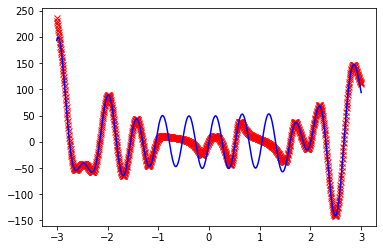

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [13]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.39547924310794424
